<h3>Library Imports</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
import chemprop
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score

/projects/community/py-bigdata/2021/bd387/envs/DDisc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Data Import</h3>

In [2]:
df = pd.read_csv("TAACF_CB2_Deduped.csv")
df.head()

MoleculeName                                             SMILES  \
0       7814291     CC(=O)NC1=CC=CC(NC(=S)NC2=CC=CC3=C2C=CC=C3)=C1   
1       7286788      ClC1=CC(Cl)=C(C=C1)C1=CSC(NC(=O)C2=CC=CO2)=N1   
2       7286793      CC1=C(C)N=C(NC(=O)CCCC(=O)NC2=NC(C)=C(C)S2)S1   
3       7286824  CCC(OC1=CC=CC=C1)C(=O)NC1=C(NC(=O)C(CC)OC2=CC=...   
4       7286875  O=C(N1CCCN(CC1)C(=O)C1=CC=C(C=C1)C1=CC=CC=C1)C...   

                                            RDKitMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x00000232226...   
1  <rdkit.Chem.rdchem.Mol object at 0x00000232226...   
2  <rdkit.Chem.rdchem.Mol object at 0x00000232103...   
3  <rdkit.Chem.rdchem.Mol object at 0x00000232149...   
4  <rdkit.Chem.rdchem.Mol object at 0x00000232226...   

                                         molStripped strippedSalts  \
0             CC(=O)Nc1cccc(NC(=S)Nc2cccc3ccccc23)c1           NaN   
1              O=C(Nc1nc(-c2ccc(Cl)cc2Cl)cs1)c1ccco1           NaN   
2            Cc1nc(NC(=O)CCCC(=O)Nc2nc(C)c(C)s2)sc1C           NaN   
3   CCC(Oc1ccccc1)C(=O)Nc1ccccc1NC(=O)C(CC)Oc1ccccc1           NaN   
4  O=C(c1ccc(-c2ccccc2)cc1)N1CCCN(C(=O)c2ccc(-c3c...           NaN   

   MtbH37Rv-Inhibition  Active  
0                  0.0       0  
1                  0.0       0  
2                  0.0       0  
3                  0.0       0  
4                  0.0       0

<h3>Missing and Duplicates Check</h3>

In [3]:
df.isna().sum().sort_values(ascending=False)
#Although strippedSalts has missing values, it does not contribute to the model so we can ignore that.

strippedSalts          100687
MoleculeName                0
SMILES                      0
RDKitMol                    0
molStripped                 0
MtbH37Rv-Inhibition         0
Active                      0
dtype: int64

In [5]:
df['molStripped'].duplicated().sum()
#There are no duplicate molecules

0

<h3>Balance Check</h3>

In [6]:
df['Active'].value_counts()

0    98986
1     1702
Name: Active, dtype: int64

<h3>Data Processing</h3>

In [7]:
newdf = df[['molStripped','Active']]
newdf

molStripped  Active
0                  CC(=O)Nc1cccc(NC(=S)Nc2cccc3ccccc23)c1       0
1                   O=C(Nc1nc(-c2ccc(Cl)cc2Cl)cs1)c1ccco1       0
2                 Cc1nc(NC(=O)CCCC(=O)Nc2nc(C)c(C)s2)sc1C       0
3        CCC(Oc1ccccc1)C(=O)Nc1ccccc1NC(=O)C(CC)Oc1ccccc1       0
4       O=C(c1ccc(-c2ccccc2)cc1)N1CCCN(C(=O)c2ccc(-c3c...       0
...                                                   ...     ...
100683  O=c1c2c(-c3ccc(Cl)cc3)csc2nc2c3ccccc3c(NCCN3CC...       1
100684    O=C(Oc1cccc2cccnc12)c1ccc(S(=O)(=O)N2CCCCC2)cc1       1
100685             O=[N+]([O-])/C=C/c1ccc(-c2ccc(F)cc2)o1       1
100686    O=C(CCN1C(=O)C2C3C=CC(C3)C2C1=O)Oc1cccc2cccnc12       1
100687  Cc1cccc(-n2nc([N+](=O)[O-])c(NCCC3=CCCCC3)[n+]...       1

[100688 rows x 2 columns]

In [8]:
y = df[['Active']]

In [9]:
train, test = train_test_split(newdf ,stratify=y, test_size=0.20, shuffle=True, random_state=42)

In [10]:
train['Active'].value_counts()

0    79188
1     1362
Name: Active, dtype: int64

In [11]:
test['Active'].value_counts()

0    19798
1      340
Name: Active, dtype: int64

In [12]:
testmol=test[['molStripped']]
testmol.head()

molStripped
38452                      COc1ccc(CC(=O)Nc2cc(C)on2)cc1
21818                COc1ccc(N2C(=O)CC(NC3CCCC3)C2=O)cc1
64186                 S=c1[nH]nc(-c2ccccc2Cl)n1Cc1ccccc1
91024  CCc1nnc(NS(=O)(=O)c2ccc(NC(=S)NC(=O)Cc3ccc(Cl)...
27127                             O=C(Oc1ccccc1)N1CCCCC1

In [13]:
test_actuals = test[['Active']]
test_actuals.head()

Active
38452       0
21818       0
64186       0
91024       0
27127       0

In [14]:
testmol.to_csv('test.csv',index=False)
train.to_csv('train.csv',index=False)

<h3>MPN without rdkit</h3>

In [14]:
parameters_opt = ['--data_path','train.csv', #location of the training data
                  '--dataset_type','classification', #Can also do regression, multiclass and spectra
                  '--loss_function','binary_cross_entropy', #Various loss functions available, since it's a binary classification I use binary cross entropy
                  '--num_folds','1', #Number of k-folds to do
                  '--extra_metrics','f1', #Other metrics to also calculate
                  '--metric','binary_cross_entropy', # The main metric used by Chemprop to optimize the training to minimize loss or maxmize accuracy depending on the metric used
                  '--epochs','200', #How many epochs to run
                  '--batch_size','32', #Default is 100 but I would increase in powers of 2
                  '--num_iters','10', # How many iterations of hyperparameter optimzations to run
                 # '--split_type','scaffold_balanced', 
                  '--class_balance', # Using this ensures balanced class is used for for batches, do not need if data is balanced already
                 #'--features_generator','rdkit_2d', # Adds 2d rdkit features to the training aswell. Can also add morgan fingerprints
                 #'--no_features_scaling', # rdkit features are already scaled and normalized, can use this line if we need to use unscaled and unnormalized features instead
                  '--config_save_path','saveparam', # Save location of the best parameters
                 # '--seed','42',
                  '--num_workers','28' # How many CPUs to use
                 ]

In [ ]:
hyp = chemprop.hyperparameter_optimization.hyperopt(args=chemprop.args.HyperoptArgs().parse_args(parameters_opt))

Creating search space using parameters ['linked_hidden_size', 'dropout', 'ffn_num_layers', 'depth'].
No manual trials loaded as part of hyperparameter search
Initiating trial with seed 0
Loaded 0 previous trials
Parameters assigned with random search, 5 random trials remaining


  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

Command line

python /projects/community/py-bigdata/2021/bd387/envs/DDisc/lib/python3.9/site-packages/ipykernel_launcher.py -f /cache/home/fkm11/.local/share/jupyter/runtime/kernel-9fab9bfa-4dfa-460e-9487-a12fe6a7a4e6.json

Args

{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 32,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': True,
 'config_path': None,
 'config_save_path': 'saveparam',
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': False,
 'data_path': 'train.csv',
 'data_weights_path


 31%|###       | 24648/80550 [00:06<00:16, 3318.00it/s]

 31%|###1      | 24987/80550 [00:06<00:16, 3339.11it/s]

 31%|###1      | 25321/80550 [00:06<00:16, 3249.35it/s]

 32%|###1      | 25654/80550 [00:06<00:16, 3272.20it/s]

 32%|###2      | 25984/80550 [00:06<00:16, 3279.91it/s]

 33%|###2      | 26323/80550 [00:06<00:16, 3310.22it/s]

 33%|###3      | 26656/80550 [00:07<00:16, 3314.42it/s]

 34%|###3      | 26988/80550 [00:07<00:16, 3298.54it/s]

 34%|###3      | 27319/80550 [00:07<00:16, 3300.57it/s]

 34%|###4      | 27651/80550 [00:07<00:16, 3303.98it/s]

 35%|###4      | 27982/80550 [00:07<00:15, 3300.49it/s]

 35%|###5      | 28313/80550 [00:07<00:15, 3273.09it/s]

 36%|###5      | 28642/80550 [00:07<00:15, 3277.31it/s]

 36%|###5      | 28971/80550 [00:07<00:15, 3278.58it/s]

 36%|###6      | 29300/80550 [00:07<00:15, 3280.43it/s]

 37%|###6      | 29631/80550 [00:07<00:15, 3287.58it/s]

 37%|###7      | 29960/80550 [00:08<00:15, 3274.33it/s]

 38%|###7      | 30293/80550 [


 90%|########9 | 72456/80550 [00:20<00:02, 3277.80it/s]

 90%|######### | 72788/80550 [00:20<00:02, 3289.59it/s]

 91%|######### | 73118/80550 [00:20<00:02, 3292.60it/s]

 91%|#########1| 73448/80550 [00:20<00:02, 3288.28it/s]

 92%|#########1| 73781/80550 [00:21<00:02, 3298.55it/s]

 92%|#########2| 74119/80550 [00:21<00:01, 3321.30it/s]

 92%|#########2| 74453/80550 [00:21<00:01, 3325.58it/s]

 93%|#########2| 74786/80550 [00:21<00:01, 3299.24it/s]

 93%|#########3| 75116/80550 [00:21<00:01, 3294.82it/s]

 94%|#########3| 75446/80550 [00:21<00:01, 3293.81it/s]

 94%|#########4| 75776/80550 [00:21<00:01, 3288.63it/s]

 94%|#########4| 76111/80550 [00:21<00:01, 3306.11it/s]

 95%|#########4| 76442/80550 [00:21<00:01, 3227.80it/s]

 95%|#########5| 76768/80550 [00:21<00:01, 3235.69it/s]

 96%|#########5| 77092/80550 [00:22<00:01, 3231.23it/s]

 96%|#########6| 77422/80550 [00:22<00:00, 3249.65it/s]

 97%|#########6| 77750/80550 [00:22<00:00, 3255.60it/s]

 97%|#########6| 78076/80550 [


 38%|###8      | 96/252 [00:11<00:15, 10.38it/s]

 39%|###8      | 98/252 [00:11<00:14, 10.27it/s]

 40%|###9      | 100/252 [00:11<00:14, 10.80it/s]

 40%|####      | 102/252 [00:11<00:13, 11.35it/s]

 41%|####1     | 104/252 [00:11<00:14, 10.05it/s]

 42%|####2     | 106/252 [00:12<00:14, 10.21it/s]

 43%|####2     | 108/252 [00:12<00:13, 10.74it/s]

 44%|####3     | 110/252 [00:12<00:12, 11.26it/s]

 44%|####4     | 112/252 [00:12<00:12, 11.26it/s]

 45%|####5     | 114/252 [00:12<00:14,  9.81it/s]

 46%|####6     | 116/252 [00:13<00:12, 10.50it/s]

 47%|####6     | 118/252 [00:13<00:12, 11.05it/s]

 48%|####7     | 120/252 [00:13<00:11, 11.64it/s]

 48%|####8     | 122/252 [00:13<00:11, 11.71it/s]

 49%|####9     | 124/252 [00:13<00:15,  8.35it/s]

 50%|####9     | 125/252 [00:14<00:17,  7.46it/s]

 50%|#####     | 126/252 [00:14<00:17,  7.07it/s]

 51%|#####     | 128/252 [00:14<00:14,  8.54it/s]

 52%|#####1    | 130/252 [00:14<00:13,  9.38it/s]

 52%|#####2    | 132/252 [00:14<

 14%|#3        | 35/252 [00:05<00:34,  6.25it/s]

 14%|#4        | 36/252 [00:06<00:35,  6.12it/s]

 15%|#5        | 38/252 [00:06<00:27,  7.86it/s]

 16%|#5        | 40/252 [00:06<00:22,  9.25it/s]

 17%|#6        | 42/252 [00:06<00:20, 10.08it/s]

 17%|#7        | 44/252 [00:06<00:19, 10.90it/s]

 18%|#8        | 46/252 [00:06<00:17, 11.48it/s]

 19%|#9        | 48/252 [00:06<00:17, 11.45it/s]

 20%|#9        | 50/252 [00:07<00:17, 11.84it/s]

 21%|##        | 52/252 [00:07<00:16, 12.22it/s]

 21%|##1       | 54/252 [00:07<00:16, 12.16it/s]

 22%|##2       | 56/252 [00:07<00:17, 11.17it/s]

 23%|##3       | 58/252 [00:07<00:18, 10.49it/s]

 24%|##3       | 60/252 [00:08<00:17, 11.24it/s]

 25%|##4       | 62/252 [00:08<00:16, 11.84it/s]

 25%|##5       | 64/252 [00:08<00:18, 10.24it/s]

 26%|##6       | 66/252 [00:08<00:16, 10.99it/s]

 27%|##6       | 68/252 [00:08<00:17, 10.46it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.20it/s]

 29%|##8       | 72/252 [00:09<00:16, 11.01it/s]




 72%|#######2  | 49/68 [00:07<00:01, 10.87it/s]

 75%|#######5  | 51/68 [00:08<00:01, 11.07it/s]

 78%|#######7  | 53/68 [00:08<00:01, 11.19it/s]

Loss = 6.6913e-01, PNorm = 65.1142, GNorm = 1.4698, lr_0 = 1.4292e-04

 81%|########  | 55/68 [00:08<00:01, 10.71it/s]

 84%|########3 | 57/68 [00:08<00:01, 10.01it/s]

 87%|########6 | 59/68 [00:08<00:00, 10.39it/s]

 90%|########9 | 61/68 [00:09<00:00,  9.64it/s]

 91%|#########1| 62/68 [00:09<00:00,  9.38it/s]

 93%|#########2| 63/68 [00:09<00:00,  8.95it/s]

Loss = 6.5944e-01, PNorm = 65.1217, GNorm = 1.0458, lr_0 = 1.4516e-04

 96%|#########5| 65/68 [00:09<00:00,  9.54it/s]

 99%|#########8| 67/68 [00:09<00:00, 10.01it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<07:51,  1.88s/it]

  1%|          | 2/252 [00:01<03:28,  1.20it/s]

  2%|1         | 4/252 [00:02<01:31,  2.71it/s]

  2%|1         | 5/252 [00:02<01:13,  3.37it/s]

  3%|2         | 7/252 [00:02<00:49,  4.93it/s]

  4%|3         | 9/252 [00:02<0


Loss = 6.3621e-01, PNorm = 65.1324, GNorm = 1.2758, lr_0 = 1.4762e-04

 12%|#1        | 8/68 [00:03<00:12,  4.76it/s]

 13%|#3        | 9/68 [00:03<00:11,  5.28it/s]

 15%|#4        | 10/68 [00:03<00:11,  5.09it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.53it/s]

 18%|#7        | 12/68 [00:03<00:09,  5.94it/s]

 19%|#9        | 13/68 [00:03<00:08,  6.58it/s]

 21%|##        | 14/68 [00:04<00:07,  7.29it/s]

 24%|##3       | 16/68 [00:04<00:06,  8.61it/s]

Loss = 6.5758e-01, PNorm = 65.1423, GNorm = 1.8097, lr_0 = 1.4985e-04

 26%|##6       | 18/68 [00:04<00:05,  9.29it/s]

 29%|##9       | 20/68 [00:04<00:04,  9.95it/s]

 32%|###2      | 22/68 [00:04<00:04, 10.52it/s]

 35%|###5      | 24/68 [00:04<00:04, 10.69it/s]

 38%|###8      | 26/68 [00:05<00:03, 11.10it/s]

Loss = 6.8298e-01, PNorm = 65.1495, GNorm = 1.5770, lr_0 = 1.5209e-04

 41%|####1     | 28/68 [00:05<00:03, 10.70it/s]

 44%|####4     | 30/68 [00:05<00:03, 10.40it/s]

 47%|####7     | 32/68 [00:05<00:03, 10.14it/s]

 50%


 78%|#######7  | 196/252 [00:19<00:04, 13.03it/s]

 79%|#######8  | 199/252 [00:19<00:03, 16.34it/s]

 80%|########  | 202/252 [00:19<00:02, 18.87it/s]

 82%|########1 | 206/252 [00:19<00:02, 22.72it/s]

 83%|########2 | 209/252 [00:19<00:01, 23.32it/s]

 84%|########4 | 212/252 [00:19<00:01, 24.38it/s]

 86%|########5 | 216/252 [00:19<00:01, 25.24it/s]

 87%|########6 | 219/252 [00:20<00:01, 19.54it/s]

 88%|########8 | 222/252 [00:20<00:01, 21.47it/s]

 90%|########9 | 226/252 [00:20<00:01, 24.34it/s]

 91%|######### | 229/252 [00:20<00:01, 19.27it/s]

 92%|#########2| 232/252 [00:20<00:00, 21.09it/s]

 93%|#########3| 235/252 [00:20<00:00, 22.04it/s]

 94%|#########4| 238/252 [00:20<00:00, 23.63it/s]

 96%|#########5| 241/252 [00:21<00:00, 22.42it/s]

 97%|#########6| 244/252 [00:21<00:00, 23.51it/s]

 98%|#########8| 247/252 [00:21<00:00, 23.34it/s]

100%|#########9| 251/252 [00:21<00:00, 25.80it/s]


Validation binary_cross_entropy = 0.604296

Validation f1 = 0.063027

  2%|2    


 50%|#####     | 126/252 [00:14<00:13,  9.08it/s]

 51%|#####     | 128/252 [00:14<00:12, 10.06it/s]

 52%|#####1    | 130/252 [00:15<00:11, 10.77it/s]

 52%|#####2    | 132/252 [00:15<00:10, 11.42it/s]

 53%|#####3    | 134/252 [00:15<00:10, 11.53it/s]

 54%|#####3    | 136/252 [00:15<00:10, 11.41it/s]

 55%|#####4    | 138/252 [00:15<00:09, 11.98it/s]

 56%|#####5    | 140/252 [00:16<00:10, 10.63it/s]

 56%|#####6    | 142/252 [00:16<00:10, 10.76it/s]

 57%|#####7    | 144/252 [00:16<00:09, 11.32it/s]

 58%|#####7    | 146/252 [00:16<00:09, 11.75it/s]

 59%|#####8    | 148/252 [00:16<00:08, 11.86it/s]

 60%|#####9    | 150/252 [00:16<00:09, 11.23it/s]

 60%|######    | 152/252 [00:17<00:08, 11.68it/s]

 61%|######1   | 154/252 [00:17<00:08, 11.65it/s]

 62%|######1   | 156/252 [00:17<00:08, 11.76it/s]

 63%|######2   | 158/252 [00:17<00:09, 10.13it/s]

 63%|######3   | 160/252 [00:17<00:09,  9.62it/s]

 64%|######4   | 162/252 [00:18<00:08, 10.23it/s]

 65%|######5   | 164/252 [00:1


 27%|##6       | 68/252 [00:08<00:18, 10.09it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.20it/s]

 29%|##8       | 72/252 [00:08<00:18,  9.96it/s]

 29%|##9       | 74/252 [00:08<00:17,  9.99it/s]

 30%|###       | 76/252 [00:09<00:20,  8.74it/s]

 31%|###       | 78/252 [00:09<00:18,  9.59it/s]

 32%|###1      | 80/252 [00:09<00:19,  8.95it/s]

 33%|###2      | 82/252 [00:09<00:17,  9.74it/s]

 33%|###3      | 84/252 [00:09<00:15, 10.50it/s]

 34%|###4      | 86/252 [00:10<00:16, 10.34it/s]

 35%|###4      | 88/252 [00:10<00:15, 10.26it/s]

 36%|###5      | 90/252 [00:10<00:16,  9.69it/s]

 36%|###6      | 91/252 [00:10<00:17,  9.18it/s]

 37%|###6      | 93/252 [00:10<00:15, 10.27it/s]

 38%|###7      | 95/252 [00:10<00:14, 10.77it/s]

 38%|###8      | 97/252 [00:11<00:14, 11.04it/s]

 39%|###9      | 99/252 [00:11<00:14, 10.75it/s]

 40%|####      | 101/252 [00:11<00:13, 10.91it/s]

 41%|####      | 103/252 [00:11<00:13, 10.89it/s]

 42%|####1     | 105/252 [00:11<00:12, 11.34it/

  2%|1         | 4/252 [00:02<01:40,  2.47it/s]

  2%|2         | 6/252 [00:02<01:02,  3.96it/s]

  3%|2         | 7/252 [00:02<00:53,  4.60it/s]

  3%|3         | 8/252 [00:02<00:46,  5.29it/s]

  4%|3         | 10/252 [00:02<00:34,  7.07it/s]

  5%|4         | 12/252 [00:03<00:28,  8.36it/s]

  6%|5         | 14/252 [00:03<00:24,  9.59it/s]

  6%|6         | 16/252 [00:03<00:22, 10.32it/s]

  7%|7         | 18/252 [00:03<00:24,  9.71it/s]

  8%|7         | 20/252 [00:03<00:22, 10.45it/s]

  9%|8         | 22/252 [00:03<00:20, 11.04it/s]

 10%|9         | 24/252 [00:04<00:19, 11.41it/s]

 10%|#         | 26/252 [00:04<00:21, 10.30it/s]

 11%|#1        | 28/252 [00:04<00:20, 11.02it/s]

 12%|#1        | 30/252 [00:04<00:24,  9.20it/s]

 13%|#2        | 32/252 [00:05<00:25,  8.68it/s]

 13%|#3        | 34/252 [00:05<00:23,  9.41it/s]

 14%|#4        | 36/252 [00:05<00:22,  9.80it/s]

 15%|#5        | 38/252 [00:05<00:20, 10.55it/s]

 16%|#5        | 40/252 [00:05<00:18, 11.26it/s]

 17%


 51%|#####1    | 35/68 [00:07<00:04,  7.09it/s]

Loss = 6.1156e-01, PNorm = 65.4826, GNorm = 1.4749, lr_0 = 2.1490e-04

 54%|#####4    | 37/68 [00:07<00:03,  7.83it/s]

 57%|#####7    | 39/68 [00:07<00:03,  8.55it/s]

 60%|######    | 41/68 [00:07<00:03,  8.90it/s]

 62%|######1   | 42/68 [00:08<00:03,  7.34it/s]

 65%|######4   | 44/68 [00:08<00:02,  8.41it/s]

 68%|######7   | 46/68 [00:08<00:02,  9.19it/s]

Loss = 6.3129e-01, PNorm = 65.4942, GNorm = 1.3090, lr_0 = 2.1714e-04

 69%|######9   | 47/68 [00:08<00:02,  9.05it/s]

 72%|#######2  | 49/68 [00:08<00:01,  9.59it/s]

 74%|#######3  | 50/68 [00:09<00:02,  6.91it/s]

 75%|#######5  | 51/68 [00:09<00:02,  6.29it/s]

 78%|#######7  | 53/68 [00:09<00:01,  7.51it/s]

 79%|#######9  | 54/68 [00:09<00:01,  7.87it/s]

 82%|########2 | 56/68 [00:09<00:01,  8.51it/s]

Loss = 6.1682e-01, PNorm = 65.5109, GNorm = 1.0043, lr_0 = 2.1937e-04

 84%|########3 | 57/68 [00:10<00:01,  5.57it/s]

 87%|########6 | 59/68 [00:10<00:01,  6.92it/s]

 9



Validation binary_cross_entropy = 0.497471

Validation f1 = 0.087043

  4%|4         | 8/200 [04:26<1:47:53, 33.72s/it]

Epoch 8

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:19,  2.09s/it]

  3%|2         | 2/68 [00:02<01:03,  1.03it/s]

  4%|4         | 3/68 [00:02<00:39,  1.63it/s]

  6%|5         | 4/68 [00:02<00:28,  2.25it/s]

  7%|7         | 5/68 [00:02<00:22,  2.84it/s]

  9%|8         | 6/68 [00:03<00:18,  3.40it/s]

 10%|#         | 7/68 [00:03<00:14,  4.08it/s]

 12%|#1        | 8/68 [00:03<00:12,  4.72it/s]

Loss = 6.1792e-01, PNorm = 65.5400, GNorm = 0.9814, lr_0 = 2.2385e-04

 13%|#3        | 9/68 [00:03<00:11,  5.20it/s]

 15%|#4        | 10/68 [00:03<00:11,  5.25it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.46it/s]

 18%|#7        | 12/68 [00:03<00:09,  5.89it/s]

 19%|#9        | 13/68 [00:04<00:08,  6.12it/s]

 21%|##        | 14/68 [00:04<00:08,  6.57it/s]

 24%|##3       | 16/68 [00:04<00:06,  7.94it/s]

 26%|##6       | 18/68 [00:04<0


 57%|#####6    | 143/252 [00:19<00:14,  7.49it/s]

 57%|#####7    | 144/252 [00:19<00:14,  7.39it/s]

 58%|#####7    | 146/252 [00:19<00:11,  8.99it/s]

 59%|#####8    | 148/252 [00:19<00:11,  9.03it/s]

 59%|#####9    | 149/252 [00:19<00:12,  8.47it/s]

 60%|#####9    | 151/252 [00:19<00:11,  8.59it/s]

 60%|######    | 152/252 [00:20<00:12,  8.10it/s]

 61%|######    | 153/252 [00:20<00:12,  7.63it/s]

 61%|######1   | 154/252 [00:20<00:13,  7.09it/s]

 62%|######1   | 156/252 [00:20<00:11,  8.18it/s]

 63%|######2   | 158/252 [00:20<00:11,  8.43it/s]

 63%|######3   | 160/252 [00:20<00:09,  9.72it/s]

 64%|######4   | 162/252 [00:21<00:09,  9.55it/s]

 65%|######5   | 164/252 [00:21<00:09,  9.28it/s]

 65%|######5   | 165/252 [00:21<00:09,  9.09it/s]

 66%|######6   | 167/252 [00:21<00:08,  9.52it/s]

 67%|######7   | 169/252 [00:21<00:08,  9.63it/s]

 67%|######7   | 170/252 [00:22<00:09,  8.50it/s]

 68%|######8   | 172/252 [00:22<00:10,  7.32it/s]

 69%|######8   | 173/252 [00:2


 19%|#8        | 47/252 [00:05<00:15, 12.81it/s]

 19%|#9        | 49/252 [00:06<00:15, 12.80it/s]

 20%|##        | 51/252 [00:06<00:15, 12.97it/s]

 21%|##1       | 53/252 [00:06<00:15, 13.11it/s]

 22%|##1       | 55/252 [00:06<00:15, 13.07it/s]

 23%|##2       | 57/252 [00:06<00:16, 11.53it/s]

 23%|##3       | 59/252 [00:06<00:18, 10.69it/s]

 24%|##4       | 61/252 [00:07<00:16, 11.32it/s]

 25%|##5       | 63/252 [00:07<00:19,  9.62it/s]

 26%|##5       | 65/252 [00:07<00:24,  7.68it/s]

 26%|##6       | 66/252 [00:07<00:25,  7.34it/s]

 27%|##6       | 68/252 [00:08<00:21,  8.56it/s]

 28%|##7       | 70/252 [00:08<00:19,  9.44it/s]

 29%|##8       | 72/252 [00:08<00:19,  9.29it/s]

 29%|##9       | 74/252 [00:08<00:17,  9.90it/s]

 30%|###       | 76/252 [00:08<00:16, 10.78it/s]

 31%|###       | 78/252 [00:08<00:16, 10.72it/s]

 32%|###1      | 80/252 [00:09<00:15, 10.82it/s]

 33%|###2      | 82/252 [00:09<00:15, 11.27it/s]

 33%|###3      | 84/252 [00:09<00:15, 11.06it/s]



 87%|########6 | 59/68 [00:09<00:01,  7.66it/s]

 88%|########8 | 60/68 [00:09<00:01,  7.93it/s]

 90%|########9 | 61/68 [00:10<00:00,  7.64it/s]

 91%|#########1| 62/68 [00:10<00:00,  7.39it/s]

 93%|#########2| 63/68 [00:10<00:00,  6.36it/s]

Loss = 6.2218e-01, PNorm = 65.8726, GNorm = 1.0765, lr_0 = 2.6654e-04

 94%|#########4| 64/68 [00:10<00:00,  6.84it/s]

 96%|#########5| 65/68 [00:10<00:00,  7.33it/s]

 97%|#########7| 66/68 [00:10<00:00,  7.72it/s]

 99%|#########8| 67/68 [00:10<00:00,  8.10it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:11,  1.96s/it]

  1%|1         | 3/252 [00:02<02:30,  1.66it/s]

  2%|1         | 5/252 [00:02<01:22,  2.98it/s]

  3%|2         | 7/252 [00:02<00:55,  4.43it/s]

  4%|3         | 9/252 [00:02<00:41,  5.90it/s]

  4%|4         | 11/252 [00:02<00:33,  7.13it/s]

  5%|5         | 13/252 [00:03<00:29,  8.01it/s]

  6%|5         | 15/252 [00:03<00:26,  9.10it/s]

  7%|6         | 17/252 [00:03<00:23,  9.88it/s]




 19%|#9        | 13/68 [00:04<00:09,  6.07it/s]

 21%|##        | 14/68 [00:04<00:08,  6.69it/s]

 24%|##3       | 16/68 [00:04<00:06,  8.09it/s]

Loss = 5.6241e-01, PNorm = 65.9187, GNorm = 1.4292, lr_0 = 2.7124e-04

 25%|##5       | 17/68 [00:04<00:06,  8.48it/s]

 28%|##7       | 19/68 [00:04<00:05,  9.44it/s]

 29%|##9       | 20/68 [00:05<00:05,  8.10it/s]

 31%|###       | 21/68 [00:05<00:05,  8.49it/s]

 32%|###2      | 22/68 [00:05<00:05,  8.77it/s]

 35%|###5      | 24/68 [00:05<00:04,  9.14it/s]

 37%|###6      | 25/68 [00:05<00:04,  9.26it/s]

Loss = 5.9158e-01, PNorm = 65.9474, GNorm = 1.6276, lr_0 = 2.7347e-04

 40%|###9      | 27/68 [00:05<00:04,  9.43it/s]

 43%|####2     | 29/68 [00:06<00:04,  8.72it/s]

 44%|####4     | 30/68 [00:06<00:04,  8.92it/s]

 46%|####5     | 31/68 [00:06<00:04,  9.13it/s]

 47%|####7     | 32/68 [00:06<00:03,  9.30it/s]

 49%|####8     | 33/68 [00:06<00:04,  8.66it/s]

 50%|#####     | 34/68 [00:06<00:04,  8.27it/s]

 51%|#####1    | 35/68 [


 79%|#######8  | 198/252 [00:18<00:03, 14.51it/s]

 80%|########  | 202/252 [00:19<00:02, 18.57it/s]

 82%|########1 | 206/252 [00:19<00:02, 21.05it/s]

 83%|########3 | 210/252 [00:19<00:01, 24.28it/s]

 85%|########4 | 214/252 [00:19<00:01, 26.70it/s]

 86%|########6 | 217/252 [00:19<00:01, 24.88it/s]

 87%|########7 | 220/252 [00:19<00:01, 25.34it/s]

 88%|########8 | 223/252 [00:19<00:01, 22.38it/s]

 90%|######### | 227/252 [00:20<00:01, 24.90it/s]

 91%|#########1| 230/252 [00:20<00:00, 22.14it/s]

 92%|#########2| 233/252 [00:20<00:01, 18.57it/s]

 94%|#########3| 236/252 [00:20<00:00, 20.33it/s]

 95%|#########4| 239/252 [00:20<00:00, 20.70it/s]

 96%|#########6| 243/252 [00:20<00:00, 23.97it/s]

 98%|#########7| 246/252 [00:21<00:00, 22.04it/s]

 99%|#########8| 249/252 [00:21<00:00, 22.48it/s]


Validation binary_cross_entropy = 0.703163

Validation f1 = 0.063862

  6%|6         | 12/200 [06:43<1:44:56, 33.49s/it]

Epoch 12

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1    


 58%|#####8    | 147/252 [00:15<00:10, 10.26it/s]

 59%|#####9    | 149/252 [00:15<00:10, 10.14it/s]

 60%|#####9    | 151/252 [00:15<00:09, 10.19it/s]

 61%|######    | 153/252 [00:16<00:09, 10.01it/s]

 62%|######1   | 155/252 [00:16<00:08, 10.81it/s]

 62%|######2   | 157/252 [00:16<00:08, 11.28it/s]

 63%|######3   | 159/252 [00:16<00:08, 11.01it/s]

 64%|######3   | 161/252 [00:16<00:07, 11.39it/s]

 65%|######4   | 163/252 [00:16<00:07, 11.91it/s]

 65%|######5   | 165/252 [00:16<00:07, 12.19it/s]

 66%|######6   | 167/252 [00:17<00:06, 12.38it/s]

 67%|######7   | 169/252 [00:17<00:06, 12.46it/s]

 68%|######7   | 171/252 [00:17<00:07, 11.02it/s]

 69%|######8   | 173/252 [00:17<00:07, 11.11it/s]

 69%|######9   | 175/252 [00:17<00:07, 10.81it/s]

 70%|#######   | 177/252 [00:18<00:06, 10.91it/s]

 71%|#######1  | 179/252 [00:18<00:07,  9.41it/s]

 72%|#######1  | 181/252 [00:18<00:07,  9.83it/s]

 73%|#######2  | 183/252 [00:18<00:06, 10.11it/s]

 73%|#######3  | 185/252 [00:1


 35%|###4      | 88/252 [00:11<00:23,  7.11it/s]

 35%|###5      | 89/252 [00:11<00:26,  6.26it/s]

 36%|###5      | 90/252 [00:11<00:27,  5.90it/s]

 36%|###6      | 91/252 [00:11<00:28,  5.64it/s]

 37%|###6      | 92/252 [00:12<00:29,  5.42it/s]

 37%|###6      | 93/252 [00:12<00:29,  5.39it/s]

 37%|###7      | 94/252 [00:12<00:29,  5.40it/s]

 38%|###7      | 95/252 [00:12<00:28,  5.55it/s]

 38%|###8      | 96/252 [00:12<00:27,  5.60it/s]

 38%|###8      | 97/252 [00:12<00:28,  5.47it/s]

 39%|###8      | 98/252 [00:13<00:27,  5.63it/s]

 39%|###9      | 99/252 [00:13<00:26,  5.67it/s]

 40%|###9      | 100/252 [00:13<00:26,  5.69it/s]

 40%|####      | 101/252 [00:13<00:27,  5.53it/s]

 40%|####      | 102/252 [00:13<00:28,  5.29it/s]

 41%|####      | 103/252 [00:14<00:45,  3.26it/s]

 41%|####1     | 104/252 [00:14<00:39,  3.77it/s]

 42%|####1     | 105/252 [00:14<00:35,  4.16it/s]

 42%|####2     | 106/252 [00:14<00:32,  4.50it/s]

 42%|####2     | 107/252 [00:15<00:30,  4.


 84%|########3 | 57/68 [00:08<00:01, 10.26it/s]

 87%|########6 | 59/68 [00:09<00:00, 10.14it/s]

 90%|########9 | 61/68 [00:09<00:00, 10.08it/s]

 93%|#########2| 63/68 [00:09<00:00, 10.18it/s]

Loss = 5.9039e-01, PNorm = 66.5973, GNorm = 2.9921, lr_0 = 3.2735e-04

 96%|#########5| 65/68 [00:09<00:00,  9.36it/s]

 99%|#########8| 67/68 [00:09<00:00,  9.71it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:22,  2.00s/it]

  1%|          | 2/252 [00:02<03:53,  1.07it/s]

  1%|1         | 3/252 [00:02<02:19,  1.79it/s]

  2%|1         | 5/252 [00:02<01:10,  3.52it/s]

  2%|2         | 6/252 [00:02<01:02,  3.91it/s]

  3%|3         | 8/252 [00:02<00:45,  5.36it/s]

  4%|3         | 10/252 [00:03<00:36,  6.72it/s]

  5%|4         | 12/252 [00:03<00:29,  8.02it/s]

  6%|5         | 14/252 [00:03<00:26,  8.93it/s]

  6%|6         | 16/252 [00:03<00:24,  9.45it/s]

  7%|7         | 18/252 [00:03<00:22, 10.36it/s]

  8%|7         | 20/252 [00:03<00:21, 10.85it/s]


Loss = 5.8230e-01, PNorm = 66.6529, GNorm = 1.0207, lr_0 = 3.3182e-04

 25%|##5       | 17/68 [00:04<00:05,  8.62it/s]

 26%|##6       | 18/68 [00:04<00:05,  8.69it/s]

 29%|##9       | 20/68 [00:04<00:05,  9.22it/s]

 31%|###       | 21/68 [00:04<00:05,  9.07it/s]

 34%|###3      | 23/68 [00:05<00:05,  8.39it/s]

 37%|###6      | 25/68 [00:05<00:04,  9.26it/s]

Loss = 5.5507e-01, PNorm = 66.6902, GNorm = 0.8621, lr_0 = 3.3405e-04

 38%|###8      | 26/68 [00:05<00:04,  9.31it/s]

 41%|####1     | 28/68 [00:05<00:04,  9.01it/s]

 43%|####2     | 29/68 [00:05<00:05,  7.52it/s]

 46%|####5     | 31/68 [00:06<00:04,  8.46it/s]

 49%|####8     | 33/68 [00:06<00:03,  9.34it/s]

 50%|#####     | 34/68 [00:06<00:04,  8.44it/s]

Loss = 5.4678e-01, PNorm = 66.7209, GNorm = 2.2520, lr_0 = 3.3629e-04

 53%|#####2    | 36/68 [00:06<00:03,  8.80it/s]

 54%|#####4    | 37/68 [00:06<00:03,  8.70it/s]

 57%|#####7    | 39/68 [00:06<00:03,  9.05it/s]

 60%|######    | 41/68 [00:07<00:02,  9.18it/s]

 6


 80%|#######9  | 201/252 [00:21<00:03, 16.66it/s]

 81%|########  | 203/252 [00:21<00:02, 16.64it/s]

 81%|########1 | 205/252 [00:21<00:02, 17.27it/s]

 83%|########2 | 209/252 [00:21<00:01, 21.90it/s]

 85%|########4 | 213/252 [00:21<00:01, 25.39it/s]

 86%|########5 | 216/252 [00:21<00:01, 26.09it/s]

 87%|########7 | 220/252 [00:21<00:01, 28.09it/s]

 89%|########8 | 224/252 [00:21<00:00, 29.27it/s]

 90%|######### | 228/252 [00:21<00:00, 30.54it/s]

 92%|#########2| 232/252 [00:22<00:00, 24.11it/s]

 94%|#########3| 236/252 [00:22<00:00, 26.21it/s]

 95%|#########4| 239/252 [00:22<00:00, 25.19it/s]

 96%|#########6| 243/252 [00:22<00:00, 27.57it/s]

 98%|#########7| 246/252 [00:22<00:00, 26.61it/s]

 99%|#########9| 250/252 [00:22<00:00, 28.18it/s]


Validation binary_cross_entropy = 0.586196

Validation f1 = 0.077690

  8%|8         | 16/200 [09:01<1:44:36, 34.11s/it]

Epoch 16

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:23,  2.15s/it]

  3%|2       


 57%|#####7    | 144/252 [00:16<00:10, 10.55it/s]

 58%|#####7    | 146/252 [00:16<00:09, 11.04it/s]

 59%|#####8    | 148/252 [00:16<00:10,  9.56it/s]

 60%|#####9    | 150/252 [00:16<00:10, 10.02it/s]

 60%|######    | 152/252 [00:16<00:09, 10.02it/s]

 61%|######1   | 154/252 [00:17<00:09, 10.46it/s]

 62%|######1   | 156/252 [00:17<00:09, 10.61it/s]

 63%|######2   | 158/252 [00:17<00:09,  9.50it/s]

 63%|######3   | 159/252 [00:17<00:10,  9.04it/s]

 64%|######3   | 161/252 [00:17<00:09,  9.57it/s]

 65%|######4   | 163/252 [00:18<00:09,  9.80it/s]

 65%|######5   | 164/252 [00:18<00:08,  9.82it/s]

 66%|######5   | 166/252 [00:18<00:08, 10.13it/s]

 67%|######6   | 168/252 [00:18<00:07, 10.84it/s]

 67%|######7   | 170/252 [00:18<00:08,  9.25it/s]

 68%|######8   | 172/252 [00:18<00:07, 10.10it/s]

 69%|######9   | 174/252 [00:19<00:07, 10.23it/s]

 70%|######9   | 176/252 [00:19<00:07, 10.28it/s]

 71%|#######   | 178/252 [00:19<00:07, 10.47it/s]

 71%|#######1  | 180/252 [00:1


 29%|##8       | 73/252 [00:09<00:22,  7.99it/s]

 30%|##9       | 75/252 [00:09<00:19,  9.14it/s]

 31%|###       | 77/252 [00:10<00:17, 10.22it/s]

 31%|###1      | 79/252 [00:10<00:15, 11.03it/s]

 32%|###2      | 81/252 [00:10<00:17,  9.64it/s]

 33%|###2      | 83/252 [00:10<00:16, 10.17it/s]

 34%|###3      | 85/252 [00:10<00:16, 10.04it/s]

 35%|###4      | 87/252 [00:11<00:17,  9.67it/s]

 35%|###4      | 88/252 [00:11<00:16,  9.66it/s]

 35%|###5      | 89/252 [00:11<00:17,  9.07it/s]

 36%|###5      | 90/252 [00:11<00:19,  8.48it/s]

 37%|###6      | 92/252 [00:11<00:16,  9.53it/s]

 37%|###7      | 94/252 [00:11<00:14, 10.56it/s]

 38%|###8      | 96/252 [00:12<00:15,  9.82it/s]

 39%|###8      | 98/252 [00:12<00:15,  9.98it/s]

 40%|###9      | 100/252 [00:12<00:19,  7.89it/s]

 40%|####      | 101/252 [00:12<00:18,  8.02it/s]

 41%|####      | 103/252 [00:12<00:16,  8.87it/s]

 42%|####1     | 105/252 [00:13<00:14,  9.95it/s]

 42%|####2     | 107/252 [00:13<00:13, 10.76i

 90%|########9 | 61/68 [00:11<00:00,  8.93it/s]

 91%|#########1| 62/68 [00:12<00:01,  3.52it/s]

Loss = 5.0409e-01, PNorm = 67.6214, GNorm = 1.2375, lr_0 = 3.8793e-04

 93%|#########2| 63/68 [00:12<00:01,  4.21it/s]

 96%|#########5| 65/68 [00:12<00:00,  5.69it/s]

 99%|#########8| 67/68 [00:13<00:00,  6.25it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:20,  1.99s/it]

  1%|          | 2/252 [00:02<03:41,  1.13it/s]

  2%|1         | 4/252 [00:02<01:34,  2.64it/s]

  2%|2         | 6/252 [00:02<00:57,  4.26it/s]

  3%|3         | 8/252 [00:02<00:41,  5.85it/s]

  4%|3         | 10/252 [00:02<00:32,  7.37it/s]

  5%|4         | 12/252 [00:02<00:32,  7.31it/s]

  6%|5         | 14/252 [00:03<00:28,  8.37it/s]

  6%|6         | 16/252 [00:03<00:27,  8.60it/s]

  7%|7         | 18/252 [00:03<00:24,  9.45it/s]

  8%|7         | 20/252 [00:03<00:22, 10.43it/s]

  9%|8         | 22/252 [00:03<00:22, 10.21it/s]

 10%|9         | 24/252 [00:04<00:21, 10.78it/s


Epoch 19

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:27,  2.19s/it]

  3%|2         | 2/68 [00:02<01:12,  1.10s/it]

  4%|4         | 3/68 [00:02<00:45,  1.44it/s]

  6%|5         | 4/68 [00:02<00:31,  2.02it/s]

  7%|7         | 5/68 [00:03<00:36,  1.71it/s]

Loss = 5.7507e-01, PNorm = 67.6625, GNorm = 2.5467, lr_0 = 3.9039e-04

  9%|8         | 6/68 [00:03<00:30,  2.05it/s]

 10%|#         | 7/68 [00:04<00:23,  2.64it/s]

 12%|#1        | 8/68 [00:04<00:18,  3.29it/s]

 13%|#3        | 9/68 [00:04<00:15,  3.92it/s]

 15%|#4        | 10/68 [00:04<00:12,  4.50it/s]

 16%|#6        | 11/68 [00:04<00:11,  5.00it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.34it/s]

 21%|##        | 14/68 [00:05<00:08,  6.70it/s]

Loss = 5.8262e-01, PNorm = 67.6954, GNorm = 1.0531, lr_0 = 3.9262e-04

 24%|##3       | 16/68 [00:05<00:06,  7.94it/s]

 26%|##6       | 18/68 [00:05<00:05,  8.46it/s]

 28%|##7       | 19/68 [00:05<00:05,  8.72it/s]

 29%|##9       | 20/68 [00:05<00


 69%|######9   | 174/252 [00:18<00:07,  9.99it/s]

 70%|######9   | 176/252 [00:19<00:07,  9.94it/s]

 71%|#######   | 178/252 [00:19<00:06, 10.61it/s]

 71%|#######1  | 180/252 [00:19<00:06, 10.83it/s]

 72%|#######2  | 182/252 [00:19<00:06, 10.77it/s]

 73%|#######3  | 184/252 [00:19<00:07,  9.67it/s]

 74%|#######3  | 186/252 [00:19<00:06, 10.51it/s]

 75%|#######4  | 188/252 [00:20<00:05, 10.88it/s]

 75%|#######5  | 190/252 [00:20<00:05, 11.28it/s]

 76%|#######6  | 192/252 [00:20<00:05, 11.68it/s]

 77%|#######6  | 194/252 [00:20<00:04, 11.74it/s]

 78%|#######7  | 196/252 [00:20<00:04, 11.89it/s]

 79%|#######8  | 199/252 [00:20<00:03, 14.65it/s]

 80%|########  | 202/252 [00:20<00:02, 17.34it/s]

 81%|########  | 204/252 [00:21<00:02, 16.07it/s]

 82%|########1 | 206/252 [00:21<00:02, 16.95it/s]

 83%|########3 | 210/252 [00:21<00:01, 21.57it/s]

 85%|########4 | 214/252 [00:21<00:01, 24.84it/s]

 87%|########6 | 218/252 [00:21<00:01, 27.04it/s]

 88%|########8 | 222/252 [00:2


 44%|####3     | 110/252 [00:12<00:13, 10.62it/s]

 44%|####4     | 112/252 [00:12<00:12, 11.19it/s]

 45%|####5     | 114/252 [00:13<00:12, 11.22it/s]

 46%|####6     | 116/252 [00:13<00:13, 10.05it/s]

 47%|####6     | 118/252 [00:13<00:13, 10.19it/s]

 48%|####7     | 120/252 [00:13<00:12, 10.78it/s]

 48%|####8     | 122/252 [00:13<00:13,  9.69it/s]

 49%|####9     | 124/252 [00:14<00:13,  9.55it/s]

 50%|#####     | 126/252 [00:14<00:12, 10.06it/s]

 51%|#####     | 128/252 [00:14<00:11, 10.50it/s]

 52%|#####1    | 130/252 [00:14<00:10, 11.18it/s]

 52%|#####2    | 132/252 [00:14<00:11, 10.43it/s]

 53%|#####3    | 134/252 [00:15<00:10, 11.18it/s]

 54%|#####3    | 136/252 [00:15<00:10, 11.44it/s]

 55%|#####4    | 138/252 [00:15<00:11,  9.88it/s]

 56%|#####5    | 140/252 [00:15<00:10, 10.57it/s]

 56%|#####6    | 142/252 [00:15<00:10, 10.52it/s]

 57%|#####7    | 144/252 [00:16<00:11,  9.33it/s]

 58%|#####7    | 146/252 [00:16<00:11,  9.12it/s]

 59%|#####8    | 148/252 [00:1


 16%|#5        | 40/252 [00:05<00:17, 12.38it/s]

 17%|#6        | 42/252 [00:05<00:16, 12.43it/s]

 17%|#7        | 44/252 [00:05<00:16, 12.53it/s]

 18%|#8        | 46/252 [00:05<00:16, 12.73it/s]

 19%|#9        | 48/252 [00:05<00:16, 12.67it/s]

 20%|#9        | 50/252 [00:06<00:15, 12.76it/s]

 21%|##        | 52/252 [00:06<00:15, 12.94it/s]

 21%|##1       | 54/252 [00:06<00:15, 12.39it/s]

 22%|##2       | 56/252 [00:06<00:15, 12.43it/s]

 23%|##3       | 58/252 [00:06<00:15, 12.71it/s]

 24%|##3       | 60/252 [00:06<00:17, 11.17it/s]

 25%|##4       | 62/252 [00:07<00:16, 11.24it/s]

 25%|##5       | 64/252 [00:07<00:16, 11.67it/s]

 26%|##6       | 66/252 [00:07<00:16, 11.41it/s]

 27%|##6       | 68/252 [00:07<00:15, 11.90it/s]

 28%|##7       | 70/252 [00:07<00:15, 12.07it/s]

 29%|##8       | 72/252 [00:07<00:14, 12.42it/s]

 29%|##9       | 74/252 [00:08<00:14, 12.35it/s]

 30%|###       | 76/252 [00:08<00:13, 12.76it/s]

 31%|###       | 78/252 [00:08<00:14, 12.22it/s]



 76%|#######6  | 52/68 [00:08<00:01,  9.57it/s]

Loss = 5.2701e-01, PNorm = 68.8101, GNorm = 1.3329, lr_0 = 4.4650e-04

 79%|#######9  | 54/68 [00:08<00:01, 10.08it/s]

 82%|########2 | 56/68 [00:08<00:01, 10.57it/s]

 85%|########5 | 58/68 [00:08<00:00, 10.31it/s]

 88%|########8 | 60/68 [00:09<00:00, 10.33it/s]

 91%|#########1| 62/68 [00:09<00:00,  8.61it/s]

Loss = 5.5486e-01, PNorm = 68.8578, GNorm = 2.0073, lr_0 = 4.4873e-04

 93%|#########2| 63/68 [00:09<00:00,  8.79it/s]

 96%|#########5| 65/68 [00:09<00:00,  9.42it/s]

 99%|#########8| 67/68 [00:09<00:00,  9.92it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:35,  2.05s/it]

  1%|          | 2/252 [00:02<03:46,  1.10it/s]

  2%|1         | 4/252 [00:02<01:40,  2.48it/s]

  2%|2         | 6/252 [00:02<01:02,  3.96it/s]

  3%|2         | 7/252 [00:02<00:54,  4.51it/s]

  4%|3         | 9/252 [00:02<00:40,  6.06it/s]

  4%|4         | 11/252 [00:03<00:33,  7.14it/s]

  5%|4         | 12/252 [00:03


 83%|########3 | 210/252 [00:27<00:01, 23.05it/s]

 85%|########4 | 213/252 [00:27<00:01, 22.12it/s]

 86%|########5 | 216/252 [00:27<00:01, 23.42it/s]

 87%|########6 | 219/252 [00:27<00:01, 23.17it/s]

 88%|########8 | 222/252 [00:27<00:01, 24.30it/s]

 90%|########9 | 226/252 [00:28<00:00, 27.30it/s]

 91%|#########1| 230/252 [00:28<00:01, 21.09it/s]

 92%|#########2| 233/252 [00:28<00:00, 20.20it/s]

 94%|#########3| 236/252 [00:28<00:00, 19.85it/s]

 95%|#########5| 240/252 [00:28<00:00, 21.82it/s]

 97%|#########6| 244/252 [00:28<00:00, 24.44it/s]

 98%|#########8| 247/252 [00:29<00:00, 21.48it/s]

100%|#########9| 251/252 [00:29<00:00, 22.28it/s]


Validation binary_cross_entropy = 0.568195

Validation f1 = 0.081208

 12%|#1        | 23/200 [13:13<1:46:51, 36.22s/it]

Epoch 23

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:22,  2.12s/it]

  3%|2         | 2/68 [00:02<01:07,  1.02s/it]

  4%|4         | 3/68 [00:02<00:40,  1.61it/s]

  6%|5         | 4/


 62%|######1   | 156/252 [00:16<00:10,  8.91it/s]

 63%|######2   | 158/252 [00:16<00:09,  9.78it/s]

 63%|######3   | 160/252 [00:16<00:11,  8.03it/s]

 64%|######4   | 162/252 [00:17<00:11,  8.08it/s]

 65%|######4   | 163/252 [00:17<00:11,  7.99it/s]

 65%|######5   | 164/252 [00:17<00:10,  8.31it/s]

 66%|######5   | 166/252 [00:17<00:10,  8.54it/s]

 66%|######6   | 167/252 [00:17<00:10,  8.12it/s]

 67%|######7   | 169/252 [00:17<00:08,  9.43it/s]

 67%|######7   | 170/252 [00:17<00:08,  9.22it/s]

 68%|######7   | 171/252 [00:18<00:09,  8.21it/s]

 69%|######8   | 173/252 [00:18<00:08,  9.44it/s]

 69%|######9   | 174/252 [00:18<00:08,  9.33it/s]

 70%|######9   | 176/252 [00:18<00:07, 10.03it/s]

 71%|#######   | 178/252 [00:18<00:06, 10.63it/s]

 71%|#######1  | 180/252 [00:18<00:06, 10.49it/s]

 72%|#######2  | 182/252 [00:19<00:06, 11.08it/s]

 73%|#######3  | 184/252 [00:19<00:06, 10.06it/s]

 74%|#######3  | 186/252 [00:19<00:07,  9.14it/s]

 75%|#######4  | 188/252 [00:1


 34%|###3      | 85/252 [00:10<00:18,  8.99it/s]

 35%|###4      | 87/252 [00:10<00:18,  8.97it/s]

 35%|###4      | 88/252 [00:10<00:21,  7.60it/s]

 36%|###5      | 90/252 [00:10<00:19,  8.43it/s]

 37%|###6      | 92/252 [00:11<00:17,  9.00it/s]

 37%|###7      | 94/252 [00:11<00:16,  9.71it/s]

 38%|###8      | 96/252 [00:11<00:14, 10.46it/s]

 39%|###8      | 98/252 [00:11<00:15,  9.98it/s]

 40%|###9      | 100/252 [00:11<00:14, 10.77it/s]

 40%|####      | 102/252 [00:11<00:13, 11.44it/s]

 41%|####1     | 104/252 [00:12<00:12, 11.97it/s]

 42%|####2     | 106/252 [00:12<00:16,  8.81it/s]

 43%|####2     | 108/252 [00:12<00:17,  8.35it/s]

 43%|####3     | 109/252 [00:12<00:18,  7.80it/s]

 44%|####3     | 110/252 [00:12<00:18,  7.55it/s]

 44%|####4     | 111/252 [00:13<00:17,  7.91it/s]

 44%|####4     | 112/252 [00:13<00:17,  8.14it/s]

 45%|####4     | 113/252 [00:13<00:18,  7.45it/s]

 46%|####5     | 115/252 [00:13<00:15,  9.02it/s]

 46%|####6     | 117/252 [00:13<00:13,


  5%|5         | 13/252 [00:03<00:33,  7.21it/s]

  6%|5         | 14/252 [00:03<00:33,  7.21it/s]

  6%|6         | 16/252 [00:03<00:28,  8.30it/s]

  7%|7         | 18/252 [00:03<00:26,  8.88it/s]

  8%|7         | 19/252 [00:03<00:25,  9.06it/s]

  8%|8         | 21/252 [00:03<00:22, 10.09it/s]

  9%|9         | 23/252 [00:04<00:21, 10.88it/s]

 10%|9         | 25/252 [00:04<00:19, 11.49it/s]

 11%|#         | 27/252 [00:04<00:19, 11.78it/s]

 12%|#1        | 29/252 [00:04<00:19, 11.24it/s]

 12%|#2        | 31/252 [00:04<00:20, 10.99it/s]

 13%|#3        | 33/252 [00:04<00:20, 10.87it/s]

 14%|#3        | 35/252 [00:05<00:19, 11.31it/s]

 15%|#4        | 37/252 [00:05<00:18, 11.55it/s]

 15%|#5        | 39/252 [00:05<00:17, 12.03it/s]

 16%|#6        | 41/252 [00:05<00:18, 11.29it/s]

 17%|#7        | 43/252 [00:05<00:21,  9.85it/s]

 18%|#7        | 45/252 [00:06<00:19, 10.58it/s]

 19%|#8        | 47/252 [00:06<00:21,  9.72it/s]

 19%|#9        | 49/252 [00:06<00:19, 10.46it/s]



 51%|#####1    | 35/68 [00:06<00:03, 10.11it/s]

 54%|#####4    | 37/68 [00:06<00:02, 10.41it/s]

 57%|#####7    | 39/68 [00:06<00:02, 10.67it/s]

 60%|######    | 41/68 [00:06<00:02, 10.85it/s]

Loss = 5.4991e-01, PNorm = 70.2452, GNorm = 1.2288, lr_0 = 5.0484e-04

 63%|######3   | 43/68 [00:07<00:02, 10.30it/s]

 66%|######6   | 45/68 [00:07<00:02, 10.73it/s]

 69%|######9   | 47/68 [00:07<00:01, 10.64it/s]

 72%|#######2  | 49/68 [00:07<00:01, 10.44it/s]

 75%|#######5  | 51/68 [00:07<00:01, 10.81it/s]

Loss = 5.1420e-01, PNorm = 70.3121, GNorm = 1.5318, lr_0 = 5.0708e-04

 78%|#######7  | 53/68 [00:08<00:01,  9.95it/s]

 81%|########  | 55/68 [00:08<00:01,  7.63it/s]

 84%|########3 | 57/68 [00:08<00:01,  8.25it/s]

 85%|########5 | 58/68 [00:08<00:01,  8.46it/s]

 87%|########6 | 59/68 [00:08<00:01,  8.60it/s]

 90%|########9 | 61/68 [00:09<00:00,  9.28it/s]

Loss = 5.1029e-01, PNorm = 70.3741, GNorm = 0.9344, lr_0 = 5.0931e-04

 91%|#########1| 62/68 [00:09<00:00,  9.34it/s]

 9


 99%|#########9| 250/252 [00:23<00:00, 22.84it/s]


Validation binary_cross_entropy = 0.609778

Validation f1 = 0.080025

 14%|#3        | 27/200 [15:28<1:39:27, 34.49s/it]

Epoch 27

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:24,  2.16s/it]

  3%|2         | 2/68 [00:02<01:06,  1.00s/it]

  4%|4         | 3/68 [00:02<00:40,  1.59it/s]

  6%|5         | 4/68 [00:02<00:28,  2.26it/s]

Loss = 5.7808e-01, PNorm = 70.4226, GNorm = 0.9003, lr_0 = 5.1177e-04

  7%|7         | 5/68 [00:02<00:22,  2.78it/s]

  9%|8         | 6/68 [00:03<00:18,  3.31it/s]

 10%|#         | 7/68 [00:03<00:17,  3.56it/s]

 12%|#1        | 8/68 [00:03<00:14,  4.22it/s]

 13%|#3        | 9/68 [00:03<00:12,  4.82it/s]

 15%|#4        | 10/68 [00:03<00:14,  4.06it/s]

 16%|#6        | 11/68 [00:04<00:13,  4.35it/s]

 18%|#7        | 12/68 [00:04<00:11,  4.88it/s]

 19%|#9        | 13/68 [00:04<00:09,  5.71it/s]

Loss = 4.6953e-01, PNorm = 70.4745, GNorm = 0.8875, lr_0 = 5.1401e-04

 22%|


 65%|######5   | 165/252 [00:20<00:07, 11.05it/s]

 66%|######6   | 167/252 [00:20<00:07, 11.65it/s]

 67%|######7   | 169/252 [00:20<00:07, 10.53it/s]

 68%|######7   | 171/252 [00:20<00:07, 10.29it/s]

 69%|######8   | 173/252 [00:21<00:07, 10.40it/s]

 69%|######9   | 175/252 [00:21<00:07, 10.38it/s]

 70%|#######   | 177/252 [00:21<00:06, 11.12it/s]

 71%|#######1  | 179/252 [00:21<00:06, 11.77it/s]

 72%|#######1  | 181/252 [00:21<00:06, 11.25it/s]

 73%|#######2  | 183/252 [00:22<00:06, 10.79it/s]

 73%|#######3  | 185/252 [00:22<00:05, 11.36it/s]

 74%|#######4  | 187/252 [00:22<00:05, 11.95it/s]

 75%|#######5  | 189/252 [00:22<00:05, 12.05it/s]

 76%|#######5  | 191/252 [00:22<00:04, 12.44it/s]

 77%|#######6  | 193/252 [00:22<00:04, 12.66it/s]

 77%|#######7  | 195/252 [00:22<00:04, 11.89it/s]

 78%|#######8  | 197/252 [00:23<00:04, 11.31it/s]

 79%|#######9  | 200/252 [00:23<00:03, 14.78it/s]

 80%|########  | 202/252 [00:23<00:03, 14.14it/s]

 82%|########1 | 206/252 [00:2


 41%|####1     | 104/252 [00:12<00:13, 10.77it/s]

 42%|####2     | 106/252 [00:12<00:13, 11.17it/s]

 43%|####2     | 108/252 [00:12<00:12, 11.15it/s]

 44%|####3     | 110/252 [00:12<00:12, 11.69it/s]

 44%|####4     | 112/252 [00:13<00:12, 11.44it/s]

 45%|####5     | 114/252 [00:13<00:12, 11.13it/s]

 46%|####6     | 116/252 [00:13<00:11, 11.60it/s]

 47%|####6     | 118/252 [00:13<00:12, 10.94it/s]

 48%|####7     | 120/252 [00:13<00:13,  9.51it/s]

 48%|####8     | 121/252 [00:13<00:13,  9.52it/s]

 49%|####8     | 123/252 [00:14<00:13,  9.58it/s]

 50%|####9     | 125/252 [00:14<00:13,  9.47it/s]

 50%|#####     | 127/252 [00:14<00:12,  9.92it/s]

 51%|#####1    | 129/252 [00:14<00:11, 10.84it/s]

 52%|#####1    | 131/252 [00:14<00:11, 10.60it/s]

 53%|#####2    | 133/252 [00:15<00:10, 10.99it/s]

 54%|#####3    | 135/252 [00:15<00:10, 10.80it/s]

 54%|#####4    | 137/252 [00:15<00:10, 11.45it/s]

 55%|#####5    | 139/252 [00:15<00:10, 11.03it/s]

 56%|#####5    | 141/252 [00:1


 19%|#8        | 47/252 [00:06<00:21,  9.41it/s]

 19%|#9        | 49/252 [00:06<00:20,  9.73it/s]

 20%|##        | 51/252 [00:06<00:20,  9.76it/s]

 21%|##1       | 53/252 [00:06<00:18, 10.73it/s]

 22%|##1       | 55/252 [00:07<00:19, 10.34it/s]

 23%|##2       | 57/252 [00:07<00:19, 10.14it/s]

 23%|##3       | 59/252 [00:07<00:18, 10.50it/s]

 24%|##4       | 61/252 [00:07<00:17, 10.69it/s]

 25%|##5       | 63/252 [00:07<00:17, 10.98it/s]

 26%|##5       | 65/252 [00:08<00:16, 11.46it/s]

 27%|##6       | 67/252 [00:08<00:15, 11.89it/s]

 27%|##7       | 69/252 [00:08<00:15, 11.54it/s]

 28%|##8       | 71/252 [00:08<00:16, 10.77it/s]

 29%|##8       | 73/252 [00:08<00:18,  9.90it/s]

 30%|##9       | 75/252 [00:08<00:16, 10.57it/s]

 31%|###       | 77/252 [00:09<00:16, 10.89it/s]

 31%|###1      | 79/252 [00:09<00:16, 10.50it/s]

 32%|###2      | 81/252 [00:09<00:18,  9.34it/s]

 33%|###2      | 83/252 [00:09<00:17,  9.41it/s]

 33%|###3      | 84/252 [00:09<00:18,  8.98it/s]



 81%|########  | 55/68 [00:08<00:01,  9.73it/s]

 84%|########3 | 57/68 [00:08<00:01,  9.80it/s]

 87%|########6 | 59/68 [00:09<00:00,  9.96it/s]

 90%|########9 | 61/68 [00:09<00:00,  9.72it/s]

Loss = 4.4360e-01, PNorm = 72.0590, GNorm = 0.8058, lr_0 = 5.7012e-04

 91%|#########1| 62/68 [00:09<00:00,  9.33it/s]

 94%|#########4| 64/68 [00:09<00:00,  9.43it/s]

 96%|#########5| 65/68 [00:09<00:00,  9.49it/s]

 97%|#########7| 66/68 [00:09<00:00,  8.56it/s]

100%|##########| 68/68 [00:10<00:00,  9.50it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:08,  1.95s/it]

  1%|          | 2/252 [00:02<03:48,  1.10it/s]

  2%|1         | 4/252 [00:02<01:38,  2.51it/s]

  2%|2         | 6/252 [00:02<01:00,  4.08it/s]

  3%|3         | 8/252 [00:02<00:45,  5.32it/s]

  4%|3         | 10/252 [00:02<00:39,  6.13it/s]

  4%|4         | 11/252 [00:03<00:36,  6.60it/s]

  5%|5         | 13/252 [00:03<00:30,  7.95it/s]

  6%|5         | 15/252 [00:03<00:30,  7.77it/s]




 18%|#7        | 12/68 [00:03<00:08,  6.29it/s]

Loss = 5.7965e-01, PNorm = 72.2048, GNorm = 1.5542, lr_0 = 5.7459e-04

 21%|##        | 14/68 [00:04<00:06,  7.85it/s]

 24%|##3       | 16/68 [00:04<00:05,  8.88it/s]

 26%|##6       | 18/68 [00:04<00:05,  9.01it/s]

 29%|##9       | 20/68 [00:04<00:04,  9.65it/s]

 32%|###2      | 22/68 [00:04<00:04, 10.30it/s]

Loss = 5.4358e-01, PNorm = 72.2802, GNorm = 0.7026, lr_0 = 5.7683e-04

 35%|###5      | 24/68 [00:05<00:04, 10.50it/s]

 38%|###8      | 26/68 [00:05<00:04, 10.00it/s]

 41%|####1     | 28/68 [00:05<00:03, 10.22it/s]

 44%|####4     | 30/68 [00:05<00:03,  9.83it/s]

 47%|####7     | 32/68 [00:05<00:03,  9.77it/s]

Loss = 5.1928e-01, PNorm = 72.3578, GNorm = 1.0335, lr_0 = 5.7906e-04

 50%|#####     | 34/68 [00:06<00:03, 10.02it/s]

 53%|#####2    | 36/68 [00:06<00:03, 10.30it/s]

 56%|#####5    | 38/68 [00:06<00:03,  9.80it/s]

 59%|#####8    | 40/68 [00:06<00:02, 10.07it/s]

 62%|######1   | 42/68 [00:06<00:02, 10.03it/s]

Lo


 71%|#######   | 178/252 [00:23<00:12,  5.83it/s]

 71%|#######1  | 179/252 [00:23<00:12,  5.72it/s]

 71%|#######1  | 180/252 [00:23<00:12,  5.75it/s]

 72%|#######1  | 181/252 [00:23<00:12,  5.71it/s]

 72%|#######2  | 182/252 [00:23<00:12,  5.81it/s]

 73%|#######2  | 183/252 [00:23<00:11,  5.86it/s]

 73%|#######3  | 184/252 [00:24<00:11,  6.11it/s]

 73%|#######3  | 185/252 [00:24<00:11,  5.96it/s]

 74%|#######3  | 186/252 [00:24<00:11,  5.90it/s]

 74%|#######4  | 187/252 [00:24<00:11,  5.83it/s]

 75%|#######4  | 188/252 [00:24<00:13,  4.88it/s]

 75%|#######5  | 189/252 [00:25<00:11,  5.25it/s]

 75%|#######5  | 190/252 [00:25<00:11,  5.46it/s]

 76%|#######5  | 191/252 [00:25<00:11,  5.51it/s]

 76%|#######6  | 192/252 [00:25<00:09,  6.12it/s]

 77%|#######6  | 194/252 [00:25<00:07,  8.12it/s]

 78%|#######7  | 196/252 [00:25<00:06,  8.21it/s]

 78%|#######8  | 197/252 [00:26<00:11,  4.75it/s]

 79%|#######9  | 200/252 [00:26<00:06,  7.95it/s]

 81%|########  | 203/252 [00:2


 38%|###7      | 95/252 [00:11<00:15, 10.33it/s]

 38%|###8      | 97/252 [00:11<00:14, 11.01it/s]

 39%|###9      | 99/252 [00:11<00:15,  9.67it/s]

 40%|####      | 101/252 [00:11<00:15,  9.99it/s]

 41%|####      | 103/252 [00:11<00:14, 10.54it/s]

 42%|####1     | 105/252 [00:12<00:15,  9.70it/s]

 42%|####2     | 107/252 [00:12<00:13, 10.41it/s]

 43%|####3     | 109/252 [00:12<00:12, 11.08it/s]

 44%|####4     | 111/252 [00:12<00:15,  9.36it/s]

 45%|####4     | 113/252 [00:12<00:14,  9.83it/s]

 46%|####5     | 115/252 [00:13<00:15,  8.94it/s]

 46%|####6     | 117/252 [00:13<00:15,  8.93it/s]

 47%|####7     | 119/252 [00:13<00:14,  9.11it/s]

 48%|####8     | 121/252 [00:13<00:13, 10.00it/s]

 49%|####8     | 123/252 [00:13<00:12, 10.32it/s]

 50%|####9     | 125/252 [00:14<00:13,  9.31it/s]

 50%|#####     | 127/252 [00:14<00:12,  9.92it/s]

 51%|#####1    | 129/252 [00:14<00:12, 10.23it/s]

 52%|#####1    | 131/252 [00:14<00:12,  9.89it/s]

 53%|#####2    | 133/252 [00:14<0


 13%|#2        | 32/252 [00:04<00:19, 11.55it/s]

 13%|#3        | 34/252 [00:04<00:19, 11.19it/s]

 14%|#4        | 36/252 [00:05<00:18, 11.43it/s]

 15%|#5        | 38/252 [00:05<00:18, 11.64it/s]

 16%|#5        | 40/252 [00:05<00:17, 12.00it/s]

 17%|#6        | 42/252 [00:05<00:17, 11.89it/s]

 17%|#7        | 44/252 [00:05<00:18, 11.46it/s]

 18%|#8        | 46/252 [00:05<00:18, 11.17it/s]

 19%|#9        | 48/252 [00:06<00:18, 11.11it/s]

 20%|#9        | 50/252 [00:06<00:17, 11.64it/s]

 21%|##        | 52/252 [00:06<00:18, 10.71it/s]

 21%|##1       | 54/252 [00:06<00:20,  9.55it/s]

 22%|##1       | 55/252 [00:06<00:20,  9.61it/s]

 23%|##2       | 57/252 [00:07<00:18, 10.37it/s]

 23%|##3       | 59/252 [00:07<00:21,  9.00it/s]

 24%|##4       | 61/252 [00:07<00:19,  9.75it/s]

 25%|##5       | 63/252 [00:07<00:17, 10.60it/s]

 26%|##5       | 65/252 [00:07<00:16, 11.28it/s]

 27%|##6       | 67/252 [00:07<00:16, 11.54it/s]

 27%|##7       | 69/252 [00:08<00:16, 11.38it/s]



Loss = 4.6319e-01, PNorm = 73.8551, GNorm = 1.7332, lr_0 = 6.2399e-04

 46%|####5     | 31/68 [00:05<00:03,  9.53it/s]

 47%|####7     | 32/68 [00:05<00:03,  9.57it/s]

 50%|#####     | 34/68 [00:06<00:03, 10.03it/s]

 53%|#####2    | 36/68 [00:06<00:03, 10.39it/s]

 56%|#####5    | 38/68 [00:06<00:02, 10.74it/s]

 59%|#####8    | 40/68 [00:06<00:03,  9.16it/s]

Loss = 4.8074e-01, PNorm = 73.9382, GNorm = 1.2093, lr_0 = 6.2623e-04

 62%|######1   | 42/68 [00:06<00:02,  9.73it/s]

 65%|######4   | 44/68 [00:07<00:02, 10.18it/s]

 68%|######7   | 46/68 [00:07<00:02, 10.44it/s]

 71%|#######   | 48/68 [00:07<00:01, 10.46it/s]

 74%|#######3  | 50/68 [00:07<00:01, 10.37it/s]

Loss = 4.8167e-01, PNorm = 74.0179, GNorm = 1.4785, lr_0 = 6.2846e-04

 76%|#######6  | 52/68 [00:07<00:01, 10.32it/s]

 79%|#######9  | 54/68 [00:08<00:01, 10.41it/s]

 82%|########2 | 56/68 [00:08<00:01, 10.66it/s]

 85%|########5 | 58/68 [00:08<00:00, 10.06it/s]

 88%|########8 | 60/68 [00:08<00:00, 10.29it/s]

Lo


  3%|2         | 2/68 [00:02<01:03,  1.03it/s]

  4%|4         | 3/68 [00:02<00:38,  1.69it/s]

Loss = 4.5797e-01, PNorm = 74.2089, GNorm = 0.9228, lr_0 = 6.3316e-04

  6%|5         | 4/68 [00:02<00:26,  2.41it/s]

  7%|7         | 5/68 [00:02<00:21,  2.93it/s]

  9%|8         | 6/68 [00:02<00:16,  3.68it/s]

 10%|#         | 7/68 [00:03<00:14,  4.17it/s]

 12%|#1        | 8/68 [00:03<00:12,  4.76it/s]

 13%|#3        | 9/68 [00:03<00:10,  5.38it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.77it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.68it/s]

 18%|#7        | 12/68 [00:03<00:08,  6.26it/s]

Loss = 4.9884e-01, PNorm = 74.2969, GNorm = 1.3262, lr_0 = 6.3539e-04

 21%|##        | 14/68 [00:04<00:07,  7.18it/s]

 22%|##2       | 15/68 [00:04<00:06,  7.71it/s]

 25%|##5       | 17/68 [00:04<00:05,  8.77it/s]

 26%|##6       | 18/68 [00:04<00:05,  8.95it/s]

 28%|##7       | 19/68 [00:04<00:05,  8.91it/s]

 29%|##9       | 20/68 [00:04<00:05,  8.95it/s]

 32%|###2      | 22/68 [00:04<00


 64%|######4   | 162/252 [00:17<00:07, 11.54it/s]

 65%|######5   | 164/252 [00:18<00:07, 12.06it/s]

 66%|######5   | 166/252 [00:18<00:06, 12.30it/s]

 67%|######6   | 168/252 [00:18<00:08, 10.19it/s]

 67%|######7   | 170/252 [00:18<00:07, 10.50it/s]

 68%|######8   | 172/252 [00:18<00:07, 10.04it/s]

 69%|######9   | 174/252 [00:19<00:08,  9.70it/s]

 70%|######9   | 176/252 [00:19<00:07, 10.27it/s]

 71%|#######   | 178/252 [00:19<00:06, 10.97it/s]

 71%|#######1  | 180/252 [00:19<00:06, 10.86it/s]

 72%|#######2  | 182/252 [00:19<00:06, 11.30it/s]

 73%|#######3  | 184/252 [00:20<00:05, 11.38it/s]

 74%|#######3  | 186/252 [00:20<00:05, 11.04it/s]

 75%|#######4  | 188/252 [00:20<00:05, 10.88it/s]

 75%|#######5  | 190/252 [00:20<00:05, 11.42it/s]

 76%|#######6  | 192/252 [00:20<00:05, 11.41it/s]

 77%|#######6  | 194/252 [00:20<00:04, 11.84it/s]

 78%|#######7  | 196/252 [00:21<00:04, 11.88it/s]

 79%|#######9  | 200/252 [00:21<00:03, 16.70it/s]

 81%|########  | 204/252 [00:2


 37%|###7      | 94/252 [00:10<00:12, 12.17it/s]

 38%|###8      | 96/252 [00:10<00:12, 12.54it/s]

 39%|###8      | 98/252 [00:11<00:12, 12.52it/s]

 40%|###9      | 100/252 [00:11<00:12, 12.57it/s]

 40%|####      | 102/252 [00:11<00:11, 12.61it/s]

 41%|####1     | 104/252 [00:11<00:11, 12.63it/s]

 42%|####2     | 106/252 [00:11<00:11, 12.81it/s]

 43%|####2     | 108/252 [00:11<00:11, 12.34it/s]

 44%|####3     | 110/252 [00:11<00:11, 12.23it/s]

 44%|####4     | 112/252 [00:12<00:11, 12.12it/s]

 45%|####5     | 114/252 [00:12<00:12, 10.77it/s]

 46%|####6     | 116/252 [00:12<00:12, 11.32it/s]

 47%|####6     | 118/252 [00:12<00:11, 11.69it/s]

 48%|####7     | 120/252 [00:12<00:11, 11.66it/s]

 48%|####8     | 122/252 [00:13<00:10, 12.05it/s]

 49%|####9     | 124/252 [00:13<00:10, 12.26it/s]

 50%|#####     | 126/252 [00:13<00:10, 12.48it/s]

 51%|#####     | 128/252 [00:13<00:09, 12.69it/s]

 52%|#####1    | 130/252 [00:13<00:09, 12.83it/s]

 52%|#####2    | 132/252 [00:13<0


 15%|#5        | 38/252 [00:05<00:22,  9.64it/s]

 16%|#5        | 40/252 [00:05<00:20, 10.32it/s]

 17%|#6        | 42/252 [00:06<00:20, 10.23it/s]

 17%|#7        | 44/252 [00:06<00:20, 10.03it/s]

 18%|#8        | 46/252 [00:06<00:19, 10.43it/s]

 19%|#9        | 48/252 [00:06<00:19, 10.66it/s]

 20%|#9        | 50/252 [00:06<00:17, 11.27it/s]

 21%|##        | 52/252 [00:07<00:17, 11.34it/s]

 21%|##1       | 54/252 [00:07<00:16, 11.79it/s]

 22%|##2       | 56/252 [00:07<00:21,  9.29it/s]

 23%|##3       | 58/252 [00:07<00:20,  9.25it/s]

 24%|##3       | 60/252 [00:07<00:19,  9.85it/s]

 25%|##4       | 62/252 [00:08<00:18, 10.14it/s]

 25%|##5       | 64/252 [00:08<00:17, 10.77it/s]

 26%|##6       | 66/252 [00:08<00:17, 10.80it/s]

 27%|##6       | 68/252 [00:08<00:17, 10.35it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.21it/s]

 29%|##8       | 72/252 [00:08<00:16, 10.80it/s]

 29%|##9       | 74/252 [00:09<00:15, 11.28it/s]

 30%|###       | 76/252 [00:09<00:14, 11.88it/s]


 90%|########9 | 61/68 [00:09<00:00,  8.02it/s]

 91%|#########1| 62/68 [00:09<00:00,  8.28it/s]

 93%|#########2| 63/68 [00:09<00:00,  7.44it/s]

 94%|#########4| 64/68 [00:09<00:00,  7.40it/s]

 96%|#########5| 65/68 [00:10<00:00,  7.13it/s]

 97%|#########7| 66/68 [00:10<00:00,  7.59it/s]

100%|##########| 68/68 [00:10<00:00,  9.18it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:20,  1.99s/it]

  1%|1         | 3/252 [00:02<02:23,  1.73it/s]

  2%|1         | 5/252 [00:02<01:20,  3.05it/s]

  2%|2         | 6/252 [00:02<01:06,  3.72it/s]

  3%|2         | 7/252 [00:02<00:54,  4.49it/s]

  3%|3         | 8/252 [00:02<00:48,  5.02it/s]

  4%|3         | 9/252 [00:02<00:42,  5.75it/s]

  4%|3         | 10/252 [00:02<00:38,  6.34it/s]

  5%|4         | 12/252 [00:03<00:29,  8.12it/s]

  5%|5         | 13/252 [00:03<00:29,  8.07it/s]

  6%|5         | 15/252 [00:03<00:27,  8.61it/s]

  7%|6         | 17/252 [00:03<00:23,  9.85it/s]

  8%|7         | 19/25

 22%|##2       | 15/68 [00:04<00:06,  7.89it/s]

 25%|##5       | 17/68 [00:04<00:05,  9.11it/s]

 28%|##7       | 19/68 [00:04<00:07,  6.95it/s]

 29%|##9       | 20/68 [00:05<00:11,  4.28it/s]

 32%|###2      | 22/68 [00:05<00:08,  5.56it/s]

Loss = 4.8629e-01, PNorm = 76.9146, GNorm = 1.5568, lr_0 = 6.9821e-04

 35%|###5      | 24/68 [00:05<00:06,  6.60it/s]

 38%|###8      | 26/68 [00:06<00:05,  7.62it/s]

 40%|###9      | 27/68 [00:06<00:06,  5.91it/s]

 43%|####2     | 29/68 [00:06<00:05,  6.75it/s]

 44%|####4     | 30/68 [00:06<00:05,  7.15it/s]

 46%|####5     | 31/68 [00:06<00:05,  6.75it/s]

 47%|####7     | 32/68 [00:07<00:04,  7.25it/s]

Loss = 4.5593e-01, PNorm = 77.0289, GNorm = 1.6219, lr_0 = 7.0045e-04

 49%|####8     | 33/68 [00:07<00:04,  7.76it/s]

 51%|#####1    | 35/68 [00:07<00:03,  9.02it/s]

 54%|#####4    | 37/68 [00:07<00:03, 10.01it/s]

 57%|#####7    | 39/68 [00:07<00:02, 10.41it/s]

 60%|######    | 41/68 [00:07<00:02,  9.52it/s]

 62%|######1   | 42/68 [0


 90%|########9 | 226/252 [00:21<00:00, 27.78it/s]

 91%|#########1| 230/252 [00:21<00:00, 27.87it/s]

 92%|#########2| 233/252 [00:21<00:00, 27.57it/s]

 94%|#########3| 236/252 [00:21<00:00, 23.75it/s]

 95%|#########4| 239/252 [00:21<00:00, 22.14it/s]

 96%|#########6| 243/252 [00:22<00:00, 24.91it/s]

 98%|#########8| 247/252 [00:22<00:00, 27.10it/s]

 99%|#########9| 250/252 [00:22<00:00, 26.52it/s]


Validation binary_cross_entropy = 0.328879

Validation f1 = 0.139045

 20%|##        | 40/200 [22:52<1:28:39, 33.25s/it]

Epoch 40

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:47,  2.50s/it]

  3%|2         | 2/68 [00:02<01:14,  1.13s/it]

  4%|4         | 3/68 [00:02<00:44,  1.45it/s]

  6%|5         | 4/68 [00:02<00:30,  2.12it/s]

Loss = 4.5679e-01, PNorm = 77.4865, GNorm = 1.4464, lr_0 = 7.0939e-04

  7%|7         | 5/68 [00:03<00:22,  2.83it/s]

  9%|8         | 6/68 [00:03<00:17,  3.52it/s]

 10%|#         | 7/68 [00:03<00:15,  4.00it/s]

 12%|#1    


 55%|#####4    | 138/252 [00:14<00:09, 12.27it/s]

 56%|#####5    | 140/252 [00:14<00:09, 12.04it/s]

 56%|#####6    | 142/252 [00:14<00:10, 10.48it/s]

 57%|#####7    | 144/252 [00:14<00:10,  9.91it/s]

 58%|#####7    | 146/252 [00:15<00:09, 10.66it/s]

 59%|#####8    | 148/252 [00:15<00:09, 11.27it/s]

 60%|#####9    | 150/252 [00:15<00:10, 10.01it/s]

 60%|######    | 152/252 [00:15<00:09, 10.69it/s]

 61%|######1   | 154/252 [00:15<00:08, 11.22it/s]

 62%|######1   | 156/252 [00:15<00:08, 11.51it/s]

 63%|######2   | 158/252 [00:16<00:07, 12.12it/s]

 63%|######3   | 160/252 [00:16<00:07, 12.05it/s]

 64%|######4   | 162/252 [00:16<00:07, 12.32it/s]

 65%|######5   | 164/252 [00:16<00:07, 11.71it/s]

 66%|######5   | 166/252 [00:16<00:07, 11.33it/s]

 67%|######6   | 168/252 [00:16<00:07, 11.85it/s]

 67%|######7   | 170/252 [00:17<00:07, 11.06it/s]

 68%|######8   | 172/252 [00:17<00:08,  9.89it/s]

 69%|######9   | 174/252 [00:17<00:07, 10.61it/s]

 70%|######9   | 176/252 [00:1


 29%|##8       | 72/252 [00:08<00:18,  9.92it/s]

 29%|##9       | 74/252 [00:09<00:19,  8.99it/s]

 30%|###       | 76/252 [00:09<00:19,  8.84it/s]

 31%|###       | 78/252 [00:09<00:18,  9.48it/s]

 32%|###1      | 80/252 [00:09<00:17, 10.11it/s]

 33%|###2      | 82/252 [00:10<00:17,  9.48it/s]

 33%|###3      | 84/252 [00:10<00:18,  9.08it/s]

 34%|###4      | 86/252 [00:10<00:17,  9.66it/s]

 35%|###4      | 87/252 [00:10<00:19,  8.54it/s]

 35%|###5      | 89/252 [00:10<00:17,  9.49it/s]

 36%|###6      | 91/252 [00:10<00:15, 10.08it/s]

 37%|###6      | 93/252 [00:11<00:14, 10.87it/s]

 38%|###7      | 95/252 [00:11<00:14, 11.09it/s]

 38%|###8      | 97/252 [00:11<00:13, 11.11it/s]

 39%|###9      | 99/252 [00:11<00:16,  9.50it/s]

 40%|###9      | 100/252 [00:11<00:16,  9.40it/s]

 40%|####      | 101/252 [00:11<00:16,  8.93it/s]

 40%|####      | 102/252 [00:12<00:18,  8.33it/s]

 41%|####1     | 104/252 [00:12<00:16,  8.78it/s]

 42%|####1     | 105/252 [00:12<00:19,  7.71i


 82%|########2 | 56/68 [00:09<00:01,  9.98it/s]

 85%|########5 | 58/68 [00:09<00:00, 10.42it/s]

Loss = 4.4969e-01, PNorm = 79.4848, GNorm = 0.7217, lr_0 = 7.5209e-04

 88%|########8 | 60/68 [00:09<00:00, 10.63it/s]

 91%|#########1| 62/68 [00:09<00:00, 10.54it/s]

 94%|#########4| 64/68 [00:09<00:00, 10.79it/s]

 97%|#########7| 66/68 [00:09<00:00, 11.00it/s]

100%|##########| 68/68 [00:10<00:00, 11.45it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:19,  1.99s/it]

  1%|          | 2/252 [00:02<03:42,  1.13it/s]

  2%|1         | 4/252 [00:02<01:43,  2.39it/s]

  2%|2         | 6/252 [00:02<01:07,  3.66it/s]

  3%|3         | 8/252 [00:02<00:48,  5.07it/s]

  4%|3         | 10/252 [00:02<00:37,  6.38it/s]

  5%|4         | 12/252 [00:03<00:31,  7.65it/s]

  6%|5         | 14/252 [00:03<00:27,  8.80it/s]

  6%|6         | 16/252 [00:03<00:29,  8.13it/s]

  7%|7         | 18/252 [00:03<00:26,  8.99it/s]

  8%|7         | 20/252 [00:03<00:23,  9.70it/s]


  7%|7         | 5/68 [00:02<00:20,  3.09it/s]

  9%|8         | 6/68 [00:03<00:20,  3.07it/s]

 10%|#         | 7/68 [00:03<00:16,  3.71it/s]

 12%|#1        | 8/68 [00:03<00:14,  4.17it/s]

 13%|#3        | 9/68 [00:03<00:12,  4.78it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.27it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.45it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.43it/s]

Loss = 4.6446e-01, PNorm = 79.7408, GNorm = 1.2788, lr_0 = 7.5678e-04

 21%|##        | 14/68 [00:04<00:07,  6.90it/s]

 24%|##3       | 16/68 [00:04<00:06,  8.16it/s]

 26%|##6       | 18/68 [00:04<00:05,  9.09it/s]

 28%|##7       | 19/68 [00:04<00:05,  9.13it/s]

 31%|###       | 21/68 [00:04<00:04,  9.78it/s]

Loss = 4.4947e-01, PNorm = 79.8491, GNorm = 1.4130, lr_0 = 7.5902e-04

 34%|###3      | 23/68 [00:05<00:04, 10.02it/s]

 37%|###6      | 25/68 [00:05<00:04, 10.47it/s]

 40%|###9      | 27/68 [00:05<00:03, 10.50it/s]

 43%|####2     | 29/68 [00:05<00:03,  9.98it/s]

 46%|####5     | 31/68 [00:05


 72%|#######1  | 181/252 [00:20<00:06, 11.17it/s]

 73%|#######2  | 183/252 [00:20<00:06, 10.80it/s]

 73%|#######3  | 185/252 [00:20<00:06, 10.38it/s]

 74%|#######4  | 187/252 [00:20<00:06, 10.23it/s]

 75%|#######5  | 189/252 [00:20<00:05, 10.85it/s]

 76%|#######5  | 191/252 [00:21<00:05, 10.35it/s]

 77%|#######6  | 193/252 [00:21<00:05, 10.83it/s]

 77%|#######7  | 195/252 [00:21<00:05, 11.12it/s]

 78%|#######8  | 197/252 [00:21<00:04, 12.18it/s]

 80%|#######9  | 201/252 [00:21<00:03, 16.86it/s]

 81%|########  | 204/252 [00:21<00:02, 18.29it/s]

 82%|########2 | 207/252 [00:21<00:02, 19.99it/s]

 83%|########3 | 210/252 [00:21<00:01, 21.15it/s]

 85%|########4 | 214/252 [00:22<00:01, 23.25it/s]

 86%|########6 | 217/252 [00:22<00:01, 24.13it/s]

 87%|########7 | 220/252 [00:22<00:01, 21.75it/s]

 88%|########8 | 223/252 [00:22<00:01, 21.45it/s]

 90%|######### | 227/252 [00:22<00:01, 24.35it/s]

 91%|#########1| 230/252 [00:22<00:01, 17.80it/s]

 93%|#########2| 234/252 [00:2


 43%|####2     | 108/252 [00:15<00:22,  6.40it/s]

 44%|####3     | 110/252 [00:15<00:16,  8.54it/s]

 44%|####4     | 112/252 [00:15<00:16,  8.46it/s]

 45%|####4     | 113/252 [00:15<00:17,  8.07it/s]

 45%|####5     | 114/252 [00:15<00:17,  7.68it/s]

 46%|####5     | 115/252 [00:15<00:18,  7.54it/s]

 46%|####6     | 117/252 [00:16<00:14,  9.29it/s]

 47%|####7     | 119/252 [00:16<00:12, 10.84it/s]

 48%|####8     | 121/252 [00:16<00:10, 11.94it/s]

 49%|####8     | 123/252 [00:16<00:10, 12.43it/s]

 50%|####9     | 125/252 [00:16<00:13,  9.73it/s]

 50%|#####     | 127/252 [00:17<00:15,  7.85it/s]

 51%|#####     | 128/252 [00:17<00:15,  7.97it/s]

 52%|#####1    | 130/252 [00:17<00:13,  9.13it/s]

 52%|#####2    | 132/252 [00:17<00:11, 10.32it/s]

 53%|#####3    | 134/252 [00:17<00:11, 10.21it/s]

 54%|#####3    | 136/252 [00:17<00:12,  9.41it/s]

 55%|#####4    | 138/252 [00:18<00:14,  8.02it/s]

 55%|#####5    | 139/252 [00:18<00:14,  7.91it/s]

 56%|#####5    | 141/252 [00:1


  8%|7         | 20/252 [00:03<00:22, 10.34it/s]

  9%|8         | 22/252 [00:04<00:21, 10.87it/s]

 10%|9         | 24/252 [00:04<00:20, 11.20it/s]

 10%|#         | 26/252 [00:04<00:19, 11.68it/s]

 11%|#1        | 28/252 [00:04<00:18, 12.02it/s]

 12%|#1        | 30/252 [00:04<00:18, 11.75it/s]

 13%|#2        | 32/252 [00:04<00:18, 12.06it/s]

 13%|#3        | 34/252 [00:05<00:21, 10.35it/s]

 14%|#4        | 36/252 [00:05<00:20, 10.45it/s]

 15%|#5        | 38/252 [00:05<00:19, 10.98it/s]

 16%|#5        | 40/252 [00:05<00:19, 11.13it/s]

 17%|#6        | 42/252 [00:05<00:19, 10.77it/s]

 17%|#7        | 44/252 [00:06<00:20, 10.11it/s]

 18%|#8        | 46/252 [00:06<00:19, 10.78it/s]

 19%|#9        | 48/252 [00:06<00:19, 10.38it/s]

 20%|#9        | 50/252 [00:06<00:19, 10.36it/s]

 21%|##        | 52/252 [00:06<00:19, 10.15it/s]

 21%|##1       | 54/252 [00:07<00:19,  9.93it/s]

 22%|##2       | 56/252 [00:07<00:20,  9.37it/s]

 23%|##2       | 57/252 [00:07<00:20,  9.32it/s]



 66%|######6   | 45/68 [00:07<00:02,  9.42it/s]

 69%|######9   | 47/68 [00:07<00:02,  9.72it/s]

 72%|#######2  | 49/68 [00:07<00:01,  9.54it/s]

Loss = 4.6210e-01, PNorm = 82.5979, GNorm = 0.8021, lr_0 = 8.1066e-04

 74%|#######3  | 50/68 [00:07<00:01,  9.61it/s]

 76%|#######6  | 52/68 [00:08<00:01,  9.94it/s]

 79%|#######9  | 54/68 [00:08<00:01,  9.45it/s]

 81%|########  | 55/68 [00:08<00:01,  9.41it/s]

 84%|########3 | 57/68 [00:08<00:01,  9.81it/s]

 85%|########5 | 58/68 [00:08<00:01,  9.80it/s]

Loss = 4.6927e-01, PNorm = 82.7119, GNorm = 1.7604, lr_0 = 8.1289e-04

 88%|########8 | 60/68 [00:08<00:00, 10.17it/s]

 91%|#########1| 62/68 [00:09<00:00, 10.01it/s]

 94%|#########4| 64/68 [00:09<00:00,  9.74it/s]

 96%|#########5| 65/68 [00:09<00:00,  9.53it/s]

 97%|#########7| 66/68 [00:09<00:00,  8.95it/s]

100%|##########| 68/68 [00:09<00:00,  9.09it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:29,  2.03s/it]

  1%|          | 2/252 [00:02<0


  9%|8         | 6/68 [00:03<00:21,  2.92it/s]

 10%|#         | 7/68 [00:03<00:16,  3.59it/s]

 12%|#1        | 8/68 [00:03<00:14,  4.11it/s]

 13%|#3        | 9/68 [00:03<00:12,  4.65it/s]

 15%|#4        | 10/68 [00:03<00:11,  5.22it/s]

 16%|#6        | 11/68 [00:03<00:09,  5.73it/s]

Loss = 4.0908e-01, PNorm = 82.9458, GNorm = 2.1609, lr_0 = 8.1736e-04

 18%|#7        | 12/68 [00:04<00:09,  6.00it/s]

 19%|#9        | 13/68 [00:04<00:10,  5.46it/s]

 21%|##        | 14/68 [00:04<00:10,  5.28it/s]

 22%|##2       | 15/68 [00:04<00:08,  5.97it/s]

 25%|##5       | 17/68 [00:04<00:06,  7.43it/s]

 28%|##7       | 19/68 [00:04<00:05,  8.45it/s]

 29%|##9       | 20/68 [00:05<00:07,  6.80it/s]

 31%|###       | 21/68 [00:05<00:06,  7.31it/s]

Loss = 4.4579e-01, PNorm = 83.0692, GNorm = 1.1592, lr_0 = 8.1960e-04

 32%|###2      | 22/68 [00:05<00:06,  6.65it/s]

 35%|###5      | 24/68 [00:05<00:05,  7.97it/s]

 38%|###8      | 26/68 [00:05<00:04,  8.68it/s]

 41%|####1     | 28/68 [00:0


 73%|#######2  | 183/252 [00:19<00:05, 11.64it/s]

 73%|#######3  | 185/252 [00:19<00:05, 11.97it/s]

 74%|#######4  | 187/252 [00:19<00:06, 10.55it/s]

 75%|#######5  | 189/252 [00:20<00:05, 11.26it/s]

 76%|#######5  | 191/252 [00:20<00:05, 11.26it/s]

 77%|#######6  | 193/252 [00:20<00:05, 10.47it/s]

 77%|#######7  | 195/252 [00:20<00:05, 10.38it/s]

 78%|#######8  | 197/252 [00:20<00:04, 11.84it/s]

 79%|#######9  | 200/252 [00:20<00:03, 14.95it/s]

 81%|########  | 204/252 [00:20<00:02, 19.32it/s]

 83%|########2 | 208/252 [00:21<00:02, 21.59it/s]

 84%|########4 | 212/252 [00:21<00:01, 24.68it/s]

 85%|########5 | 215/252 [00:21<00:01, 24.84it/s]

 87%|########6 | 218/252 [00:21<00:01, 25.06it/s]

 88%|########7 | 221/252 [00:21<00:01, 23.35it/s]

 89%|########9 | 225/252 [00:21<00:01, 24.86it/s]

 90%|######### | 228/252 [00:21<00:00, 24.44it/s]

 92%|#########1| 231/252 [00:22<00:00, 25.61it/s]

 93%|#########2| 234/252 [00:22<00:00, 23.34it/s]

 94%|#########4| 237/252 [00:2


 49%|####8     | 123/252 [00:14<00:11, 10.96it/s]

 50%|####9     | 125/252 [00:14<00:14,  8.60it/s]

 50%|#####     | 126/252 [00:14<00:15,  8.32it/s]

 50%|#####     | 127/252 [00:14<00:15,  7.93it/s]

 51%|#####1    | 129/252 [00:14<00:14,  8.37it/s]

 52%|#####1    | 131/252 [00:15<00:13,  8.87it/s]

 53%|#####2    | 133/252 [00:15<00:12,  9.86it/s]

 54%|#####3    | 135/252 [00:15<00:11, 10.06it/s]

 54%|#####4    | 137/252 [00:15<00:10, 10.89it/s]

 55%|#####5    | 139/252 [00:15<00:10, 10.34it/s]

 56%|#####5    | 141/252 [00:16<00:10, 10.28it/s]

 57%|#####6    | 143/252 [00:16<00:11,  9.35it/s]

 58%|#####7    | 145/252 [00:16<00:10,  9.89it/s]

 58%|#####8    | 147/252 [00:16<00:10, 10.25it/s]

 59%|#####9    | 149/252 [00:16<00:11,  9.16it/s]

 60%|#####9    | 151/252 [00:17<00:10,  9.72it/s]

 61%|######    | 153/252 [00:17<00:09, 10.56it/s]

 62%|######1   | 155/252 [00:17<00:08, 11.18it/s]

 62%|######2   | 157/252 [00:17<00:08, 10.91it/s]

 63%|######3   | 159/252 [00:1


 17%|#6        | 42/252 [00:08<00:30,  6.88it/s]

 17%|#7        | 43/252 [00:08<00:31,  6.62it/s]

 17%|#7        | 44/252 [00:08<00:32,  6.35it/s]

 18%|#7        | 45/252 [00:09<00:33,  6.24it/s]

 18%|#8        | 46/252 [00:09<00:32,  6.24it/s]

 19%|#8        | 47/252 [00:09<00:32,  6.39it/s]

 19%|#9        | 48/252 [00:09<00:32,  6.29it/s]

 20%|#9        | 50/252 [00:09<00:25,  8.07it/s]

 21%|##        | 52/252 [00:09<00:21,  9.16it/s]

 21%|##1       | 53/252 [00:10<00:24,  8.22it/s]

 21%|##1       | 54/252 [00:10<00:26,  7.54it/s]

 22%|##2       | 56/252 [00:10<00:24,  7.89it/s]

 23%|##2       | 57/252 [00:10<00:24,  8.03it/s]

 23%|##3       | 58/252 [00:10<00:26,  7.46it/s]

 23%|##3       | 59/252 [00:10<00:27,  6.94it/s]

 24%|##3       | 60/252 [00:11<00:28,  6.70it/s]

 24%|##4       | 61/252 [00:11<00:44,  4.30it/s]

 25%|##4       | 62/252 [00:11<00:39,  4.76it/s]

 25%|##5       | 63/252 [00:11<00:37,  5.03it/s]

 25%|##5       | 64/252 [00:12<00:37,  5.02it/s]



 47%|####7     | 32/68 [00:05<00:03,  9.53it/s]

 49%|####8     | 33/68 [00:06<00:03,  9.55it/s]

 51%|#####1    | 35/68 [00:06<00:03,  9.89it/s]

 54%|#####4    | 37/68 [00:06<00:03,  9.01it/s]

 56%|#####5    | 38/68 [00:06<00:03,  8.45it/s]

Loss = 4.3297e-01, PNorm = 85.8416, GNorm = 2.2177, lr_0 = 8.6900e-04

 57%|#####7    | 39/68 [00:06<00:03,  8.36it/s]

 59%|#####8    | 40/68 [00:06<00:04,  6.99it/s]

 62%|######1   | 42/68 [00:07<00:03,  8.37it/s]

 65%|######4   | 44/68 [00:07<00:03,  7.85it/s]

 66%|######6   | 45/68 [00:07<00:02,  8.20it/s]

 68%|######7   | 46/68 [00:07<00:02,  8.49it/s]

 71%|#######   | 48/68 [00:07<00:02,  9.18it/s]

Loss = 4.2053e-01, PNorm = 85.9750, GNorm = 0.8920, lr_0 = 8.7124e-04

 72%|#######2  | 49/68 [00:07<00:02,  9.21it/s]

 75%|#######5  | 51/68 [00:08<00:01,  9.72it/s]

 78%|#######7  | 53/68 [00:08<00:01, 10.04it/s]

 81%|########  | 55/68 [00:08<00:01, 10.12it/s]

 84%|########3 | 57/68 [00:08<00:01,  9.88it/s]

 85%|########5 | 58/68 [

 85%|########4 | 214/252 [00:22<00:01, 23.70it/s]

 86%|########6 | 217/252 [00:23<00:01, 23.29it/s]

 87%|########7 | 220/252 [00:23<00:01, 24.81it/s]

 88%|########8 | 223/252 [00:23<00:01, 19.49it/s]

 90%|########9 | 226/252 [00:23<00:01, 19.33it/s]

 91%|#########1| 230/252 [00:23<00:00, 22.70it/s]

 92%|#########2| 233/252 [00:23<00:00, 23.71it/s]

 94%|#########3| 236/252 [00:23<00:00, 24.46it/s]

 95%|#########4| 239/252 [00:24<00:00, 18.57it/s]

 96%|#########6| 242/252 [00:24<00:00, 19.57it/s]

 98%|#########7| 246/252 [00:24<00:00, 22.03it/s]

 99%|#########8| 249/252 [00:24<00:00, 23.65it/s]

100%|##########| 252/252 [00:24<00:00, 19.51it/s]


Validation binary_cross_entropy = 0.384771

Validation f1 = 0.123094

 26%|##5       | 51/200 [29:20<1:28:22, 35.58s/it]

Epoch 51

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:23,  2.15s/it]

Loss = 4.4211e-01, PNorm = 86.2485, GNorm = 1.2089, lr_0 = 8.7593e-04

  3%|2         | 2/68 [00:02<01:07,  1.03s/it


 56%|#####6    | 142/252 [00:15<00:10, 10.77it/s]

 57%|#####7    | 144/252 [00:15<00:10, 10.21it/s]

 58%|#####7    | 146/252 [00:16<00:10, 10.25it/s]

 59%|#####8    | 148/252 [00:16<00:09, 10.44it/s]

 60%|#####9    | 150/252 [00:16<00:09, 10.84it/s]

 60%|######    | 152/252 [00:16<00:08, 11.17it/s]

 61%|######1   | 154/252 [00:16<00:11,  8.60it/s]

 62%|######1   | 155/252 [00:17<00:11,  8.50it/s]

 62%|######2   | 157/252 [00:17<00:09,  9.55it/s]

 63%|######3   | 159/252 [00:17<00:09,  9.99it/s]

 64%|######3   | 161/252 [00:17<00:09,  9.92it/s]

 65%|######4   | 163/252 [00:17<00:08, 10.08it/s]

 65%|######5   | 165/252 [00:18<00:09,  9.66it/s]

 66%|######6   | 167/252 [00:18<00:08, 10.32it/s]

 67%|######7   | 169/252 [00:18<00:07, 10.81it/s]

 68%|######7   | 171/252 [00:18<00:07, 10.86it/s]

 69%|######8   | 173/252 [00:18<00:07, 11.17it/s]

 69%|######9   | 175/252 [00:18<00:07, 10.44it/s]

 70%|#######   | 177/252 [00:19<00:06, 10.90it/s]

 71%|#######1  | 179/252 [00:1


 36%|###5      | 90/252 [00:10<00:14, 11.53it/s]

 37%|###6      | 92/252 [00:10<00:13, 11.94it/s]

 37%|###7      | 94/252 [00:10<00:12, 12.19it/s]

 38%|###8      | 96/252 [00:10<00:12, 12.57it/s]

 39%|###8      | 98/252 [00:10<00:12, 12.63it/s]

 40%|###9      | 100/252 [00:10<00:13, 11.52it/s]

 40%|####      | 102/252 [00:11<00:12, 11.91it/s]

 41%|####1     | 104/252 [00:11<00:12, 12.21it/s]

 42%|####2     | 106/252 [00:11<00:11, 12.49it/s]

 43%|####2     | 108/252 [00:11<00:13, 11.03it/s]

 44%|####3     | 110/252 [00:11<00:12, 11.64it/s]

 44%|####4     | 112/252 [00:11<00:14,  9.72it/s]

 45%|####5     | 114/252 [00:12<00:14,  9.35it/s]

 46%|####6     | 116/252 [00:12<00:13, 10.25it/s]

 47%|####6     | 118/252 [00:12<00:13, 10.08it/s]

 48%|####7     | 120/252 [00:12<00:12, 10.26it/s]

 48%|####8     | 122/252 [00:12<00:12, 10.31it/s]

 49%|####9     | 124/252 [00:13<00:11, 10.81it/s]

 50%|#####     | 126/252 [00:13<00:11, 11.36it/s]

 51%|#####     | 128/252 [00:13<00:

 10%|9         | 25/252 [00:03<00:18, 12.28it/s]

 11%|#         | 27/252 [00:04<00:19, 11.58it/s]

 12%|#1        | 29/252 [00:04<00:19, 11.26it/s]

 12%|#2        | 31/252 [00:04<00:20, 10.90it/s]

 13%|#3        | 33/252 [00:04<00:19, 11.00it/s]

 14%|#3        | 35/252 [00:04<00:19, 11.35it/s]

 15%|#4        | 37/252 [00:05<00:18, 11.93it/s]

 15%|#5        | 39/252 [00:05<00:21, 10.13it/s]

 16%|#6        | 41/252 [00:05<00:20, 10.35it/s]

 17%|#7        | 43/252 [00:05<00:19, 10.88it/s]

 18%|#7        | 45/252 [00:05<00:18, 11.50it/s]

 19%|#8        | 47/252 [00:05<00:17, 11.87it/s]

 19%|#9        | 49/252 [00:06<00:16, 12.00it/s]

 20%|##        | 51/252 [00:06<00:16, 12.39it/s]

 21%|##1       | 53/252 [00:06<00:15, 12.70it/s]

 22%|##1       | 55/252 [00:06<00:15, 12.51it/s]

 23%|##2       | 57/252 [00:06<00:19,  9.89it/s]

 23%|##3       | 59/252 [00:07<00:21,  9.08it/s]

 24%|##3       | 60/252 [00:07<00:23,  8.24it/s]

 25%|##4       | 62/252 [00:07<00:23,  8.03it/s]




 60%|######    | 41/68 [00:06<00:02,  9.92it/s]

 63%|######3   | 43/68 [00:07<00:02,  9.96it/s]

 66%|######6   | 45/68 [00:07<00:02,  9.46it/s]

 69%|######9   | 47/68 [00:07<00:02,  9.98it/s]

Loss = 4.2757e-01, PNorm = 89.9900, GNorm = 1.0853, lr_0 = 9.3204e-04

 72%|#######2  | 49/68 [00:07<00:01,  9.67it/s]

 74%|#######3  | 50/68 [00:07<00:01,  9.59it/s]

 76%|#######6  | 52/68 [00:08<00:01,  9.97it/s]

 78%|#######7  | 53/68 [00:08<00:01,  9.65it/s]

 81%|########  | 55/68 [00:08<00:01, 10.03it/s]

 84%|########3 | 57/68 [00:08<00:01,  9.46it/s]

Loss = 4.5783e-01, PNorm = 90.1508, GNorm = 0.9326, lr_0 = 9.3428e-04

 87%|########6 | 59/68 [00:08<00:00,  9.67it/s]

 88%|########8 | 60/68 [00:08<00:00,  9.69it/s]

 91%|#########1| 62/68 [00:09<00:00, 10.03it/s]

 94%|#########4| 64/68 [00:09<00:00,  8.67it/s]

 96%|#########5| 65/68 [00:09<00:00,  6.55it/s]

 97%|#########7| 66/68 [00:09<00:00,  7.05it/s]

100%|##########| 68/68 [00:09<00:00,  8.35it/s]


  0%|          | 0/252 


  3%|2         | 2/68 [00:02<01:07,  1.02s/it]

  4%|4         | 3/68 [00:02<00:41,  1.55it/s]

  6%|5         | 4/68 [00:02<00:29,  2.17it/s]

  7%|7         | 5/68 [00:02<00:21,  2.86it/s]

  9%|8         | 6/68 [00:03<00:17,  3.61it/s]

 10%|#         | 7/68 [00:03<00:14,  4.34it/s]

 12%|#1        | 8/68 [00:03<00:12,  5.00it/s]

 13%|#3        | 9/68 [00:03<00:11,  4.97it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.51it/s]

Loss = 4.3762e-01, PNorm = 90.4411, GNorm = 1.4764, lr_0 = 9.3875e-04

 16%|#6        | 11/68 [00:03<00:09,  5.88it/s]

 18%|#7        | 12/68 [00:03<00:08,  6.37it/s]

 19%|#9        | 13/68 [00:04<00:07,  7.14it/s]

 21%|##        | 14/68 [00:04<00:07,  7.71it/s]

 22%|##2       | 15/68 [00:04<00:06,  7.69it/s]

 25%|##5       | 17/68 [00:04<00:06,  8.36it/s]

 26%|##6       | 18/68 [00:04<00:05,  8.46it/s]

 29%|##9       | 20/68 [00:04<00:05,  9.17it/s]

Loss = 3.9655e-01, PNorm = 90.5918, GNorm = 0.9803, lr_0 = 9.4098e-04

 31%|###       | 21/68 [00:04<00

 73%|#######3  | 184/252 [00:19<00:07,  8.82it/s]

 74%|#######3  | 186/252 [00:19<00:07,  8.65it/s]

 74%|#######4  | 187/252 [00:19<00:08,  7.96it/s]

 75%|#######5  | 189/252 [00:19<00:07,  8.84it/s]

 76%|#######5  | 191/252 [00:19<00:06,  9.83it/s]

 77%|#######6  | 193/252 [00:20<00:05, 10.54it/s]

 77%|#######7  | 195/252 [00:20<00:05, 11.26it/s]

 79%|#######8  | 198/252 [00:20<00:03, 14.29it/s]

 80%|#######9  | 201/252 [00:20<00:03, 16.63it/s]

 81%|########  | 204/252 [00:20<00:02, 18.12it/s]

 82%|########2 | 207/252 [00:20<00:02, 18.12it/s]

 83%|########3 | 210/252 [00:20<00:02, 20.48it/s]

 85%|########4 | 213/252 [00:20<00:01, 22.59it/s]

 86%|########5 | 216/252 [00:21<00:01, 21.69it/s]

 87%|########7 | 220/252 [00:21<00:01, 22.94it/s]

 89%|########8 | 224/252 [00:21<00:01, 25.71it/s]

 90%|######### | 228/252 [00:21<00:00, 27.88it/s]

 92%|#########1| 231/252 [00:21<00:00, 27.15it/s]

 93%|#########3| 235/252 [00:21<00:00, 27.03it/s]

 94%|#########4| 238/252 [00:21


 48%|####7     | 120/252 [00:13<00:12, 10.51it/s]

 48%|####8     | 122/252 [00:13<00:11, 10.85it/s]

 49%|####9     | 124/252 [00:14<00:11, 11.02it/s]

 50%|#####     | 126/252 [00:14<00:10, 11.51it/s]

 51%|#####     | 128/252 [00:14<00:11, 10.44it/s]

 52%|#####1    | 130/252 [00:14<00:11, 10.90it/s]

 52%|#####2    | 132/252 [00:14<00:11, 10.83it/s]

 53%|#####3    | 134/252 [00:15<00:12,  9.55it/s]

 54%|#####3    | 135/252 [00:15<00:12,  9.51it/s]

 54%|#####3    | 136/252 [00:15<00:12,  9.52it/s]

 54%|#####4    | 137/252 [00:15<00:13,  8.31it/s]

 55%|#####4    | 138/252 [00:15<00:13,  8.27it/s]

 56%|#####5    | 140/252 [00:15<00:11,  9.73it/s]

 56%|#####6    | 142/252 [00:15<00:10, 10.15it/s]

 57%|#####7    | 144/252 [00:16<00:11,  9.58it/s]

 58%|#####7    | 145/252 [00:16<00:11,  9.33it/s]

 58%|#####7    | 146/252 [00:16<00:12,  8.28it/s]

 59%|#####8    | 148/252 [00:16<00:10,  9.48it/s]

 60%|#####9    | 150/252 [00:16<00:10,  9.95it/s]

 60%|######    | 152/252 [00:1


 21%|##        | 52/252 [00:07<00:20,  9.98it/s]

 21%|##1       | 54/252 [00:07<00:19, 10.41it/s]

 22%|##2       | 56/252 [00:07<00:17, 11.07it/s]

 23%|##3       | 58/252 [00:08<00:19,  9.98it/s]

 24%|##3       | 60/252 [00:08<00:17, 10.69it/s]

 25%|##4       | 62/252 [00:08<00:17, 10.59it/s]

 25%|##5       | 64/252 [00:08<00:16, 11.21it/s]

 26%|##6       | 66/252 [00:08<00:18,  9.90it/s]

 27%|##6       | 68/252 [00:08<00:18, 10.00it/s]

 28%|##7       | 70/252 [00:09<00:17, 10.39it/s]

 29%|##8       | 72/252 [00:09<00:17, 10.12it/s]

 29%|##9       | 74/252 [00:09<00:18,  9.40it/s]

 30%|###       | 76/252 [00:09<00:17, 10.20it/s]

 31%|###       | 78/252 [00:10<00:20,  8.69it/s]

 32%|###1      | 80/252 [00:10<00:18,  9.21it/s]

 33%|###2      | 82/252 [00:10<00:19,  8.85it/s]

 33%|###2      | 83/252 [00:10<00:19,  8.78it/s]

 34%|###3      | 85/252 [00:10<00:17,  9.59it/s]

 34%|###4      | 86/252 [00:10<00:18,  8.95it/s]

 35%|###4      | 88/252 [00:11<00:16, 10.22it/s]


 85%|########5 | 58/68 [00:10<00:01,  7.28it/s]

 87%|########6 | 59/68 [00:10<00:01,  7.66it/s]

 88%|########8 | 60/68 [00:11<00:01,  7.98it/s]

 90%|########9 | 61/68 [00:11<00:01,  6.00it/s]

 91%|#########1| 62/68 [00:11<00:00,  6.77it/s]

 94%|#########4| 64/68 [00:11<00:00,  7.87it/s]

 97%|#########7| 66/68 [00:11<00:00,  8.83it/s]

100%|##########| 68/68 [00:12<00:00,  9.94it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:02,  1.92s/it]

  1%|          | 2/252 [00:02<03:33,  1.17it/s]

  1%|1         | 3/252 [00:02<02:14,  1.85it/s]

  2%|1         | 5/252 [00:02<01:10,  3.50it/s]

  3%|2         | 7/252 [00:02<00:48,  5.05it/s]

  4%|3         | 9/252 [00:02<00:38,  6.37it/s]

  4%|4         | 11/252 [00:02<00:31,  7.68it/s]

  5%|5         | 13/252 [00:03<00:27,  8.72it/s]

  6%|5         | 15/252 [00:03<00:25,  9.33it/s]

  7%|6         | 17/252 [00:03<00:23, 10.07it/s]

  8%|7         | 19/252 [00:03<00:21, 10.72it/s]

  8%|8         | 21/25

 25%|##5       | 17/68 [00:04<00:05,  8.81it/s]

 28%|##7       | 19/68 [00:04<00:05,  8.72it/s]

 29%|##9       | 20/68 [00:05<00:05,  8.63it/s]

Loss = 4.5235e-01, PNorm = 95.0052, GNorm = 1.4025, lr_0 = 9.9995e-04

 31%|###       | 21/68 [00:05<00:05,  8.09it/s]

 32%|###2      | 22/68 [00:05<00:05,  8.07it/s]

 35%|###5      | 24/68 [00:06<00:10,  4.32it/s]

 37%|###6      | 25/68 [00:06<00:09,  4.51it/s]

 40%|###9      | 27/68 [00:06<00:06,  5.88it/s]

 43%|####2     | 29/68 [00:06<00:05,  6.94it/s]

Loss = 4.3727e-01, PNorm = 95.1564, GNorm = 0.7424, lr_0 = 9.9990e-04

 46%|####5     | 31/68 [00:06<00:04,  7.40it/s]

 47%|####7     | 32/68 [00:06<00:04,  7.70it/s]

 49%|####8     | 33/68 [00:07<00:04,  7.46it/s]

 51%|#####1    | 35/68 [00:07<00:03,  8.43it/s]

 54%|#####4    | 37/68 [00:07<00:03,  9.27it/s]

 56%|#####5    | 38/68 [00:07<00:03,  9.30it/s]

 59%|#####8    | 40/68 [00:07<00:02,  9.93it/s]

Loss = 4.0376e-01, PNorm = 95.3152, GNorm = 1.2468, lr_0 = 9.9984e-04

 62


 82%|########2 | 207/252 [00:20<00:02, 22.04it/s]

 83%|########3 | 210/252 [00:20<00:01, 22.71it/s]

 85%|########4 | 214/252 [00:20<00:01, 25.72it/s]

 86%|########6 | 217/252 [00:20<00:01, 23.52it/s]

 88%|########7 | 221/252 [00:20<00:01, 25.87it/s]

 89%|########9 | 225/252 [00:20<00:01, 27.00it/s]

 91%|######### | 229/252 [00:20<00:00, 27.79it/s]

 92%|#########2| 233/252 [00:21<00:00, 24.90it/s]

 94%|#########4| 237/252 [00:21<00:00, 26.98it/s]

 95%|#########5| 240/252 [00:21<00:00, 26.93it/s]

 96%|#########6| 243/252 [00:21<00:00, 26.09it/s]

 98%|#########7| 246/252 [00:21<00:00, 24.22it/s]

 99%|#########8| 249/252 [00:21<00:00, 23.30it/s]


Validation binary_cross_entropy = 0.437641

Validation f1 = 0.108589

 30%|###       | 60/200 [34:23<1:18:33, 33.67s/it]

Epoch 60

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<03:00,  2.69s/it]

  3%|2         | 2/68 [00:02<01:18,  1.19s/it]

Loss = 3.7751e-01, PNorm = 95.7457, GNorm = 0.8034, lr_0 = 9.9966e-


 58%|#####8    | 147/252 [00:16<00:10,  9.78it/s]

 59%|#####9    | 149/252 [00:16<00:11,  9.07it/s]

 60%|#####9    | 151/252 [00:16<00:09, 10.24it/s]

 61%|######    | 153/252 [00:16<00:09, 10.60it/s]

 62%|######1   | 155/252 [00:16<00:09, 10.66it/s]

 62%|######2   | 157/252 [00:17<00:08, 11.31it/s]

 63%|######3   | 159/252 [00:17<00:07, 11.75it/s]

 64%|######3   | 161/252 [00:17<00:08, 11.08it/s]

 65%|######4   | 163/252 [00:17<00:07, 11.71it/s]

 65%|######5   | 165/252 [00:17<00:07, 11.59it/s]

 66%|######6   | 167/252 [00:17<00:07, 11.22it/s]

 67%|######7   | 169/252 [00:18<00:07, 11.38it/s]

 68%|######7   | 171/252 [00:18<00:07, 11.13it/s]

 69%|######8   | 173/252 [00:18<00:07, 11.10it/s]

 69%|######9   | 175/252 [00:18<00:07, 10.09it/s]

 70%|#######   | 177/252 [00:18<00:07, 10.48it/s]

 71%|#######1  | 179/252 [00:19<00:06, 10.53it/s]

 72%|#######1  | 181/252 [00:19<00:06, 10.64it/s]

 73%|#######2  | 183/252 [00:19<00:06, 11.11it/s]

 73%|#######3  | 185/252 [00:1


 36%|###5      | 90/252 [00:11<00:19,  8.27it/s]

 37%|###6      | 92/252 [00:11<00:16,  9.68it/s]

 37%|###7      | 94/252 [00:11<00:15, 10.38it/s]

 38%|###8      | 96/252 [00:11<00:14, 10.53it/s]

 39%|###8      | 98/252 [00:11<00:13, 11.16it/s]

 40%|###9      | 100/252 [00:11<00:14, 10.24it/s]

 40%|####      | 102/252 [00:12<00:18,  8.08it/s]

 41%|####      | 103/252 [00:12<00:18,  8.22it/s]

 42%|####1     | 105/252 [00:12<00:16,  8.85it/s]

 42%|####2     | 106/252 [00:12<00:16,  8.84it/s]

 43%|####2     | 108/252 [00:12<00:14,  9.63it/s]

 44%|####3     | 110/252 [00:13<00:13, 10.31it/s]

 44%|####4     | 112/252 [00:13<00:13, 10.47it/s]

 45%|####5     | 114/252 [00:13<00:14,  9.61it/s]

 46%|####6     | 116/252 [00:13<00:15,  8.92it/s]

 47%|####6     | 118/252 [00:13<00:14,  9.55it/s]

 47%|####7     | 119/252 [00:14<00:14,  8.92it/s]

 48%|####8     | 121/252 [00:14<00:13,  9.82it/s]

 49%|####8     | 123/252 [00:14<00:12, 10.34it/s]

 50%|####9     | 125/252 [00:14<00:

  6%|5         | 14/252 [00:03<00:24,  9.54it/s]

  6%|6         | 16/252 [00:03<00:23, 10.26it/s]

  7%|7         | 18/252 [00:03<00:21, 10.77it/s]

  8%|7         | 20/252 [00:03<00:20, 11.12it/s]

  9%|8         | 22/252 [00:03<00:19, 11.66it/s]

 10%|9         | 24/252 [00:04<00:19, 11.99it/s]

 10%|#         | 26/252 [00:04<00:18, 12.12it/s]

 11%|#1        | 28/252 [00:04<00:18, 12.39it/s]

 12%|#1        | 30/252 [00:04<00:20, 11.09it/s]

 13%|#2        | 32/252 [00:04<00:22,  9.77it/s]

 13%|#3        | 34/252 [00:05<00:24,  9.08it/s]

 14%|#3        | 35/252 [00:05<00:25,  8.59it/s]

 14%|#4        | 36/252 [00:05<00:27,  7.78it/s]

 15%|#4        | 37/252 [00:05<00:30,  7.04it/s]

 15%|#5        | 38/252 [00:05<00:33,  6.40it/s]

 15%|#5        | 39/252 [00:06<00:33,  6.29it/s]

 16%|#5        | 40/252 [00:06<00:31,  6.65it/s]

 17%|#6        | 42/252 [00:06<00:24,  8.41it/s]

 17%|#7        | 44/252 [00:06<00:21,  9.75it/s]

 18%|#8        | 46/252 [00:06<00:19, 10.56it/s]




 37%|###6      | 25/68 [00:05<00:04,  8.83it/s]

 38%|###8      | 26/68 [00:05<00:04,  9.08it/s]

 40%|###9      | 27/68 [00:05<00:04,  9.26it/s]

 41%|####1     | 28/68 [00:05<00:04,  9.36it/s]

 43%|####2     | 29/68 [00:06<00:05,  6.56it/s]

Loss = 3.5464e-01, PNorm = 99.6625, GNorm = 1.0155, lr_0 = 9.9833e-04

 44%|####4     | 30/68 [00:06<00:05,  7.15it/s]

 46%|####5     | 31/68 [00:06<00:07,  4.65it/s]

 47%|####7     | 32/68 [00:06<00:06,  5.43it/s]

 49%|####8     | 33/68 [00:06<00:05,  6.20it/s]

 50%|#####     | 34/68 [00:06<00:04,  6.92it/s]

 53%|#####2    | 36/68 [00:07<00:03,  8.14it/s]

 56%|#####5    | 38/68 [00:07<00:03,  8.95it/s]

Loss = 4.2418e-01, PNorm = 99.7986, GNorm = 0.8822, lr_0 = 9.9827e-04

 59%|#####8    | 40/68 [00:07<00:02,  9.44it/s]

 62%|######1   | 42/68 [00:07<00:02,  9.71it/s]

 65%|######4   | 44/68 [00:07<00:02, 10.25it/s]

 68%|######7   | 46/68 [00:08<00:02, 10.25it/s]

 71%|#######   | 48/68 [00:08<00:02,  9.33it/s]

Loss = 3.6242e-01, PNorm


 73%|#######2  | 183/252 [00:22<00:05, 12.58it/s]

 73%|#######3  | 185/252 [00:22<00:05, 12.67it/s]

 74%|#######4  | 187/252 [00:22<00:04, 13.19it/s]

 75%|#######5  | 189/252 [00:22<00:04, 12.86it/s]

 76%|#######5  | 191/252 [00:23<00:04, 13.21it/s]

 77%|#######6  | 193/252 [00:23<00:04, 13.18it/s]

 77%|#######7  | 195/252 [00:23<00:04, 13.48it/s]

 78%|#######8  | 197/252 [00:23<00:04, 13.19it/s]

 79%|#######8  | 199/252 [00:23<00:04, 11.89it/s]

 81%|########  | 203/252 [00:23<00:02, 16.79it/s]

 82%|########2 | 207/252 [00:24<00:02, 21.08it/s]

 83%|########3 | 210/252 [00:24<00:02, 20.67it/s]

 85%|########4 | 214/252 [00:24<00:01, 24.07it/s]

 86%|########6 | 217/252 [00:24<00:01, 24.80it/s]

 87%|########7 | 220/252 [00:24<00:01, 26.04it/s]

 88%|########8 | 223/252 [00:24<00:01, 26.46it/s]

 90%|########9 | 226/252 [00:24<00:01, 21.20it/s]

 91%|######### | 229/252 [00:24<00:01, 22.58it/s]

 92%|#########2| 232/252 [00:25<00:00, 23.98it/s]

 93%|#########3| 235/252 [00:2


 44%|####4     | 112/252 [00:12<00:10, 12.79it/s]

 45%|####5     | 114/252 [00:12<00:11, 11.51it/s]

 46%|####6     | 116/252 [00:12<00:12, 11.15it/s]

 47%|####6     | 118/252 [00:12<00:12, 10.79it/s]

 48%|####7     | 120/252 [00:13<00:11, 11.34it/s]

 48%|####8     | 122/252 [00:13<00:11, 11.64it/s]

 49%|####9     | 124/252 [00:13<00:10, 11.91it/s]

 50%|#####     | 126/252 [00:13<00:11, 10.97it/s]

 51%|#####     | 128/252 [00:13<00:11, 10.90it/s]

 52%|#####1    | 130/252 [00:14<00:11, 10.77it/s]

 52%|#####2    | 132/252 [00:14<00:10, 11.22it/s]

 53%|#####3    | 134/252 [00:14<00:13,  8.45it/s]

 54%|#####3    | 136/252 [00:14<00:12,  9.40it/s]

 55%|#####4    | 138/252 [00:14<00:12,  8.83it/s]

 56%|#####5    | 140/252 [00:15<00:12,  8.76it/s]

 56%|#####5    | 141/252 [00:15<00:12,  8.74it/s]

 56%|#####6    | 142/252 [00:15<00:12,  8.55it/s]

 57%|#####7    | 144/252 [00:15<00:11,  9.35it/s]

 58%|#####7    | 145/252 [00:15<00:13,  7.96it/s]

 58%|#####8    | 147/252 [00:1


 19%|#8        | 47/252 [00:06<00:17, 12.04it/s]

 19%|#9        | 49/252 [00:06<00:16, 12.42it/s]

 20%|##        | 51/252 [00:06<00:15, 12.68it/s]

 21%|##1       | 53/252 [00:06<00:15, 13.03it/s]

 22%|##1       | 55/252 [00:06<00:15, 12.45it/s]

 23%|##2       | 57/252 [00:06<00:17, 10.94it/s]

 23%|##3       | 59/252 [00:07<00:16, 11.56it/s]

 24%|##4       | 61/252 [00:07<00:18, 10.20it/s]

 25%|##5       | 63/252 [00:07<00:17, 10.92it/s]

 26%|##5       | 65/252 [00:07<00:17, 10.70it/s]

 27%|##6       | 67/252 [00:07<00:16, 11.33it/s]

 27%|##7       | 69/252 [00:07<00:16, 11.42it/s]

 28%|##8       | 71/252 [00:08<00:15, 11.59it/s]

 29%|##8       | 73/252 [00:08<00:16, 10.85it/s]

 30%|##9       | 75/252 [00:08<00:15, 11.12it/s]

 31%|###       | 77/252 [00:08<00:14, 11.80it/s]

 31%|###1      | 79/252 [00:08<00:15, 11.53it/s]

 32%|###2      | 81/252 [00:08<00:14, 11.54it/s]

 33%|###2      | 83/252 [00:09<00:15, 10.74it/s]

 34%|###3      | 85/252 [00:09<00:15, 10.64it/s]


 88%|########8 | 60/68 [00:09<00:01,  7.64it/s]

 91%|#########1| 62/68 [00:09<00:00,  8.93it/s]

 93%|#########2| 63/68 [00:10<00:00,  8.80it/s]

 96%|#########5| 65/68 [00:10<00:00,  9.39it/s]

Loss = 3.9099e-01, PNorm = 103.3661, GNorm = 0.6382, lr_0 = 9.9694e-04

 99%|#########8| 67/68 [00:10<00:00,  9.66it/s]

Loss = 5.2353e-01, PNorm = 103.3797, GNorm = 1.2973, lr_0 = 9.9694e-04


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<09:07,  2.18s/it]

  1%|1         | 3/252 [00:02<02:36,  1.59it/s]

  2%|1         | 5/252 [00:02<01:25,  2.88it/s]

  3%|2         | 7/252 [00:02<00:57,  4.24it/s]

  4%|3         | 9/252 [00:02<00:42,  5.66it/s]

  4%|4         | 11/252 [00:03<00:34,  6.92it/s]

  5%|5         | 13/252 [00:03<00:31,  7.69it/s]

  6%|5         | 15/252 [00:03<00:31,  7.56it/s]

  7%|6         | 17/252 [00:03<00:27,  8.46it/s]

  8%|7         | 19/252 [00:03<00:28,  8.21it/s]

  8%|8         | 21/252 [00:04<00:25,  8.90it/s]

  9%|9         | 23/252 


 28%|##7       | 19/68 [00:04<00:06,  7.83it/s]

Loss = 3.8513e-01, PNorm = 103.6693, GNorm = 1.6722, lr_0 = 9.9682e-04

 29%|##9       | 20/68 [00:05<00:12,  3.79it/s]

 31%|###       | 21/68 [00:05<00:11,  4.20it/s]

 32%|###2      | 22/68 [00:05<00:09,  4.69it/s]

 35%|###5      | 24/68 [00:05<00:07,  5.98it/s]

 38%|###8      | 26/68 [00:06<00:05,  7.16it/s]

 40%|###9      | 27/68 [00:06<00:05,  7.35it/s]

 43%|####2     | 29/68 [00:06<00:04,  8.29it/s]

Loss = 4.0540e-01, PNorm = 103.8168, GNorm = 1.1978, lr_0 = 9.9676e-04

 46%|####5     | 31/68 [00:06<00:04,  8.81it/s]

 47%|####7     | 32/68 [00:06<00:03,  9.00it/s]

 50%|#####     | 34/68 [00:06<00:03,  9.19it/s]

 53%|#####2    | 36/68 [00:07<00:03,  9.28it/s]

 54%|#####4    | 37/68 [00:07<00:03,  9.15it/s]

 57%|#####7    | 39/68 [00:07<00:03,  9.66it/s]

Loss = 3.7635e-01, PNorm = 103.9460, GNorm = 1.1393, lr_0 = 9.9671e-04

 60%|######    | 41/68 [00:07<00:02,  9.46it/s]

 63%|######3   | 43/68 [00:07<00:02,  9.72it/s]



 88%|########7 | 221/252 [00:21<00:01, 19.92it/s]

 89%|########8 | 224/252 [00:22<00:01, 21.07it/s]

 90%|######### | 228/252 [00:22<00:01, 24.00it/s]

 92%|#########1| 231/252 [00:22<00:00, 25.06it/s]

 93%|#########2| 234/252 [00:22<00:00, 24.20it/s]

 94%|#########4| 238/252 [00:22<00:00, 26.77it/s]

 96%|#########5| 241/252 [00:22<00:00, 25.20it/s]

 97%|#########6| 244/252 [00:22<00:00, 25.60it/s]

 98%|#########8| 247/252 [00:22<00:00, 25.63it/s]

 99%|#########9| 250/252 [00:23<00:00, 20.00it/s]


Validation binary_cross_entropy = 0.409001

Validation f1 = 0.115044

 34%|###4      | 68/200 [38:54<1:13:59, 33.63s/it]

Epoch 68

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:29,  2.24s/it]

Loss = 3.8258e-01, PNorm = 104.3470, GNorm = 0.9015, lr_0 = 9.9653e-04

  3%|2         | 2/68 [00:02<01:08,  1.03s/it]

  4%|4         | 3/68 [00:02<00:40,  1.59it/s]

  6%|5         | 4/68 [00:02<00:27,  2.30it/s]

  7%|7         | 5/68 [00:02<00:21,  2.96it/s]

  9%


 59%|#####9    | 149/252 [00:16<00:12,  8.41it/s]

 60%|#####9    | 150/252 [00:16<00:11,  8.67it/s]

 60%|######    | 152/252 [00:16<00:10,  9.92it/s]

 61%|######1   | 154/252 [00:17<00:09, 10.62it/s]

 62%|######1   | 156/252 [00:17<00:08, 10.94it/s]

 63%|######2   | 158/252 [00:17<00:08, 11.63it/s]

 63%|######3   | 160/252 [00:17<00:07, 12.00it/s]

 64%|######4   | 162/252 [00:17<00:07, 11.47it/s]

 65%|######5   | 164/252 [00:17<00:07, 11.91it/s]

 66%|######5   | 166/252 [00:18<00:07, 11.47it/s]

 67%|######6   | 168/252 [00:18<00:07, 10.80it/s]

 67%|######7   | 170/252 [00:18<00:07, 10.30it/s]

 68%|######8   | 172/252 [00:18<00:07, 10.78it/s]

 69%|######9   | 174/252 [00:18<00:09,  8.48it/s]

 70%|######9   | 176/252 [00:19<00:07,  9.53it/s]

 71%|#######   | 178/252 [00:19<00:07, 10.53it/s]

 71%|#######1  | 180/252 [00:19<00:06, 10.78it/s]

 72%|#######2  | 182/252 [00:19<00:06, 11.27it/s]

 73%|#######3  | 184/252 [00:19<00:06, 10.11it/s]

 74%|#######3  | 186/252 [00:2


 37%|###6      | 93/252 [00:10<00:16,  9.49it/s]

 38%|###7      | 95/252 [00:10<00:15, 10.40it/s]

 38%|###8      | 97/252 [00:10<00:14, 10.91it/s]

 39%|###9      | 99/252 [00:11<00:13, 11.23it/s]

 40%|####      | 101/252 [00:11<00:14, 10.65it/s]

 41%|####      | 103/252 [00:11<00:13, 11.06it/s]

 42%|####1     | 105/252 [00:11<00:12, 11.63it/s]

 42%|####2     | 107/252 [00:11<00:12, 11.97it/s]

 43%|####3     | 109/252 [00:11<00:12, 11.73it/s]

 44%|####4     | 111/252 [00:12<00:11, 12.07it/s]

 45%|####4     | 113/252 [00:12<00:14,  9.44it/s]

 46%|####5     | 115/252 [00:12<00:13, 10.24it/s]

 46%|####6     | 117/252 [00:12<00:12, 10.75it/s]

 47%|####7     | 119/252 [00:12<00:11, 11.32it/s]

 48%|####8     | 121/252 [00:13<00:11, 11.53it/s]

 49%|####8     | 123/252 [00:13<00:11, 10.95it/s]

 50%|####9     | 125/252 [00:13<00:11, 10.93it/s]

 50%|#####     | 127/252 [00:13<00:11, 11.29it/s]

 51%|#####1    | 129/252 [00:13<00:11, 11.07it/s]

 52%|#####1    | 131/252 [00:14<00


 10%|#         | 26/252 [00:04<00:18, 12.04it/s]

 11%|#1        | 28/252 [00:04<00:18, 12.36it/s]

 12%|#1        | 30/252 [00:04<00:19, 11.22it/s]

 13%|#2        | 32/252 [00:04<00:19, 11.41it/s]

 13%|#3        | 34/252 [00:04<00:20, 10.64it/s]

 14%|#4        | 36/252 [00:05<00:20, 10.44it/s]

 15%|#5        | 38/252 [00:05<00:18, 11.27it/s]

 16%|#5        | 40/252 [00:05<00:17, 11.86it/s]

 17%|#6        | 42/252 [00:05<00:17, 11.72it/s]

 17%|#7        | 44/252 [00:05<00:17, 11.81it/s]

 18%|#8        | 46/252 [00:05<00:16, 12.16it/s]

 19%|#9        | 48/252 [00:06<00:16, 12.59it/s]

 20%|#9        | 50/252 [00:06<00:15, 12.67it/s]

 21%|##        | 52/252 [00:06<00:16, 12.44it/s]

 21%|##1       | 54/252 [00:06<00:15, 12.55it/s]

 22%|##2       | 56/252 [00:06<00:16, 12.06it/s]

 23%|##3       | 58/252 [00:07<00:18, 10.67it/s]

 24%|##3       | 60/252 [00:07<00:18, 10.65it/s]

 25%|##4       | 62/252 [00:07<00:17, 10.89it/s]

 25%|##5       | 64/252 [00:07<00:16, 11.16it/s]


 75%|#######5  | 51/68 [00:07<00:01, 10.49it/s]

 78%|#######7  | 53/68 [00:07<00:01, 10.77it/s]

 81%|########  | 55/68 [00:08<00:01,  7.94it/s]

 82%|########2 | 56/68 [00:08<00:01,  8.07it/s]

 85%|########5 | 58/68 [00:08<00:01,  8.86it/s]

Loss = 3.9018e-01, PNorm = 108.3821, GNorm = 0.9843, lr_0 = 9.9503e-04

 88%|########8 | 60/68 [00:08<00:00,  9.38it/s]

 91%|#########1| 62/68 [00:09<00:00,  9.36it/s]

 93%|#########2| 63/68 [00:09<00:00,  9.36it/s]

 94%|#########4| 64/68 [00:09<00:00,  9.27it/s]

 97%|#########7| 66/68 [00:09<00:00,  9.92it/s]

100%|##########| 68/68 [00:09<00:00, 10.85it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:31,  2.04s/it]

  1%|          | 2/252 [00:02<04:07,  1.01it/s]

  1%|1         | 3/252 [00:02<02:36,  1.59it/s]

  2%|1         | 4/252 [00:02<01:46,  2.33it/s]

  2%|1         | 5/252 [00:02<01:16,  3.22it/s]

  2%|2         | 6/252 [00:02<01:06,  3.70it/s]

  3%|2         | 7/252 [00:03<01:00,  4.08it/s]

  3%


 13%|#3        | 9/68 [00:03<00:10,  5.40it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.64it/s]

Loss = 3.7941e-01, PNorm = 108.6277, GNorm = 0.6331, lr_0 = 9.9492e-04

 16%|#6        | 11/68 [00:03<00:09,  5.81it/s]

 18%|#7        | 12/68 [00:03<00:09,  5.90it/s]

 19%|#9        | 13/68 [00:04<00:08,  6.27it/s]

 21%|##        | 14/68 [00:04<00:07,  6.92it/s]

 24%|##3       | 16/68 [00:04<00:06,  7.87it/s]

 25%|##5       | 17/68 [00:04<00:06,  8.00it/s]

 26%|##6       | 18/68 [00:04<00:06,  8.28it/s]

 28%|##7       | 19/68 [00:04<00:05,  8.67it/s]

Loss = 4.0637e-01, PNorm = 108.7351, GNorm = 2.4193, lr_0 = 9.9486e-04

 31%|###       | 21/68 [00:04<00:05,  9.27it/s]

 32%|###2      | 22/68 [00:05<00:04,  9.39it/s]

 35%|###5      | 24/68 [00:05<00:04,  9.11it/s]

 38%|###8      | 26/68 [00:05<00:04,  9.57it/s]

 40%|###9      | 27/68 [00:05<00:04,  9.57it/s]

 43%|####2     | 29/68 [00:05<00:04,  9.40it/s]

Loss = 3.8344e-01, PNorm = 108.8610, GNorm = 0.9711, lr_0 = 9.9480e-04




 72%|#######2  | 182/252 [00:19<00:07,  9.35it/s]

 73%|#######2  | 183/252 [00:19<00:07,  9.32it/s]

 73%|#######3  | 185/252 [00:20<00:07,  8.85it/s]

 74%|#######3  | 186/252 [00:20<00:07,  8.75it/s]

 75%|#######4  | 188/252 [00:20<00:06,  9.92it/s]

 75%|#######5  | 190/252 [00:20<00:05, 10.44it/s]

 76%|#######6  | 192/252 [00:20<00:05, 11.25it/s]

 77%|#######6  | 194/252 [00:20<00:04, 11.62it/s]

 78%|#######7  | 196/252 [00:21<00:04, 12.30it/s]

 79%|#######8  | 198/252 [00:22<00:11,  4.70it/s]

 80%|########  | 202/252 [00:22<00:06,  7.75it/s]

 82%|########1 | 206/252 [00:22<00:04, 11.18it/s]

 83%|########3 | 210/252 [00:22<00:02, 14.84it/s]

 85%|########4 | 213/252 [00:22<00:02, 17.20it/s]

 86%|########5 | 216/252 [00:22<00:02, 15.64it/s]

 87%|########6 | 219/252 [00:22<00:01, 17.37it/s]

 88%|########8 | 223/252 [00:23<00:01, 21.07it/s]

 90%|########9 | 226/252 [00:23<00:01, 18.99it/s]

 91%|######### | 229/252 [00:23<00:01, 20.50it/s]

 92%|#########2| 232/252 [00:2


 42%|####2     | 106/252 [00:12<00:13, 11.00it/s]

 43%|####2     | 108/252 [00:12<00:12, 11.27it/s]

 44%|####3     | 110/252 [00:13<00:12, 11.46it/s]

 44%|####4     | 112/252 [00:13<00:11, 12.00it/s]

 45%|####5     | 114/252 [00:13<00:11, 12.45it/s]

 46%|####6     | 116/252 [00:13<00:13, 10.30it/s]

 47%|####6     | 118/252 [00:13<00:15,  8.84it/s]

 48%|####7     | 120/252 [00:14<00:14,  9.34it/s]

 48%|####8     | 122/252 [00:14<00:15,  8.51it/s]

 49%|####9     | 124/252 [00:14<00:13,  9.20it/s]

 50%|####9     | 125/252 [00:14<00:14,  8.69it/s]

 50%|#####     | 126/252 [00:14<00:14,  8.53it/s]

 51%|#####     | 128/252 [00:14<00:12,  9.77it/s]

 51%|#####1    | 129/252 [00:15<00:12,  9.66it/s]

 52%|#####1    | 131/252 [00:15<00:11, 10.27it/s]

 53%|#####2    | 133/252 [00:15<00:11, 10.35it/s]

 54%|#####3    | 135/252 [00:15<00:10, 10.93it/s]

 54%|#####4    | 137/252 [00:15<00:12,  9.10it/s]

 55%|#####5    | 139/252 [00:16<00:11, 10.07it/s]

 56%|#####5    | 141/252 [00:1


 18%|#7        | 45/252 [00:06<00:25,  8.24it/s]

 19%|#8        | 47/252 [00:06<00:22,  9.24it/s]

 19%|#9        | 48/252 [00:06<00:22,  8.90it/s]

 20%|#9        | 50/252 [00:06<00:23,  8.45it/s]

 21%|##        | 52/252 [00:06<00:21,  9.46it/s]

 21%|##1       | 54/252 [00:07<00:20,  9.52it/s]

 22%|##1       | 55/252 [00:07<00:20,  9.40it/s]

 23%|##2       | 57/252 [00:07<00:18, 10.49it/s]

 23%|##3       | 59/252 [00:07<00:17, 11.14it/s]

 24%|##4       | 61/252 [00:07<00:19, 10.02it/s]

 25%|##5       | 63/252 [00:08<00:19,  9.71it/s]

 26%|##5       | 65/252 [00:08<00:17, 10.42it/s]

 27%|##6       | 67/252 [00:08<00:16, 11.06it/s]

 27%|##7       | 69/252 [00:08<00:16, 11.25it/s]

 28%|##8       | 71/252 [00:08<00:15, 11.67it/s]

 29%|##8       | 73/252 [00:08<00:15, 11.83it/s]

 30%|##9       | 75/252 [00:09<00:15, 11.55it/s]

 31%|###       | 77/252 [00:09<00:15, 11.10it/s]

 31%|###1      | 79/252 [00:09<00:14, 11.69it/s]

 32%|###2      | 81/252 [00:09<00:14, 12.08it/s]



 81%|########  | 55/68 [00:09<00:01,  7.28it/s]

 82%|########2 | 56/68 [00:09<00:01,  7.46it/s]

 84%|########3 | 57/68 [00:09<00:01,  7.89it/s]

 85%|########5 | 58/68 [00:09<00:01,  7.65it/s]

Loss = 4.2546e-01, PNorm = 112.1828, GNorm = 1.0947, lr_0 = 9.9347e-04

 87%|########6 | 59/68 [00:09<00:01,  8.13it/s]

 90%|########9 | 61/68 [00:10<00:00,  9.19it/s]

 91%|#########1| 62/68 [00:10<00:00,  8.65it/s]

 93%|#########2| 63/68 [00:10<00:00,  8.96it/s]

 94%|#########4| 64/68 [00:10<00:00,  6.90it/s]

 96%|#########5| 65/68 [00:10<00:00,  7.52it/s]

 97%|#########7| 66/68 [00:10<00:00,  7.93it/s]

100%|##########| 68/68 [00:10<00:00,  9.81it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:16,  1.98s/it]

  1%|          | 2/252 [00:02<03:48,  1.10it/s]

  2%|1         | 4/252 [00:02<01:39,  2.50it/s]

  2%|2         | 6/252 [00:02<01:01,  3.98it/s]

  3%|2         | 7/252 [00:02<00:57,  4.28it/s]

  4%|3         | 9/252 [00:02<00:41,  5.91it/s]

  4

 16%|#6        | 11/68 [00:04<00:11,  5.11it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.41it/s]

 19%|#9        | 13/68 [00:04<00:08,  6.18it/s]

 22%|##2       | 15/68 [00:04<00:06,  7.84it/s]

 24%|##3       | 16/68 [00:04<00:06,  7.92it/s]

 25%|##5       | 17/68 [00:04<00:06,  7.98it/s]

 26%|##6       | 18/68 [00:05<00:09,  5.05it/s]

 28%|##7       | 19/68 [00:05<00:14,  3.42it/s]

Loss = 3.1597e-01, PNorm = 112.6429, GNorm = 1.3929, lr_0 = 9.9330e-04

 31%|###       | 21/68 [00:05<00:10,  4.52it/s]

 34%|###3      | 23/68 [00:06<00:07,  5.92it/s]

 35%|###5      | 24/68 [00:06<00:06,  6.42it/s]

 37%|###6      | 25/68 [00:06<00:06,  6.86it/s]

 38%|###8      | 26/68 [00:06<00:05,  7.37it/s]

 40%|###9      | 27/68 [00:06<00:05,  7.91it/s]

 41%|####1     | 28/68 [00:06<00:04,  8.38it/s]

 43%|####2     | 29/68 [00:06<00:04,  8.16it/s]

 44%|####4     | 30/68 [00:06<00:04,  8.39it/s]

Loss = 3.5734e-01, PNorm = 112.7696, GNorm = 0.6610, lr_0 = 9.9324e-04

 46%|####5     | 31/68 

 75%|#######5  | 190/252 [00:18<00:05, 11.55it/s]

 76%|#######6  | 192/252 [00:18<00:05, 11.97it/s]

 77%|#######6  | 194/252 [00:19<00:05, 11.24it/s]

 78%|#######7  | 196/252 [00:19<00:04, 12.00it/s]

 79%|#######8  | 199/252 [00:19<00:03, 15.34it/s]

 80%|#######9  | 201/252 [00:19<00:03, 13.33it/s]

 81%|########  | 204/252 [00:19<00:02, 16.44it/s]

 82%|########2 | 207/252 [00:19<00:02, 19.31it/s]

 83%|########3 | 210/252 [00:19<00:02, 19.72it/s]

 85%|########4 | 213/252 [00:20<00:02, 17.81it/s]

 86%|########5 | 216/252 [00:20<00:01, 19.25it/s]

 87%|########6 | 219/252 [00:20<00:01, 20.18it/s]

 88%|########8 | 223/252 [00:20<00:01, 23.29it/s]

 90%|########9 | 226/252 [00:20<00:01, 18.95it/s]

 91%|#########1| 230/252 [00:20<00:00, 22.05it/s]

 93%|#########2| 234/252 [00:21<00:00, 23.40it/s]

 94%|#########4| 238/252 [00:21<00:00, 24.01it/s]

 96%|#########5| 241/252 [00:21<00:00, 24.43it/s]

 97%|#########7| 245/252 [00:21<00:00, 26.68it/s]

 98%|#########8| 248/252 [00:21


 51%|#####     | 128/252 [00:12<00:09, 13.05it/s]

 52%|#####1    | 130/252 [00:12<00:09, 13.12it/s]

 52%|#####2    | 132/252 [00:12<00:09, 13.15it/s]

 53%|#####3    | 134/252 [00:13<00:08, 13.24it/s]

 54%|#####3    | 136/252 [00:13<00:08, 13.31it/s]

 55%|#####4    | 138/252 [00:13<00:11,  9.91it/s]

 56%|#####5    | 140/252 [00:13<00:10, 10.54it/s]

 56%|#####6    | 142/252 [00:13<00:10, 10.57it/s]

 57%|#####7    | 144/252 [00:14<00:09, 11.19it/s]

 58%|#####7    | 146/252 [00:14<00:09, 11.72it/s]

 59%|#####8    | 148/252 [00:14<00:08, 12.13it/s]

 60%|#####9    | 150/252 [00:14<00:08, 12.06it/s]

 60%|######    | 152/252 [00:14<00:08, 12.23it/s]

 61%|######1   | 154/252 [00:14<00:08, 11.89it/s]

 62%|######1   | 156/252 [00:15<00:08, 11.74it/s]

 63%|######2   | 158/252 [00:15<00:07, 12.25it/s]

 63%|######3   | 160/252 [00:15<00:07, 11.74it/s]

 64%|######4   | 162/252 [00:15<00:08, 10.03it/s]

 65%|######5   | 164/252 [00:15<00:08, 10.65it/s]

 66%|######5   | 166/252 [00:1


 25%|##5       | 64/252 [00:07<00:16, 11.23it/s]

 26%|##6       | 66/252 [00:08<00:19,  9.35it/s]

 27%|##6       | 68/252 [00:08<00:18,  9.69it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.20it/s]

 29%|##8       | 72/252 [00:08<00:16, 10.88it/s]

 29%|##9       | 74/252 [00:08<00:15, 11.35it/s]

 30%|###       | 76/252 [00:08<00:14, 11.83it/s]

 31%|###       | 78/252 [00:09<00:16, 10.61it/s]

 32%|###1      | 80/252 [00:09<00:15, 11.09it/s]

 33%|###2      | 82/252 [00:09<00:15, 10.99it/s]

 33%|###3      | 84/252 [00:09<00:14, 11.26it/s]

 34%|###4      | 86/252 [00:09<00:14, 11.56it/s]

 35%|###4      | 88/252 [00:10<00:15, 10.52it/s]

 36%|###5      | 90/252 [00:10<00:14, 11.15it/s]

 37%|###6      | 92/252 [00:10<00:15, 10.32it/s]

 37%|###7      | 94/252 [00:10<00:15, 10.18it/s]

 38%|###8      | 96/252 [00:10<00:14, 10.52it/s]

 39%|###8      | 98/252 [00:10<00:14, 10.95it/s]

 40%|###9      | 100/252 [00:11<00:14, 10.78it/s]

 40%|####      | 102/252 [00:11<00:15,  9.65it/s



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01<08:09,  1.95s/it]

  1%|1         | 3/252 [00:02<02:28,  1.67it/s]

  2%|1         | 5/252 [00:02<01:22,  2.99it/s]

  3%|2         | 7/252 [00:02<00:56,  4.35it/s]

  4%|3         | 9/252 [00:02<00:42,  5.70it/s]

  4%|4         | 11/252 [00:02<00:35,  6.84it/s]

  5%|5         | 13/252 [00:03<00:30,  7.88it/s]

  6%|5         | 15/252 [00:03<00:26,  9.03it/s]

  7%|6         | 17/252 [00:03<00:25,  9.24it/s]

  8%|7         | 19/252 [00:03<00:24,  9.42it/s]

  8%|8         | 21/252 [00:03<00:22, 10.08it/s]

  9%|9         | 23/252 [00:03<00:22, 10.37it/s]

 10%|9         | 25/252 [00:04<00:21, 10.55it/s]

 11%|#         | 27/252 [00:04<00:21, 10.53it/s]

 12%|#1        | 29/252 [00:04<00:21, 10.35it/s]

 12%|#2        | 31/252 [00:04<00:23,  9.52it/s]

 13%|#3        | 33/252 [00:04<00:21, 10.34it/s]

 14%|#3        | 35/252 [00:05<00:20, 10.51it/s]

 15%|#4        | 37/252 [00:05<00:19, 10.79it/s]

 15%|#5     


 50%|#####     | 34/68 [00:06<00:03, 10.67it/s]

 53%|#####2    | 36/68 [00:06<00:03, 10.53it/s]

 56%|#####5    | 38/68 [00:06<00:02, 10.52it/s]

Loss = 3.4267e-01, PNorm = 116.8126, GNorm = 0.8389, lr_0 = 9.9163e-04

 59%|#####8    | 40/68 [00:06<00:02, 10.73it/s]

 62%|######1   | 42/68 [00:07<00:02, 10.15it/s]

 65%|######4   | 44/68 [00:07<00:02,  8.75it/s]

 68%|######7   | 46/68 [00:07<00:02,  9.29it/s]

 71%|#######   | 48/68 [00:07<00:02,  9.59it/s]

Loss = 3.3320e-01, PNorm = 116.9432, GNorm = 0.6257, lr_0 = 9.9157e-04

 74%|#######3  | 50/68 [00:07<00:01,  9.91it/s]

 76%|#######6  | 52/68 [00:08<00:01, 10.16it/s]

 79%|#######9  | 54/68 [00:08<00:01, 10.10it/s]

 82%|########2 | 56/68 [00:08<00:01, 10.47it/s]

 85%|########5 | 58/68 [00:08<00:01,  7.73it/s]

 87%|########6 | 59/68 [00:09<00:01,  7.89it/s]

Loss = 2.9505e-01, PNorm = 117.0861, GNorm = 1.7735, lr_0 = 9.9152e-04

 90%|########9 | 61/68 [00:09<00:00,  8.57it/s]

 93%|#########2| 63/68 [00:09<00:00,  9.16it/s]




Validation binary_cross_entropy = 0.514582

Validation f1 = 0.101723

 40%|####      | 81/200 [46:07<1:06:39, 33.61s/it]

Epoch 81

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:24,  2.16s/it]

  3%|2         | 2/68 [00:02<01:04,  1.02it/s]

Loss = 3.3505e-01, PNorm = 117.2235, GNorm = 1.2922, lr_0 = 9.9145e-04

  4%|4         | 3/68 [00:02<00:39,  1.67it/s]

  6%|5         | 4/68 [00:02<00:31,  2.04it/s]

  7%|7         | 5/68 [00:02<00:23,  2.64it/s]

  9%|8         | 6/68 [00:03<00:18,  3.28it/s]

 10%|#         | 7/68 [00:03<00:15,  4.01it/s]

 12%|#1        | 8/68 [00:03<00:12,  4.65it/s]

 13%|#3        | 9/68 [00:03<00:11,  5.29it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.57it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.36it/s]

 18%|#7        | 12/68 [00:04<00:09,  5.88it/s]

Loss = 3.2863e-01, PNorm = 117.3555, GNorm = 0.9359, lr_0 = 9.9139e-04

 21%|##        | 14/68 [00:04<00:07,  7.42it/s]

 24%|##3       | 16/68 [00:04<00:06,  7.92it/s]

 26%|


 71%|#######1  | 179/252 [00:19<00:06, 10.86it/s]

 72%|#######1  | 181/252 [00:19<00:07,  9.48it/s]

 73%|#######2  | 183/252 [00:19<00:06, 10.23it/s]

 73%|#######3  | 185/252 [00:20<00:06, 10.16it/s]

 74%|#######4  | 187/252 [00:20<00:06, 10.57it/s]

 75%|#######5  | 189/252 [00:20<00:05, 11.24it/s]

 76%|#######5  | 191/252 [00:20<00:06, 10.05it/s]

 77%|#######6  | 193/252 [00:20<00:06,  8.99it/s]

 77%|#######7  | 195/252 [00:21<00:06,  8.71it/s]

 78%|#######7  | 196/252 [00:21<00:06,  8.90it/s]

 79%|#######9  | 200/252 [00:21<00:03, 14.13it/s]

 81%|########  | 203/252 [00:21<00:03, 16.29it/s]

 81%|########1 | 205/252 [00:21<00:03, 15.62it/s]

 82%|########2 | 207/252 [00:21<00:02, 16.13it/s]

 84%|########3 | 211/252 [00:21<00:01, 20.59it/s]

 85%|########4 | 214/252 [00:22<00:01, 22.40it/s]

 87%|########6 | 218/252 [00:22<00:01, 24.69it/s]

 88%|########8 | 222/252 [00:22<00:01, 26.81it/s]

 90%|########9 | 226/252 [00:22<00:00, 28.87it/s]

 91%|######### | 229/252 [00:2


 34%|###4      | 86/252 [00:14<00:18,  8.80it/s]

 35%|###4      | 87/252 [00:14<00:20,  8.20it/s]

 35%|###4      | 88/252 [00:15<00:21,  7.47it/s]

 35%|###5      | 89/252 [00:15<00:24,  6.66it/s]

 36%|###5      | 90/252 [00:15<00:26,  6.20it/s]

 36%|###6      | 91/252 [00:15<00:23,  6.91it/s]

 37%|###6      | 93/252 [00:15<00:17,  8.85it/s]

 38%|###7      | 95/252 [00:15<00:15, 10.44it/s]

 38%|###8      | 97/252 [00:16<00:13, 11.56it/s]

 39%|###9      | 99/252 [00:16<00:17,  8.80it/s]

 40%|####      | 101/252 [00:16<00:18,  8.05it/s]

 40%|####      | 102/252 [00:16<00:18,  8.30it/s]

 41%|####1     | 104/252 [00:16<00:17,  8.60it/s]

 42%|####2     | 106/252 [00:17<00:14,  9.88it/s]

 43%|####2     | 108/252 [00:17<00:13, 10.94it/s]

 44%|####3     | 110/252 [00:17<00:12, 11.62it/s]

 44%|####4     | 112/252 [00:17<00:11, 12.01it/s]

 45%|####5     | 114/252 [00:17<00:14,  9.34it/s]

 46%|####6     | 116/252 [00:18<00:16,  8.17it/s]

 46%|####6     | 117/252 [00:18<00:17,  


  3%|3         | 8/252 [00:02<00:45,  5.31it/s]

  4%|3         | 10/252 [00:02<00:35,  6.77it/s]

  5%|4         | 12/252 [00:03<00:35,  6.73it/s]

  6%|5         | 14/252 [00:03<00:30,  7.86it/s]

  6%|6         | 16/252 [00:03<00:27,  8.67it/s]

  7%|7         | 18/252 [00:03<00:24,  9.57it/s]

  8%|7         | 20/252 [00:03<00:24,  9.43it/s]

  9%|8         | 22/252 [00:04<00:22, 10.12it/s]

 10%|9         | 24/252 [00:04<00:20, 10.90it/s]

 10%|#         | 26/252 [00:04<00:19, 11.51it/s]

 11%|#1        | 28/252 [00:04<00:19, 11.78it/s]

 12%|#1        | 30/252 [00:04<00:26,  8.33it/s]

 13%|#2        | 32/252 [00:05<00:27,  8.02it/s]

 13%|#3        | 34/252 [00:05<00:24,  9.02it/s]

 14%|#4        | 36/252 [00:05<00:22,  9.51it/s]

 15%|#5        | 38/252 [00:05<00:24,  8.85it/s]

 16%|#5        | 40/252 [00:05<00:22,  9.39it/s]

 17%|#6        | 42/252 [00:06<00:20, 10.32it/s]

 17%|#7        | 44/252 [00:06<00:20,  9.98it/s]

 18%|#8        | 46/252 [00:06<00:19, 10.54it/s]




 46%|####5     | 31/68 [00:06<00:04,  8.82it/s]

 47%|####7     | 32/68 [00:06<00:04,  8.89it/s]

 49%|####8     | 33/68 [00:06<00:04,  8.47it/s]

 50%|#####     | 34/68 [00:06<00:05,  6.25it/s]

 51%|#####1    | 35/68 [00:07<00:04,  6.95it/s]

 53%|#####2    | 36/68 [00:07<00:04,  7.56it/s]

 56%|#####5    | 38/68 [00:07<00:03,  8.84it/s]

Loss = 3.5938e-01, PNorm = 120.6045, GNorm = 1.3434, lr_0 = 9.9007e-04

 59%|#####8    | 40/68 [00:07<00:02,  9.65it/s]

 62%|######1   | 42/68 [00:07<00:02, 10.16it/s]

 65%|######4   | 44/68 [00:07<00:02, 10.37it/s]

 68%|######7   | 46/68 [00:08<00:02,  9.99it/s]

 71%|#######   | 48/68 [00:08<00:01, 10.14it/s]

Loss = 3.4738e-01, PNorm = 120.7461, GNorm = 1.0571, lr_0 = 9.9002e-04

 74%|#######3  | 50/68 [00:08<00:01, 10.27it/s]

 76%|#######6  | 52/68 [00:08<00:01, 10.40it/s]

 79%|#######9  | 54/68 [00:08<00:01, 10.12it/s]

 82%|########2 | 56/68 [00:09<00:01, 10.25it/s]

 85%|########5 | 58/68 [00:09<00:01,  9.90it/s]

 87%|########6 | 59/68


100%|#########9| 251/252 [00:23<00:00, 28.93it/s]


Validation binary_cross_entropy = 0.382453

Validation f1 = 0.118380

 42%|####2     | 85/200 [48:28<1:06:31, 34.70s/it]

Epoch 85

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:30,  2.25s/it]

Loss = 3.4696e-01, PNorm = 121.0367, GNorm = 0.7820, lr_0 = 9.8990e-04

  3%|2         | 2/68 [00:02<01:08,  1.04s/it]

  4%|4         | 3/68 [00:02<00:41,  1.57it/s]

  6%|5         | 4/68 [00:02<00:31,  2.06it/s]

  7%|7         | 5/68 [00:03<00:23,  2.74it/s]

  9%|8         | 6/68 [00:03<00:17,  3.46it/s]

 10%|#         | 7/68 [00:03<00:14,  4.14it/s]

 12%|#1        | 8/68 [00:03<00:13,  4.57it/s]

 13%|#3        | 9/68 [00:03<00:11,  4.97it/s]

 15%|#4        | 10/68 [00:03<00:12,  4.81it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.30it/s]

Loss = 3.1166e-01, PNorm = 121.1846, GNorm = 1.8792, lr_0 = 9.8984e-04

 18%|#7        | 12/68 [00:04<00:09,  5.84it/s]

 21%|##        | 14/68 [00:04<00:07,  7.25it/s]

 24


 67%|######7   | 169/252 [00:18<00:12,  6.48it/s]

 67%|######7   | 170/252 [00:18<00:11,  6.89it/s]

 68%|######7   | 171/252 [00:18<00:11,  6.92it/s]

 68%|######8   | 172/252 [00:19<00:11,  7.19it/s]

 69%|######9   | 174/252 [00:19<00:08,  8.76it/s]

 70%|######9   | 176/252 [00:19<00:07,  9.82it/s]

 71%|#######   | 178/252 [00:19<00:06, 10.73it/s]

 71%|#######1  | 180/252 [00:19<00:06, 10.72it/s]

 72%|#######2  | 182/252 [00:19<00:06, 10.97it/s]

 73%|#######3  | 184/252 [00:20<00:05, 11.55it/s]

 74%|#######3  | 186/252 [00:20<00:05, 11.88it/s]

 75%|#######4  | 188/252 [00:20<00:05, 11.51it/s]

 75%|#######5  | 190/252 [00:20<00:05, 11.99it/s]

 76%|#######6  | 192/252 [00:20<00:05, 11.55it/s]

 77%|#######6  | 194/252 [00:20<00:05, 11.16it/s]

 78%|#######7  | 196/252 [00:21<00:05, 11.08it/s]

 79%|#######8  | 198/252 [00:21<00:04, 11.54it/s]

 80%|########  | 202/252 [00:21<00:03, 16.47it/s]

 82%|########1 | 206/252 [00:21<00:02, 20.74it/s]

 83%|########2 | 209/252 [00:2


 40%|###9      | 100/252 [00:11<00:13, 11.00it/s]

 40%|####      | 102/252 [00:11<00:12, 11.61it/s]

 41%|####1     | 104/252 [00:11<00:12, 12.06it/s]

 42%|####2     | 106/252 [00:12<00:11, 12.31it/s]

 43%|####2     | 108/252 [00:12<00:11, 12.50it/s]

 44%|####3     | 110/252 [00:12<00:11, 12.74it/s]

 44%|####4     | 112/252 [00:12<00:10, 13.01it/s]

 45%|####5     | 114/252 [00:12<00:10, 12.89it/s]

 46%|####6     | 116/252 [00:12<00:12, 11.21it/s]

 47%|####6     | 118/252 [00:13<00:11, 11.51it/s]

 48%|####7     | 120/252 [00:13<00:11, 11.85it/s]

 48%|####8     | 122/252 [00:13<00:10, 11.99it/s]

 49%|####9     | 124/252 [00:13<00:12, 10.00it/s]

 50%|#####     | 126/252 [00:14<00:16,  7.87it/s]

 50%|#####     | 127/252 [00:14<00:17,  7.13it/s]

 51%|#####1    | 129/252 [00:14<00:15,  8.01it/s]

 52%|#####1    | 131/252 [00:14<00:13,  9.03it/s]

 52%|#####2    | 132/252 [00:14<00:14,  8.09it/s]

 53%|#####3    | 134/252 [00:15<00:13,  8.83it/s]

 54%|#####3    | 136/252 [00:1


  7%|6         | 17/252 [00:03<00:22, 10.35it/s]

  8%|7         | 19/252 [00:03<00:21, 10.66it/s]

  8%|8         | 21/252 [00:03<00:21, 10.64it/s]

  9%|9         | 23/252 [00:03<00:21, 10.84it/s]

 10%|9         | 25/252 [00:04<00:20, 11.13it/s]

 11%|#         | 27/252 [00:04<00:19, 11.42it/s]

 12%|#1        | 29/252 [00:04<00:18, 11.74it/s]

 12%|#2        | 31/252 [00:04<00:19, 11.28it/s]

 13%|#3        | 33/252 [00:04<00:18, 11.87it/s]

 14%|#3        | 35/252 [00:04<00:17, 12.07it/s]

 15%|#4        | 37/252 [00:05<00:17, 12.07it/s]

 15%|#5        | 39/252 [00:05<00:17, 12.07it/s]

 16%|#6        | 41/252 [00:05<00:17, 11.95it/s]

 17%|#7        | 43/252 [00:05<00:19, 10.88it/s]

 18%|#7        | 45/252 [00:05<00:18, 11.39it/s]

 19%|#8        | 47/252 [00:05<00:17, 11.75it/s]

 19%|#9        | 49/252 [00:06<00:16, 12.13it/s]

 20%|##        | 51/252 [00:06<00:16, 12.39it/s]

 21%|##1       | 53/252 [00:06<00:16, 11.88it/s]

 22%|##1       | 55/252 [00:06<00:17, 11.55it/s]


 57%|#####7    | 39/68 [00:06<00:02,  9.79it/s]

 60%|######    | 41/68 [00:07<00:02,  9.75it/s]

 63%|######3   | 43/68 [00:07<00:02, 10.17it/s]

 66%|######6   | 45/68 [00:07<00:02,  9.14it/s]

 68%|######7   | 46/68 [00:07<00:02,  9.01it/s]

 71%|#######   | 48/68 [00:07<00:02,  9.28it/s]

Loss = 3.4487e-01, PNorm = 124.5655, GNorm = 1.8280, lr_0 = 9.8847e-04

 72%|#######2  | 49/68 [00:07<00:02,  9.25it/s]

 74%|#######3  | 50/68 [00:08<00:01,  9.09it/s]

 76%|#######6  | 52/68 [00:08<00:01,  9.67it/s]

 78%|#######7  | 53/68 [00:08<00:01,  8.87it/s]

 79%|#######9  | 54/68 [00:08<00:01,  8.66it/s]

 82%|########2 | 56/68 [00:08<00:01,  9.49it/s]

 85%|########5 | 58/68 [00:08<00:00, 10.06it/s]

Loss = 3.1348e-01, PNorm = 124.7136, GNorm = 1.3117, lr_0 = 9.8841e-04

 88%|########8 | 60/68 [00:09<00:00, 10.16it/s]

 91%|#########1| 62/68 [00:09<00:00, 10.45it/s]

 94%|#########4| 64/68 [00:09<00:00, 10.55it/s]

 97%|#########7| 66/68 [00:09<00:00, 10.65it/s]

100%|##########| 68/68 


 94%|#########3| 236/252 [00:24<00:00, 26.75it/s]

 95%|#########4| 239/252 [00:24<00:00, 27.04it/s]

 96%|#########6| 243/252 [00:24<00:00, 25.94it/s]

 98%|#########8| 247/252 [00:24<00:00, 27.91it/s]

100%|#########9| 251/252 [00:24<00:00, 29.30it/s]


Validation binary_cross_entropy = 0.429726

Validation f1 = 0.115442

 44%|####4     | 89/200 [50:44<1:03:24, 34.28s/it]

Epoch 89

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<03:13,  2.88s/it]

Loss = 4.1052e-01, PNorm = 124.8667, GNorm = 1.1106, lr_0 = 9.8835e-04

  3%|2         | 2/68 [00:03<01:29,  1.35s/it]

  4%|4         | 3/68 [00:03<00:55,  1.18it/s]

  6%|5         | 4/68 [00:03<00:37,  1.72it/s]

  7%|7         | 5/68 [00:03<00:27,  2.29it/s]

  9%|8         | 6/68 [00:03<00:21,  2.85it/s]

 10%|#         | 7/68 [00:04<00:17,  3.41it/s]

 12%|#1        | 8/68 [00:04<00:15,  4.00it/s]

 13%|#3        | 9/68 [00:04<00:12,  4.59it/s]

 15%|#4        | 10/68 [00:04<00:11,  5.03it/s]

 16%|#6        | 1


 62%|######1   | 155/252 [00:16<00:10,  9.62it/s]

 62%|######2   | 157/252 [00:16<00:10,  8.90it/s]

 63%|######3   | 159/252 [00:16<00:09,  9.45it/s]

 64%|######3   | 161/252 [00:17<00:09,  9.90it/s]

 65%|######4   | 163/252 [00:17<00:08, 10.17it/s]

 65%|######5   | 165/252 [00:17<00:09,  9.46it/s]

 66%|######6   | 167/252 [00:17<00:08, 10.34it/s]

 67%|######7   | 169/252 [00:17<00:07, 10.78it/s]

 68%|######7   | 171/252 [00:18<00:07, 11.45it/s]

 69%|######8   | 173/252 [00:18<00:09,  8.71it/s]

 69%|######9   | 175/252 [00:18<00:08,  9.61it/s]

 70%|#######   | 177/252 [00:18<00:07,  9.90it/s]

 71%|#######1  | 179/252 [00:18<00:07, 10.39it/s]

 72%|#######1  | 181/252 [00:19<00:06, 11.13it/s]

 73%|#######2  | 183/252 [00:19<00:06, 11.32it/s]

 73%|#######3  | 185/252 [00:19<00:05, 11.72it/s]

 74%|#######4  | 187/252 [00:19<00:05, 11.79it/s]

 75%|#######5  | 189/252 [00:19<00:06, 10.17it/s]

 76%|#######5  | 191/252 [00:19<00:05, 10.57it/s]

 77%|#######6  | 193/252 [00:2


 33%|###2      | 82/252 [00:10<00:14, 11.38it/s]

 33%|###3      | 84/252 [00:10<00:15, 11.19it/s]

 34%|###4      | 86/252 [00:10<00:17,  9.47it/s]

 35%|###4      | 88/252 [00:10<00:17,  9.58it/s]

 36%|###5      | 90/252 [00:10<00:16, 10.10it/s]

 37%|###6      | 92/252 [00:11<00:15, 10.01it/s]

 37%|###7      | 94/252 [00:11<00:14, 10.64it/s]

 38%|###8      | 96/252 [00:11<00:15, 10.14it/s]

 39%|###8      | 98/252 [00:11<00:14, 10.49it/s]

 40%|###9      | 100/252 [00:11<00:15,  9.98it/s]

 40%|####      | 102/252 [00:11<00:14, 10.69it/s]

 41%|####1     | 104/252 [00:12<00:13, 10.89it/s]

 42%|####2     | 106/252 [00:12<00:15,  9.64it/s]

 43%|####2     | 108/252 [00:12<00:14, 10.20it/s]

 44%|####3     | 110/252 [00:12<00:13, 10.30it/s]

 44%|####4     | 112/252 [00:13<00:16,  8.58it/s]

 45%|####5     | 114/252 [00:13<00:14,  9.25it/s]

 46%|####6     | 116/252 [00:13<00:13,  9.96it/s]

 47%|####6     | 118/252 [00:13<00:12, 10.45it/s]

 48%|####7     | 120/252 [00:13<00:13, 


  8%|7         | 19/252 [00:03<00:23, 10.08it/s]

  8%|8         | 21/252 [00:03<00:21, 10.96it/s]

  9%|9         | 23/252 [00:03<00:19, 11.46it/s]

 10%|9         | 25/252 [00:04<00:19, 11.79it/s]

 11%|#         | 27/252 [00:04<00:19, 11.34it/s]

 12%|#1        | 29/252 [00:04<00:20, 10.74it/s]

 12%|#2        | 31/252 [00:04<00:21, 10.49it/s]

 13%|#3        | 33/252 [00:04<00:19, 11.04it/s]

 14%|#3        | 35/252 [00:05<00:19, 11.41it/s]

 15%|#4        | 37/252 [00:05<00:17, 11.98it/s]

 15%|#5        | 39/252 [00:05<00:17, 12.30it/s]

 16%|#6        | 41/252 [00:05<00:16, 12.49it/s]

 17%|#7        | 43/252 [00:05<00:16, 12.56it/s]

 18%|#7        | 45/252 [00:05<00:17, 11.92it/s]

 19%|#8        | 47/252 [00:06<00:18, 11.16it/s]

 19%|#9        | 49/252 [00:06<00:17, 11.57it/s]

 20%|##        | 51/252 [00:06<00:16, 12.03it/s]

 21%|##1       | 53/252 [00:06<00:16, 12.41it/s]

 22%|##1       | 55/252 [00:06<00:16, 12.23it/s]

 23%|##2       | 57/252 [00:06<00:17, 11.00it/s]



 60%|######    | 41/68 [00:07<00:02, 10.32it/s]

 63%|######3   | 43/68 [00:07<00:02, 10.06it/s]

 66%|######6   | 45/68 [00:07<00:02, 10.19it/s]

 69%|######9   | 47/68 [00:07<00:02, 10.24it/s]

Loss = 3.0457e-01, PNorm = 128.2261, GNorm = 1.5236, lr_0 = 9.8691e-04

 72%|#######2  | 49/68 [00:08<00:01, 10.32it/s]

 75%|#######5  | 51/68 [00:08<00:01, 10.77it/s]

 78%|#######7  | 53/68 [00:08<00:01, 10.87it/s]

 81%|########  | 55/68 [00:08<00:01, 10.81it/s]

 84%|########3 | 57/68 [00:08<00:01, 10.13it/s]

Loss = 3.7151e-01, PNorm = 128.3717, GNorm = 1.8047, lr_0 = 9.8686e-04

 87%|########6 | 59/68 [00:09<00:00, 10.08it/s]

 90%|########9 | 61/68 [00:09<00:00,  9.91it/s]

 91%|#########1| 62/68 [00:09<00:00,  7.92it/s]

 93%|#########2| 63/68 [00:09<00:00,  8.23it/s]

 94%|#########4| 64/68 [00:09<00:00,  8.53it/s]

 97%|#########7| 66/68 [00:09<00:00,  9.12it/s]

 99%|#########8| 67/68 [00:10<00:00,  8.85it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02


Epoch 93

  0%|          | 0/68 [00:00<?, ?it/s]

Loss = 1.8263e-01, PNorm = 128.5096, GNorm = 0.6891, lr_0 = 9.8680e-04

  1%|1         | 1/68 [00:02<02:28,  2.21s/it]

  3%|2         | 2/68 [00:02<01:06,  1.00s/it]

  4%|4         | 3/68 [00:02<00:40,  1.61it/s]

  6%|5         | 4/68 [00:02<00:27,  2.33it/s]

  7%|7         | 5/68 [00:02<00:20,  3.04it/s]

  9%|8         | 6/68 [00:02<00:16,  3.79it/s]

 10%|#         | 7/68 [00:03<00:13,  4.50it/s]

 12%|#1        | 8/68 [00:03<00:12,  4.73it/s]

 13%|#3        | 9/68 [00:03<00:11,  5.21it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.35it/s]

Loss = 3.8599e-01, PNorm = 128.6648, GNorm = 1.5207, lr_0 = 9.8674e-04

 16%|#6        | 11/68 [00:03<00:10,  5.48it/s]

 18%|#7        | 12/68 [00:03<00:09,  5.89it/s]

 19%|#9        | 13/68 [00:04<00:09,  5.83it/s]

 21%|##        | 14/68 [00:04<00:08,  6.52it/s]

 24%|##3       | 16/68 [00:04<00:06,  7.88it/s]

 26%|##6       | 18/68 [00:04<00:05,  8.78it/s]

 29%|##9       | 20/68 [00:04<


 68%|######7   | 171/252 [00:18<00:07, 10.66it/s]

 69%|######8   | 173/252 [00:19<00:07, 11.01it/s]

 69%|######9   | 175/252 [00:19<00:06, 11.07it/s]

 70%|#######   | 177/252 [00:19<00:07, 10.49it/s]

 71%|#######1  | 179/252 [00:19<00:07, 10.16it/s]

 72%|#######1  | 181/252 [00:19<00:07,  9.94it/s]

 73%|#######2  | 183/252 [00:20<00:06, 10.54it/s]

 73%|#######3  | 185/252 [00:20<00:06, 10.86it/s]

 74%|#######4  | 187/252 [00:20<00:05, 11.00it/s]

 75%|#######5  | 189/252 [00:20<00:05, 11.27it/s]

 76%|#######5  | 191/252 [00:20<00:05, 11.52it/s]

 77%|#######6  | 193/252 [00:20<00:06,  9.68it/s]

 77%|#######7  | 195/252 [00:21<00:05,  9.76it/s]

 78%|#######8  | 197/252 [00:21<00:04, 11.08it/s]

 79%|#######9  | 200/252 [00:21<00:03, 13.75it/s]

 81%|########  | 203/252 [00:21<00:03, 15.47it/s]

 82%|########2 | 207/252 [00:21<00:02, 19.45it/s]

 83%|########3 | 210/252 [00:21<00:01, 21.13it/s]

 85%|########4 | 213/252 [00:21<00:01, 22.29it/s]

 86%|########5 | 216/252 [00:2


 39%|###9      | 99/252 [00:12<00:17,  8.69it/s]

 40%|####      | 101/252 [00:12<00:15,  9.56it/s]

 41%|####      | 103/252 [00:12<00:14, 10.16it/s]

 42%|####1     | 105/252 [00:12<00:14, 10.38it/s]

 42%|####2     | 107/252 [00:12<00:13, 11.11it/s]

 43%|####3     | 109/252 [00:13<00:12, 11.66it/s]

 44%|####4     | 111/252 [00:13<00:11, 12.02it/s]

 45%|####4     | 113/252 [00:13<00:11, 11.90it/s]

 46%|####5     | 115/252 [00:13<00:11, 12.05it/s]

 46%|####6     | 117/252 [00:13<00:11, 11.87it/s]

 47%|####7     | 119/252 [00:13<00:12, 10.87it/s]

 48%|####8     | 121/252 [00:14<00:12, 10.55it/s]

 49%|####8     | 123/252 [00:14<00:15,  8.40it/s]

 50%|####9     | 125/252 [00:14<00:14,  8.82it/s]

 50%|#####     | 127/252 [00:14<00:13,  9.59it/s]

 51%|#####1    | 129/252 [00:15<00:12,  9.94it/s]

 52%|#####1    | 131/252 [00:15<00:12,  9.48it/s]

 53%|#####2    | 133/252 [00:15<00:11, 10.31it/s]

 54%|#####3    | 135/252 [00:15<00:11, 10.63it/s]

 54%|#####4    | 137/252 [00:15


  6%|6         | 16/252 [00:05<00:46,  5.11it/s]

  7%|6         | 17/252 [00:05<00:44,  5.23it/s]

  7%|7         | 18/252 [00:05<00:44,  5.22it/s]

  8%|7         | 19/252 [00:05<00:43,  5.40it/s]

  8%|7         | 20/252 [00:05<00:42,  5.45it/s]

  8%|8         | 21/252 [00:06<00:43,  5.31it/s]

  9%|8         | 22/252 [00:06<00:43,  5.33it/s]

  9%|9         | 23/252 [00:06<00:42,  5.45it/s]

 10%|9         | 24/252 [00:06<00:41,  5.46it/s]

 10%|9         | 25/252 [00:06<00:41,  5.49it/s]

 10%|#         | 26/252 [00:06<00:40,  5.61it/s]

 11%|#         | 27/252 [00:07<01:27,  2.58it/s]

 11%|#1        | 28/252 [00:07<01:12,  3.10it/s]

 12%|#1        | 29/252 [00:08<01:02,  3.55it/s]

 12%|#1        | 30/252 [00:08<00:53,  4.13it/s]

 13%|#2        | 32/252 [00:08<00:37,  5.80it/s]

 13%|#3        | 34/252 [00:08<00:29,  7.31it/s]

 14%|#3        | 35/252 [00:08<00:28,  7.55it/s]

 15%|#4        | 37/252 [00:08<00:23,  9.07it/s]

 15%|#5        | 39/252 [00:09<00:21, 10.01it/s]


 43%|####2     | 29/68 [00:05<00:03,  9.96it/s]

 46%|####5     | 31/68 [00:06<00:04,  9.12it/s]

 47%|####7     | 32/68 [00:06<00:04,  8.97it/s]

 50%|#####     | 34/68 [00:06<00:03,  9.41it/s]

 53%|#####2    | 36/68 [00:06<00:03,  8.95it/s]

 54%|#####4    | 37/68 [00:06<00:03,  9.11it/s]

Loss = 2.9359e-01, PNorm = 131.7667, GNorm = 0.9249, lr_0 = 9.8543e-04

 56%|#####5    | 38/68 [00:07<00:04,  7.15it/s]

 57%|#####7    | 39/68 [00:07<00:08,  3.61it/s]

 59%|#####8    | 40/68 [00:07<00:06,  4.19it/s]

 60%|######    | 41/68 [00:08<00:05,  4.91it/s]

 63%|######3   | 43/68 [00:08<00:03,  6.34it/s]

 65%|######4   | 44/68 [00:08<00:04,  5.40it/s]

 66%|######6   | 45/68 [00:08<00:04,  5.39it/s]

 68%|######7   | 46/68 [00:08<00:03,  5.82it/s]

Loss = 2.9026e-01, PNorm = 131.8946, GNorm = 1.0164, lr_0 = 9.8537e-04

 71%|#######   | 48/68 [00:09<00:02,  6.79it/s]

 74%|#######3  | 50/68 [00:09<00:02,  7.95it/s]

 75%|#######5  | 51/68 [00:09<00:02,  7.22it/s]

 76%|#######6  | 52/68 


 96%|#########6| 243/252 [00:21<00:00, 27.56it/s]

 98%|#########8| 247/252 [00:21<00:00, 29.34it/s]

100%|#########9| 251/252 [00:22<00:00, 27.66it/s]


Validation binary_cross_entropy = 0.340119

Validation f1 = 0.126895

 48%|####8     | 97/200 [55:23<59:28, 34.65s/it]  

Epoch 97

  0%|          | 0/68 [00:00<?, ?it/s]

Loss = 3.0420e-01, PNorm = 132.1829, GNorm = 1.3486, lr_0 = 9.8525e-04

  1%|1         | 1/68 [00:02<02:33,  2.29s/it]

  3%|2         | 2/68 [00:02<01:08,  1.04s/it]

  4%|4         | 3/68 [00:02<00:41,  1.55it/s]

  6%|5         | 4/68 [00:02<00:28,  2.24it/s]

  7%|7         | 5/68 [00:02<00:21,  2.98it/s]

  9%|8         | 6/68 [00:03<00:31,  1.97it/s]

 10%|#         | 7/68 [00:03<00:24,  2.50it/s]

 12%|#1        | 8/68 [00:04<00:19,  3.14it/s]

 13%|#3        | 9/68 [00:04<00:15,  3.80it/s]

 15%|#4        | 10/68 [00:04<00:14,  3.89it/s]

Loss = 2.9621e-01, PNorm = 132.3325, GNorm = 1.0405, lr_0 = 9.8519e-04

 16%|#6        | 11/68 [00:04<00:13,  4.14it/s]



 66%|######5   | 166/252 [00:18<00:08, 10.46it/s]

 67%|######6   | 168/252 [00:18<00:07, 10.89it/s]

 67%|######7   | 170/252 [00:18<00:07, 10.26it/s]

 68%|######8   | 172/252 [00:18<00:07, 10.79it/s]

 69%|######9   | 174/252 [00:18<00:06, 11.16it/s]

 70%|######9   | 176/252 [00:19<00:07, 10.86it/s]

 71%|#######   | 178/252 [00:19<00:06, 11.37it/s]

 71%|#######1  | 180/252 [00:19<00:06, 11.71it/s]

 72%|#######2  | 182/252 [00:19<00:05, 11.88it/s]

 73%|#######3  | 184/252 [00:19<00:05, 11.51it/s]

 74%|#######3  | 186/252 [00:19<00:06, 10.23it/s]

 75%|#######4  | 188/252 [00:20<00:05, 10.68it/s]

 75%|#######5  | 190/252 [00:20<00:05, 10.38it/s]

 76%|#######6  | 192/252 [00:20<00:05, 11.03it/s]

 77%|#######6  | 194/252 [00:20<00:05, 11.09it/s]

 78%|#######7  | 196/252 [00:20<00:04, 11.75it/s]

 79%|#######8  | 198/252 [00:20<00:04, 12.97it/s]

 79%|#######9  | 200/252 [00:21<00:04, 11.99it/s]

 81%|########  | 203/252 [00:21<00:03, 15.06it/s]

 82%|########1 | 206/252 [00:2


 38%|###7      | 95/252 [00:10<00:12, 12.55it/s]

 38%|###8      | 97/252 [00:10<00:12, 12.59it/s]

 39%|###9      | 99/252 [00:10<00:12, 12.55it/s]

 40%|####      | 101/252 [00:10<00:12, 12.53it/s]

 41%|####      | 103/252 [00:10<00:12, 11.99it/s]

 42%|####1     | 105/252 [00:10<00:12, 12.23it/s]

 42%|####2     | 107/252 [00:10<00:12, 12.08it/s]

 43%|####3     | 109/252 [00:11<00:11, 12.40it/s]

 44%|####4     | 111/252 [00:11<00:11, 12.81it/s]

 45%|####4     | 113/252 [00:11<00:10, 12.82it/s]

 46%|####5     | 115/252 [00:11<00:11, 11.85it/s]

 46%|####6     | 117/252 [00:11<00:11, 12.17it/s]

 47%|####7     | 119/252 [00:11<00:10, 12.45it/s]

 48%|####8     | 121/252 [00:12<00:11, 11.77it/s]

 49%|####8     | 123/252 [00:12<00:10, 12.15it/s]

 50%|####9     | 125/252 [00:12<00:10, 12.26it/s]

 50%|#####     | 127/252 [00:12<00:12, 10.27it/s]

 51%|#####1    | 129/252 [00:12<00:11, 11.02it/s]

 52%|#####1    | 131/252 [00:13<00:11, 10.97it/s]

 53%|#####2    | 133/252 [00:13<0


  9%|9         | 23/252 [00:04<00:22, 10.09it/s]

 10%|9         | 25/252 [00:04<00:20, 10.92it/s]

 11%|#         | 27/252 [00:04<00:20, 11.21it/s]

 12%|#1        | 29/252 [00:04<00:21, 10.56it/s]

 12%|#2        | 31/252 [00:04<00:19, 11.13it/s]

 13%|#3        | 33/252 [00:05<00:19, 11.49it/s]

 14%|#3        | 35/252 [00:05<00:21,  9.87it/s]

 15%|#4        | 37/252 [00:05<00:21,  9.98it/s]

 15%|#5        | 39/252 [00:05<00:22,  9.60it/s]

 16%|#6        | 41/252 [00:05<00:20, 10.07it/s]

 17%|#7        | 43/252 [00:06<00:19, 10.75it/s]

 18%|#7        | 45/252 [00:06<00:19, 10.88it/s]

 19%|#8        | 47/252 [00:06<00:19, 10.77it/s]

 19%|#9        | 49/252 [00:06<00:20,  9.77it/s]

 20%|##        | 51/252 [00:06<00:18, 10.61it/s]

 21%|##1       | 53/252 [00:07<00:18, 10.78it/s]

 22%|##1       | 55/252 [00:07<00:17, 11.26it/s]

 23%|##2       | 57/252 [00:07<00:18, 10.39it/s]

 23%|##3       | 59/252 [00:07<00:19,  9.71it/s]

 24%|##4       | 61/252 [00:07<00:18, 10.43it/s]



 62%|######1   | 42/68 [00:07<00:03,  7.77it/s]

 63%|######3   | 43/68 [00:07<00:03,  7.79it/s]

 65%|######4   | 44/68 [00:07<00:02,  8.12it/s]

 68%|######7   | 46/68 [00:07<00:02,  8.58it/s]

Loss = 3.2712e-01, PNorm = 135.5952, GNorm = 0.7399, lr_0 = 9.8382e-04

 71%|#######   | 48/68 [00:07<00:02,  8.66it/s]

 74%|#######3  | 50/68 [00:07<00:01,  9.20it/s]

 75%|#######5  | 51/68 [00:08<00:01,  9.35it/s]

 78%|#######7  | 53/68 [00:08<00:01,  9.35it/s]

 81%|########  | 55/68 [00:08<00:01,  9.95it/s]

 84%|########3 | 57/68 [00:08<00:01, 10.14it/s]

Loss = 3.4351e-01, PNorm = 135.7274, GNorm = 0.9558, lr_0 = 9.8377e-04

 87%|########6 | 59/68 [00:08<00:01,  8.96it/s]

 88%|########8 | 60/68 [00:09<00:00,  8.92it/s]

 91%|#########1| 62/68 [00:09<00:00,  9.68it/s]

 93%|#########2| 63/68 [00:09<00:00,  9.62it/s]

 96%|#########5| 65/68 [00:09<00:00, 10.12it/s]

 99%|#########8| 67/68 [00:09<00:00, 10.43it/s]

Loss = 3.0389e-01, PNorm = 135.8500, GNorm = 1.2433, lr_0 = 9.8371e-04



Epoch 101

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:35,  2.32s/it]

  3%|2         | 2/68 [00:02<01:12,  1.10s/it]

  4%|4         | 3/68 [00:02<00:48,  1.35it/s]

  6%|5         | 4/68 [00:03<00:32,  1.94it/s]

  7%|7         | 5/68 [00:03<00:24,  2.52it/s]

  9%|8         | 6/68 [00:03<00:19,  3.18it/s]

 10%|#         | 7/68 [00:03<00:17,  3.57it/s]

 12%|#1        | 8/68 [00:03<00:14,  4.17it/s]

 13%|#3        | 9/68 [00:04<00:14,  3.94it/s]

Loss = 2.1992e-01, PNorm = 135.9605, GNorm = 0.6882, lr_0 = 9.8365e-04

 15%|#4        | 10/68 [00:04<00:12,  4.47it/s]

 16%|#6        | 11/68 [00:04<00:11,  4.82it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.53it/s]

 21%|##        | 14/68 [00:04<00:07,  7.36it/s]

 24%|##3       | 16/68 [00:04<00:06,  8.51it/s]

 25%|##5       | 17/68 [00:04<00:05,  8.62it/s]

 26%|##6       | 18/68 [00:05<00:05,  8.88it/s]

Loss = 3.4126e-01, PNorm = 136.0562, GNorm = 1.6255, lr_0 = 9.8360e-04

 29%|##9       | 20/68 [00:05


 65%|######4   | 163/252 [00:18<00:08, 10.16it/s]

 65%|######5   | 165/252 [00:18<00:09,  9.32it/s]

 66%|######6   | 167/252 [00:18<00:09,  9.37it/s]

 67%|######7   | 169/252 [00:18<00:09,  9.00it/s]

 68%|######7   | 171/252 [00:19<00:08,  9.08it/s]

 69%|######8   | 173/252 [00:19<00:08,  9.59it/s]

 69%|######9   | 175/252 [00:19<00:07, 10.30it/s]

 70%|#######   | 177/252 [00:19<00:06, 11.04it/s]

 71%|#######1  | 179/252 [00:19<00:06, 10.99it/s]

 72%|#######1  | 181/252 [00:20<00:06, 10.78it/s]

 73%|#######2  | 183/252 [00:20<00:06, 11.18it/s]

 73%|#######3  | 185/252 [00:20<00:06, 10.63it/s]

 74%|#######4  | 187/252 [00:20<00:05, 11.07it/s]

 75%|#######5  | 189/252 [00:20<00:06,  9.71it/s]

 76%|#######5  | 191/252 [00:21<00:05, 10.45it/s]

 77%|#######6  | 193/252 [00:21<00:05, 10.64it/s]

 77%|#######7  | 195/252 [00:21<00:05, 10.61it/s]

 78%|#######8  | 197/252 [00:21<00:04, 11.94it/s]

 79%|#######8  | 199/252 [00:21<00:03, 13.38it/s]

 81%|########  | 203/252 [00:2


 42%|####2     | 106/252 [00:12<00:17,  8.25it/s]

 42%|####2     | 107/252 [00:12<00:17,  8.43it/s]

 43%|####3     | 109/252 [00:12<00:14,  9.89it/s]

 44%|####4     | 111/252 [00:12<00:13, 10.82it/s]

 45%|####4     | 113/252 [00:13<00:15,  8.87it/s]

 45%|####5     | 114/252 [00:13<00:15,  8.89it/s]

 46%|####6     | 116/252 [00:13<00:13,  9.74it/s]

 47%|####6     | 118/252 [00:13<00:12, 10.34it/s]

 48%|####7     | 120/252 [00:13<00:12, 10.94it/s]

 48%|####8     | 122/252 [00:14<00:12, 10.20it/s]

 49%|####9     | 124/252 [00:14<00:13,  9.44it/s]

 50%|####9     | 125/252 [00:14<00:15,  8.34it/s]

 50%|#####     | 127/252 [00:14<00:13,  9.22it/s]

 51%|#####1    | 129/252 [00:14<00:13,  9.10it/s]

 52%|#####1    | 131/252 [00:15<00:13,  9.13it/s]

 53%|#####2    | 133/252 [00:15<00:12,  9.37it/s]

 54%|#####3    | 135/252 [00:15<00:11,  9.96it/s]

 54%|#####4    | 137/252 [00:15<00:11,  9.69it/s]

 55%|#####4    | 138/252 [00:15<00:11,  9.72it/s]

 55%|#####5    | 139/252 [00:1


 10%|9         | 24/252 [00:04<00:21, 10.63it/s]

 10%|#         | 26/252 [00:04<00:20, 11.15it/s]

 11%|#1        | 28/252 [00:04<00:19, 11.20it/s]

 12%|#1        | 30/252 [00:04<00:20, 10.89it/s]

 13%|#2        | 32/252 [00:04<00:19, 11.32it/s]

 13%|#3        | 34/252 [00:05<00:18, 11.65it/s]

 14%|#4        | 36/252 [00:05<00:18, 11.82it/s]

 15%|#5        | 38/252 [00:05<00:18, 11.80it/s]

 16%|#5        | 40/252 [00:05<00:17, 11.99it/s]

 17%|#6        | 42/252 [00:05<00:17, 11.99it/s]

 17%|#7        | 44/252 [00:05<00:17, 12.23it/s]

 18%|#8        | 46/252 [00:06<00:18, 11.37it/s]

 19%|#9        | 48/252 [00:06<00:17, 11.84it/s]

 20%|#9        | 50/252 [00:06<00:16, 12.01it/s]

 21%|##        | 52/252 [00:06<00:16, 12.37it/s]

 21%|##1       | 54/252 [00:06<00:15, 12.52it/s]

 22%|##2       | 56/252 [00:06<00:15, 12.55it/s]

 23%|##3       | 58/252 [00:07<00:18, 10.47it/s]

 24%|##3       | 60/252 [00:07<00:17, 10.98it/s]

 25%|##4       | 62/252 [00:07<00:16, 11.49it/s]


 69%|######9   | 47/68 [00:08<00:02, 10.45it/s]

 72%|#######2  | 49/68 [00:09<00:01, 10.21it/s]

 75%|#######5  | 51/68 [00:09<00:01, 10.48it/s]

 78%|#######7  | 53/68 [00:09<00:01, 10.62it/s]

 81%|########  | 55/68 [00:09<00:01, 10.65it/s]

Loss = 3.0215e-01, PNorm = 138.9539, GNorm = 1.3878, lr_0 = 9.8223e-04

 84%|########3 | 57/68 [00:09<00:01, 10.26it/s]

 87%|########6 | 59/68 [00:10<00:00,  9.94it/s]

 90%|########9 | 61/68 [00:10<00:00,  9.86it/s]

 93%|#########2| 63/68 [00:10<00:00, 10.26it/s]

 96%|#########5| 65/68 [00:10<00:00, 10.45it/s]

Loss = 3.0430e-01, PNorm = 139.0722, GNorm = 1.0618, lr_0 = 9.8217e-04

 99%|#########8| 67/68 [00:10<00:00, 10.45it/s]

Loss = 3.5758e-01, PNorm = 139.0840, GNorm = 1.4529, lr_0 = 9.8217e-04


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:37,  2.06s/it]

  1%|1         | 3/252 [00:02<02:28,  1.68it/s]

  2%|1         | 4/252 [00:02<01:47,  2.31it/s]

  2%|2         | 6/252 [00:02<01:02,  3.93it/s]

  3%|3 


 16%|#6        | 11/68 [00:04<00:11,  5.18it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.55it/s]

 21%|##        | 14/68 [00:04<00:07,  7.06it/s]

 22%|##2       | 15/68 [00:04<00:07,  7.52it/s]

 25%|##5       | 17/68 [00:04<00:06,  8.02it/s]

 26%|##6       | 18/68 [00:04<00:06,  8.10it/s]

 28%|##7       | 19/68 [00:05<00:05,  8.27it/s]

Loss = 2.8557e-01, PNorm = 139.3476, GNorm = 2.3478, lr_0 = 9.8205e-04

 29%|##9       | 20/68 [00:05<00:05,  8.60it/s]

 31%|###       | 21/68 [00:05<00:05,  7.93it/s]

 34%|###3      | 23/68 [00:05<00:05,  8.98it/s]

 35%|###5      | 24/68 [00:05<00:06,  6.75it/s]

 37%|###6      | 25/68 [00:05<00:06,  6.98it/s]

 38%|###8      | 26/68 [00:06<00:07,  5.79it/s]

 40%|###9      | 27/68 [00:06<00:06,  6.38it/s]

 41%|####1     | 28/68 [00:06<00:09,  4.24it/s]

 43%|####2     | 29/68 [00:06<00:08,  4.76it/s]

Loss = 3.2248e-01, PNorm = 139.4674, GNorm = 0.9985, lr_0 = 9.8200e-04

 44%|####4     | 30/68 [00:06<00:07,  5.30it/s]

 47%|####7     | 32/68


 76%|#######6  | 192/252 [00:20<00:06,  8.69it/s]

 77%|#######6  | 194/252 [00:20<00:05,  9.80it/s]

 78%|#######7  | 196/252 [00:20<00:05, 10.86it/s]

 79%|#######8  | 199/252 [00:20<00:03, 14.35it/s]

 80%|#######9  | 201/252 [00:20<00:03, 13.51it/s]

 81%|########  | 203/252 [00:21<00:03, 14.36it/s]

 82%|########1 | 206/252 [00:21<00:02, 17.50it/s]

 83%|########2 | 208/252 [00:21<00:02, 18.06it/s]

 84%|########3 | 211/252 [00:21<00:02, 20.34it/s]

 85%|########4 | 214/252 [00:21<00:01, 22.84it/s]

 87%|########6 | 218/252 [00:21<00:01, 23.89it/s]

 88%|########7 | 221/252 [00:21<00:01, 24.62it/s]

 89%|########9 | 225/252 [00:21<00:00, 27.38it/s]

 90%|######### | 228/252 [00:21<00:00, 27.53it/s]

 92%|#########1| 231/252 [00:22<00:00, 25.75it/s]

 93%|#########3| 235/252 [00:22<00:00, 27.84it/s]

 94%|#########4| 238/252 [00:22<00:00, 26.83it/s]

 96%|#########6| 242/252 [00:22<00:00, 28.22it/s]

 97%|#########7| 245/252 [00:22<00:00, 28.58it/s]

 99%|#########8| 249/252 [00:2


 48%|####8     | 122/252 [00:14<00:11, 11.15it/s]

 49%|####9     | 124/252 [00:14<00:13,  9.45it/s]

 50%|#####     | 126/252 [00:15<00:13,  9.63it/s]

 51%|#####     | 128/252 [00:15<00:13,  9.54it/s]

 52%|#####1    | 130/252 [00:15<00:11, 10.31it/s]

 52%|#####2    | 132/252 [00:15<00:11, 10.67it/s]

 53%|#####3    | 134/252 [00:15<00:10, 11.37it/s]

 54%|#####3    | 136/252 [00:15<00:09, 11.87it/s]

 55%|#####4    | 138/252 [00:16<00:09, 11.95it/s]

 56%|#####5    | 140/252 [00:16<00:11,  9.75it/s]

 56%|#####6    | 142/252 [00:16<00:11,  9.94it/s]

 57%|#####7    | 144/252 [00:16<00:10, 10.06it/s]

 58%|#####7    | 146/252 [00:17<00:10,  9.84it/s]

 59%|#####8    | 148/252 [00:17<00:10,  9.69it/s]

 59%|#####9    | 149/252 [00:17<00:11,  8.77it/s]

 60%|#####9    | 150/252 [00:17<00:13,  7.56it/s]

 60%|#####9    | 151/252 [00:17<00:14,  6.97it/s]

 60%|######    | 152/252 [00:17<00:14,  7.10it/s]

 61%|######    | 153/252 [00:18<00:13,  7.42it/s]

 61%|######1   | 154/252 [00:1

 14%|#3        | 35/252 [00:04<00:19, 11.07it/s]

 15%|#4        | 37/252 [00:05<00:20, 10.62it/s]

 15%|#5        | 39/252 [00:05<00:19, 11.10it/s]

 16%|#6        | 41/252 [00:05<00:18, 11.55it/s]

 17%|#7        | 43/252 [00:05<00:17, 11.70it/s]

 18%|#7        | 45/252 [00:05<00:17, 11.60it/s]

 19%|#8        | 47/252 [00:06<00:18, 10.83it/s]

 19%|#9        | 49/252 [00:06<00:20, 10.04it/s]

 20%|##        | 51/252 [00:06<00:18, 10.65it/s]

 21%|##1       | 53/252 [00:06<00:17, 11.16it/s]

 22%|##1       | 55/252 [00:06<00:18, 10.77it/s]

 23%|##2       | 57/252 [00:07<00:20,  9.33it/s]

 23%|##3       | 59/252 [00:07<00:19,  9.70it/s]

 24%|##4       | 61/252 [00:07<00:18, 10.34it/s]

 25%|##5       | 63/252 [00:07<00:18, 10.42it/s]

 26%|##5       | 65/252 [00:07<00:16, 11.01it/s]

 27%|##6       | 67/252 [00:07<00:17, 10.70it/s]

 27%|##7       | 69/252 [00:08<00:17, 10.30it/s]

 28%|##8       | 71/252 [00:08<00:19,  9.38it/s]

 29%|##8       | 73/252 [00:08<00:17,  9.95it/s]




Loss = 3.0352e-01, PNorm = 141.9832, GNorm = 1.4854, lr_0 = 9.8074e-04

 69%|######9   | 47/68 [00:07<00:02, 10.42it/s]

 72%|#######2  | 49/68 [00:08<00:01, 10.67it/s]

 75%|#######5  | 51/68 [00:08<00:01,  9.52it/s]

 78%|#######7  | 53/68 [00:08<00:01,  9.92it/s]

 81%|########  | 55/68 [00:08<00:01, 10.40it/s]

Loss = 3.1604e-01, PNorm = 142.1022, GNorm = 1.9835, lr_0 = 9.8069e-04

 84%|########3 | 57/68 [00:09<00:01,  9.51it/s]

 85%|########5 | 58/68 [00:09<00:01,  9.42it/s]

 87%|########6 | 59/68 [00:09<00:01,  8.91it/s]

 88%|########8 | 60/68 [00:09<00:00,  8.77it/s]

 90%|########9 | 61/68 [00:09<00:00,  7.84it/s]

 93%|#########2| 63/68 [00:09<00:00,  8.76it/s]

 94%|#########4| 64/68 [00:09<00:00,  7.73it/s]

 96%|#########5| 65/68 [00:10<00:00,  7.95it/s]

 97%|#########7| 66/68 [00:10<00:00,  8.13it/s]

Loss = 3.3113e-01, PNorm = 142.2126, GNorm = 1.1419, lr_0 = 9.8063e-04

 99%|#########8| 67/68 [00:10<00:00,  8.44it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%| 



Validation binary_cross_entropy = 0.316217

Validation f1 = 0.138365

 55%|#####4    | 109/200 [1:02:15<52:53, 34.88s/it]

Epoch 109

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:27,  2.20s/it]

  3%|2         | 2/68 [00:02<01:06,  1.01s/it]

  4%|4         | 3/68 [00:02<00:39,  1.63it/s]

  6%|5         | 4/68 [00:02<00:27,  2.33it/s]

  7%|7         | 5/68 [00:02<00:23,  2.72it/s]

  9%|8         | 6/68 [00:03<00:21,  2.84it/s]

 10%|#         | 7/68 [00:03<00:27,  2.24it/s]

 12%|#1        | 8/68 [00:04<00:21,  2.83it/s]

Loss = 2.7329e-01, PNorm = 142.3297, GNorm = 1.6155, lr_0 = 9.8057e-04

 13%|#3        | 9/68 [00:04<00:17,  3.44it/s]

 15%|#4        | 10/68 [00:04<00:14,  4.07it/s]

 16%|#6        | 11/68 [00:04<00:12,  4.65it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.24it/s]

 19%|#9        | 13/68 [00:04<00:09,  5.92it/s]

 21%|##        | 14/68 [00:04<00:09,  5.72it/s]

 22%|##2       | 15/68 [00:05<00:08,  6.52it/s]

 25%|##5       | 17/68 [00


 64%|######4   | 162/252 [00:18<00:11,  7.96it/s]

 65%|######5   | 164/252 [00:18<00:09,  9.44it/s]

 66%|######5   | 166/252 [00:18<00:08, 10.55it/s]

 67%|######6   | 168/252 [00:18<00:08,  9.74it/s]

 67%|######7   | 170/252 [00:19<00:08,  9.27it/s]

 68%|######8   | 172/252 [00:19<00:07, 10.18it/s]

 69%|######9   | 174/252 [00:19<00:07, 10.53it/s]

 70%|######9   | 176/252 [00:19<00:08,  8.59it/s]

 70%|#######   | 177/252 [00:20<00:09,  7.90it/s]

 71%|#######1  | 179/252 [00:20<00:08,  8.87it/s]

 72%|#######1  | 181/252 [00:20<00:07,  9.79it/s]

 73%|#######2  | 183/252 [00:20<00:07,  8.94it/s]

 73%|#######3  | 184/252 [00:20<00:08,  8.25it/s]

 73%|#######3  | 185/252 [00:20<00:08,  8.35it/s]

 74%|#######3  | 186/252 [00:21<00:07,  8.44it/s]

 75%|#######4  | 188/252 [00:21<00:06,  9.56it/s]

 75%|#######5  | 190/252 [00:21<00:05, 10.40it/s]

 76%|#######6  | 192/252 [00:21<00:05, 11.13it/s]

 77%|#######6  | 194/252 [00:21<00:05, 11.10it/s]

 78%|#######7  | 196/252 [00:2


 36%|###6      | 91/252 [00:11<00:20,  7.98it/s]

 37%|###6      | 93/252 [00:11<00:17,  9.14it/s]

 37%|###7      | 94/252 [00:11<00:17,  8.90it/s]

 38%|###8      | 96/252 [00:11<00:15,  9.96it/s]

 39%|###8      | 98/252 [00:11<00:15, 10.25it/s]

 40%|###9      | 100/252 [00:12<00:15,  9.93it/s]

 40%|####      | 101/252 [00:12<00:15,  9.70it/s]

 41%|####      | 103/252 [00:12<00:14,  9.97it/s]

 42%|####1     | 105/252 [00:12<00:14, 10.18it/s]

 42%|####2     | 107/252 [00:12<00:13, 10.65it/s]

 43%|####3     | 109/252 [00:12<00:13, 10.42it/s]

 44%|####4     | 111/252 [00:13<00:14,  9.67it/s]

 45%|####4     | 113/252 [00:13<00:13, 10.42it/s]

 46%|####5     | 115/252 [00:13<00:13, 10.45it/s]

 46%|####6     | 117/252 [00:13<00:13,  9.78it/s]

 47%|####7     | 119/252 [00:13<00:13, 10.09it/s]

 48%|####8     | 121/252 [00:14<00:13,  9.86it/s]

 48%|####8     | 122/252 [00:14<00:13,  9.67it/s]

 49%|####9     | 124/252 [00:14<00:12, 10.10it/s]

 50%|#####     | 126/252 [00:14<00:


 10%|9         | 25/252 [00:04<00:23,  9.64it/s]

 11%|#         | 27/252 [00:04<00:22, 10.12it/s]

 12%|#1        | 29/252 [00:04<00:21, 10.18it/s]

 12%|#2        | 31/252 [00:04<00:21, 10.46it/s]

 13%|#3        | 33/252 [00:05<00:22,  9.67it/s]

 14%|#3        | 35/252 [00:05<00:21, 10.11it/s]

 15%|#4        | 37/252 [00:05<00:23,  9.19it/s]

 15%|#5        | 39/252 [00:05<00:24,  8.74it/s]

 16%|#5        | 40/252 [00:05<00:27,  7.82it/s]

 16%|#6        | 41/252 [00:06<00:25,  8.16it/s]

 17%|#6        | 42/252 [00:06<00:27,  7.50it/s]

 17%|#7        | 43/252 [00:06<00:31,  6.65it/s]

 18%|#7        | 45/252 [00:06<00:25,  8.03it/s]

 19%|#8        | 47/252 [00:06<00:21,  9.33it/s]

 19%|#9        | 48/252 [00:06<00:22,  9.02it/s]

 19%|#9        | 49/252 [00:07<00:24,  8.42it/s]

 20%|##        | 51/252 [00:07<00:21,  9.57it/s]

 21%|##1       | 53/252 [00:07<00:18, 10.54it/s]

 22%|##1       | 55/252 [00:07<00:19, 10.28it/s]

 23%|##2       | 57/252 [00:07<00:20,  9.46it/s]



Loss = 2.5566e-01, PNorm = 144.9245, GNorm = 1.5392, lr_0 = 9.7926e-04

 53%|#####2    | 36/68 [00:07<00:03,  8.47it/s]

 54%|#####4    | 37/68 [00:07<00:03,  8.70it/s]

 57%|#####7    | 39/68 [00:07<00:03,  9.26it/s]

 59%|#####8    | 40/68 [00:07<00:03,  7.99it/s]

 60%|######    | 41/68 [00:07<00:03,  8.37it/s]

 63%|######3   | 43/68 [00:07<00:02,  9.43it/s]

 65%|######4   | 44/68 [00:07<00:02,  9.31it/s]

Loss = 2.5082e-01, PNorm = 145.0515, GNorm = 0.5244, lr_0 = 9.7921e-04

 68%|######7   | 46/68 [00:08<00:02,  9.75it/s]

 69%|######9   | 47/68 [00:08<00:02,  9.33it/s]

 71%|#######   | 48/68 [00:08<00:02,  9.12it/s]

 72%|#######2  | 49/68 [00:08<00:02,  9.27it/s]

 75%|#######5  | 51/68 [00:08<00:01, 10.07it/s]

 78%|#######7  | 53/68 [00:08<00:01, 10.43it/s]

 81%|########  | 55/68 [00:09<00:01,  9.87it/s]

Loss = 3.4850e-01, PNorm = 145.1677, GNorm = 2.4349, lr_0 = 9.7915e-04

 82%|########2 | 56/68 [00:09<00:01,  9.81it/s]

 84%|########3 | 57/68 [00:09<00:01,  9.33it/s]




Validation binary_cross_entropy = 0.418172

Validation f1 = 0.110476

 56%|#####6    | 113/200 [1:04:33<49:50, 34.37s/it]

Epoch 113

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:32,  2.28s/it]

  3%|2         | 2/68 [00:02<01:10,  1.07s/it]

  4%|4         | 3/68 [00:03<00:58,  1.11it/s]

  6%|5         | 4/68 [00:03<00:40,  1.57it/s]

  7%|7         | 5/68 [00:03<00:29,  2.13it/s]

  9%|8         | 6/68 [00:03<00:22,  2.81it/s]

 10%|#         | 7/68 [00:03<00:18,  3.39it/s]

 12%|#1        | 8/68 [00:04<00:14,  4.08it/s]

Loss = 3.3326e-01, PNorm = 145.4318, GNorm = 1.0201, lr_0 = 9.7903e-04

 13%|#3        | 9/68 [00:04<00:13,  4.41it/s]

 15%|#4        | 10/68 [00:04<00:13,  4.35it/s]

 16%|#6        | 11/68 [00:04<00:12,  4.66it/s]

 18%|#7        | 12/68 [00:04<00:10,  5.24it/s]

 21%|##        | 14/68 [00:04<00:07,  6.91it/s]

 22%|##2       | 15/68 [00:05<00:08,  6.23it/s]

 25%|##5       | 17/68 [00:05<00:06,  7.44it/s]

Loss = 2.8383e-01, PNorm =


 71%|#######1  | 179/252 [00:20<00:07, 10.22it/s]

 72%|#######1  | 181/252 [00:20<00:06, 10.84it/s]

 73%|#######2  | 183/252 [00:20<00:06, 10.97it/s]

 73%|#######3  | 185/252 [00:21<00:06, 10.39it/s]

 74%|#######4  | 187/252 [00:21<00:05, 11.07it/s]

 75%|#######5  | 189/252 [00:21<00:05, 10.72it/s]

 76%|#######5  | 191/252 [00:21<00:05, 10.94it/s]

 77%|#######6  | 193/252 [00:21<00:05, 10.66it/s]

 77%|#######7  | 195/252 [00:22<00:05, 10.24it/s]

 78%|#######8  | 197/252 [00:22<00:04, 11.95it/s]

 79%|#######8  | 199/252 [00:22<00:04, 11.88it/s]

 80%|########  | 202/252 [00:22<00:03, 15.04it/s]

 81%|########1 | 205/252 [00:22<00:02, 18.28it/s]

 83%|########2 | 208/252 [00:22<00:02, 19.17it/s]

 84%|########4 | 212/252 [00:22<00:01, 22.18it/s]

 86%|########5 | 216/252 [00:22<00:01, 24.84it/s]

 87%|########6 | 219/252 [00:23<00:01, 24.98it/s]

 88%|########8 | 222/252 [00:23<00:01, 22.88it/s]

 90%|########9 | 226/252 [00:23<00:01, 25.36it/s]

 91%|#########1| 230/252 [00:2


 44%|####3     | 110/252 [00:13<00:13, 10.51it/s]

 44%|####4     | 112/252 [00:13<00:12, 10.81it/s]

 45%|####5     | 114/252 [00:13<00:12, 11.14it/s]

 46%|####6     | 116/252 [00:13<00:11, 11.47it/s]

 47%|####6     | 118/252 [00:14<00:14,  9.01it/s]

 48%|####7     | 120/252 [00:14<00:13,  9.86it/s]

 48%|####8     | 122/252 [00:14<00:12, 10.21it/s]

 49%|####9     | 124/252 [00:14<00:11, 10.84it/s]

 50%|#####     | 126/252 [00:14<00:11, 10.51it/s]

 51%|#####     | 128/252 [00:15<00:11, 11.15it/s]

 52%|#####1    | 130/252 [00:15<00:10, 11.62it/s]

 52%|#####2    | 132/252 [00:15<00:10, 11.64it/s]

 53%|#####3    | 134/252 [00:15<00:09, 12.08it/s]

 54%|#####3    | 136/252 [00:15<00:11, 10.47it/s]

 55%|#####4    | 138/252 [00:15<00:10, 11.13it/s]

 56%|#####5    | 140/252 [00:16<00:09, 11.46it/s]

 56%|#####6    | 142/252 [00:16<00:09, 11.72it/s]

 57%|#####7    | 144/252 [00:16<00:10,  9.87it/s]

 58%|#####7    | 146/252 [00:16<00:10, 10.39it/s]

 59%|#####8    | 148/252 [00:1


 21%|##1       | 54/252 [00:07<00:17, 11.08it/s]

 22%|##2       | 56/252 [00:07<00:17, 10.96it/s]

 23%|##3       | 58/252 [00:07<00:18, 10.35it/s]

 24%|##3       | 60/252 [00:07<00:17, 10.77it/s]

 25%|##4       | 62/252 [00:08<00:18, 10.44it/s]

 25%|##5       | 64/252 [00:08<00:17, 10.78it/s]

 26%|##6       | 66/252 [00:08<00:16, 10.99it/s]

 27%|##6       | 68/252 [00:08<00:16, 11.39it/s]

 28%|##7       | 70/252 [00:08<00:16, 10.76it/s]

 29%|##8       | 72/252 [00:08<00:15, 11.30it/s]

 29%|##9       | 74/252 [00:09<00:18,  9.85it/s]

 30%|###       | 76/252 [00:09<00:16, 10.72it/s]

 31%|###       | 78/252 [00:09<00:17, 10.14it/s]

 32%|###1      | 80/252 [00:09<00:15, 10.80it/s]

 33%|###2      | 82/252 [00:10<00:19,  8.66it/s]

 33%|###3      | 84/252 [00:10<00:18,  9.26it/s]

 34%|###4      | 86/252 [00:10<00:17,  9.41it/s]

 35%|###4      | 88/252 [00:10<00:17,  9.54it/s]

 35%|###5      | 89/252 [00:10<00:17,  9.31it/s]

 36%|###5      | 90/252 [00:10<00:19,  8.10it/s]



 85%|########5 | 58/68 [00:10<00:01,  8.35it/s]

 87%|########6 | 59/68 [00:10<00:01,  8.00it/s]

 88%|########8 | 60/68 [00:10<00:00,  8.17it/s]

 90%|########9 | 61/68 [00:10<00:00,  8.22it/s]

 93%|#########2| 63/68 [00:10<00:00,  9.41it/s]

 94%|#########4| 64/68 [00:10<00:00,  9.50it/s]

Loss = 2.8877e-01, PNorm = 148.8146, GNorm = 0.7519, lr_0 = 9.7756e-04

 97%|#########7| 66/68 [00:10<00:00,  9.95it/s]

100%|##########| 68/68 [00:11<00:00, 10.83it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:31,  2.04s/it]

  1%|1         | 3/252 [00:02<02:26,  1.70it/s]

  2%|1         | 4/252 [00:02<01:47,  2.30it/s]

  2%|2         | 6/252 [00:02<01:02,  3.91it/s]

  3%|3         | 8/252 [00:02<00:46,  5.28it/s]

  4%|3         | 10/252 [00:02<00:36,  6.69it/s]

  5%|4         | 12/252 [00:03<00:31,  7.70it/s]

  6%|5         | 14/252 [00:03<00:27,  8.53it/s]

  6%|6         | 16/252 [00:03<00:24,  9.60it/s]

  7%|7         | 18/252 [00:03<00:22, 10.21it/s]


 18%|#7        | 12/68 [00:03<00:09,  5.80it/s]

 19%|#9        | 13/68 [00:04<00:09,  6.01it/s]

 21%|##        | 14/68 [00:04<00:08,  6.48it/s]

 24%|##3       | 16/68 [00:04<00:12,  4.01it/s]

 25%|##5       | 17/68 [00:05<00:12,  3.97it/s]

Loss = 2.8532e-01, PNorm = 149.0428, GNorm = 1.2991, lr_0 = 9.7744e-04

 26%|##6       | 18/68 [00:05<00:10,  4.59it/s]

 29%|##9       | 20/68 [00:05<00:07,  6.04it/s]

 32%|###2      | 22/68 [00:05<00:06,  7.23it/s]

 35%|###5      | 24/68 [00:05<00:05,  7.91it/s]

 38%|###8      | 26/68 [00:06<00:04,  8.79it/s]

Loss = 2.9166e-01, PNorm = 149.1365, GNorm = 0.6669, lr_0 = 9.7739e-04

 41%|####1     | 28/68 [00:06<00:04,  9.35it/s]

 44%|####4     | 30/68 [00:06<00:03,  9.94it/s]

 47%|####7     | 32/68 [00:06<00:03, 10.11it/s]

 50%|#####     | 34/68 [00:06<00:03, 10.42it/s]

 53%|#####2    | 36/68 [00:07<00:03, 10.37it/s]

Loss = 2.6274e-01, PNorm = 149.2362, GNorm = 0.8267, lr_0 = 9.7733e-04

 56%|#####5    | 38/68 [00:07<00:03,  9.35it/s]



 83%|########3 | 210/252 [00:22<00:01, 23.43it/s]

 85%|########4 | 214/252 [00:22<00:01, 25.95it/s]

 87%|########6 | 218/252 [00:22<00:01, 28.32it/s]

 88%|########7 | 221/252 [00:22<00:01, 28.69it/s]

 89%|########8 | 224/252 [00:22<00:01, 27.18it/s]

 90%|######### | 228/252 [00:23<00:01, 23.43it/s]

 92%|#########1| 231/252 [00:23<00:00, 22.85it/s]

 93%|#########3| 235/252 [00:23<00:00, 25.24it/s]

 94%|#########4| 238/252 [00:23<00:00, 19.71it/s]

 96%|#########5| 241/252 [00:24<00:00, 11.27it/s]

 96%|#########6| 243/252 [00:24<00:00, 11.50it/s]

 98%|#########8| 247/252 [00:24<00:00, 15.18it/s]

100%|#########9| 251/252 [00:24<00:00, 18.55it/s]


Validation binary_cross_entropy = 0.394032

Validation f1 = 0.123980

 59%|#####8    | 118/200 [1:07:28<47:37, 34.84s/it]

Epoch 118

  0%|          | 0/68 [00:00<?, ?it/s]

Loss = 1.8349e-01, PNorm = 149.5759, GNorm = 0.5572, lr_0 = 9.7716e-04

  1%|1         | 1/68 [00:02<02:29,  2.22s/it]

  3%|2         | 2/68 [00:02<01:08,  1.04


 59%|#####8    | 148/252 [00:14<00:08, 12.41it/s]

 60%|#####9    | 150/252 [00:14<00:08, 12.40it/s]

 60%|######    | 152/252 [00:15<00:08, 12.32it/s]

 61%|######1   | 154/252 [00:15<00:09, 10.36it/s]

 62%|######1   | 156/252 [00:15<00:09,  9.94it/s]

 63%|######2   | 158/252 [00:15<00:10,  9.20it/s]

 63%|######3   | 160/252 [00:15<00:09,  9.66it/s]

 64%|######4   | 162/252 [00:16<00:09,  9.92it/s]

 65%|######5   | 164/252 [00:16<00:09,  9.01it/s]

 66%|######5   | 166/252 [00:16<00:09,  8.75it/s]

 67%|######6   | 168/252 [00:16<00:08,  9.84it/s]

 67%|######7   | 170/252 [00:17<00:08,  9.40it/s]

 68%|######7   | 171/252 [00:17<00:09,  8.49it/s]

 68%|######8   | 172/252 [00:17<00:10,  7.58it/s]

 69%|######8   | 173/252 [00:17<00:10,  7.34it/s]

 69%|######9   | 175/252 [00:17<00:10,  7.62it/s]

 70%|######9   | 176/252 [00:17<00:10,  7.17it/s]

 70%|#######   | 177/252 [00:18<00:11,  6.69it/s]

 71%|#######   | 178/252 [00:18<00:12,  6.09it/s]

 71%|#######1  | 179/252 [00:1


 31%|###1      | 79/252 [00:09<00:17,  9.86it/s]

 32%|###2      | 81/252 [00:09<00:16, 10.48it/s]

 33%|###2      | 83/252 [00:10<00:15, 10.79it/s]

 34%|###3      | 85/252 [00:10<00:14, 11.44it/s]

 35%|###4      | 87/252 [00:10<00:15, 10.42it/s]

 35%|###5      | 89/252 [00:10<00:14, 10.93it/s]

 36%|###6      | 91/252 [00:10<00:15, 10.34it/s]

 37%|###6      | 93/252 [00:10<00:15, 10.44it/s]

 38%|###7      | 95/252 [00:11<00:17,  9.01it/s]

 38%|###8      | 96/252 [00:11<00:18,  8.24it/s]

 38%|###8      | 97/252 [00:11<00:19,  7.92it/s]

 39%|###9      | 99/252 [00:11<00:18,  8.38it/s]

 40%|####      | 101/252 [00:11<00:16,  9.24it/s]

 41%|####      | 103/252 [00:12<00:15,  9.56it/s]

 42%|####1     | 105/252 [00:12<00:15,  9.28it/s]

 42%|####2     | 107/252 [00:12<00:14, 10.11it/s]

 43%|####3     | 109/252 [00:12<00:15,  9.30it/s]

 44%|####3     | 110/252 [00:12<00:16,  8.81it/s]

 44%|####4     | 112/252 [00:13<00:14,  9.47it/s]

 45%|####5     | 114/252 [00:13<00:13, 10.


  2%|2         | 6/252 [00:02<01:07,  3.64it/s]

  3%|3         | 8/252 [00:02<00:48,  5.08it/s]

  4%|3         | 9/252 [00:02<00:42,  5.68it/s]

  4%|4         | 11/252 [00:03<00:33,  7.12it/s]

  5%|5         | 13/252 [00:03<00:31,  7.51it/s]

  6%|5         | 15/252 [00:03<00:28,  8.39it/s]

  7%|6         | 17/252 [00:03<00:28,  8.16it/s]

  8%|7         | 19/252 [00:03<00:25,  9.22it/s]

  8%|8         | 21/252 [00:04<00:23,  9.95it/s]

  9%|9         | 23/252 [00:04<00:21, 10.62it/s]

 10%|9         | 25/252 [00:04<00:20, 11.12it/s]

 11%|#         | 27/252 [00:04<00:19, 11.56it/s]

 12%|#1        | 29/252 [00:04<00:19, 11.17it/s]

 12%|#2        | 31/252 [00:04<00:19, 11.61it/s]

 13%|#3        | 33/252 [00:05<00:19, 11.49it/s]

 14%|#3        | 35/252 [00:05<00:19, 11.11it/s]

 15%|#4        | 37/252 [00:05<00:19, 11.22it/s]

 15%|#5        | 39/252 [00:05<00:19, 10.85it/s]

 16%|#6        | 41/252 [00:05<00:21,  9.74it/s]

 17%|#7        | 43/252 [00:06<00:20, 10.39it/s]

 1


 29%|##9       | 20/68 [00:04<00:05,  9.54it/s]

 32%|###2      | 22/68 [00:05<00:04,  9.97it/s]

 35%|###5      | 24/68 [00:05<00:04, 10.25it/s]

 38%|###8      | 26/68 [00:05<00:04, 10.11it/s]

Loss = 3.2090e-01, PNorm = 152.3401, GNorm = 1.6628, lr_0 = 9.7585e-04

 41%|####1     | 28/68 [00:05<00:03, 10.38it/s]

 44%|####4     | 30/68 [00:05<00:03, 10.81it/s]

 47%|####7     | 32/68 [00:06<00:03, 10.39it/s]

 50%|#####     | 34/68 [00:06<00:03, 10.35it/s]

 53%|#####2    | 36/68 [00:06<00:03, 10.56it/s]

Loss = 2.8402e-01, PNorm = 152.4625, GNorm = 1.2906, lr_0 = 9.7580e-04

 56%|#####5    | 38/68 [00:06<00:02, 10.32it/s]

 59%|#####8    | 40/68 [00:06<00:02,  9.47it/s]

 62%|######1   | 42/68 [00:07<00:02,  9.96it/s]

 65%|######4   | 44/68 [00:07<00:02,  9.60it/s]

 68%|######7   | 46/68 [00:07<00:02,  9.83it/s]

 69%|######9   | 47/68 [00:07<00:02,  9.42it/s]

Loss = 3.2226e-01, PNorm = 152.5827, GNorm = 1.1707, lr_0 = 9.7574e-04

 71%|#######   | 48/68 [00:07<00:02,  9.25it/s]



 83%|########2 | 208/252 [00:21<00:02, 20.17it/s]

 84%|########3 | 211/252 [00:21<00:02, 20.06it/s]

 85%|########5 | 215/252 [00:21<00:01, 22.33it/s]

 87%|########6 | 218/252 [00:22<00:01, 18.93it/s]

 88%|########7 | 221/252 [00:22<00:01, 19.04it/s]

 89%|########8 | 224/252 [00:22<00:01, 20.09it/s]

 90%|######### | 228/252 [00:22<00:01, 17.79it/s]

 92%|#########2| 232/252 [00:22<00:00, 21.06it/s]

 93%|#########3| 235/252 [00:22<00:00, 20.96it/s]

 95%|#########4| 239/252 [00:23<00:00, 23.59it/s]

 96%|#########6| 243/252 [00:23<00:00, 25.75it/s]

 98%|#########7| 246/252 [00:23<00:00, 25.72it/s]

 99%|#########8| 249/252 [00:23<00:00, 25.47it/s]

100%|##########| 252/252 [00:23<00:00, 26.29it/s]


Validation binary_cross_entropy = 0.271460

Validation f1 = 0.161189

 61%|######1   | 122/200 [1:09:44<44:35, 34.30s/it]

Epoch 122

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:26,  2.19s/it]

  3%|2         | 2/68 [00:02<01:06,  1.01s/it]

  4%|4        


 46%|####6     | 116/252 [00:16<00:18,  7.45it/s]

 46%|####6     | 117/252 [00:16<00:18,  7.24it/s]

 47%|####6     | 118/252 [00:16<00:19,  6.87it/s]

 47%|####7     | 119/252 [00:16<00:20,  6.50it/s]

 48%|####7     | 120/252 [00:17<00:21,  6.23it/s]

 48%|####8     | 121/252 [00:17<00:21,  6.03it/s]

 48%|####8     | 122/252 [00:17<00:21,  5.98it/s]

 49%|####8     | 123/252 [00:17<00:21,  5.92it/s]

 49%|####9     | 124/252 [00:17<00:22,  5.73it/s]

 50%|####9     | 125/252 [00:17<00:22,  5.73it/s]

 50%|#####     | 126/252 [00:18<00:21,  5.75it/s]

 50%|#####     | 127/252 [00:18<00:19,  6.34it/s]

 51%|#####     | 128/252 [00:18<00:19,  6.26it/s]

 51%|#####1    | 129/252 [00:18<00:20,  5.99it/s]

 52%|#####1    | 130/252 [00:18<00:21,  5.67it/s]

 52%|#####1    | 131/252 [00:18<00:21,  5.71it/s]

 52%|#####2    | 132/252 [00:19<00:21,  5.65it/s]

 53%|#####2    | 133/252 [00:19<00:21,  5.54it/s]

 53%|#####3    | 134/252 [00:19<00:21,  5.52it/s]

 54%|#####3    | 135/252 [00:1


 13%|#2        | 32/252 [00:04<00:19, 11.54it/s]

 13%|#3        | 34/252 [00:04<00:19, 11.06it/s]

 14%|#4        | 36/252 [00:05<00:18, 11.66it/s]

 15%|#5        | 38/252 [00:05<00:17, 12.15it/s]

 16%|#5        | 40/252 [00:05<00:16, 12.48it/s]

 17%|#6        | 42/252 [00:05<00:16, 12.41it/s]

 17%|#7        | 44/252 [00:05<00:18, 11.50it/s]

 18%|#8        | 46/252 [00:05<00:18, 11.40it/s]

 19%|#9        | 48/252 [00:06<00:17, 11.93it/s]

 20%|#9        | 50/252 [00:06<00:16, 11.89it/s]

 21%|##        | 52/252 [00:06<00:16, 12.28it/s]

 21%|##1       | 54/252 [00:06<00:15, 12.50it/s]

 22%|##2       | 56/252 [00:06<00:15, 12.60it/s]

 23%|##3       | 58/252 [00:06<00:17, 11.14it/s]

 24%|##3       | 60/252 [00:07<00:16, 11.35it/s]

 25%|##4       | 62/252 [00:07<00:16, 11.75it/s]

 25%|##5       | 64/252 [00:07<00:15, 12.12it/s]

 26%|##6       | 66/252 [00:07<00:15, 12.36it/s]

 27%|##6       | 68/252 [00:07<00:14, 12.63it/s]

 28%|##7       | 70/252 [00:07<00:14, 12.60it/s]


 76%|#######6  | 52/68 [00:08<00:01,  9.57it/s]

 78%|#######7  | 53/68 [00:08<00:01,  9.07it/s]

Loss = 3.1837e-01, PNorm = 155.0491, GNorm = 1.6577, lr_0 = 9.7455e-04

 81%|########  | 55/68 [00:08<00:01,  9.44it/s]

 84%|########3 | 57/68 [00:08<00:01,  9.55it/s]

 87%|########6 | 59/68 [00:09<00:00, 10.09it/s]

 90%|########9 | 61/68 [00:09<00:00, 10.43it/s]

 93%|#########2| 63/68 [00:09<00:00, 10.38it/s]

Loss = 2.4388e-01, PNorm = 155.1671, GNorm = 0.9709, lr_0 = 9.7450e-04

 96%|#########5| 65/68 [00:09<00:00,  9.97it/s]

 97%|#########7| 66/68 [00:09<00:00,  9.87it/s]

100%|##########| 68/68 [00:09<00:00, 10.75it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:26,  2.02s/it]

  1%|1         | 3/252 [00:02<02:26,  1.70it/s]

  2%|1         | 4/252 [00:02<01:46,  2.33it/s]

  2%|2         | 6/252 [00:02<01:10,  3.48it/s]

  3%|3         | 8/252 [00:02<00:49,  4.92it/s]

  4%|3         | 10/252 [00:02<00:40,  5.94it/s]

  5%|4         | 12/252 [00:0


 24%|##3       | 16/68 [00:04<00:05,  8.90it/s]

Loss = 2.3919e-01, PNorm = 155.4050, GNorm = 1.3224, lr_0 = 9.7438e-04

 26%|##6       | 18/68 [00:04<00:05,  9.65it/s]

 29%|##9       | 20/68 [00:04<00:04,  9.93it/s]

 32%|###2      | 22/68 [00:04<00:04, 10.38it/s]

 35%|###5      | 24/68 [00:04<00:04, 10.86it/s]

 38%|###8      | 26/68 [00:05<00:03, 10.76it/s]

Loss = 2.7949e-01, PNorm = 155.5129, GNorm = 0.8967, lr_0 = 9.7433e-04

 41%|####1     | 28/68 [00:05<00:03, 10.36it/s]

 44%|####4     | 30/68 [00:05<00:03, 10.04it/s]

 47%|####7     | 32/68 [00:05<00:03,  9.51it/s]

 50%|#####     | 34/68 [00:05<00:03, 10.02it/s]

 53%|#####2    | 36/68 [00:06<00:03, 10.06it/s]

Loss = 2.6634e-01, PNorm = 155.6434, GNorm = 1.3114, lr_0 = 9.7427e-04

 56%|#####5    | 38/68 [00:06<00:02, 10.11it/s]

 59%|#####8    | 40/68 [00:06<00:02, 10.23it/s]

 62%|######1   | 42/68 [00:06<00:02, 10.41it/s]

 65%|######4   | 44/68 [00:06<00:02, 10.80it/s]

 68%|######7   | 46/68 [00:07<00:02, 10.62it/s]



 85%|########4 | 213/252 [00:21<00:02, 16.07it/s]

 86%|########6 | 217/252 [00:21<00:01, 19.79it/s]

 88%|########7 | 221/252 [00:22<00:01, 18.04it/s]

 89%|########9 | 225/252 [00:22<00:01, 19.86it/s]

 90%|######### | 228/252 [00:22<00:01, 19.14it/s]

 92%|#########2| 232/252 [00:22<00:00, 22.19it/s]

 94%|#########3| 236/252 [00:22<00:00, 24.35it/s]

 95%|#########5| 240/252 [00:22<00:00, 26.14it/s]

 97%|#########6| 244/252 [00:22<00:00, 28.21it/s]

 98%|#########8| 247/252 [00:23<00:00, 25.10it/s]

 99%|#########9| 250/252 [00:23<00:00, 25.76it/s]


Validation binary_cross_entropy = 0.451854

Validation f1 = 0.116174

 63%|######3   | 126/200 [1:12:01<41:34, 33.71s/it]

Epoch 126

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:39,  2.37s/it]

  3%|2         | 2/68 [00:02<01:10,  1.07s/it]

  4%|4         | 3/68 [00:02<00:41,  1.55it/s]

  6%|5         | 4/68 [00:02<00:30,  2.07it/s]

  7%|7         | 5/68 [00:03<00:27,  2.33it/s]

  9%|8         | 6/68 [


 63%|######3   | 159/252 [00:16<00:09, 10.05it/s]

 64%|######3   | 161/252 [00:16<00:08, 10.50it/s]

 65%|######4   | 163/252 [00:16<00:08, 10.72it/s]

 65%|######5   | 165/252 [00:16<00:07, 11.14it/s]

 66%|######6   | 167/252 [00:16<00:07, 11.53it/s]

 67%|######7   | 169/252 [00:17<00:06, 11.93it/s]

 68%|######7   | 171/252 [00:17<00:06, 12.12it/s]

 69%|######8   | 173/252 [00:17<00:06, 12.31it/s]

 69%|######9   | 175/252 [00:17<00:06, 12.15it/s]

 70%|#######   | 177/252 [00:17<00:06, 12.13it/s]

 71%|#######1  | 179/252 [00:17<00:05, 12.37it/s]

 72%|#######1  | 181/252 [00:18<00:05, 11.93it/s]

 73%|#######2  | 183/252 [00:18<00:05, 11.92it/s]

 73%|#######3  | 185/252 [00:18<00:05, 11.45it/s]

 74%|#######4  | 187/252 [00:18<00:05, 11.51it/s]

 75%|#######5  | 189/252 [00:18<00:05, 11.86it/s]

 76%|#######5  | 191/252 [00:20<00:16,  3.68it/s]

 77%|#######6  | 193/252 [00:20<00:13,  4.44it/s]

 77%|#######6  | 194/252 [00:20<00:12,  4.82it/s]

 77%|#######7  | 195/252 [00:2


 38%|###7      | 95/252 [00:11<00:16,  9.67it/s]

 38%|###8      | 97/252 [00:11<00:14, 10.52it/s]

 39%|###9      | 99/252 [00:12<00:14, 10.37it/s]

 40%|####      | 101/252 [00:12<00:14, 10.11it/s]

 41%|####      | 103/252 [00:12<00:14,  9.97it/s]

 42%|####1     | 105/252 [00:12<00:18,  8.02it/s]

 42%|####2     | 106/252 [00:13<00:19,  7.44it/s]

 42%|####2     | 107/252 [00:13<00:21,  6.87it/s]

 43%|####2     | 108/252 [00:13<00:19,  7.36it/s]

 43%|####3     | 109/252 [00:13<00:18,  7.86it/s]

 44%|####4     | 111/252 [00:13<00:15,  9.24it/s]

 45%|####4     | 113/252 [00:13<00:14,  9.75it/s]

 45%|####5     | 114/252 [00:13<00:15,  8.74it/s]

 46%|####6     | 116/252 [00:14<00:13,  9.79it/s]

 47%|####6     | 118/252 [00:14<00:12, 10.36it/s]

 48%|####7     | 120/252 [00:14<00:14,  8.82it/s]

 48%|####8     | 122/252 [00:14<00:15,  8.51it/s]

 49%|####9     | 124/252 [00:15<00:13,  9.19it/s]

 50%|#####     | 126/252 [00:15<00:12,  9.97it/s]

 51%|#####     | 128/252 [00:15<0


 10%|9         | 24/252 [00:04<00:20, 10.96it/s]

 10%|#         | 26/252 [00:04<00:19, 11.55it/s]

 11%|#1        | 28/252 [00:04<00:18, 11.96it/s]

 12%|#1        | 30/252 [00:04<00:18, 11.83it/s]

 13%|#2        | 32/252 [00:04<00:21, 10.34it/s]

 13%|#3        | 34/252 [00:05<00:19, 10.91it/s]

 14%|#4        | 36/252 [00:05<00:21,  9.91it/s]

 15%|#5        | 38/252 [00:05<00:20, 10.66it/s]

 16%|#5        | 40/252 [00:05<00:19, 10.76it/s]

 17%|#6        | 42/252 [00:05<00:18, 11.34it/s]

 17%|#7        | 44/252 [00:06<00:19, 10.90it/s]

 18%|#8        | 46/252 [00:06<00:19, 10.78it/s]

 19%|#9        | 48/252 [00:06<00:17, 11.35it/s]

 20%|#9        | 50/252 [00:06<00:16, 11.92it/s]

 21%|##        | 52/252 [00:06<00:16, 12.49it/s]

 21%|##1       | 54/252 [00:06<00:15, 12.48it/s]

 22%|##2       | 56/252 [00:07<00:16, 12.02it/s]

 23%|##3       | 58/252 [00:07<00:20,  9.69it/s]

 24%|##3       | 60/252 [00:07<00:24,  7.78it/s]

 24%|##4       | 61/252 [00:07<00:25,  7.38it/s]



Loss = 2.7372e-01, PNorm = 159.0050, GNorm = 0.5985, lr_0 = 9.7274e-04

 56%|#####5    | 38/68 [00:06<00:02, 10.54it/s]

 59%|#####8    | 40/68 [00:07<00:02, 10.55it/s]

 62%|######1   | 42/68 [00:07<00:02, 10.68it/s]

 65%|######4   | 44/68 [00:07<00:02, 10.97it/s]

 68%|######7   | 46/68 [00:07<00:01, 11.22it/s]

Loss = 2.4494e-01, PNorm = 159.1297, GNorm = 0.5590, lr_0 = 9.7268e-04

 71%|#######   | 48/68 [00:08<00:03,  6.31it/s]

 74%|#######3  | 50/68 [00:08<00:02,  7.28it/s]

 76%|#######6  | 52/68 [00:08<00:01,  8.03it/s]

 79%|#######9  | 54/68 [00:08<00:01,  8.69it/s]

 82%|########2 | 56/68 [00:08<00:01,  9.35it/s]

Loss = 2.4416e-01, PNorm = 159.2608, GNorm = 0.9243, lr_0 = 9.7263e-04

 85%|########5 | 58/68 [00:09<00:01,  8.85it/s]

 87%|########6 | 59/68 [00:09<00:00,  9.00it/s]

 90%|########9 | 61/68 [00:09<00:00,  9.64it/s]

 93%|#########2| 63/68 [00:09<00:00,  9.59it/s]

 96%|#########5| 65/68 [00:09<00:00,  9.89it/s]

Loss = 2.6706e-01, PNorm = 159.3882, GNorm = 1.3



Validation binary_cross_entropy = 0.267417

Validation f1 = 0.162988

 65%|######5   | 130/200 [1:14:18<39:50, 34.15s/it]

Epoch 130

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:27,  2.20s/it]

  3%|2         | 2/68 [00:02<01:06,  1.01s/it]

  4%|4         | 3/68 [00:02<00:53,  1.21it/s]

  6%|5         | 4/68 [00:03<00:35,  1.79it/s]

  7%|7         | 5/68 [00:03<00:25,  2.44it/s]

  9%|8         | 6/68 [00:03<00:19,  3.11it/s]

 10%|#         | 7/68 [00:03<00:19,  3.08it/s]

 12%|#1        | 8/68 [00:03<00:16,  3.72it/s]

Loss = 2.7371e-01, PNorm = 159.5176, GNorm = 1.3364, lr_0 = 9.7252e-04

 13%|#3        | 9/68 [00:04<00:13,  4.24it/s]

 15%|#4        | 10/68 [00:04<00:12,  4.73it/s]

 16%|#6        | 11/68 [00:04<00:11,  5.07it/s]

 18%|#7        | 12/68 [00:04<00:09,  5.77it/s]

 21%|##        | 14/68 [00:04<00:07,  6.89it/s]

 22%|##2       | 15/68 [00:04<00:07,  7.47it/s]

 25%|##5       | 17/68 [00:05<00:05,  8.51it/s]

 26%|##6       | 18/68 [00


 67%|######6   | 168/252 [00:18<00:07, 11.56it/s]

 67%|######7   | 170/252 [00:19<00:06, 11.98it/s]

 68%|######8   | 172/252 [00:19<00:06, 11.83it/s]

 69%|######9   | 174/252 [00:19<00:06, 11.86it/s]

 70%|######9   | 176/252 [00:19<00:06, 12.07it/s]

 71%|#######   | 178/252 [00:19<00:05, 12.42it/s]

 71%|#######1  | 180/252 [00:19<00:05, 12.48it/s]

 72%|#######2  | 182/252 [00:20<00:05, 11.67it/s]

 73%|#######3  | 184/252 [00:20<00:06, 10.73it/s]

 74%|#######3  | 186/252 [00:20<00:06, 10.94it/s]

 75%|#######4  | 188/252 [00:20<00:05, 11.29it/s]

 75%|#######5  | 190/252 [00:20<00:06, 10.27it/s]

 76%|#######6  | 192/252 [00:21<00:05, 10.81it/s]

 77%|#######6  | 194/252 [00:21<00:05, 11.16it/s]

 78%|#######7  | 196/252 [00:21<00:04, 11.31it/s]

 79%|#######9  | 200/252 [00:21<00:03, 15.99it/s]

 81%|########  | 203/252 [00:21<00:02, 18.80it/s]

 82%|########1 | 206/252 [00:21<00:02, 20.92it/s]

 83%|########2 | 209/252 [00:21<00:01, 22.74it/s]

 84%|########4 | 212/252 [00:2


 43%|####2     | 108/252 [00:12<00:13, 10.98it/s]

 44%|####3     | 110/252 [00:12<00:12, 11.52it/s]

 44%|####4     | 112/252 [00:12<00:13, 10.46it/s]

 45%|####5     | 114/252 [00:12<00:13,  9.93it/s]

 46%|####6     | 116/252 [00:12<00:12, 10.69it/s]

 47%|####6     | 118/252 [00:13<00:14,  9.53it/s]

 48%|####7     | 120/252 [00:13<00:13,  9.98it/s]

 48%|####8     | 122/252 [00:13<00:13,  9.86it/s]

 49%|####9     | 124/252 [00:13<00:13,  9.16it/s]

 50%|#####     | 126/252 [00:13<00:12,  9.83it/s]

 51%|#####     | 128/252 [00:14<00:12, 10.03it/s]

 52%|#####1    | 130/252 [00:14<00:12,  9.39it/s]

 52%|#####1    | 131/252 [00:14<00:13,  8.99it/s]

 52%|#####2    | 132/252 [00:14<00:13,  8.74it/s]

 53%|#####3    | 134/252 [00:14<00:12,  9.64it/s]

 54%|#####3    | 136/252 [00:15<00:11, 10.18it/s]

 55%|#####4    | 138/252 [00:15<00:10, 10.98it/s]

 56%|#####5    | 140/252 [00:15<00:11,  9.67it/s]

 56%|#####6    | 142/252 [00:15<00:11,  9.33it/s]

 57%|#####6    | 143/252 [00:1


 15%|#5        | 39/252 [00:05<00:18, 11.77it/s]

 16%|#6        | 41/252 [00:05<00:20, 10.18it/s]

 17%|#7        | 43/252 [00:06<00:19, 10.77it/s]

 18%|#7        | 45/252 [00:06<00:18, 11.21it/s]

 19%|#8        | 47/252 [00:06<00:17, 11.46it/s]

 19%|#9        | 49/252 [00:06<00:16, 11.97it/s]

 20%|##        | 51/252 [00:06<00:16, 12.36it/s]

 21%|##1       | 53/252 [00:06<00:20,  9.88it/s]

 22%|##1       | 55/252 [00:07<00:20,  9.82it/s]

 23%|##2       | 57/252 [00:07<00:18, 10.72it/s]

 23%|##3       | 59/252 [00:07<00:19,  9.89it/s]

 24%|##4       | 61/252 [00:07<00:20,  9.40it/s]

 25%|##5       | 63/252 [00:07<00:18, 10.22it/s]

 26%|##5       | 65/252 [00:08<00:19,  9.35it/s]

 27%|##6       | 67/252 [00:08<00:20,  8.86it/s]

 27%|##6       | 68/252 [00:08<00:21,  8.38it/s]

 28%|##7       | 70/252 [00:08<00:19,  9.12it/s]

 28%|##8       | 71/252 [00:08<00:19,  9.05it/s]

 29%|##8       | 73/252 [00:09<00:17, 10.23it/s]

 30%|##9       | 75/252 [00:10<00:48,  3.65it/s]



 69%|######9   | 47/68 [00:08<00:02,  8.16it/s]

 71%|#######   | 48/68 [00:08<00:02,  8.44it/s]

 74%|#######3  | 50/68 [00:08<00:01,  9.51it/s]

 76%|#######6  | 52/68 [00:08<00:01, 10.18it/s]

 79%|#######9  | 54/68 [00:08<00:01, 10.33it/s]

Loss = 2.6604e-01, PNorm = 162.5187, GNorm = 1.3426, lr_0 = 9.7111e-04

 82%|########2 | 56/68 [00:09<00:01, 10.39it/s]

 85%|########5 | 58/68 [00:09<00:01,  9.98it/s]

 88%|########8 | 60/68 [00:09<00:00, 10.52it/s]

 91%|#########1| 62/68 [00:09<00:00, 10.60it/s]

 94%|#########4| 64/68 [00:09<00:00, 10.63it/s]

Loss = 2.6567e-01, PNorm = 162.6402, GNorm = 1.3461, lr_0 = 9.7105e-04

 97%|#########7| 66/68 [00:10<00:00, 10.37it/s]

100%|##########| 68/68 [00:10<00:00, 11.07it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:31,  2.04s/it]

  1%|          | 2/252 [00:02<03:48,  1.10it/s]

  1%|1         | 3/252 [00:02<02:16,  1.82it/s]

  2%|1         | 5/252 [00:02<01:11,  3.46it/s]

  2%|2         | 6/252 [00:02


 15%|#4        | 10/68 [00:03<00:10,  5.63it/s]

 16%|#6        | 11/68 [00:03<00:09,  5.86it/s]

 18%|#7        | 12/68 [00:03<00:09,  6.16it/s]

 19%|#9        | 13/68 [00:04<00:08,  6.69it/s]

 22%|##2       | 15/68 [00:04<00:06,  8.30it/s]

 25%|##5       | 17/68 [00:04<00:05,  9.10it/s]

 26%|##6       | 18/68 [00:04<00:05,  9.16it/s]

Loss = 3.1181e-01, PNorm = 162.8997, GNorm = 1.7160, lr_0 = 9.7093e-04

 28%|##7       | 19/68 [00:04<00:05,  9.11it/s]

 29%|##9       | 20/68 [00:04<00:05,  9.27it/s]

 32%|###2      | 22/68 [00:04<00:04, 10.00it/s]

 35%|###5      | 24/68 [00:05<00:04,  9.97it/s]

 37%|###6      | 25/68 [00:05<00:04,  9.87it/s]

 38%|###8      | 26/68 [00:05<00:04,  9.84it/s]

 41%|####1     | 28/68 [00:05<00:03, 10.39it/s]

Loss = 2.9803e-01, PNorm = 163.0312, GNorm = 0.8396, lr_0 = 9.7088e-04

 44%|####4     | 30/68 [00:05<00:03,  9.95it/s]

 46%|####5     | 31/68 [00:05<00:03,  9.78it/s]

 47%|####7     | 32/68 [00:05<00:03,  9.74it/s]

 49%|####8     | 33/68


 72%|#######2  | 182/252 [00:20<00:07,  9.80it/s]

 73%|#######3  | 184/252 [00:21<00:07,  9.31it/s]

 73%|#######3  | 185/252 [00:21<00:07,  9.28it/s]

 74%|#######4  | 187/252 [00:21<00:06, 10.27it/s]

 75%|#######5  | 189/252 [00:21<00:05, 10.80it/s]

 76%|#######5  | 191/252 [00:21<00:05, 11.38it/s]

 77%|#######6  | 193/252 [00:21<00:04, 11.85it/s]

 77%|#######7  | 195/252 [00:22<00:04, 11.98it/s]

 78%|#######8  | 197/252 [00:22<00:04, 11.87it/s]

 80%|#######9  | 201/252 [00:22<00:03, 16.66it/s]

 81%|########  | 204/252 [00:22<00:02, 19.54it/s]

 82%|########2 | 207/252 [00:22<00:02, 21.86it/s]

 84%|########3 | 211/252 [00:22<00:01, 24.73it/s]

 85%|########4 | 214/252 [00:22<00:01, 25.97it/s]

 87%|########6 | 218/252 [00:22<00:01, 27.89it/s]

 88%|########7 | 221/252 [00:23<00:01, 26.89it/s]

 89%|########8 | 224/252 [00:23<00:01, 22.63it/s]

 90%|######### | 227/252 [00:23<00:01, 24.29it/s]

 91%|#########1| 230/252 [00:23<00:00, 24.15it/s]

 92%|#########2| 233/252 [00:2


 40%|####      | 102/252 [00:12<00:13, 11.32it/s]

 41%|####1     | 104/252 [00:12<00:15,  9.68it/s]

 42%|####2     | 106/252 [00:12<00:14, 10.19it/s]

 43%|####2     | 108/252 [00:13<00:15,  9.38it/s]

 44%|####3     | 110/252 [00:13<00:14,  9.93it/s]

 44%|####4     | 112/252 [00:13<00:12, 10.81it/s]

 45%|####5     | 114/252 [00:13<00:13, 10.30it/s]

 46%|####6     | 116/252 [00:14<00:14,  9.23it/s]

 47%|####6     | 118/252 [00:14<00:15,  8.63it/s]

 48%|####7     | 120/252 [00:14<00:13,  9.44it/s]

 48%|####8     | 121/252 [00:14<00:13,  9.46it/s]

 49%|####8     | 123/252 [00:14<00:12,  9.93it/s]

 50%|####9     | 125/252 [00:14<00:12, 10.54it/s]

 50%|#####     | 127/252 [00:15<00:11, 10.83it/s]

 51%|#####1    | 129/252 [00:15<00:11, 11.15it/s]

 52%|#####1    | 131/252 [00:15<00:10, 11.46it/s]

 53%|#####2    | 133/252 [00:15<00:10, 11.48it/s]

 54%|#####3    | 135/252 [00:15<00:12,  9.51it/s]

 54%|#####4    | 137/252 [00:16<00:12,  9.00it/s]

 55%|#####5    | 139/252 [00:1


  6%|5         | 14/252 [00:03<00:30,  7.71it/s]

  6%|5         | 15/252 [00:03<00:32,  7.35it/s]

  7%|6         | 17/252 [00:04<00:26,  8.80it/s]

  7%|7         | 18/252 [00:04<00:29,  7.96it/s]

  8%|7         | 20/252 [00:04<00:25,  8.95it/s]

  8%|8         | 21/252 [00:04<00:25,  9.12it/s]

  9%|8         | 22/252 [00:04<00:27,  8.31it/s]

  9%|9         | 23/252 [00:04<00:29,  7.72it/s]

 10%|9         | 25/252 [00:04<00:24,  9.36it/s]

 10%|#         | 26/252 [00:05<00:26,  8.45it/s]

 11%|#         | 27/252 [00:05<00:29,  7.55it/s]

 12%|#1        | 29/252 [00:05<00:29,  7.55it/s]

 12%|#2        | 31/252 [00:05<00:24,  8.89it/s]

 13%|#3        | 33/252 [00:05<00:23,  9.28it/s]

 14%|#3        | 35/252 [00:06<00:21,  9.91it/s]

 15%|#4        | 37/252 [00:06<00:19, 10.85it/s]

 15%|#5        | 39/252 [00:06<00:20, 10.54it/s]

 16%|#6        | 41/252 [00:06<00:22,  9.47it/s]

 17%|#6        | 42/252 [00:06<00:24,  8.54it/s]

 17%|#7        | 43/252 [00:07<00:27,  7.61it/s]



 18%|#7        | 12/68 [00:05<00:19,  2.89it/s]

 21%|##        | 14/68 [00:05<00:12,  4.38it/s]

 22%|##2       | 15/68 [00:05<00:10,  5.04it/s]

Loss = 2.4208e-01, PNorm = 165.1309, GNorm = 0.9729, lr_0 = 9.6981e-04

 24%|##3       | 16/68 [00:05<00:09,  5.25it/s]

 25%|##5       | 17/68 [00:06<00:15,  3.20it/s]

 26%|##6       | 18/68 [00:06<00:14,  3.42it/s]

 29%|##9       | 20/68 [00:06<00:09,  4.97it/s]

 31%|###       | 21/68 [00:06<00:08,  5.39it/s]

 34%|###3      | 23/68 [00:06<00:06,  6.61it/s]

 37%|###6      | 25/68 [00:07<00:05,  7.59it/s]

Loss = 2.1679e-01, PNorm = 165.2344, GNorm = 1.0757, lr_0 = 9.6975e-04

 38%|###8      | 26/68 [00:07<00:05,  7.65it/s]

 41%|####1     | 28/68 [00:07<00:04,  8.59it/s]

 43%|####2     | 29/68 [00:07<00:04,  8.72it/s]

 46%|####5     | 31/68 [00:07<00:03,  9.49it/s]

 47%|####7     | 32/68 [00:07<00:03,  9.38it/s]

 50%|#####     | 34/68 [00:08<00:03,  9.91it/s]

 51%|#####1    | 35/68 [00:08<00:03,  9.55it/s]

Loss = 2.7848e-01, PNo


 77%|#######6  | 193/252 [00:21<00:05, 10.16it/s]

 77%|#######7  | 195/252 [00:22<00:05,  9.57it/s]

 78%|#######8  | 197/252 [00:22<00:04, 11.03it/s]

 79%|#######8  | 199/252 [00:22<00:04, 12.70it/s]

 81%|########  | 203/252 [00:22<00:02, 17.70it/s]

 82%|########2 | 207/252 [00:22<00:02, 21.74it/s]

 83%|########3 | 210/252 [00:22<00:01, 21.37it/s]

 85%|########4 | 214/252 [00:22<00:01, 24.03it/s]

 87%|########6 | 218/252 [00:22<00:01, 26.38it/s]

 88%|########8 | 222/252 [00:23<00:01, 27.72it/s]

 89%|########9 | 225/252 [00:23<00:01, 25.99it/s]

 90%|######### | 228/252 [00:23<00:00, 26.70it/s]

 92%|#########2| 232/252 [00:23<00:00, 27.89it/s]

 94%|#########3| 236/252 [00:23<00:00, 24.17it/s]

 95%|#########4| 239/252 [00:23<00:00, 22.98it/s]

 96%|#########6| 243/252 [00:23<00:00, 25.60it/s]

 98%|#########7| 246/252 [00:24<00:00, 14.24it/s]

 99%|#########8| 249/252 [00:24<00:00, 11.95it/s]


Validation binary_cross_entropy = 0.397099

Validation f1 = 0.122045

 69%|#####


 51%|#####1    | 129/252 [00:13<00:10, 11.95it/s]

 52%|#####1    | 131/252 [00:13<00:09, 12.32it/s]

 53%|#####2    | 133/252 [00:13<00:09, 12.36it/s]

 54%|#####3    | 135/252 [00:13<00:11, 10.36it/s]

 54%|#####4    | 137/252 [00:14<00:10, 11.11it/s]

 55%|#####5    | 139/252 [00:14<00:09, 11.74it/s]

 56%|#####5    | 141/252 [00:14<00:12,  9.08it/s]

 57%|#####6    | 143/252 [00:14<00:11,  9.79it/s]

 58%|#####7    | 145/252 [00:14<00:10, 10.32it/s]

 58%|#####8    | 147/252 [00:15<00:09, 11.00it/s]

 59%|#####9    | 149/252 [00:15<00:10,  9.89it/s]

 60%|#####9    | 151/252 [00:15<00:10,  9.24it/s]

 61%|######    | 153/252 [00:15<00:09, 10.09it/s]

 62%|######1   | 155/252 [00:15<00:08, 10.80it/s]

 62%|######2   | 157/252 [00:16<00:08, 11.31it/s]

 63%|######3   | 159/252 [00:16<00:08, 10.59it/s]

 64%|######3   | 161/252 [00:16<00:08, 11.14it/s]

 65%|######4   | 163/252 [00:16<00:07, 11.48it/s]

 65%|######5   | 165/252 [00:16<00:07, 11.85it/s]

 66%|######6   | 167/252 [00:1


 27%|##6       | 67/252 [00:08<00:17, 10.39it/s]

 27%|##7       | 69/252 [00:08<00:16, 10.85it/s]

 28%|##8       | 71/252 [00:08<00:16, 11.04it/s]

 29%|##8       | 73/252 [00:08<00:16, 11.18it/s]

 30%|##9       | 75/252 [00:08<00:15, 11.62it/s]

 31%|###       | 77/252 [00:08<00:14, 12.01it/s]

 31%|###1      | 79/252 [00:09<00:14, 11.61it/s]

 32%|###2      | 81/252 [00:09<00:14, 11.78it/s]

 33%|###2      | 83/252 [00:09<00:14, 11.83it/s]

 34%|###3      | 85/252 [00:09<00:13, 12.17it/s]

 35%|###4      | 87/252 [00:09<00:13, 12.47it/s]

 35%|###5      | 89/252 [00:09<00:13, 12.37it/s]

 36%|###6      | 91/252 [00:10<00:12, 12.55it/s]

 37%|###6      | 93/252 [00:10<00:12, 12.78it/s]

 38%|###7      | 95/252 [00:10<00:13, 11.89it/s]

 38%|###8      | 97/252 [00:10<00:12, 12.21it/s]

 39%|###9      | 99/252 [00:10<00:12, 12.38it/s]

 40%|####      | 101/252 [00:10<00:12, 11.80it/s]

 41%|####      | 103/252 [00:11<00:12, 12.29it/s]

 42%|####1     | 105/252 [00:11<00:11, 12.47it/


  0%|          | 1/252 [00:02<08:52,  2.12s/it]

  1%|          | 2/252 [00:02<03:53,  1.07it/s]

  2%|1         | 4/252 [00:02<01:38,  2.53it/s]

  2%|2         | 6/252 [00:02<01:00,  4.09it/s]

  3%|3         | 8/252 [00:02<00:47,  5.19it/s]

  4%|3         | 10/252 [00:02<00:37,  6.40it/s]

  5%|4         | 12/252 [00:03<00:31,  7.56it/s]

  6%|5         | 14/252 [00:03<00:27,  8.57it/s]

  6%|6         | 16/252 [00:03<00:27,  8.54it/s]

  7%|7         | 18/252 [00:03<00:24,  9.49it/s]

  8%|7         | 20/252 [00:03<00:22, 10.18it/s]

  9%|8         | 22/252 [00:04<00:25,  8.99it/s]

 10%|9         | 24/252 [00:04<00:26,  8.70it/s]

 10%|#         | 26/252 [00:04<00:23,  9.67it/s]

 11%|#1        | 28/252 [00:04<00:21, 10.42it/s]

 12%|#1        | 30/252 [00:05<00:26,  8.52it/s]

 13%|#2        | 32/252 [00:05<00:23,  9.40it/s]

 13%|#3        | 34/252 [00:05<00:21, 10.27it/s]

 14%|#4        | 36/252 [00:05<00:20, 10.44it/s]

 15%|#5        | 38/252 [00:05<00:19, 11.09it/s]

 16%


 38%|###8      | 26/68 [00:05<00:04,  9.11it/s]

 40%|###9      | 27/68 [00:06<00:04,  9.01it/s]

 43%|####2     | 29/68 [00:06<00:04,  9.13it/s]

 44%|####4     | 30/68 [00:06<00:04,  9.19it/s]

 46%|####5     | 31/68 [00:06<00:04,  8.91it/s]

 49%|####8     | 33/68 [00:06<00:03,  9.61it/s]

Loss = 2.9825e-01, PNorm = 168.2841, GNorm = 0.8700, lr_0 = 9.6818e-04

 51%|#####1    | 35/68 [00:06<00:03,  9.97it/s]

 54%|#####4    | 37/68 [00:07<00:03, 10.31it/s]

 57%|#####7    | 39/68 [00:07<00:02, 10.16it/s]

 60%|######    | 41/68 [00:07<00:02, 10.34it/s]

 63%|######3   | 43/68 [00:07<00:02, 10.28it/s]

Loss = 2.7696e-01, PNorm = 168.4040, GNorm = 0.9950, lr_0 = 9.6812e-04

 66%|######6   | 45/68 [00:07<00:02,  9.95it/s]

 69%|######9   | 47/68 [00:08<00:02,  9.99it/s]

 72%|#######2  | 49/68 [00:08<00:01,  9.91it/s]

 75%|#######5  | 51/68 [00:09<00:03,  5.39it/s]

 76%|#######6  | 52/68 [00:09<00:04,  3.69it/s]

 78%|#######7  | 53/68 [00:09<00:03,  4.05it/s]

 79%|#######9  | 54/68


 98%|#########7| 246/252 [00:21<00:00, 20.49it/s]

 99%|#########9| 250/252 [00:21<00:00, 23.46it/s]


Validation binary_cross_entropy = 0.429860

Validation f1 = 0.121822

 71%|#######1  | 142/200 [1:21:12<32:53, 34.02s/it]

Epoch 142

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:27,  2.20s/it]

  3%|2         | 2/68 [00:02<01:05,  1.00it/s]

  4%|4         | 3/68 [00:02<00:39,  1.65it/s]

  6%|5         | 4/68 [00:02<00:26,  2.38it/s]

  7%|7         | 5/68 [00:02<00:20,  3.04it/s]

  9%|8         | 6/68 [00:02<00:16,  3.73it/s]

 10%|#         | 7/68 [00:03<00:13,  4.41it/s]

Loss = 2.6169e-01, PNorm = 168.7352, GNorm = 2.6250, lr_0 = 9.6795e-04

 12%|#1        | 8/68 [00:03<00:12,  4.90it/s]

 13%|#3        | 9/68 [00:03<00:11,  5.35it/s]

 15%|#4        | 10/68 [00:03<00:10,  5.45it/s]

 16%|#6        | 11/68 [00:03<00:10,  5.70it/s]

 18%|#7        | 12/68 [00:03<00:09,  6.17it/s]

 19%|#9        | 13/68 [00:03<00:07,  6.93it/s]

 22%|##2       | 15/68


 67%|######7   | 169/252 [00:16<00:06, 12.56it/s]

 68%|######7   | 171/252 [00:16<00:06, 12.70it/s]

 69%|######8   | 173/252 [00:16<00:06, 12.94it/s]

 69%|######9   | 175/252 [00:16<00:05, 12.92it/s]

 70%|#######   | 177/252 [00:17<00:05, 13.29it/s]

 71%|#######1  | 179/252 [00:17<00:05, 13.51it/s]

 72%|#######1  | 181/252 [00:17<00:05, 13.36it/s]

 73%|#######2  | 183/252 [00:17<00:05, 13.01it/s]

 73%|#######3  | 185/252 [00:17<00:05, 13.05it/s]

 74%|#######4  | 187/252 [00:17<00:04, 13.25it/s]

 75%|#######5  | 189/252 [00:17<00:04, 13.22it/s]

 76%|#######5  | 191/252 [00:18<00:05, 11.39it/s]

 77%|#######6  | 193/252 [00:18<00:05, 11.75it/s]

 77%|#######7  | 195/252 [00:18<00:04, 12.18it/s]

 79%|#######8  | 198/252 [00:18<00:03, 15.18it/s]

 80%|#######9  | 201/252 [00:18<00:03, 15.29it/s]

 81%|########  | 204/252 [00:19<00:03, 14.86it/s]

 83%|########2 | 208/252 [00:19<00:02, 19.16it/s]

 84%|########3 | 211/252 [00:19<00:01, 20.92it/s]

 85%|########4 | 214/252 [00:1


 37%|###7      | 94/252 [00:11<00:15, 10.30it/s]

 38%|###8      | 96/252 [00:11<00:14, 11.00it/s]

 39%|###8      | 98/252 [00:11<00:13, 11.12it/s]

 40%|###9      | 100/252 [00:11<00:13, 11.56it/s]

 40%|####      | 102/252 [00:11<00:14, 10.34it/s]

 41%|####1     | 104/252 [00:12<00:14, 10.18it/s]

 42%|####2     | 106/252 [00:12<00:13, 10.53it/s]

 43%|####2     | 108/252 [00:12<00:12, 11.10it/s]

 44%|####3     | 110/252 [00:12<00:12, 11.42it/s]

 44%|####4     | 112/252 [00:12<00:12, 10.84it/s]

 45%|####5     | 114/252 [00:13<00:16,  8.39it/s]

 46%|####6     | 116/252 [00:13<00:14,  9.21it/s]

 47%|####6     | 118/252 [00:13<00:13,  9.72it/s]

 48%|####7     | 120/252 [00:13<00:13,  9.84it/s]

 48%|####8     | 122/252 [00:13<00:12, 10.45it/s]

 49%|####9     | 124/252 [00:13<00:11, 10.69it/s]

 50%|#####     | 126/252 [00:14<00:11, 11.14it/s]

 51%|#####     | 128/252 [00:14<00:11, 11.20it/s]

 52%|#####1    | 130/252 [00:14<00:10, 11.68it/s]

 52%|#####2    | 132/252 [00:14<0


 17%|#7        | 44/252 [00:05<00:20,  9.91it/s]

 18%|#8        | 46/252 [00:06<00:19, 10.56it/s]

 19%|#9        | 48/252 [00:06<00:18, 10.88it/s]

 20%|#9        | 50/252 [00:06<00:21,  9.61it/s]

 21%|##        | 52/252 [00:06<00:20,  9.54it/s]

 21%|##1       | 54/252 [00:06<00:19, 10.32it/s]

 22%|##2       | 56/252 [00:07<00:19, 10.02it/s]

 23%|##3       | 58/252 [00:07<00:18, 10.37it/s]

 24%|##3       | 60/252 [00:07<00:19, 10.06it/s]

 25%|##4       | 62/252 [00:07<00:23,  8.19it/s]

 25%|##5       | 63/252 [00:07<00:22,  8.43it/s]

 26%|##5       | 65/252 [00:08<00:20,  9.28it/s]

 27%|##6       | 67/252 [00:08<00:21,  8.46it/s]

 27%|##6       | 68/252 [00:08<00:21,  8.60it/s]

 28%|##7       | 70/252 [00:08<00:19,  9.51it/s]

 29%|##8       | 72/252 [00:08<00:17, 10.52it/s]

 29%|##9       | 74/252 [00:09<00:16, 10.84it/s]

 30%|###       | 76/252 [00:09<00:18,  9.28it/s]

 31%|###       | 78/252 [00:09<00:17,  9.77it/s]

 32%|###1      | 80/252 [00:09<00:16, 10.43it/s]


 81%|########  | 55/68 [00:09<00:01,  7.98it/s]

 84%|########3 | 57/68 [00:09<00:01,  8.64it/s]

 85%|########5 | 58/68 [00:09<00:01,  8.19it/s]

 88%|########8 | 60/68 [00:09<00:00,  9.23it/s]

 91%|#########1| 62/68 [00:10<00:00,  9.69it/s]

 93%|#########2| 63/68 [00:10<00:00,  9.52it/s]

 94%|#########4| 64/68 [00:10<00:00,  9.36it/s]

Loss = 2.4177e-01, PNorm = 171.5210, GNorm = 1.0420, lr_0 = 9.6649e-04

 96%|#########5| 65/68 [00:10<00:00,  9.49it/s]

 99%|#########8| 67/68 [00:10<00:00, 10.26it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:28,  2.03s/it]

  1%|          | 2/252 [00:02<03:49,  1.09it/s]

  2%|1         | 4/252 [00:02<01:37,  2.55it/s]

  2%|1         | 5/252 [00:02<01:16,  3.22it/s]

  3%|2         | 7/252 [00:02<00:49,  4.97it/s]

  4%|3         | 9/252 [00:02<00:37,  6.52it/s]

  4%|4         | 11/252 [00:02<00:33,  7.28it/s]

  5%|5         | 13/252 [00:03<00:31,  7.67it/s]

  6%|5         | 14/252 [00:03<00:32,  7.27it/s]

 

 22%|##2       | 15/68 [00:06<00:10,  5.09it/s]

Loss = 2.5449e-01, PNorm = 171.7365, GNorm = 1.1858, lr_0 = 9.6638e-04

 25%|##5       | 17/68 [00:06<00:07,  6.80it/s]

 28%|##7       | 19/68 [00:06<00:06,  7.97it/s]

 29%|##9       | 20/68 [00:07<00:07,  6.66it/s]

 32%|###2      | 22/68 [00:07<00:05,  7.90it/s]

 35%|###5      | 24/68 [00:07<00:05,  8.69it/s]

 38%|###8      | 26/68 [00:07<00:04,  9.23it/s]

Loss = 2.5643e-01, PNorm = 171.8461, GNorm = 1.1419, lr_0 = 9.6632e-04

 40%|###9      | 27/68 [00:07<00:04,  9.34it/s]

 43%|####2     | 29/68 [00:08<00:04,  8.99it/s]

 46%|####5     | 31/68 [00:08<00:03,  9.57it/s]

 49%|####8     | 33/68 [00:08<00:03,  9.62it/s]

 50%|#####     | 34/68 [00:08<00:03,  9.59it/s]

 53%|#####2    | 36/68 [00:08<00:03,  9.86it/s]

Loss = 2.4008e-01, PNorm = 171.9609, GNorm = 0.8847, lr_0 = 9.6627e-04

 54%|#####4    | 37/68 [00:08<00:03,  9.78it/s]

 56%|#####5    | 38/68 [00:09<00:03,  9.68it/s]

 59%|#####8    | 40/68 [00:09<00:02,  9.62it/s]



 87%|########6 | 219/252 [00:20<00:01, 24.82it/s]

 88%|########8 | 222/252 [00:20<00:01, 23.95it/s]

 89%|########9 | 225/252 [00:20<00:01, 22.73it/s]

 91%|######### | 229/252 [00:20<00:00, 25.24it/s]

 92%|#########2| 232/252 [00:20<00:00, 24.58it/s]

 94%|#########3| 236/252 [00:21<00:00, 25.13it/s]

 95%|#########4| 239/252 [00:21<00:00, 23.58it/s]

 96%|#########6| 243/252 [00:21<00:00, 26.07it/s]

 98%|#########7| 246/252 [00:21<00:00, 25.23it/s]

 99%|#########9| 250/252 [00:21<00:00, 27.68it/s]


Validation binary_cross_entropy = 0.324090

Validation f1 = 0.132051

 74%|#######3  | 147/200 [1:23:58<29:42, 33.64s/it]

Epoch 147

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:30,  2.24s/it]

  3%|2         | 2/68 [00:02<01:07,  1.02s/it]

  4%|4         | 3/68 [00:02<00:40,  1.60it/s]

  6%|5         | 4/68 [00:02<00:28,  2.23it/s]

  7%|7         | 5/68 [00:03<00:24,  2.59it/s]

  9%|8         | 6/68 [00:03<00:19,  3.20it/s]

 10%|#         | 7/68 [00:0


 60%|######    | 152/252 [00:16<00:12,  8.08it/s]

 61%|######    | 153/252 [00:16<00:11,  8.45it/s]

 62%|######1   | 155/252 [00:16<00:09,  9.76it/s]

 62%|######2   | 157/252 [00:17<00:10,  9.01it/s]

 63%|######3   | 159/252 [00:17<00:09, 10.15it/s]

 64%|######3   | 161/252 [00:17<00:08, 11.05it/s]

 65%|######4   | 163/252 [00:17<00:07, 11.72it/s]

 65%|######5   | 165/252 [00:17<00:07, 11.98it/s]

 66%|######6   | 167/252 [00:17<00:07, 11.19it/s]

 67%|######7   | 169/252 [00:18<00:07, 11.37it/s]

 68%|######7   | 171/252 [00:18<00:08, 10.10it/s]

 69%|######8   | 173/252 [00:18<00:07, 10.59it/s]

 69%|######9   | 175/252 [00:18<00:09,  8.44it/s]

 70%|#######   | 177/252 [00:18<00:07,  9.38it/s]

 71%|#######1  | 179/252 [00:19<00:07,  9.21it/s]

 71%|#######1  | 180/252 [00:19<00:08,  8.50it/s]

 72%|#######2  | 182/252 [00:19<00:07,  9.59it/s]

 73%|#######3  | 184/252 [00:19<00:08,  7.86it/s]

 73%|#######3  | 185/252 [00:20<00:09,  7.20it/s]

 74%|#######3  | 186/252 [00:2


 29%|##9       | 74/252 [00:09<00:16, 10.69it/s]

 30%|###       | 76/252 [00:09<00:16, 10.82it/s]

 31%|###       | 78/252 [00:09<00:17,  9.70it/s]

 32%|###1      | 80/252 [00:09<00:16, 10.39it/s]

 33%|###2      | 82/252 [00:09<00:15, 10.88it/s]

 33%|###3      | 84/252 [00:10<00:14, 11.40it/s]

 34%|###4      | 86/252 [00:10<00:14, 11.85it/s]

 35%|###4      | 88/252 [00:10<00:13, 12.38it/s]

 36%|###5      | 90/252 [00:10<00:13, 12.45it/s]

 37%|###6      | 92/252 [00:10<00:13, 11.81it/s]

 37%|###7      | 94/252 [00:10<00:13, 11.72it/s]

 38%|###8      | 96/252 [00:11<00:13, 11.75it/s]

 39%|###8      | 98/252 [00:11<00:12, 12.04it/s]

 40%|###9      | 100/252 [00:11<00:12, 11.74it/s]

 40%|####      | 102/252 [00:11<00:12, 11.87it/s]

 41%|####1     | 104/252 [00:11<00:13, 11.34it/s]

 42%|####2     | 106/252 [00:12<00:13, 10.58it/s]

 43%|####2     | 108/252 [00:12<00:13, 10.96it/s]

 44%|####3     | 110/252 [00:12<00:12, 11.56it/s]

 44%|####4     | 112/252 [00:12<00:14,  9.9



  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:36,  2.06s/it]

  1%|1         | 3/252 [00:02<02:28,  1.68it/s]

  2%|1         | 5/252 [00:02<01:21,  3.04it/s]

  2%|2         | 6/252 [00:02<01:10,  3.47it/s]

  3%|3         | 8/252 [00:02<00:51,  4.70it/s]

  4%|3         | 10/252 [00:02<00:40,  5.92it/s]

  5%|4         | 12/252 [00:03<00:33,  7.10it/s]

  6%|5         | 14/252 [00:03<00:29,  8.13it/s]

  6%|6         | 16/252 [00:03<00:26,  8.82it/s]

  7%|7         | 18/252 [00:03<00:24,  9.64it/s]

  8%|7         | 20/252 [00:03<00:22, 10.18it/s]

  9%|8         | 22/252 [00:04<00:20, 10.97it/s]

 10%|9         | 24/252 [00:04<00:20, 11.06it/s]

 10%|#         | 26/252 [00:04<00:22,  9.90it/s]

 11%|#1        | 28/252 [00:04<00:25,  8.83it/s]

 12%|#1        | 29/252 [00:04<00:28,  7.91it/s]

 12%|#2        | 31/252 [00:05<00:24,  9.18it/s]

 13%|#3        | 33/252 [00:05<00:21, 10.21it/s]

 14%|#3        | 35/252 [00:05<00:20, 10.37it/s]

 15%|#4     


 32%|###2      | 22/68 [00:05<00:04, 10.03it/s]

 35%|###5      | 24/68 [00:05<00:04,  9.76it/s]

 37%|###6      | 25/68 [00:05<00:04,  9.14it/s]

Loss = 2.5050e-01, PNorm = 174.8098, GNorm = 0.9404, lr_0 = 9.6480e-04

 40%|###9      | 27/68 [00:05<00:04,  9.64it/s]

 43%|####2     | 29/68 [00:05<00:04,  9.54it/s]

 44%|####4     | 30/68 [00:05<00:04,  8.82it/s]

 47%|####7     | 32/68 [00:06<00:03,  9.46it/s]

 49%|####8     | 33/68 [00:06<00:03,  9.55it/s]

 51%|#####1    | 35/68 [00:06<00:03, 10.06it/s]

Loss = 2.3394e-01, PNorm = 174.9282, GNorm = 1.5345, lr_0 = 9.6475e-04

 54%|#####4    | 37/68 [00:06<00:02, 10.45it/s]

 57%|#####7    | 39/68 [00:06<00:02, 10.60it/s]

 60%|######    | 41/68 [00:07<00:02, 10.44it/s]

 63%|######3   | 43/68 [00:07<00:02, 10.68it/s]

 66%|######6   | 45/68 [00:07<00:02, 10.53it/s]

Loss = 2.6328e-01, PNorm = 175.0580, GNorm = 1.2183, lr_0 = 9.6469e-04

 69%|######9   | 47/68 [00:08<00:05,  4.04it/s]

 71%|#######   | 48/68 [00:08<00:05,  3.87it/s]



 88%|########8 | 223/252 [00:22<00:01, 27.11it/s]

 90%|########9 | 226/252 [00:22<00:00, 26.81it/s]

 91%|######### | 229/252 [00:22<00:00, 24.89it/s]

 92%|#########2| 233/252 [00:23<00:00, 27.05it/s]

 94%|#########4| 237/252 [00:23<00:00, 28.75it/s]

 96%|#########5| 241/252 [00:23<00:00, 29.18it/s]

 97%|#########6| 244/252 [00:23<00:00, 28.60it/s]

 98%|#########8| 247/252 [00:23<00:00, 25.58it/s]

100%|#########9| 251/252 [00:23<00:00, 27.28it/s]


Validation binary_cross_entropy = 0.361205

Validation f1 = 0.134916

 76%|#######5  | 151/200 [1:26:15<28:00, 34.30s/it]

Epoch 151

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:29,  2.23s/it]

  3%|2         | 2/68 [00:02<01:08,  1.03s/it]

  4%|4         | 3/68 [00:02<00:41,  1.56it/s]

  6%|5         | 4/68 [00:02<00:28,  2.25it/s]

  7%|7         | 5/68 [00:02<00:21,  2.97it/s]

  9%|8         | 6/68 [00:03<00:17,  3.59it/s]

 10%|#         | 7/68 [00:03<00:14,  4.26it/s]

 12%|#1        | 8/68 [00:03<


 62%|######2   | 157/252 [00:17<00:08, 10.65it/s]

 63%|######3   | 159/252 [00:17<00:08, 11.27it/s]

 64%|######3   | 161/252 [00:17<00:09,  9.71it/s]

 65%|######4   | 163/252 [00:17<00:09,  9.65it/s]

 65%|######5   | 165/252 [00:17<00:09,  9.56it/s]

 66%|######6   | 167/252 [00:18<00:08, 10.42it/s]

 67%|######7   | 169/252 [00:18<00:07, 10.59it/s]

 68%|######7   | 171/252 [00:18<00:07, 10.90it/s]

 69%|######8   | 173/252 [00:18<00:07, 10.28it/s]

 69%|######9   | 175/252 [00:18<00:07, 10.78it/s]

 70%|#######   | 177/252 [00:19<00:07, 10.03it/s]

 71%|#######1  | 179/252 [00:19<00:06, 10.44it/s]

 72%|#######1  | 181/252 [00:19<00:07,  9.97it/s]

 73%|#######2  | 183/252 [00:19<00:06, 10.61it/s]

 73%|#######3  | 185/252 [00:19<00:05, 11.26it/s]

 74%|#######4  | 187/252 [00:19<00:05, 11.49it/s]

 75%|#######5  | 189/252 [00:20<00:05, 11.94it/s]

 76%|#######5  | 191/252 [00:20<00:05, 11.88it/s]

 77%|#######6  | 193/252 [00:20<00:05, 11.10it/s]

 77%|#######7  | 195/252 [00:2


 38%|###8      | 97/252 [00:10<00:13, 11.63it/s]

 39%|###9      | 99/252 [00:11<00:12, 11.85it/s]

 40%|####      | 101/252 [00:11<00:14, 10.66it/s]

 41%|####      | 103/252 [00:11<00:14,  9.94it/s]

 42%|####1     | 105/252 [00:11<00:14, 10.32it/s]

 42%|####2     | 107/252 [00:11<00:14, 10.10it/s]

 43%|####3     | 109/252 [00:12<00:13, 10.30it/s]

 44%|####4     | 111/252 [00:12<00:13, 10.30it/s]

 45%|####4     | 113/252 [00:12<00:14,  9.57it/s]

 46%|####5     | 115/252 [00:12<00:13, 10.04it/s]

 46%|####6     | 117/252 [00:12<00:12, 10.68it/s]

 47%|####7     | 119/252 [00:12<00:11, 11.16it/s]

 48%|####8     | 121/252 [00:13<00:11, 11.78it/s]

 49%|####8     | 123/252 [00:13<00:10, 11.75it/s]

 50%|####9     | 125/252 [00:13<00:10, 12.09it/s]

 50%|#####     | 127/252 [00:13<00:10, 12.35it/s]

 51%|#####1    | 129/252 [00:13<00:11, 10.49it/s]

 52%|#####1    | 131/252 [00:14<00:12,  9.56it/s]

 53%|#####2    | 133/252 [00:14<00:11, 10.32it/s]

 54%|#####3    | 135/252 [00:14<


 13%|#3        | 33/252 [00:05<00:23,  9.49it/s]

 14%|#3        | 35/252 [00:05<00:22,  9.79it/s]

 15%|#4        | 37/252 [00:05<00:20, 10.65it/s]

 15%|#5        | 39/252 [00:05<00:20, 10.61it/s]

 16%|#6        | 41/252 [00:05<00:20, 10.06it/s]

 17%|#7        | 43/252 [00:06<00:22,  9.17it/s]

 17%|#7        | 44/252 [00:06<00:22,  9.19it/s]

 18%|#8        | 46/252 [00:06<00:20, 10.10it/s]

 19%|#9        | 48/252 [00:06<00:21,  9.53it/s]

 20%|#9        | 50/252 [00:06<00:21,  9.26it/s]

 21%|##        | 52/252 [00:07<00:20,  9.85it/s]

 21%|##1       | 54/252 [00:07<00:18, 10.54it/s]

 22%|##2       | 56/252 [00:07<00:19, 10.19it/s]

 23%|##3       | 58/252 [00:07<00:20,  9.48it/s]

 24%|##3       | 60/252 [00:07<00:18, 10.12it/s]

 25%|##4       | 62/252 [00:08<00:17, 10.64it/s]

 25%|##5       | 64/252 [00:08<00:17, 10.81it/s]

 26%|##6       | 66/252 [00:08<00:16, 11.39it/s]

 27%|##6       | 68/252 [00:08<00:15, 11.56it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.53it/s]



 60%|######    | 41/68 [00:07<00:02,  9.52it/s]

 62%|######1   | 42/68 [00:07<00:02,  9.45it/s]

 63%|######3   | 43/68 [00:07<00:02,  9.10it/s]

 66%|######6   | 45/68 [00:07<00:02, 10.09it/s]

Loss = 2.4679e-01, PNorm = 177.8298, GNorm = 1.5277, lr_0 = 9.6318e-04

 68%|######7   | 46/68 [00:07<00:02,  9.99it/s]

 69%|######9   | 47/68 [00:08<00:02,  9.78it/s]

 72%|#######2  | 49/68 [00:08<00:01, 10.41it/s]

 75%|#######5  | 51/68 [00:08<00:02,  6.59it/s]

 78%|#######7  | 53/68 [00:08<00:01,  7.81it/s]

 79%|#######9  | 54/68 [00:09<00:01,  7.22it/s]

Loss = 2.7965e-01, PNorm = 177.9227, GNorm = 1.0011, lr_0 = 9.6313e-04

 82%|########2 | 56/68 [00:09<00:01,  8.18it/s]

 84%|########3 | 57/68 [00:09<00:01,  8.20it/s]

 87%|########6 | 59/68 [00:09<00:01,  8.48it/s]

 88%|########8 | 60/68 [00:09<00:00,  8.63it/s]

 90%|########9 | 61/68 [00:09<00:00,  8.75it/s]

 91%|#########1| 62/68 [00:09<00:00,  8.43it/s]

 94%|#########4| 64/68 [00:10<00:00,  9.39it/s]

Loss = 3.0882e-01, PNo

Validation f1 = 0.147368

 78%|#######7  | 155/200 [1:28:33<25:51, 34.49s/it]

Epoch 155

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:26,  2.18s/it]

  3%|2         | 2/68 [00:02<01:05,  1.01it/s]

  4%|4         | 3/68 [00:02<00:41,  1.58it/s]

  6%|5         | 4/68 [00:02<00:27,  2.29it/s]

  7%|7         | 5/68 [00:02<00:21,  2.92it/s]

  9%|8         | 6/68 [00:03<00:17,  3.48it/s]

 10%|#         | 7/68 [00:03<00:15,  4.05it/s]

 12%|#1        | 8/68 [00:03<00:13,  4.49it/s]

Loss = 2.8894e-01, PNorm = 178.1354, GNorm = 0.9554, lr_0 = 9.6301e-04

 13%|#3        | 9/68 [00:03<00:12,  4.69it/s]

 15%|#4        | 10/68 [00:03<00:11,  4.96it/s]

 16%|#6        | 11/68 [00:03<00:12,  4.63it/s]

 18%|#7        | 12/68 [00:04<00:12,  4.34it/s]

 21%|##        | 14/68 [00:04<00:10,  5.31it/s]

 22%|##2       | 15/68 [00:05<00:15,  3.48it/s]

 25%|##5       | 17/68 [00:05<00:10,  4.89it/s]

 26%|##6       | 18/68 [00:05<00:09,  5.33it/s]

Loss = 1.9188e-01, PNor


 74%|#######4  | 187/252 [00:20<00:05, 11.50it/s]

 75%|#######5  | 189/252 [00:20<00:05, 11.97it/s]

 76%|#######5  | 191/252 [00:20<00:05, 11.10it/s]

 77%|#######6  | 193/252 [00:20<00:05, 11.54it/s]

 77%|#######7  | 195/252 [00:20<00:04, 11.77it/s]

 78%|#######8  | 197/252 [00:21<00:04, 12.28it/s]

 79%|#######9  | 200/252 [00:21<00:03, 15.14it/s]

 81%|########  | 203/252 [00:21<00:02, 17.16it/s]

 82%|########2 | 207/252 [00:21<00:02, 20.87it/s]

 83%|########3 | 210/252 [00:21<00:01, 22.85it/s]

 85%|########4 | 214/252 [00:21<00:01, 25.41it/s]

 87%|########6 | 218/252 [00:21<00:01, 24.78it/s]

 88%|########8 | 222/252 [00:22<00:01, 22.93it/s]

 89%|########9 | 225/252 [00:22<00:01, 23.79it/s]

 90%|######### | 228/252 [00:22<00:00, 24.20it/s]

 92%|#########2| 232/252 [00:22<00:00, 26.34it/s]

 93%|#########3| 235/252 [00:22<00:00, 26.35it/s]

 94%|#########4| 238/252 [00:22<00:00, 26.53it/s]

 96%|#########6| 242/252 [00:22<00:00, 28.41it/s]

 97%|#########7| 245/252 [00:2


 50%|####9     | 125/252 [00:14<00:12, 10.42it/s]

 50%|#####     | 127/252 [00:14<00:12,  9.77it/s]

 51%|#####1    | 129/252 [00:14<00:12,  9.87it/s]

 52%|#####1    | 131/252 [00:15<00:12,  9.93it/s]

 53%|#####2    | 133/252 [00:15<00:12,  9.19it/s]

 53%|#####3    | 134/252 [00:15<00:13,  8.45it/s]

 54%|#####3    | 136/252 [00:15<00:12,  9.37it/s]

 54%|#####4    | 137/252 [00:15<00:13,  8.32it/s]

 55%|#####5    | 139/252 [00:15<00:12,  9.16it/s]

 56%|#####5    | 141/252 [00:16<00:11,  9.82it/s]

 56%|#####6    | 142/252 [00:16<00:11,  9.63it/s]

 57%|#####6    | 143/252 [00:16<00:11,  9.69it/s]

 57%|#####7    | 144/252 [00:16<00:11,  9.54it/s]

 58%|#####7    | 146/252 [00:16<00:12,  8.47it/s]

 59%|#####8    | 148/252 [00:16<00:11,  8.98it/s]

 60%|#####9    | 150/252 [00:17<00:10, 10.05it/s]

 60%|######    | 152/252 [00:17<00:09, 10.62it/s]

 61%|######1   | 154/252 [00:17<00:08, 11.04it/s]

 62%|######1   | 156/252 [00:17<00:11,  8.30it/s]

 63%|######2   | 158/252 [00:1

 20%|#9        | 50/252 [00:07<00:23,  8.68it/s]

 21%|##        | 52/252 [00:07<00:20,  9.58it/s]

 21%|##1       | 53/252 [00:07<00:24,  8.06it/s]

 21%|##1       | 54/252 [00:08<00:26,  7.50it/s]

 22%|##2       | 56/252 [00:08<00:21,  9.04it/s]

 23%|##3       | 58/252 [00:08<00:20,  9.56it/s]

 24%|##3       | 60/252 [00:08<00:18, 10.55it/s]

 25%|##4       | 62/252 [00:08<00:21,  8.99it/s]

 25%|##5       | 64/252 [00:08<00:18,  9.97it/s]

 26%|##6       | 66/252 [00:09<00:20,  9.19it/s]

 27%|##6       | 67/252 [00:09<00:21,  8.81it/s]

 27%|##7       | 69/252 [00:09<00:21,  8.33it/s]

 28%|##7       | 70/252 [00:09<00:21,  8.51it/s]

 29%|##8       | 72/252 [00:09<00:18,  9.52it/s]

 29%|##9       | 74/252 [00:10<00:17, 10.41it/s]

 30%|###       | 76/252 [00:10<00:16, 10.36it/s]

 31%|###       | 78/252 [00:10<00:15, 11.03it/s]

 32%|###1      | 80/252 [00:10<00:16, 10.14it/s]

 33%|###2      | 82/252 [00:10<00:15, 11.02it/s]

 33%|###3      | 84/252 [00:10<00:15, 11.08it/s]



 85%|########5 | 58/68 [00:09<00:01,  8.10it/s]

 87%|########6 | 59/68 [00:09<00:01,  8.45it/s]

 90%|########9 | 61/68 [00:09<00:00,  9.27it/s]

 93%|#########2| 63/68 [00:10<00:00,  9.41it/s]

 96%|#########5| 65/68 [00:10<00:00,  9.90it/s]

Loss = 1.8797e-01, PNorm = 180.7999, GNorm = 0.6006, lr_0 = 9.6156e-04

 99%|#########8| 67/68 [00:10<00:00,  9.84it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:41,  2.08s/it]

  1%|1         | 3/252 [00:02<02:31,  1.64it/s]

  2%|1         | 5/252 [00:02<01:28,  2.79it/s]

  3%|2         | 7/252 [00:02<01:00,  4.02it/s]

  4%|3         | 9/252 [00:02<00:44,  5.47it/s]

  4%|4         | 11/252 [00:03<00:36,  6.67it/s]

  5%|5         | 13/252 [00:03<00:31,  7.67it/s]

  6%|5         | 15/252 [00:03<00:27,  8.52it/s]

  7%|6         | 17/252 [00:03<00:24,  9.53it/s]

  8%|7         | 19/252 [00:03<00:22, 10.42it/s]

  8%|8         | 21/252 [00:03<00:20, 11.01it/s]

  9%|9         | 23/252 [00:04<00:19, 11.56it/s

 26%|##6       | 18/68 [00:05<00:08,  6.23it/s]

 29%|##9       | 20/68 [00:05<00:06,  7.53it/s]

 31%|###       | 21/68 [00:05<00:06,  7.82it/s]

 32%|###2      | 22/68 [00:05<00:05,  7.84it/s]

 35%|###5      | 24/68 [00:05<00:05,  8.76it/s]

 38%|###8      | 26/68 [00:05<00:04,  9.62it/s]

Loss = 2.1965e-01, PNorm = 181.0901, GNorm = 0.7367, lr_0 = 9.6139e-04

 41%|####1     | 28/68 [00:06<00:03, 10.02it/s]

 44%|####4     | 30/68 [00:06<00:03, 10.00it/s]

 47%|####7     | 32/68 [00:06<00:03, 10.00it/s]

 50%|#####     | 34/68 [00:06<00:03,  9.66it/s]

 53%|#####2    | 36/68 [00:06<00:03, 10.01it/s]

Loss = 2.5186e-01, PNorm = 181.1731, GNorm = 1.2111, lr_0 = 9.6134e-04

 56%|#####5    | 38/68 [00:07<00:02, 10.16it/s]

 59%|#####8    | 40/68 [00:07<00:02, 10.32it/s]

 62%|######1   | 42/68 [00:07<00:02, 10.42it/s]

 65%|######4   | 44/68 [00:07<00:02, 10.22it/s]

 68%|######7   | 46/68 [00:07<00:02, 10.45it/s]

Loss = 2.3466e-01, PNorm = 181.2557, GNorm = 2.2014, lr_0 = 9.6128e-04




 93%|#########3| 235/252 [00:22<00:00, 25.98it/s]

 95%|#########4| 239/252 [00:22<00:00, 25.23it/s]

 96%|#########6| 242/252 [00:22<00:00, 25.94it/s]

 97%|#########7| 245/252 [00:22<00:00, 24.79it/s]

 98%|#########8| 248/252 [00:22<00:00, 24.02it/s]

100%|#########9| 251/252 [00:22<00:00, 23.99it/s]


Validation binary_cross_entropy = 0.303882

Validation f1 = 0.150398

 80%|########  | 160/200 [1:31:23<22:36, 33.91s/it]

Epoch 160

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1         | 1/68 [00:02<02:30,  2.25s/it]

  3%|2         | 2/68 [00:02<01:07,  1.02s/it]

  4%|4         | 3/68 [00:02<00:40,  1.62it/s]

  6%|5         | 4/68 [00:02<00:28,  2.28it/s]

  7%|7         | 5/68 [00:02<00:20,  3.02it/s]

  9%|8         | 6/68 [00:02<00:16,  3.73it/s]

 10%|#         | 7/68 [00:03<00:16,  3.71it/s]

 12%|#1        | 8/68 [00:03<00:14,  4.20it/s]

 13%|#3        | 9/68 [00:03<00:12,  4.77it/s]

Loss = 2.3929e-01, PNorm = 181.5299, GNorm = 0.8545, lr_0 = 9.6112e-04

 15%|#4       


 61%|######1   | 154/252 [00:15<00:08, 11.58it/s]

 62%|######1   | 156/252 [00:15<00:07, 12.11it/s]

 63%|######2   | 158/252 [00:15<00:07, 12.63it/s]

 63%|######3   | 160/252 [00:15<00:07, 12.72it/s]

 64%|######4   | 162/252 [00:15<00:06, 12.99it/s]

 65%|######5   | 164/252 [00:15<00:07, 11.93it/s]

 66%|######5   | 166/252 [00:15<00:07, 12.05it/s]

 67%|######6   | 168/252 [00:16<00:06, 12.42it/s]

 67%|######7   | 170/252 [00:16<00:06, 12.51it/s]

 68%|######8   | 172/252 [00:16<00:07, 11.39it/s]

 69%|######9   | 174/252 [00:16<00:06, 11.88it/s]

 70%|######9   | 176/252 [00:16<00:06, 12.07it/s]

 71%|#######   | 178/252 [00:16<00:05, 12.38it/s]

 71%|#######1  | 180/252 [00:17<00:05, 12.56it/s]

 72%|#######2  | 182/252 [00:17<00:05, 12.67it/s]

 73%|#######3  | 184/252 [00:17<00:05, 12.49it/s]

 74%|#######3  | 186/252 [00:17<00:05, 12.76it/s]

 75%|#######4  | 188/252 [00:17<00:05, 12.47it/s]

 75%|#######5  | 190/252 [00:17<00:04, 12.63it/s]

 76%|#######6  | 192/252 [00:1


 38%|###8      | 96/252 [00:10<00:13, 11.68it/s]

 39%|###8      | 98/252 [00:10<00:15, 10.25it/s]

 40%|###9      | 100/252 [00:10<00:13, 10.94it/s]

 40%|####      | 102/252 [00:11<00:13, 11.48it/s]

 41%|####1     | 104/252 [00:11<00:12, 11.87it/s]

 42%|####2     | 106/252 [00:11<00:11, 12.17it/s]

 43%|####2     | 108/252 [00:11<00:11, 12.20it/s]

 44%|####3     | 110/252 [00:11<00:11, 12.38it/s]

 44%|####4     | 112/252 [00:11<00:11, 12.63it/s]

 45%|####5     | 114/252 [00:12<00:10, 12.81it/s]

 46%|####6     | 116/252 [00:12<00:11, 11.63it/s]

 47%|####6     | 118/252 [00:12<00:11, 11.47it/s]

 48%|####7     | 120/252 [00:12<00:11, 11.59it/s]

 48%|####8     | 122/252 [00:12<00:11, 11.59it/s]

 49%|####9     | 124/252 [00:12<00:10, 12.13it/s]

 50%|#####     | 126/252 [00:13<00:10, 11.97it/s]

 51%|#####     | 128/252 [00:13<00:10, 11.58it/s]

 52%|#####1    | 130/252 [00:13<00:10, 11.89it/s]

 52%|#####2    | 132/252 [00:13<00:10, 11.84it/s]

 53%|#####3    | 134/252 [00:13<


 15%|#5        | 38/252 [00:05<00:22,  9.54it/s]

 16%|#5        | 40/252 [00:05<00:20, 10.42it/s]

 17%|#6        | 42/252 [00:06<00:19, 10.68it/s]

 17%|#7        | 44/252 [00:06<00:20, 10.16it/s]

 18%|#8        | 46/252 [00:06<00:20, 10.00it/s]

 19%|#9        | 48/252 [00:06<00:20, 10.08it/s]

 20%|#9        | 50/252 [00:06<00:19, 10.21it/s]

 21%|##        | 52/252 [00:07<00:18, 10.73it/s]

 21%|##1       | 54/252 [00:07<00:18, 10.42it/s]

 22%|##2       | 56/252 [00:07<00:23,  8.50it/s]

 23%|##3       | 58/252 [00:07<00:20,  9.28it/s]

 24%|##3       | 60/252 [00:07<00:19, 10.06it/s]

 25%|##4       | 62/252 [00:08<00:17, 10.80it/s]

 25%|##5       | 64/252 [00:08<00:18, 10.33it/s]

 26%|##6       | 66/252 [00:08<00:20,  9.24it/s]

 27%|##6       | 68/252 [00:08<00:18,  9.99it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.22it/s]

 29%|##8       | 72/252 [00:09<00:16, 10.89it/s]

 29%|##9       | 74/252 [00:09<00:17, 10.40it/s]

 30%|###       | 76/252 [00:09<00:16, 10.54it/s]


 71%|#######   | 48/68 [00:09<00:02,  8.22it/s]

 74%|#######3  | 50/68 [00:09<00:01,  9.15it/s]

 76%|#######6  | 52/68 [00:09<00:01,  9.92it/s]

 79%|#######9  | 54/68 [00:09<00:01, 10.33it/s]

 82%|########2 | 56/68 [00:09<00:01, 10.75it/s]

Loss = 3.1918e-01, PNorm = 184.1018, GNorm = 1.7719, lr_0 = 9.5972e-04

 85%|########5 | 58/68 [00:10<00:00, 10.22it/s]

 88%|########8 | 60/68 [00:10<00:00, 10.02it/s]

 91%|#########1| 62/68 [00:10<00:00, 10.27it/s]

 94%|#########4| 64/68 [00:10<00:00, 10.50it/s]

 97%|#########7| 66/68 [00:10<00:00, 10.45it/s]

Loss = 2.8188e-01, PNorm = 184.1887, GNorm = 1.5172, lr_0 = 9.5966e-04

100%|##########| 68/68 [00:11<00:00, 10.92it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:58,  2.15s/it]

  1%|          | 2/252 [00:02<04:14,  1.02s/it]

  1%|1         | 3/252 [00:02<02:29,  1.66it/s]

  2%|1         | 5/252 [00:02<01:16,  3.22it/s]

  2%|2         | 6/252 [00:02<01:04,  3.79it/s]

  3%|3         | 8/252 [00:02<


  7%|7         | 5/68 [00:02<00:20,  3.01it/s]

  9%|8         | 6/68 [00:03<00:17,  3.61it/s]

 10%|#         | 7/68 [00:03<00:14,  4.23it/s]

 12%|#1        | 8/68 [00:03<00:18,  3.20it/s]

 13%|#3        | 9/68 [00:03<00:15,  3.76it/s]

Loss = 1.7063e-01, PNorm = 184.2831, GNorm = 0.4665, lr_0 = 9.5961e-04

 15%|#4        | 10/68 [00:03<00:13,  4.36it/s]

 16%|#6        | 11/68 [00:04<00:11,  4.76it/s]

 18%|#7        | 12/68 [00:04<00:11,  4.82it/s]

 19%|#9        | 13/68 [00:04<00:09,  5.71it/s]

 22%|##2       | 15/68 [00:04<00:07,  7.54it/s]

 25%|##5       | 17/68 [00:04<00:05,  8.65it/s]

 26%|##6       | 18/68 [00:04<00:05,  8.68it/s]

Loss = 2.2150e-01, PNorm = 184.3652, GNorm = 1.1967, lr_0 = 9.5955e-04

 29%|##9       | 20/68 [00:05<00:05,  9.04it/s]

 32%|###2      | 22/68 [00:05<00:04,  9.64it/s]

 35%|###5      | 24/68 [00:05<00:04, 10.24it/s]

 38%|###8      | 26/68 [00:05<00:04, 10.27it/s]

 41%|####1     | 28/68 [00:05<00:03, 10.41it/s]

Loss = 1.9360e-01, PNorm = 


 75%|#######5  | 189/252 [00:21<00:06, 10.21it/s]

 76%|#######5  | 191/252 [00:21<00:05, 10.65it/s]

 77%|#######6  | 193/252 [00:21<00:05, 10.79it/s]

 77%|#######7  | 195/252 [00:21<00:05, 10.66it/s]

 79%|#######8  | 198/252 [00:21<00:03, 13.69it/s]

 80%|########  | 202/252 [00:22<00:02, 17.83it/s]

 81%|########1 | 205/252 [00:22<00:03, 15.29it/s]

 82%|########2 | 207/252 [00:22<00:02, 15.26it/s]

 84%|########3 | 211/252 [00:22<00:02, 18.66it/s]

 85%|########4 | 214/252 [00:22<00:01, 19.79it/s]

 86%|########6 | 217/252 [00:22<00:01, 21.68it/s]

 87%|########7 | 220/252 [00:22<00:01, 22.17it/s]

 89%|########8 | 224/252 [00:23<00:01, 25.01it/s]

 90%|######### | 228/252 [00:23<00:00, 24.71it/s]

 92%|#########1| 231/252 [00:23<00:01, 19.40it/s]

 93%|#########2| 234/252 [00:23<00:00, 18.48it/s]

 94%|#########4| 237/252 [00:23<00:00, 20.50it/s]

 96%|#########5| 241/252 [00:23<00:00, 23.37it/s]

 97%|#########6| 244/252 [00:24<00:00, 21.63it/s]

 98%|#########8| 247/252 [00:2


 45%|####4     | 113/252 [00:13<00:15,  8.97it/s]

 45%|####5     | 114/252 [00:13<00:15,  8.75it/s]

 46%|####6     | 116/252 [00:13<00:13,  9.84it/s]

 47%|####6     | 118/252 [00:14<00:13,  9.67it/s]

 48%|####7     | 120/252 [00:14<00:12, 10.61it/s]

 48%|####8     | 122/252 [00:14<00:11, 11.03it/s]

 49%|####9     | 124/252 [00:14<00:11, 11.47it/s]

 50%|#####     | 126/252 [00:14<00:12, 10.50it/s]

 51%|#####     | 128/252 [00:15<00:12, 10.08it/s]

 52%|#####1    | 130/252 [00:15<00:11, 10.61it/s]

 52%|#####2    | 132/252 [00:15<00:11, 10.68it/s]

 53%|#####3    | 134/252 [00:15<00:12,  9.50it/s]

 54%|#####3    | 135/252 [00:15<00:13,  8.41it/s]

 54%|#####4    | 137/252 [00:16<00:12,  9.33it/s]

 55%|#####5    | 139/252 [00:16<00:12,  9.03it/s]

 56%|#####5    | 140/252 [00:16<00:12,  9.11it/s]

 56%|#####6    | 142/252 [00:16<00:11,  9.37it/s]

 57%|#####7    | 144/252 [00:16<00:10, 10.22it/s]

 58%|#####7    | 146/252 [00:16<00:09, 10.82it/s]

 59%|#####8    | 148/252 [00:1


 18%|#8        | 46/252 [00:06<00:23,  8.64it/s]

 19%|#9        | 48/252 [00:06<00:21,  9.44it/s]

 19%|#9        | 49/252 [00:06<00:21,  9.51it/s]

 20%|##        | 51/252 [00:06<00:19, 10.56it/s]

 21%|##1       | 53/252 [00:06<00:17, 11.23it/s]

 22%|##1       | 55/252 [00:07<00:18, 10.81it/s]

 23%|##2       | 57/252 [00:07<00:18, 10.81it/s]

 23%|##3       | 59/252 [00:07<00:19,  9.65it/s]

 24%|##4       | 61/252 [00:07<00:18, 10.07it/s]

 25%|##5       | 63/252 [00:08<00:20,  9.29it/s]

 25%|##5       | 64/252 [00:08<00:22,  8.34it/s]

 26%|##6       | 66/252 [00:08<00:19,  9.50it/s]

 27%|##6       | 68/252 [00:08<00:18,  9.72it/s]

 27%|##7       | 69/252 [00:08<00:19,  9.32it/s]

 28%|##8       | 71/252 [00:08<00:17, 10.10it/s]

 29%|##8       | 73/252 [00:09<00:21,  8.52it/s]

 30%|##9       | 75/252 [00:09<00:18,  9.44it/s]

 30%|###       | 76/252 [00:09<00:18,  9.49it/s]

 31%|###       | 77/252 [00:09<00:21,  8.11it/s]

 31%|###1      | 79/252 [00:09<00:17,  9.64it/s]



 93%|#########2| 63/68 [00:11<00:00,  9.78it/s]

 96%|#########5| 65/68 [00:11<00:00,  9.70it/s]

 97%|#########7| 66/68 [00:11<00:00,  9.61it/s]

Loss = 1.9760e-01, PNorm = 186.7833, GNorm = 1.0512, lr_0 = 9.5816e-04

 99%|#########8| 67/68 [00:11<00:00,  9.20it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:02<08:45,  2.09s/it]

  1%|          | 2/252 [00:02<03:50,  1.08it/s]

  2%|1         | 4/252 [00:02<01:38,  2.51it/s]

  2%|1         | 5/252 [00:02<01:17,  3.17it/s]

  2%|2         | 6/252 [00:02<01:03,  3.87it/s]

  3%|3         | 8/252 [00:02<00:49,  4.88it/s]

  4%|3         | 10/252 [00:03<00:38,  6.27it/s]

  5%|4         | 12/252 [00:03<00:32,  7.45it/s]

  6%|5         | 14/252 [00:03<00:27,  8.64it/s]

  6%|6         | 16/252 [00:03<00:25,  9.41it/s]

  7%|7         | 18/252 [00:03<00:24,  9.67it/s]

  8%|7         | 20/252 [00:04<00:25,  9.14it/s]

  9%|8         | 22/252 [00:04<00:23,  9.96it/s]

 10%|9         | 24/252 [00:04<00:22, 10.11it

 28%|##7       | 19/68 [00:05<00:05,  9.07it/s]

 31%|###       | 21/68 [00:05<00:08,  5.68it/s]

 34%|###3      | 23/68 [00:06<00:06,  6.76it/s]

 37%|###6      | 25/68 [00:06<00:05,  7.85it/s]

 40%|###9      | 27/68 [00:06<00:04,  8.62it/s]

Loss = 2.5858e-01, PNorm = 187.0518, GNorm = 1.1581, lr_0 = 9.5800e-04

 43%|####2     | 29/68 [00:06<00:04,  8.67it/s]

 44%|####4     | 30/68 [00:06<00:04,  8.59it/s]

 46%|####5     | 31/68 [00:07<00:04,  8.05it/s]

 49%|####8     | 33/68 [00:07<00:03,  8.96it/s]

 50%|#####     | 34/68 [00:07<00:03,  9.13it/s]

 51%|#####1    | 35/68 [00:07<00:03,  8.82it/s]

 53%|#####2    | 36/68 [00:07<00:03,  8.41it/s]

 54%|#####4    | 37/68 [00:07<00:03,  8.53it/s]

 56%|#####5    | 38/68 [00:07<00:03,  8.73it/s]

Loss = 2.5996e-01, PNorm = 187.1318, GNorm = 0.9979, lr_0 = 9.5794e-04

 57%|#####7    | 39/68 [00:07<00:03,  8.86it/s]

 59%|#####8    | 40/68 [00:07<00:03,  9.00it/s]

 60%|######    | 41/68 [00:08<00:03,  8.69it/s]

 62%|######1   | 42/68 

 78%|#######8  | 197/252 [00:22<00:06,  9.05it/s]

 79%|#######9  | 200/252 [00:22<00:04, 12.47it/s]

 81%|########  | 204/252 [00:22<00:02, 16.79it/s]

 82%|########2 | 207/252 [00:22<00:02, 18.92it/s]

 83%|########3 | 210/252 [00:22<00:01, 21.33it/s]

 85%|########4 | 214/252 [00:23<00:01, 24.54it/s]

 86%|########6 | 217/252 [00:23<00:01, 17.82it/s]

 87%|########7 | 220/252 [00:23<00:01, 19.75it/s]

 89%|########8 | 224/252 [00:23<00:01, 23.31it/s]

 90%|######### | 227/252 [00:24<00:02,  9.46it/s]

 92%|#########1| 231/252 [00:24<00:01, 12.46it/s]

 93%|#########3| 235/252 [00:24<00:01, 15.75it/s]

 94%|#########4| 238/252 [00:24<00:00, 17.96it/s]

 96%|#########6| 242/252 [00:24<00:00, 21.00it/s]

 98%|#########7| 246/252 [00:24<00:00, 23.54it/s]

 99%|#########9| 250/252 [00:25<00:00, 26.20it/s]


Validation binary_cross_entropy = 0.379262

Validation f1 = 0.127660

 84%|########4 | 169/200 [1:36:33<18:10, 35.19s/it]

Epoch 169

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|1   


 58%|#####8    | 147/252 [00:16<00:16,  6.36it/s]

 59%|#####8    | 148/252 [00:16<00:17,  6.08it/s]

 59%|#####9    | 149/252 [00:16<00:16,  6.29it/s]

 60%|#####9    | 151/252 [00:16<00:13,  7.63it/s]

 60%|######    | 152/252 [00:16<00:12,  7.97it/s]

 61%|######1   | 154/252 [00:16<00:10,  9.40it/s]

 62%|######1   | 156/252 [00:17<00:11,  8.49it/s]

 62%|######2   | 157/252 [00:17<00:12,  7.74it/s]

 63%|######3   | 159/252 [00:17<00:10,  9.03it/s]

 64%|######3   | 161/252 [00:17<00:09,  9.20it/s]

 65%|######4   | 163/252 [00:17<00:09,  9.43it/s]

 65%|######5   | 165/252 [00:18<00:08, 10.03it/s]

 66%|######6   | 167/252 [00:18<00:07, 10.95it/s]

 67%|######7   | 169/252 [00:18<00:07, 10.57it/s]

 68%|######7   | 171/252 [00:18<00:08,  9.43it/s]

 69%|######8   | 173/252 [00:18<00:07,  9.99it/s]

 69%|######9   | 175/252 [00:19<00:07, 10.29it/s]

 70%|#######   | 177/252 [00:19<00:07, 10.67it/s]

 71%|#######1  | 179/252 [00:19<00:06, 11.13it/s]

 72%|#######1  | 181/252 [00:1


 32%|###1      | 80/252 [00:09<00:14, 11.97it/s]

 33%|###2      | 82/252 [00:09<00:14, 12.13it/s]

 33%|###3      | 84/252 [00:09<00:15, 10.84it/s]

 34%|###4      | 86/252 [00:10<00:16,  9.92it/s]

 35%|###4      | 88/252 [00:10<00:16,  9.89it/s]

 36%|###5      | 90/252 [00:10<00:15, 10.49it/s]

 37%|###6      | 92/252 [00:10<00:15, 10.61it/s]

 37%|###7      | 94/252 [00:10<00:15, 10.50it/s]

 38%|###8      | 96/252 [00:11<00:14, 10.75it/s]

 39%|###8      | 98/252 [00:11<00:15, 10.25it/s]

 40%|###9      | 100/252 [00:11<00:15,  9.51it/s]

 40%|####      | 102/252 [00:11<00:16,  8.91it/s]

 41%|####      | 103/252 [00:11<00:19,  7.84it/s]

 41%|####1     | 104/252 [00:12<00:20,  7.34it/s]

 42%|####1     | 105/252 [00:12<00:21,  6.74it/s]

 42%|####2     | 106/252 [00:12<00:20,  7.02it/s]

 43%|####2     | 108/252 [00:12<00:17,  8.40it/s]

 44%|####3     | 110/252 [00:12<00:15,  9.31it/s]

 44%|####4     | 112/252 [00:13<00:16,  8.48it/s]

 45%|####4     | 113/252 [00:13<00:16,  


  5%|5         | 13/252 [00:03<00:29,  8.05it/s]

  6%|5         | 15/252 [00:03<00:25,  9.13it/s]

  7%|6         | 17/252 [00:03<00:24,  9.71it/s]

  8%|7         | 19/252 [00:03<00:22, 10.45it/s]

  8%|8         | 21/252 [00:03<00:24,  9.58it/s]

  9%|9         | 23/252 [00:04<00:21, 10.48it/s]

 10%|9         | 25/252 [00:04<00:21, 10.61it/s]

 11%|#         | 27/252 [00:04<00:20, 11.22it/s]

 12%|#1        | 29/252 [00:04<00:20, 10.88it/s]

 12%|#2        | 31/252 [00:04<00:19, 11.23it/s]

 13%|#3        | 33/252 [00:04<00:18, 11.65it/s]

 14%|#3        | 35/252 [00:05<00:18, 11.99it/s]

 15%|#4        | 37/252 [00:05<00:17, 12.09it/s]

 15%|#5        | 39/252 [00:05<00:17, 12.38it/s]

 16%|#6        | 41/252 [00:05<00:16, 12.45it/s]

 17%|#7        | 43/252 [00:05<00:16, 12.58it/s]

 18%|#7        | 45/252 [00:05<00:16, 12.67it/s]

 19%|#8        | 47/252 [00:05<00:15, 12.83it/s]

 19%|#9        | 49/252 [00:06<00:15, 12.86it/s]

 20%|##        | 51/252 [00:06<00:15, 13.06it/s]



 53%|#####2    | 36/68 [00:06<00:03,  8.13it/s]

 56%|#####5    | 38/68 [00:07<00:03,  9.04it/s]

Loss = 2.0695e-01, PNorm = 189.6480, GNorm = 0.8304, lr_0 = 9.5644e-04

 59%|#####8    | 40/68 [00:07<00:03,  9.07it/s]

 62%|######1   | 42/68 [00:07<00:02,  9.61it/s]

 65%|######4   | 44/68 [00:07<00:02,  9.65it/s]

 68%|######7   | 46/68 [00:07<00:02,  9.89it/s]

 71%|#######   | 48/68 [00:08<00:01, 10.34it/s]

Loss = 2.1826e-01, PNorm = 189.7376, GNorm = 0.8105, lr_0 = 9.5638e-04

 74%|#######3  | 50/68 [00:08<00:01, 10.26it/s]

 76%|#######6  | 52/68 [00:08<00:01, 10.33it/s]

 79%|#######9  | 54/68 [00:08<00:01, 10.29it/s]

 82%|########2 | 56/68 [00:09<00:02,  5.65it/s]

 84%|########3 | 57/68 [00:09<00:01,  5.84it/s]

Loss = 2.2152e-01, PNorm = 189.8223, GNorm = 1.4630, lr_0 = 9.5633e-04

 87%|########6 | 59/68 [00:09<00:01,  6.91it/s]

 90%|########9 | 61/68 [00:09<00:00,  7.86it/s]

 93%|#########2| 63/68 [00:10<00:00,  8.66it/s]

 94%|#########4| 64/68 [00:10<00:00,  8.84it/s]



  6%|5         | 4/68 [00:02<00:29,  2.20it/s]

  7%|7         | 5/68 [00:02<00:21,  2.95it/s]

  9%|8         | 6/68 [00:03<00:16,  3.68it/s]

 10%|#         | 7/68 [00:03<00:13,  4.39it/s]

 12%|#1        | 8/68 [00:03<00:12,  4.88it/s]

 13%|#3        | 9/68 [00:03<00:11,  5.28it/s]

 15%|#4        | 10/68 [00:03<00:11,  5.24it/s]

Loss = 3.1033e-01, PNorm = 190.0051, GNorm = 1.1750, lr_0 = 9.5622e-04

 16%|#6        | 11/68 [00:03<00:10,  5.49it/s]

 18%|#7        | 12/68 [00:04<00:09,  6.03it/s]

 19%|#9        | 13/68 [00:04<00:08,  6.70it/s]

 22%|##2       | 15/68 [00:04<00:06,  8.19it/s]

 24%|##3       | 16/68 [00:04<00:06,  7.81it/s]

 26%|##6       | 18/68 [00:04<00:05,  8.87it/s]

 28%|##7       | 19/68 [00:04<00:05,  8.95it/s]

 29%|##9       | 20/68 [00:04<00:05,  8.70it/s]

Loss = 2.5338e-01, PNorm = 190.0992, GNorm = 1.3437, lr_0 = 9.5616e-04

 31%|###       | 21/68 [00:04<00:05,  8.97it/s]

 32%|###2      | 22/68 [00:05<00:05,  9.15it/s]

 34%|###3      | 23/68 [00:0

 70%|######9   | 176/252 [00:18<00:06, 11.76it/s]

 71%|#######   | 178/252 [00:18<00:06, 11.95it/s]

 71%|#######1  | 180/252 [00:18<00:06, 11.15it/s]

 72%|#######2  | 182/252 [00:19<00:06, 11.50it/s]

 73%|#######3  | 184/252 [00:19<00:06, 10.99it/s]

 74%|#######3  | 186/252 [00:19<00:05, 11.32it/s]

 75%|#######4  | 188/252 [00:19<00:06,  9.91it/s]

 75%|#######5  | 190/252 [00:20<00:07,  8.22it/s]

 76%|#######5  | 191/252 [00:20<00:08,  7.56it/s]

 77%|#######6  | 193/252 [00:20<00:07,  7.84it/s]

 77%|#######6  | 194/252 [00:21<00:12,  4.50it/s]

 78%|#######7  | 196/252 [00:21<00:09,  5.93it/s]

 79%|#######9  | 200/252 [00:21<00:05, 10.01it/s]

 80%|########  | 202/252 [00:21<00:04, 10.68it/s]

 81%|########  | 204/252 [00:21<00:04, 11.94it/s]

 82%|########2 | 207/252 [00:21<00:02, 15.35it/s]

 83%|########2 | 209/252 [00:21<00:02, 16.29it/s]

 85%|########4 | 213/252 [00:22<00:02, 18.98it/s]

 86%|########5 | 216/252 [00:22<00:01, 19.95it/s]

 87%|########7 | 220/252 [00:22


 40%|####      | 102/252 [00:12<00:18,  8.21it/s]

 41%|####1     | 104/252 [00:12<00:15,  9.30it/s]

 42%|####2     | 106/252 [00:12<00:14, 10.00it/s]

 43%|####2     | 108/252 [00:13<00:14, 10.23it/s]

 44%|####3     | 110/252 [00:13<00:15,  9.32it/s]

 44%|####4     | 112/252 [00:13<00:13, 10.09it/s]

 45%|####5     | 114/252 [00:13<00:15,  8.76it/s]

 46%|####6     | 116/252 [00:14<00:16,  8.19it/s]

 47%|####6     | 118/252 [00:14<00:15,  8.81it/s]

 48%|####7     | 120/252 [00:14<00:13,  9.73it/s]

 48%|####8     | 122/252 [00:14<00:12, 10.27it/s]

 49%|####9     | 124/252 [00:14<00:12, 10.46it/s]

 50%|#####     | 126/252 [00:14<00:12, 10.49it/s]

 51%|#####     | 128/252 [00:15<00:11, 11.04it/s]

 52%|#####1    | 130/252 [00:15<00:11, 10.52it/s]

 52%|#####2    | 132/252 [00:15<00:11, 10.79it/s]

 53%|#####3    | 134/252 [00:15<00:10, 10.87it/s]

 54%|#####3    | 136/252 [00:15<00:10, 11.10it/s]

 55%|#####4    | 138/252 [00:16<00:11, 10.35it/s]

 56%|#####5    | 140/252 [00:1


 18%|#8        | 46/252 [00:06<00:22,  9.11it/s]

 19%|#9        | 48/252 [00:06<00:20,  9.80it/s]

 20%|#9        | 50/252 [00:06<00:22,  8.88it/s]

 21%|##        | 52/252 [00:07<00:20,  9.78it/s]

 21%|##1       | 54/252 [00:07<00:18, 10.60it/s]

 22%|##2       | 56/252 [00:07<00:18, 10.89it/s]

 23%|##3       | 58/252 [00:07<00:18, 10.73it/s]

 24%|##3       | 60/252 [00:07<00:17, 10.79it/s]

 25%|##4       | 62/252 [00:08<00:17, 10.96it/s]

 25%|##5       | 64/252 [00:08<00:18, 10.42it/s]

 26%|##6       | 66/252 [00:08<00:16, 10.97it/s]

 27%|##6       | 68/252 [00:08<00:16, 11.20it/s]

 28%|##7       | 70/252 [00:08<00:17, 10.30it/s]

 29%|##8       | 72/252 [00:08<00:17, 10.50it/s]

 29%|##9       | 74/252 [00:09<00:16, 10.98it/s]

 30%|###       | 76/252 [00:09<00:15, 11.24it/s]

 31%|###       | 78/252 [00:09<00:15, 11.51it/s]

 32%|###1      | 80/252 [00:09<00:18,  9.50it/s]

 33%|###2      | 82/252 [00:09<00:18,  9.28it/s]

 33%|###3      | 84/252 [00:10<00:16, 10.05it/s]



 68%|######7   | 46/68 [00:08<00:02,  9.53it/s]

Loss = 2.3566e-01, PNorm = 192.3028, GNorm = 0.7564, lr_0 = 9.5488e-04

 71%|#######   | 48/68 [00:08<00:02,  9.82it/s]

 72%|#######2  | 49/68 [00:09<00:01,  9.82it/s]

 75%|#######5  | 51/68 [00:09<00:01,  9.96it/s]

 78%|#######7  | 53/68 [00:09<00:01, 10.26it/s]

 81%|########  | 55/68 [00:09<00:01,  9.16it/s]

 82%|########2 | 56/68 [00:09<00:01,  9.04it/s]

 84%|########3 | 57/68 [00:09<00:01,  9.11it/s]

Loss = 2.1927e-01, PNorm = 192.3946, GNorm = 1.2430, lr_0 = 9.5483e-04

 85%|########5 | 58/68 [00:10<00:01,  8.34it/s]

 88%|########8 | 60/68 [00:10<00:00,  8.87it/s]

 90%|########9 | 61/68 [00:10<00:00,  8.93it/s]

 91%|#########1| 62/68 [00:10<00:00,  8.91it/s]

 93%|#########2| 63/68 [00:10<00:00,  8.64it/s]

 94%|#########4| 64/68 [00:10<00:00,  8.29it/s]

 97%|#########7| 66/68 [00:10<00:00,  9.12it/s]

100%|##########| 68/68 [00:11<00:00, 10.10it/s]


  0%|          | 0/252 [00:00<?, ?it/s]

  0%|          | 1/252 [00:01


Loss = 2.7845e-01, PNorm = 192.4966, GNorm = 1.3015, lr_0 = 9.5477e-04

  1%|1         | 1/68 [00:02<02:40,  2.39s/it]

  3%|2         | 2/68 [00:02<01:11,  1.08s/it]

  4%|4         | 3/68 [00:02<00:42,  1.54it/s]

  6%|5         | 4/68 [00:02<00:29,  2.20it/s]

  7%|7         | 5/68 [00:03<00:21,  2.89it/s]

  9%|8         | 6/68 [00:03<00:17,  3.63it/s]

 10%|#         | 7/68 [00:03<00:14,  4.14it/s]

 12%|#1        | 8/68 [00:03<00:12,  4.63it/s]

 13%|#3        | 9/68 [00:03<00:14,  4.20it/s]

 15%|#4        | 10/68 [00:03<00:12,  4.82it/s]

Loss = 2.0464e-01, PNorm = 192.5887, GNorm = 0.8829, lr_0 = 9.5471e-04

 16%|#6        | 11/68 [00:04<00:12,  4.45it/s]

 18%|#7        | 12/68 [00:04<00:11,  4.96it/s]

 19%|#9        | 13/68 [00:04<00:09,  5.64it/s]

 22%|##2       | 15/68 [00:04<00:07,  7.23it/s]

 24%|##3       | 16/68 [00:04<00:07,  7.33it/s]

 25%|##5       | 17/68 [00:04<00:06,  7.58it/s]

 26%|##6       | 18/68 [00:05<00:07,  6.79it/s]

 29%|##9       | 20/68 [00:05<0


 69%|######9   | 174/252 [00:19<00:13,  5.81it/s]

 70%|######9   | 176/252 [00:19<00:11,  6.59it/s]

 70%|#######   | 177/252 [00:19<00:10,  6.87it/s]

 71%|#######   | 178/252 [00:20<00:11,  6.67it/s]

 71%|#######1  | 180/252 [00:20<00:08,  8.23it/s]

 72%|#######2  | 182/252 [00:20<00:07,  9.51it/s]

 73%|#######3  | 184/252 [00:20<00:06, 10.54it/s]

 74%|#######3  | 186/252 [00:20<00:06, 10.84it/s]

 75%|#######4  | 188/252 [00:20<00:05, 11.64it/s]

 75%|#######5  | 190/252 [00:21<00:05, 11.60it/s]

 76%|#######6  | 192/252 [00:21<00:04, 12.14it/s]

 77%|#######6  | 194/252 [00:21<00:04, 12.30it/s]

 78%|#######7  | 196/252 [00:21<00:04, 11.67it/s]

 79%|#######8  | 199/252 [00:21<00:04, 12.75it/s]

 81%|########  | 203/252 [00:21<00:03, 15.00it/s]

 82%|########2 | 207/252 [00:22<00:02, 18.75it/s]

 83%|########3 | 210/252 [00:22<00:02, 19.85it/s]

 85%|########4 | 213/252 [00:22<00:02, 17.48it/s]

 86%|########5 | 216/252 [00:22<00:01, 18.86it/s]

 87%|########7 | 220/252 [00:2

In [56]:
chemprop_parameters = ['--data_path','train.csv',
                      '--dataset_type','classification',
                      '--loss_function','binary_cross_entropy',
                      '--num_folds','1',
                      '--extra_metrics','f1',
                      '--metric','binary_cross_entropy',
                      '--epochs','600',
                      '--batch_size','32',
                      #'--init_lr','0.0001',
                     # '--final_lr','0.0001',
                     # '--max_lr','0.001,
                       '--ffn_hidden_size','500',
                       '--ffn_num_layers','1',
                       '--depth','4',
                       '--dropout','0.05',
                     # '--split_type','scaffold_balanced',
                      '--class_balance',
                     # '--features_generator','rdkit_2d',
                     #'--no_features_scaling',
                      '--save_dir','checkpoints',
                      '--num_workers','28',
                      '--seed','42']

In [57]:
mpnn = chemprop.args.TrainArgs().parse_args(chemprop_parameters)

In [58]:
mean_score, std_score = chemprop.train.cross_validate(args=mpnn,train_func=chemprop.train.run_training)

Command line
python /projects/community/py-bigdata/2021/bd387/envs/DDisc/lib/python3.9/site-packages/ipykernel_launcher.py -f /cache/home/fkm11/.local/share/jupyter/runtime/kernel-f7d3a967-3b59-4e10-b975-eade72723802.json
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 32,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': True,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': False,
 'data_path': 'train.csv',
 'data_weights_path': None,
 'dataset_type': 'classifica

100%|██████████| 252/252 [00:19<00:00, 93.58it/s]
                                                 Validation binary_cross_entropy = 0.732650
Validation f1 = 0.045575
  0%|          | 2/600 [00:56<4:41:29, 28.24s/it]Epoch 2

  4%|▍         | 3/69 [00:04<01:06,  1.01s/it]Loss = 6.4349e-01, PNorm = 29.2362, GNorm = 0.6806, lr_0 = 1.3197e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.70it/s]Loss = 6.0607e-01, PNorm = 29.2430, GNorm = 0.5519, lr_0 = 1.3420e-04

 33%|███▎      | 23/69 [00:05<00:02, 16.67it/s]Loss = 6.2192e-01, PNorm = 29.2496, GNorm = 1.4726, lr_0 = 1.3644e-04

 46%|████▋     | 32/69 [00:06<00:02, 17.31it/s]Loss = 6.7577e-01, PNorm = 29.2544, GNorm = 1.7927, lr_0 = 1.3867e-04

 62%|██████▏   | 43/69 [00:07<00:01, 19.82it/s]Loss = 6.6145e-01, PNorm = 29.2587, GNorm = 0.5278, lr_0 = 1.4091e-04

 74%|███████▍  | 51/69 [00:07<00:00, 19.44it/s]Loss = 6.3086e-01, PNorm = 29.2637, GNorm = 0.5884, lr_0 = 1.4314e-04

 91%|█████████▏| 63/69 [00:08<00:00, 22.15it/s]Loss = 6.0818e-01, PN

 96%|█████████▌| 241/252 [00:18<00:00, 76.75it/s]
                                                 Validation binary_cross_entropy = 0.613621
Validation f1 = 0.053038
  1%|          | 4/600 [01:53<4:39:44, 28.16s/it]Epoch 4

  9%|▊         | 6/69 [00:05<00:22,  2.79it/s]Loss = 6.0423e-01, PNorm = 29.3159, GNorm = 1.6152, lr_0 = 1.6349e-04

 20%|██        | 14/69 [00:05<00:06,  7.97it/s]Loss = 6.2197e-01, PNorm = 29.3231, GNorm = 0.6964, lr_0 = 1.6572e-04

 38%|███▊      | 26/69 [00:06<00:02, 17.82it/s]Loss = 6.3914e-01, PNorm = 29.3298, GNorm = 2.6193, lr_0 = 1.6796e-04

 51%|█████     | 35/69 [00:06<00:01, 17.58it/s]Loss = 6.2937e-01, PNorm = 29.3358, GNorm = 0.8907, lr_0 = 1.7019e-04

 67%|██████▋   | 46/69 [00:07<00:01, 20.51it/s]Loss = 6.4244e-01, PNorm = 29.3409, GNorm = 0.6412, lr_0 = 1.7243e-04

 80%|███████▉  | 55/69 [00:07<00:00, 20.11it/s]Loss = 6.4563e-01, PNorm = 29.3445, GNorm = 0.8081, lr_0 = 1.7466e-04

 93%|█████████▎| 64/69 [00:08<00:00, 21.12it/s]Loss = 5.7780e-01, PN

 94%|█████████▍| 238/252 [00:23<00:00, 71.93it/s]
                                                 Validation binary_cross_entropy = 0.650271
Validation f1 = 0.054556
  1%|          | 6/600 [02:54<4:54:29, 29.75s/it]Epoch 6

 12%|█▏        | 8/69 [00:05<00:15,  3.94it/s]Loss = 6.1385e-01, PNorm = 29.4103, GNorm = 1.2402, lr_0 = 1.9501e-04

 25%|██▍       | 17/69 [00:05<00:04, 12.07it/s]Loss = 6.3419e-01, PNorm = 29.4176, GNorm = 2.4252, lr_0 = 1.9724e-04

 39%|███▉      | 27/69 [00:06<00:02, 17.84it/s]Loss = 6.1304e-01, PNorm = 29.4216, GNorm = 0.9268, lr_0 = 1.9948e-04

 57%|█████▋    | 39/69 [00:06<00:01, 22.42it/s]Loss = 6.2155e-01, PNorm = 29.4275, GNorm = 3.1097, lr_0 = 2.0171e-04

 70%|██████▉   | 48/69 [00:07<00:00, 23.34it/s]Loss = 6.2593e-01, PNorm = 29.4330, GNorm = 2.0033, lr_0 = 2.0395e-04

 83%|████████▎ | 57/69 [00:07<00:00, 21.95it/s]Loss = 6.2479e-01, PNorm = 29.4383, GNorm = 1.2644, lr_0 = 2.0618e-04

100%|██████████| 69/69 [00:08<00:00, 18.98it/s]
                    

 97%|█████████▋| 245/252 [00:18<00:00, 98.37it/s]
                                                 Validation binary_cross_entropy = 0.501565
Validation f1 = 0.068246
  1%|▏         | 8/600 [03:50<4:45:24, 28.93s/it]Epoch 8

  3%|▎         | 2/69 [00:04<02:00,  1.79s/it]Loss = 5.9041e-01, PNorm = 29.5144, GNorm = 2.0188, lr_0 = 2.2429e-04

 17%|█▋        | 12/69 [00:05<00:07,  7.36it/s]Loss = 6.0954e-01, PNorm = 29.5231, GNorm = 1.3140, lr_0 = 2.2653e-04

 32%|███▏      | 22/69 [00:05<00:02, 15.70it/s]Loss = 5.8610e-01, PNorm = 29.5325, GNorm = 1.2298, lr_0 = 2.2876e-04

 46%|████▋     | 32/69 [00:07<00:04,  7.55it/s]Loss = 5.8398e-01, PNorm = 29.5414, GNorm = 1.7736, lr_0 = 2.3100e-04

 61%|██████    | 42/69 [00:07<00:01, 15.57it/s]Loss = 6.0551e-01, PNorm = 29.5479, GNorm = 1.2315, lr_0 = 2.3323e-04

 74%|███████▍  | 51/69 [00:08<00:00, 18.94it/s]Loss = 5.8828e-01, PNorm = 29.5567, GNorm = 1.0502, lr_0 = 2.3547e-04

 87%|████████▋ | 60/69 [00:08<00:00, 21.30it/s]Loss = 6.1320e-01, PN

 98%|█████████▊| 247/252 [00:19<00:00, 91.96it/s]
                                                 Validation binary_cross_entropy = 0.545805
Validation f1 = 0.065175
  2%|▏         | 10/600 [04:47<4:43:51, 28.87s/it]Epoch 10

  9%|▊         | 6/69 [00:04<00:27,  2.28it/s]Loss = 5.6557e-01, PNorm = 29.6333, GNorm = 3.5591, lr_0 = 2.5604e-04

 22%|██▏       | 15/69 [00:05<00:06,  8.66it/s]Loss = 5.9875e-01, PNorm = 29.6420, GNorm = 3.1142, lr_0 = 2.5827e-04

 35%|███▍      | 24/69 [00:06<00:02, 18.22it/s]Loss = 5.7645e-01, PNorm = 29.6487, GNorm = 2.0893, lr_0 = 2.6051e-04

 52%|█████▏    | 36/69 [00:06<00:01, 16.78it/s]Loss = 5.6744e-01, PNorm = 29.6558, GNorm = 0.9379, lr_0 = 2.6274e-04

 65%|██████▌   | 45/69 [00:07<00:01, 19.02it/s]Loss = 6.1566e-01, PNorm = 29.6639, GNorm = 2.3592, lr_0 = 2.6498e-04

 78%|███████▊  | 54/69 [00:07<00:00, 21.23it/s]Loss = 5.4047e-01, PNorm = 29.6739, GNorm = 1.9875, lr_0 = 2.6721e-04

 94%|█████████▍| 65/69 [00:08<00:00, 18.47it/s]Loss = 5.8269e-01, 

 96%|█████████▋| 243/252 [00:23<00:00, 86.43it/s]
                                                 Validation binary_cross_entropy = 0.662789
Validation f1 = 0.057851
  2%|▏         | 12/600 [05:49<4:55:03, 30.11s/it]Epoch 12

 12%|█▏        | 8/69 [00:04<00:13,  4.61it/s]Loss = 5.8929e-01, PNorm = 29.7745, GNorm = 2.4393, lr_0 = 2.8756e-04

 28%|██▊       | 19/69 [00:05<00:03, 12.75it/s]Loss = 5.7367e-01, PNorm = 29.7844, GNorm = 0.8627, lr_0 = 2.8979e-04

 42%|████▏     | 29/69 [00:06<00:02, 17.68it/s]Loss = 5.7101e-01, PNorm = 29.7950, GNorm = 2.0645, lr_0 = 2.9203e-04

 55%|█████▌    | 38/69 [00:06<00:01, 21.41it/s]Loss = 5.8005e-01, PNorm = 29.8061, GNorm = 2.0350, lr_0 = 2.9426e-04

 71%|███████   | 49/69 [00:08<00:02,  8.01it/s]Loss = 5.5158e-01, PNorm = 29.8165, GNorm = 1.5958, lr_0 = 2.9650e-04

 84%|████████▍ | 58/69 [00:08<00:00, 14.55it/s]Loss = 5.5661e-01, PNorm = 29.8307, GNorm = 0.8238, lr_0 = 2.9873e-04

 97%|█████████▋| 67/69 [00:09<00:00, 15.60it/s]
                  

  2%|▏         | 13/600 [06:18<4:50:17, 29.67s/it]Epoch 13

  1%|▏         | 1/69 [00:04<04:35,  4.05s/it]Loss = 4.6416e-01, PNorm = 29.8487, GNorm = 1.4853, lr_0 = 3.0119e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.20it/s]Loss = 5.3756e-01, PNorm = 29.8677, GNorm = 2.2207, lr_0 = 3.0343e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.42it/s]Loss = 6.1588e-01, PNorm = 29.8763, GNorm = 3.0873, lr_0 = 3.0566e-04

 45%|████▍     | 31/69 [00:06<00:02, 17.55it/s]Loss = 5.9282e-01, PNorm = 29.8833, GNorm = 1.0980, lr_0 = 3.0790e-04

 57%|█████▋    | 39/69 [00:06<00:01, 18.32it/s]Loss = 5.7334e-01, PNorm = 29.8947, GNorm = 1.0188, lr_0 = 3.1013e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.36it/s]Loss = 6.0193e-01, PNorm = 29.9081, GNorm = 2.2029, lr_0 = 3.1237e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.03it/s]Loss = 5.2225e-01, PNorm = 29.9243, GNorm = 3.5679, lr_0 = 3.1461e-04

100%|██████████| 69/69 [00:08<00:00, 21.04it/s]
                                               
 94%|█████████▍| 23

 35%|███▍      | 24/69 [00:06<00:02, 17.48it/s]Loss = 5.1354e-01, PNorm = 30.0841, GNorm = 1.0157, lr_0 = 3.3718e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.92it/s]Loss = 5.6931e-01, PNorm = 30.0977, GNorm = 1.2748, lr_0 = 3.3942e-04

 61%|██████    | 42/69 [00:07<00:01, 21.42it/s]Loss = 5.9640e-01, PNorm = 30.1131, GNorm = 1.0756, lr_0 = 3.4165e-04

 78%|███████▊  | 54/69 [00:07<00:00, 24.76it/s]Loss = 5.5088e-01, PNorm = 30.1301, GNorm = 0.8543, lr_0 = 3.4389e-04

 91%|█████████▏| 63/69 [00:07<00:00, 23.18it/s]Loss = 5.9616e-01, PNorm = 30.1412, GNorm = 1.4716, lr_0 = 3.4613e-04

100%|██████████| 69/69 [00:08<00:00, 24.31it/s]
                                               
 94%|█████████▍| 238/252 [00:19<00:00, 81.08it/s]
                                                 Validation binary_cross_entropy = 0.734728
Validation f1 = 0.054773
  3%|▎         | 16/600 [07:42<4:37:53, 28.55s/it]Epoch 16

  7%|▋         | 5/69 [00:04<00:34,  1.83it/s]Loss = 4.7865e-01, PNorm = 30.1587, GNorm

 96%|█████████▌| 66/69 [00:08<00:00, 19.11it/s]Loss = 6.1175e-01, PNorm = 30.3590, GNorm = 1.9312, lr_0 = 3.7765e-04

 99%|█████████▊| 68/69 [00:08<00:00, 18.78it/s]Loss = 6.2167e-01, PNorm = 30.3609, GNorm = 1.9073, lr_0 = 3.7787e-04

                                               
 96%|█████████▋| 243/252 [00:18<00:00, 73.53it/s]
                                                 Validation binary_cross_entropy = 0.511721
Validation f1 = 0.075634
  3%|▎         | 18/600 [08:38<4:35:07, 28.36s/it]Epoch 18

 13%|█▎        | 9/69 [00:05<00:11,  5.38it/s]Loss = 5.5725e-01, PNorm = 30.3791, GNorm = 1.7350, lr_0 = 3.8010e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.32it/s]Loss = 5.3996e-01, PNorm = 30.4004, GNorm = 0.8666, lr_0 = 3.8234e-04

 42%|████▏     | 29/69 [00:06<00:02, 18.82it/s]Loss = 5.7459e-01, PNorm = 30.4170, GNorm = 1.7998, lr_0 = 3.8458e-04

 57%|█████▋    | 39/69 [00:06<00:01, 20.30it/s]Loss = 4.8187e-01, PNorm = 30.4393, GNorm = 0.7289, lr_0 = 3.8681e-04

 70%|██████▉   | 4

 97%|█████████▋| 67/69 [00:07<00:00, 21.99it/s]
                                               
 98%|█████████▊| 248/252 [00:19<00:00, 88.81it/s]
                                                 Validation binary_cross_entropy = 0.398694
Validation f1 = 0.090965
  3%|▎         | 20/600 [09:37<4:36:31, 28.61s/it]Epoch 20

  3%|▎         | 2/69 [00:04<02:01,  1.82s/it]Loss = 5.3578e-01, PNorm = 30.6271, GNorm = 2.3957, lr_0 = 4.0939e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.86it/s]Loss = 5.2580e-01, PNorm = 30.6448, GNorm = 2.6951, lr_0 = 4.1162e-04

 32%|███▏      | 22/69 [00:05<00:02, 17.40it/s]Loss = 5.2769e-01, PNorm = 30.6645, GNorm = 1.5484, lr_0 = 4.1386e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.37it/s]Loss = 5.0426e-01, PNorm = 30.6816, GNorm = 1.0853, lr_0 = 4.1610e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.58it/s]Loss = 5.1751e-01, PNorm = 30.6971, GNorm = 0.7096, lr_0 = 4.1833e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.24it/s]Loss = 5.1436e-01, PNorm = 30.7121, GNorm

 98%|█████████▊| 247/252 [00:19<00:00, 86.95it/s]
                                                 Validation binary_cross_entropy = 0.527853
Validation f1 = 0.075960
  4%|▎         | 22/600 [10:33<4:33:10, 28.36s/it]Epoch 22

  7%|▋         | 5/69 [00:04<00:34,  1.86it/s]Loss = 5.2700e-01, PNorm = 30.8688, GNorm = 1.0632, lr_0 = 4.4091e-04

 22%|██▏       | 15/69 [00:05<00:05, 10.02it/s]Loss = 5.5076e-01, PNorm = 30.8832, GNorm = 1.4784, lr_0 = 4.4314e-04

 35%|███▍      | 24/69 [00:05<00:02, 18.20it/s]Loss = 4.8648e-01, PNorm = 30.9083, GNorm = 1.5781, lr_0 = 4.4538e-04

 49%|████▉     | 34/69 [00:06<00:01, 18.27it/s]Loss = 5.2487e-01, PNorm = 30.9307, GNorm = 1.4919, lr_0 = 4.4762e-04

 62%|██████▏   | 43/69 [00:06<00:01, 20.80it/s]Loss = 5.0819e-01, PNorm = 30.9574, GNorm = 2.6569, lr_0 = 4.4985e-04

 78%|███████▊  | 54/69 [00:07<00:01,  9.63it/s]Loss = 5.1543e-01, PNorm = 30.9769, GNorm = 0.9939, lr_0 = 4.5209e-04

 93%|█████████▎| 64/69 [00:08<00:00, 13.59it/s]Loss = 5.1974e-01, 

100%|█████████▉| 251/252 [00:18<00:00, 71.84it/s]
                                                 Validation binary_cross_entropy = 0.500488
Validation f1 = 0.078993
  4%|▍         | 24/600 [11:29<4:30:34, 28.18s/it]Epoch 24

 10%|█         | 7/69 [00:04<00:16,  3.84it/s]Loss = 5.0531e-01, PNorm = 31.1568, GNorm = 1.8712, lr_0 = 4.7243e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.98it/s]Loss = 5.0122e-01, PNorm = 31.1807, GNorm = 3.6340, lr_0 = 4.7466e-04

 41%|████      | 28/69 [00:05<00:01, 21.77it/s]Loss = 5.1624e-01, PNorm = 31.2023, GNorm = 3.2142, lr_0 = 4.7690e-04

 54%|█████▎    | 37/69 [00:06<00:01, 19.87it/s]Loss = 5.3713e-01, PNorm = 31.2154, GNorm = 1.4170, lr_0 = 4.7914e-04

 67%|██████▋   | 46/69 [00:06<00:01, 20.51it/s]Loss = 5.0005e-01, PNorm = 31.2372, GNorm = 1.0784, lr_0 = 4.8137e-04

 84%|████████▍ | 58/69 [00:07<00:00, 20.57it/s]Loss = 4.9733e-01, PNorm = 31.2603, GNorm = 1.0949, lr_0 = 4.8361e-04

 97%|█████████▋| 67/69 [00:07<00:00, 19.95it/s]
                  

 99%|█████████▉| 250/252 [00:19<00:00, 97.34it/s]
                                                 Validation binary_cross_entropy = 0.574688
Validation f1 = 0.069759
  4%|▍         | 26/600 [12:23<4:25:23, 27.74s/it]Epoch 26

  3%|▎         | 2/69 [00:04<02:04,  1.85s/it]Loss = 5.2211e-01, PNorm = 31.4208, GNorm = 1.4524, lr_0 = 5.0194e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.47it/s]Loss = 4.5755e-01, PNorm = 31.4480, GNorm = 1.7426, lr_0 = 5.0417e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.71it/s]Loss = 5.3589e-01, PNorm = 31.4727, GNorm = 1.5236, lr_0 = 5.0641e-04

 43%|████▎     | 30/69 [00:06<00:01, 19.66it/s]Loss = 4.7584e-01, PNorm = 31.4971, GNorm = 1.4129, lr_0 = 5.0864e-04

 61%|██████    | 42/69 [00:06<00:01, 22.43it/s]Loss = 4.4393e-01, PNorm = 31.5164, GNorm = 1.0839, lr_0 = 5.1088e-04

 74%|███████▍  | 51/69 [00:07<00:00, 23.33it/s]Loss = 5.0697e-01, PNorm = 31.5394, GNorm = 1.4464, lr_0 = 5.1311e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.73it/s]Loss = 4.7954e-01, 

 98%|█████████▊| 246/252 [00:18<00:00, 95.24it/s]
                                                 Validation binary_cross_entropy = 0.518551
Validation f1 = 0.079313
  5%|▍         | 28/600 [13:20<4:26:44, 27.98s/it]Epoch 28

  6%|▌         | 4/69 [00:04<00:52,  1.23it/s]Loss = 4.4395e-01, PNorm = 31.7398, GNorm = 1.7781, lr_0 = 5.3346e-04

 19%|█▉        | 13/69 [00:05<00:09,  5.82it/s]Loss = 4.9162e-01, PNorm = 31.7686, GNorm = 1.6593, lr_0 = 5.3569e-04

 36%|███▌      | 25/69 [00:06<00:02, 16.19it/s]Loss = 5.3083e-01, PNorm = 31.7914, GNorm = 2.6254, lr_0 = 5.3793e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.57it/s]Loss = 5.1441e-01, PNorm = 31.8105, GNorm = 1.2695, lr_0 = 5.4016e-04

 62%|██████▏   | 43/69 [00:06<00:01, 21.51it/s]Loss = 4.8140e-01, PNorm = 31.8346, GNorm = 1.2049, lr_0 = 5.4240e-04

 78%|███████▊  | 54/69 [00:07<00:01,  8.89it/s]Loss = 5.2429e-01, PNorm = 31.8463, GNorm = 4.0256, lr_0 = 5.4463e-04

 93%|█████████▎| 64/69 [00:08<00:00, 15.22it/s]Loss = 5.2835e-01, 

 98%|█████████▊| 248/252 [00:19<00:00, 95.55it/s]
                                                 Validation binary_cross_entropy = 0.511605
Validation f1 = 0.087649
  5%|▌         | 30/600 [14:16<4:26:15, 28.03s/it]Epoch 30

 12%|█▏        | 8/69 [00:05<00:20,  3.03it/s]Loss = 4.6600e-01, PNorm = 32.0618, GNorm = 3.1100, lr_0 = 5.6498e-04

 26%|██▌       | 18/69 [00:05<00:03, 12.82it/s]Loss = 5.3774e-01, PNorm = 32.0691, GNorm = 1.6305, lr_0 = 5.6721e-04

 39%|███▉      | 27/69 [00:06<00:02, 19.40it/s]Loss = 4.8914e-01, PNorm = 32.0979, GNorm = 2.0978, lr_0 = 5.6945e-04

 52%|█████▏    | 36/69 [00:06<00:01, 21.28it/s]Loss = 4.8208e-01, PNorm = 32.1255, GNorm = 0.9769, lr_0 = 5.7168e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.80it/s]Loss = 4.9147e-01, PNorm = 32.1441, GNorm = 1.2187, lr_0 = 5.7392e-04

 83%|████████▎ | 57/69 [00:07<00:00, 19.83it/s]Loss = 4.8663e-01, PNorm = 32.1713, GNorm = 2.2184, lr_0 = 5.7615e-04

 99%|█████████▊| 68/69 [00:08<00:00, 21.22it/s]
                  

  5%|▌         | 32/600 [15:13<4:27:32, 28.26s/it]Epoch 32

  1%|▏         | 1/69 [00:05<05:49,  5.13s/it]Loss = 4.7851e-01, PNorm = 32.3516, GNorm = 1.9904, lr_0 = 5.9426e-04

 16%|█▌        | 11/69 [00:06<00:10,  5.31it/s]Loss = 4.5951e-01, PNorm = 32.3786, GNorm = 1.6770, lr_0 = 5.9650e-04

 29%|██▉       | 20/69 [00:07<00:03, 14.72it/s]Loss = 4.6361e-01, PNorm = 32.4053, GNorm = 1.2088, lr_0 = 5.9873e-04

 42%|████▏     | 29/69 [00:07<00:02, 19.28it/s]Loss = 4.1913e-01, PNorm = 32.4336, GNorm = 2.0041, lr_0 = 6.0097e-04

 59%|█████▉    | 41/69 [00:08<00:01, 22.50it/s]Loss = 4.8632e-01, PNorm = 32.4576, GNorm = 1.6749, lr_0 = 6.0320e-04

 72%|███████▏  | 50/69 [00:08<00:00, 21.94it/s]Loss = 5.2141e-01, PNorm = 32.4691, GNorm = 1.4095, lr_0 = 6.0544e-04

 86%|████████▌ | 59/69 [00:09<00:00, 20.90it/s]Loss = 4.8340e-01, PNorm = 32.4979, GNorm = 1.1516, lr_0 = 6.0768e-04

 99%|█████████▊| 68/69 [00:09<00:00, 21.28it/s]
                                               
 96%|█████████▌| 24

 36%|███▌      | 25/69 [00:06<00:02, 15.24it/s]Loss = 4.3544e-01, PNorm = 32.7626, GNorm = 1.2966, lr_0 = 6.3048e-04

 48%|████▊     | 33/69 [00:06<00:01, 18.37it/s]Loss = 4.8620e-01, PNorm = 32.7849, GNorm = 1.8340, lr_0 = 6.3271e-04

 65%|██████▌   | 45/69 [00:07<00:01, 21.98it/s]Loss = 4.9634e-01, PNorm = 32.8030, GNorm = 1.1796, lr_0 = 6.3495e-04

 78%|███████▊  | 54/69 [00:07<00:00, 23.00it/s]Loss = 4.7273e-01, PNorm = 32.8239, GNorm = 1.1696, lr_0 = 6.3718e-04

 91%|█████████▏| 63/69 [00:07<00:00, 23.35it/s]Loss = 4.5202e-01, PNorm = 32.8524, GNorm = 1.3935, lr_0 = 6.3942e-04

100%|██████████| 69/69 [00:08<00:00, 20.94it/s]
                                               
 98%|█████████▊| 246/252 [00:18<00:00, 92.42it/s]
                                                 Validation binary_cross_entropy = 0.458336
Validation f1 = 0.090412
  6%|▌         | 35/600 [16:40<4:28:55, 28.56s/it]Epoch 35

  7%|▋         | 5/69 [00:04<00:33,  1.91it/s]Loss = 4.8484e-01, PNorm = 32.8733, GNorm


 67%|██████▋   | 46/69 [00:06<00:01, 21.35it/s]Loss = 4.2288e-01, PNorm = 32.9789, GNorm = 1.9267, lr_0 = 6.5060e-04

 80%|███████▉  | 55/69 [00:07<00:00, 22.61it/s]Loss = 5.1825e-01, PNorm = 32.9994, GNorm = 1.4532, lr_0 = 6.5283e-04

 93%|█████████▎| 64/69 [00:07<00:00, 20.58it/s]Loss = 4.8631e-01, PNorm = 33.0260, GNorm = 1.5472, lr_0 = 6.5507e-04

 97%|█████████▋| 67/69 [00:07<00:00, 19.76it/s]
                                               
 95%|█████████▌| 240/252 [00:19<00:00, 77.67it/s]
                                                 Validation binary_cross_entropy = 0.340581
Validation f1 = 0.109315
  6%|▌         | 36/600 [17:08<4:27:32, 28.46s/it]Epoch 36

 10%|█         | 7/69 [00:04<00:21,  2.92it/s]Loss = 4.9357e-01, PNorm = 33.0506, GNorm = 1.3358, lr_0 = 6.5753e-04

 26%|██▌       | 18/69 [00:05<00:04, 12.22it/s]Loss = 4.0976e-01, PNorm = 33.0954, GNorm = 1.1355, lr_0 = 6.5976e-04

 41%|████      | 28/69 [00:06<00:02, 16.86it/s]Loss = 4.6418e-01, PNorm = 33.1293, GNor

 96%|█████████▌| 242/252 [00:18<00:00, 84.70it/s]
                                                 Validation binary_cross_entropy = 0.564592
Validation f1 = 0.079042
  6%|▋         | 38/600 [18:04<4:24:51, 28.28s/it]Epoch 38

  1%|▏         | 1/69 [00:05<06:17,  5.55s/it]Loss = 5.1166e-01, PNorm = 33.3911, GNorm = 1.5794, lr_0 = 6.8681e-04

 14%|█▍        | 10/69 [00:06<00:14,  4.05it/s]Loss = 4.8097e-01, PNorm = 33.4070, GNorm = 2.2216, lr_0 = 6.8905e-04

 29%|██▉       | 20/69 [00:07<00:03, 12.66it/s]Loss = 4.5127e-01, PNorm = 33.4279, GNorm = 1.6935, lr_0 = 6.9128e-04

 42%|████▏     | 29/69 [00:07<00:02, 17.41it/s]Loss = 4.3920e-01, PNorm = 33.4585, GNorm = 1.2342, lr_0 = 6.9352e-04

 59%|█████▉    | 41/69 [00:07<00:01, 23.41it/s]Loss = 4.9262e-01, PNorm = 33.4821, GNorm = 2.9177, lr_0 = 6.9575e-04

 72%|███████▏  | 50/69 [00:08<00:00, 23.43it/s]Loss = 5.1012e-01, PNorm = 33.5008, GNorm = 1.3303, lr_0 = 6.9799e-04

 86%|████████▌ | 59/69 [00:08<00:00, 23.26it/s]Loss = 4.4664e-01, 

 97%|█████████▋| 244/252 [00:19<00:00, 81.58it/s]
                                                 Validation binary_cross_entropy = 0.345125
Validation f1 = 0.099865
  7%|▋         | 40/600 [19:03<4:27:26, 28.65s/it]Epoch 40

  6%|▌         | 4/69 [00:04<00:42,  1.53it/s]Loss = 4.4832e-01, PNorm = 33.7862, GNorm = 1.2459, lr_0 = 7.1833e-04

 20%|██        | 14/69 [00:05<00:05,  9.28it/s]Loss = 5.0112e-01, PNorm = 33.8152, GNorm = 1.3122, lr_0 = 7.2057e-04

 35%|███▍      | 24/69 [00:05<00:02, 17.24it/s]Loss = 4.8585e-01, PNorm = 33.8403, GNorm = 2.3645, lr_0 = 7.2280e-04

 48%|████▊     | 33/69 [00:06<00:01, 21.00it/s]Loss = 4.3400e-01, PNorm = 33.8832, GNorm = 1.2708, lr_0 = 7.2504e-04

 61%|██████    | 42/69 [00:06<00:01, 22.62it/s]Loss = 4.4098e-01, PNorm = 33.9137, GNorm = 0.9507, lr_0 = 7.2727e-04

 78%|███████▊  | 54/69 [00:07<00:00, 20.89it/s]Loss = 4.9383e-01, PNorm = 33.9435, GNorm = 1.1017, lr_0 = 7.2951e-04

 91%|█████████▏| 63/69 [00:07<00:00, 19.26it/s]Loss = 4.4311e-01, 

 97%|█████████▋| 245/252 [00:19<00:00, 90.99it/s]
                                                 Validation binary_cross_entropy = 0.447974
Validation f1 = 0.091232
  7%|▋         | 42/600 [19:59<4:24:22, 28.43s/it]Epoch 42

 12%|█▏        | 8/69 [00:04<00:17,  3.45it/s]Loss = 4.1914e-01, PNorm = 34.2049, GNorm = 1.5227, lr_0 = 7.5007e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.63it/s]Loss = 4.5051e-01, PNorm = 34.2476, GNorm = 1.3478, lr_0 = 7.5231e-04

 39%|███▉      | 27/69 [00:06<00:02, 19.94it/s]Loss = 4.6344e-01, PNorm = 34.2694, GNorm = 1.2206, lr_0 = 7.5455e-04

 52%|█████▏    | 36/69 [00:06<00:01, 18.60it/s]Loss = 4.1051e-01, PNorm = 34.3085, GNorm = 1.0751, lr_0 = 7.5678e-04

 70%|██████▉   | 48/69 [00:07<00:01, 20.26it/s]Loss = 4.8050e-01, PNorm = 34.3326, GNorm = 1.3385, lr_0 = 7.5902e-04

 83%|████████▎ | 57/69 [00:08<00:01,  6.28it/s]Loss = 3.9380e-01, PNorm = 34.3659, GNorm = 1.3032, lr_0 = 7.6125e-04

 97%|█████████▋| 67/69 [00:09<00:00, 13.70it/s]Loss = 4.6212e-01, 

100%|██████████| 252/252 [00:18<00:00, 87.53it/s]
                                                 Validation binary_cross_entropy = 0.466485
Validation f1 = 0.087167
  7%|▋         | 44/600 [20:56<4:24:09, 28.51s/it]Epoch 44

  1%|▏         | 1/69 [00:03<04:30,  3.97s/it]Loss = 4.6696e-01, PNorm = 34.5943, GNorm = 1.1602, lr_0 = 7.7936e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.43it/s]Loss = 4.1972e-01, PNorm = 34.6282, GNorm = 1.6954, lr_0 = 7.8159e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.34it/s]Loss = 4.3101e-01, PNorm = 34.6645, GNorm = 2.7727, lr_0 = 7.8383e-04

 45%|████▍     | 31/69 [00:06<00:02, 18.13it/s]Loss = 4.2703e-01, PNorm = 34.7032, GNorm = 2.6620, lr_0 = 7.8607e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.47it/s]Loss = 4.7480e-01, PNorm = 34.7335, GNorm = 2.4987, lr_0 = 7.8830e-04

 71%|███████   | 49/69 [00:06<00:00, 20.86it/s]Loss = 4.9301e-01, PNorm = 34.7669, GNorm = 0.7876, lr_0 = 7.9054e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.18it/s]Loss = 4.8000e-01, 

 99%|█████████▉| 249/252 [00:19<00:00, 88.84it/s]
                                                 Validation binary_cross_entropy = 0.325465
Validation f1 = 0.120000
  8%|▊         | 46/600 [21:53<4:21:09, 28.28s/it]Epoch 46

  6%|▌         | 4/69 [00:05<00:56,  1.14it/s]Loss = 4.3643e-01, PNorm = 35.0613, GNorm = 1.1086, lr_0 = 8.1088e-04

 20%|██        | 14/69 [00:06<00:06,  8.09it/s]Loss = 4.1892e-01, PNorm = 35.0982, GNorm = 0.9813, lr_0 = 8.1311e-04

 33%|███▎      | 23/69 [00:06<00:02, 18.05it/s]Loss = 4.6332e-01, PNorm = 35.1263, GNorm = 2.3456, lr_0 = 8.1535e-04

 46%|████▋     | 32/69 [00:07<00:01, 19.64it/s]Loss = 4.5123e-01, PNorm = 35.1518, GNorm = 1.4994, lr_0 = 8.1759e-04

 64%|██████▍   | 44/69 [00:07<00:01, 24.24it/s]Loss = 3.9436e-01, PNorm = 35.1863, GNorm = 1.5050, lr_0 = 8.1982e-04

 77%|███████▋  | 53/69 [00:07<00:00, 24.48it/s]Loss = 4.3576e-01, PNorm = 35.2104, GNorm = 1.7359, lr_0 = 8.2206e-04

 93%|█████████▎| 64/69 [00:08<00:00, 16.81it/s]Loss = 4.6925e-01, 

 99%|█████████▉| 249/252 [00:17<00:00, 105.23it/s]
                                                  Validation binary_cross_entropy = 0.671305
Validation f1 = 0.073768
  8%|▊         | 48/600 [22:49<4:19:16, 28.18s/it]Epoch 48

 10%|█         | 7/69 [00:04<00:17,  3.47it/s]Loss = 4.6816e-01, PNorm = 35.5019, GNorm = 2.3794, lr_0 = 8.4240e-04

 23%|██▎       | 16/69 [00:05<00:04, 12.17it/s]Loss = 4.4749e-01, PNorm = 35.5443, GNorm = 2.9283, lr_0 = 8.4463e-04

 39%|███▉      | 27/69 [00:05<00:02, 16.55it/s]Loss = 4.2798e-01, PNorm = 35.5897, GNorm = 1.0228, lr_0 = 8.4687e-04

 54%|█████▎    | 37/69 [00:06<00:01, 18.49it/s]Loss = 4.5536e-01, PNorm = 35.6243, GNorm = 0.9322, lr_0 = 8.4911e-04

 68%|██████▊   | 47/69 [00:07<00:01, 16.76it/s]Loss = 3.9644e-01, PNorm = 35.6556, GNorm = 1.2166, lr_0 = 8.5134e-04

 80%|███████▉  | 55/69 [00:07<00:00, 15.51it/s]Loss = 4.5810e-01, PNorm = 35.6952, GNorm = 2.7985, lr_0 = 8.5358e-04

 96%|█████████▌| 66/69 [00:08<00:00, 19.82it/s]Loss = 4.2811e-01

 16%|█▌        | 11/69 [00:05<00:10,  5.78it/s]Loss = 4.3327e-01, PNorm = 35.9659, GNorm = 1.1260, lr_0 = 8.7414e-04

 30%|███       | 21/69 [00:05<00:03, 14.32it/s]Loss = 4.0061e-01, PNorm = 36.0005, GNorm = 1.7067, lr_0 = 8.7638e-04

 45%|████▍     | 31/69 [00:06<00:02, 16.54it/s]Loss = 4.2557e-01, PNorm = 36.0340, GNorm = 1.7026, lr_0 = 8.7861e-04

 57%|█████▋    | 39/69 [00:06<00:01, 18.25it/s]Loss = 4.8024e-01, PNorm = 36.0650, GNorm = 1.0973, lr_0 = 8.8085e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.07it/s]Loss = 4.2878e-01, PNorm = 36.0987, GNorm = 0.8391, lr_0 = 8.8308e-04

 87%|████████▋ | 60/69 [00:07<00:00, 20.88it/s]Loss = 4.1107e-01, PNorm = 36.1321, GNorm = 1.5480, lr_0 = 8.8532e-04

100%|██████████| 69/69 [00:08<00:00, 21.50it/s]
                                               
100%|██████████| 252/252 [00:19<00:00, 78.53it/s]
                                                 Validation binary_cross_entropy = 0.351293
Validation f1 = 0.111810
  8%|▊         | 51/600 [24:1

 62%|██████▏   | 43/69 [00:07<00:01, 24.27it/s]Loss = 4.8068e-01, PNorm = 36.5662, GNorm = 1.8713, lr_0 = 9.1237e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.94it/s]Loss = 4.3353e-01, PNorm = 36.5896, GNorm = 0.9109, lr_0 = 9.1461e-04

 93%|█████████▎| 64/69 [00:08<00:00, 16.74it/s]Loss = 4.4714e-01, PNorm = 36.6193, GNorm = 2.1273, lr_0 = 9.1684e-04

 97%|█████████▋| 67/69 [00:08<00:00, 17.50it/s]
                                               
 99%|█████████▉| 250/252 [00:20<00:00, 105.91it/s]
                                                  Validation binary_cross_entropy = 0.362342
Validation f1 = 0.115669
  9%|▉         | 53/600 [25:18<4:31:35, 29.79s/it]Epoch 53

  9%|▊         | 6/69 [00:05<00:26,  2.39it/s]Loss = 4.3826e-01, PNorm = 36.6490, GNorm = 1.0009, lr_0 = 9.1930e-04

 20%|██        | 14/69 [00:05<00:06,  8.38it/s]Loss = 4.2694e-01, PNorm = 36.6843, GNorm = 0.9381, lr_0 = 9.2154e-04

 36%|███▌      | 25/69 [00:06<00:02, 18.04it/s]Loss = 3.7629e-01, PNorm = 36.7252, GNo


100%|██████████| 69/69 [00:08<00:00, 20.47it/s]
                                               
 97%|█████████▋| 245/252 [00:19<00:00, 98.33it/s]
                                                 Validation binary_cross_entropy = 0.320920
Validation f1 = 0.113178
  9%|▉         | 55/600 [26:13<4:21:29, 28.79s/it]Epoch 55

 13%|█▎        | 9/69 [00:05<00:12,  4.69it/s]Loss = 4.1333e-01, PNorm = 37.1474, GNorm = 0.9172, lr_0 = 9.5082e-04

 28%|██▊       | 19/69 [00:06<00:03, 13.79it/s]Loss = 3.8355e-01, PNorm = 37.1832, GNorm = 0.9266, lr_0 = 9.5306e-04

 41%|████      | 28/69 [00:06<00:02, 19.67it/s]Loss = 4.2494e-01, PNorm = 37.2272, GNorm = 1.6555, lr_0 = 9.5529e-04

 54%|█████▎    | 37/69 [00:06<00:01, 19.94it/s]Loss = 3.7791e-01, PNorm = 37.2625, GNorm = 0.9293, lr_0 = 9.5753e-04

 71%|███████   | 49/69 [00:07<00:00, 22.49it/s]Loss = 3.7083e-01, PNorm = 37.3025, GNorm = 1.3332, lr_0 = 9.5976e-04

 84%|████████▍ | 58/69 [00:07<00:00, 20.47it/s]Loss = 4.4746e-01, PNorm = 37.3395, GNor

 96%|█████████▋| 243/252 [00:18<00:00, 81.32it/s]
                                                 Validation binary_cross_entropy = 0.312845
Validation f1 = 0.119355
 10%|▉         | 57/600 [27:10<4:19:16, 28.65s/it]Epoch 57

  3%|▎         | 2/69 [00:04<01:57,  1.76s/it]Loss = 3.5696e-01, PNorm = 37.6164, GNorm = 0.9276, lr_0 = 9.8010e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.80it/s]Loss = 4.0112e-01, PNorm = 37.6603, GNorm = 1.2498, lr_0 = 9.8234e-04

 29%|██▉       | 20/69 [00:06<00:03, 15.76it/s]Loss = 3.4356e-01, PNorm = 37.7115, GNorm = 1.1348, lr_0 = 9.8458e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.93it/s]Loss = 3.9692e-01, PNorm = 37.7508, GNorm = 0.9205, lr_0 = 9.8681e-04

 58%|█████▊    | 40/69 [00:07<00:01, 21.24it/s]Loss = 3.6815e-01, PNorm = 37.7845, GNorm = 1.1563, lr_0 = 9.8905e-04

 75%|███████▌  | 52/69 [00:07<00:00, 21.61it/s]Loss = 4.5144e-01, PNorm = 37.8203, GNorm = 1.7086, lr_0 = 9.9128e-04

 88%|████████▊ | 61/69 [00:08<00:00, 21.54it/s]Loss = 4.3926e-01, 

 96%|█████████▌| 241/252 [00:18<00:00, 72.87it/s]
                                                 Validation binary_cross_entropy = 0.306305
Validation f1 = 0.139731
 10%|▉         | 59/600 [28:07<4:15:41, 28.36s/it]Epoch 59

  7%|▋         | 5/69 [00:04<00:30,  2.08it/s]Loss = 4.3738e-01, PNorm = 38.1455, GNorm = 1.4280, lr_0 = 9.9990e-04

 20%|██        | 14/69 [00:05<00:05,  9.64it/s]Loss = 4.2693e-01, PNorm = 38.1972, GNorm = 1.3379, lr_0 = 9.9988e-04

 33%|███▎      | 23/69 [00:06<00:02, 18.83it/s]Loss = 3.9102e-01, PNorm = 38.2476, GNorm = 1.3353, lr_0 = 9.9986e-04

 51%|█████     | 35/69 [00:06<00:01, 21.32it/s]Loss = 4.8221e-01, PNorm = 38.2878, GNorm = 1.7891, lr_0 = 9.9984e-04

 64%|██████▍   | 44/69 [00:07<00:01, 23.27it/s]Loss = 3.8619e-01, PNorm = 38.3236, GNorm = 1.3245, lr_0 = 9.9982e-04

 77%|███████▋  | 53/69 [00:07<00:00, 20.81it/s]Loss = 3.9533e-01, PNorm = 38.3551, GNorm = 0.9398, lr_0 = 9.9980e-04

 94%|█████████▍| 65/69 [00:08<00:00, 19.59it/s]Loss = 4.6045e-01, 

 97%|█████████▋| 244/252 [00:19<00:00, 88.23it/s]
                                                 Validation binary_cross_entropy = 0.429743
Validation f1 = 0.098592
 10%|█         | 61/600 [29:04<4:15:05, 28.40s/it]Epoch 61

 13%|█▎        | 9/69 [00:04<00:15,  3.96it/s]Loss = 3.9798e-01, PNorm = 38.6873, GNorm = 1.7929, lr_0 = 9.9963e-04

 28%|██▊       | 19/69 [00:05<00:03, 13.00it/s]Loss = 3.5344e-01, PNorm = 38.7265, GNorm = 1.4413, lr_0 = 9.9961e-04

 41%|████      | 28/69 [00:06<00:02, 16.71it/s]Loss = 3.8024e-01, PNorm = 38.7653, GNorm = 1.5031, lr_0 = 9.9959e-04

 57%|█████▋    | 39/69 [00:06<00:01, 20.79it/s]Loss = 3.2349e-01, PNorm = 38.8065, GNorm = 1.3746, lr_0 = 9.9957e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.28it/s]Loss = 3.7661e-01, PNorm = 38.8621, GNorm = 1.7804, lr_0 = 9.9955e-04

 83%|████████▎ | 57/69 [00:07<00:00, 16.89it/s]Loss = 3.7742e-01, PNorm = 38.9008, GNorm = 1.5871, lr_0 = 9.9953e-04

100%|██████████| 69/69 [00:08<00:00, 22.42it/s]
                  

 96%|█████████▌| 241/252 [00:19<00:00, 86.82it/s]
                                                 Validation binary_cross_entropy = 0.391762
Validation f1 = 0.103118
 10%|█         | 63/600 [30:01<4:15:03, 28.50s/it]Epoch 63

  1%|▏         | 1/69 [00:03<04:26,  3.92s/it]Loss = 4.3364e-01, PNorm = 39.2126, GNorm = 1.5031, lr_0 = 9.9938e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.91it/s]Loss = 3.8357e-01, PNorm = 39.2489, GNorm = 0.8493, lr_0 = 9.9936e-04

 32%|███▏      | 22/69 [00:05<00:02, 16.27it/s]Loss = 3.8609e-01, PNorm = 39.2895, GNorm = 2.1381, lr_0 = 9.9934e-04

 46%|████▋     | 32/69 [00:07<00:04,  7.58it/s]Loss = 3.4613e-01, PNorm = 39.3275, GNorm = 1.4607, lr_0 = 9.9932e-04

 58%|█████▊    | 40/69 [00:07<00:02, 14.13it/s]Loss = 4.4130e-01, PNorm = 39.3604, GNorm = 1.7320, lr_0 = 9.9930e-04

 75%|███████▌  | 52/69 [00:08<00:00, 21.05it/s]Loss = 3.3722e-01, PNorm = 39.3934, GNorm = 0.9074, lr_0 = 9.9928e-04

 88%|████████▊ | 61/69 [00:08<00:00, 20.61it/s]Loss = 3.7737e-01, 

 98%|█████████▊| 246/252 [00:19<00:00, 38.87it/s]
                                                 Validation binary_cross_entropy = 0.444563
Validation f1 = 0.094463
 11%|█         | 65/600 [30:59<4:16:06, 28.72s/it]Epoch 65

  7%|▋         | 5/69 [00:04<00:32,  1.96it/s]Loss = 3.8292e-01, PNorm = 39.7506, GNorm = 1.5879, lr_0 = 9.9911e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.93it/s]Loss = 3.2625e-01, PNorm = 39.7990, GNorm = 1.2004, lr_0 = 9.9909e-04

 36%|███▌      | 25/69 [00:06<00:02, 18.54it/s]Loss = 3.9631e-01, PNorm = 39.8404, GNorm = 1.7027, lr_0 = 9.9907e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.71it/s]Loss = 3.9422e-01, PNorm = 39.8752, GNorm = 0.9663, lr_0 = 9.9905e-04

 65%|██████▌   | 45/69 [00:07<00:01, 14.27it/s]Loss = 4.0556e-01, PNorm = 39.9139, GNorm = 1.5894, lr_0 = 9.9903e-04

 80%|███████▉  | 55/69 [00:07<00:00, 19.43it/s]Loss = 4.0383e-01, PNorm = 39.9437, GNorm = 1.5836, lr_0 = 9.9901e-04

 93%|█████████▎| 64/69 [00:08<00:00, 20.48it/s]Loss = 3.6902e-01, 

 96%|█████████▋| 243/252 [00:18<00:00, 90.80it/s]
                                                 Validation binary_cross_entropy = 0.449450
Validation f1 = 0.101545
 11%|█         | 67/600 [31:55<4:10:45, 28.23s/it]Epoch 67

 12%|█▏        | 8/69 [00:05<00:20,  3.03it/s]Loss = 3.1223e-01, PNorm = 40.2673, GNorm = 1.1184, lr_0 = 9.9884e-04

 26%|██▌       | 18/69 [00:05<00:03, 12.77it/s]Loss = 3.4454e-01, PNorm = 40.3128, GNorm = 0.8514, lr_0 = 9.9882e-04

 38%|███▊      | 26/69 [00:06<00:02, 19.19it/s]Loss = 3.7618e-01, PNorm = 40.3500, GNorm = 1.2753, lr_0 = 9.9880e-04

 55%|█████▌    | 38/69 [00:06<00:01, 18.52it/s]Loss = 3.8445e-01, PNorm = 40.3878, GNorm = 1.3006, lr_0 = 9.9878e-04

 68%|██████▊   | 47/69 [00:07<00:01, 18.60it/s]Loss = 3.7604e-01, PNorm = 40.4248, GNorm = 1.2409, lr_0 = 9.9876e-04

 81%|████████  | 56/69 [00:07<00:00, 19.37it/s]Loss = 4.1963e-01, PNorm = 40.4512, GNorm = 0.8879, lr_0 = 9.9874e-04

 99%|█████████▊| 68/69 [00:08<00:00, 21.80it/s]
                  

 16%|█▌        | 11/69 [00:05<00:09,  6.15it/s]Loss = 3.5210e-01, PNorm = 40.8166, GNorm = 2.6144, lr_0 = 9.9857e-04

 30%|███       | 21/69 [00:05<00:03, 14.74it/s]Loss = 3.7650e-01, PNorm = 40.8534, GNorm = 1.2007, lr_0 = 9.9855e-04

 45%|████▍     | 31/69 [00:06<00:02, 18.54it/s]Loss = 3.4547e-01, PNorm = 40.8930, GNorm = 1.2610, lr_0 = 9.9853e-04

 58%|█████▊    | 40/69 [00:06<00:01, 20.25it/s]Loss = 3.8790e-01, PNorm = 40.9236, GNorm = 1.5617, lr_0 = 9.9851e-04

 75%|███████▌  | 52/69 [00:07<00:01, 14.31it/s]Loss = 3.3683e-01, PNorm = 40.9669, GNorm = 1.3738, lr_0 = 9.9849e-04

 88%|████████▊ | 61/69 [00:07<00:00, 19.89it/s]Loss = 3.6021e-01, PNorm = 41.0120, GNorm = 1.1981, lr_0 = 9.9847e-04

 97%|█████████▋| 67/69 [00:08<00:00, 20.77it/s]
                                               
100%|█████████▉| 251/252 [00:19<00:00, 100.77it/s]
                                                  Validation binary_cross_entropy = 0.418488
Validation f1 = 0.104963
 12%|█▏        | 70/600 [33


 48%|████▊     | 33/69 [00:06<00:01, 19.65it/s]Loss = 3.5042e-01, PNorm = 41.1765, GNorm = 1.1695, lr_0 = 9.9840e-04

 61%|██████    | 42/69 [00:06<00:01, 23.37it/s]Loss = 3.2549e-01, PNorm = 41.2069, GNorm = 1.7794, lr_0 = 9.9838e-04

 74%|███████▍  | 51/69 [00:06<00:00, 25.80it/s]Loss = 3.8799e-01, PNorm = 41.2521, GNorm = 1.0753, lr_0 = 9.9836e-04

 91%|█████████▏| 63/69 [00:07<00:00, 25.06it/s]Loss = 3.7636e-01, PNorm = 41.2995, GNorm = 2.2212, lr_0 = 9.9834e-04

100%|██████████| 69/69 [00:07<00:00, 23.86it/s]
                                               
 98%|█████████▊| 246/252 [00:21<00:00, 94.99it/s]
                                                 Validation binary_cross_entropy = 0.568533
Validation f1 = 0.083157
 12%|█▏        | 71/600 [33:48<4:11:42, 28.55s/it]Epoch 71

  6%|▌         | 4/69 [00:04<00:43,  1.49it/s]Loss = 3.9767e-01, PNorm = 41.3538, GNorm = 1.8242, lr_0 = 9.9832e-04

 22%|██▏       | 15/69 [00:05<00:05, 10.65it/s]Loss = 3.2319e-01, PNorm = 41.4020, GNor

 67%|██████▋   | 46/69 [00:07<00:01, 21.42it/s]Loss = 3.3156e-01, PNorm = 41.7339, GNorm = 1.3407, lr_0 = 9.9811e-04

 80%|███████▉  | 55/69 [00:08<00:00, 18.71it/s]Loss = 3.4408e-01, PNorm = 41.7706, GNorm = 0.7745, lr_0 = 9.9809e-04

 96%|█████████▌| 66/69 [00:08<00:00, 20.65it/s]Loss = 3.5174e-01, PNorm = 41.8221, GNorm = 1.1574, lr_0 = 9.9807e-04

100%|██████████| 69/69 [00:08<00:00, 20.82it/s]
                                               
 96%|█████████▌| 241/252 [00:19<00:00, 80.14it/s]
                                                 Validation binary_cross_entropy = 0.545775
Validation f1 = 0.082474
 12%|█▏        | 73/600 [34:44<4:09:08, 28.36s/it]Epoch 73

 10%|█         | 7/69 [00:04<00:18,  3.35it/s]Loss = 3.5620e-01, PNorm = 41.8777, GNorm = 1.0907, lr_0 = 9.9805e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.55it/s]Loss = 3.3077e-01, PNorm = 41.9305, GNorm = 1.2176, lr_0 = 9.9803e-04

 41%|████      | 28/69 [00:06<00:02, 18.64it/s]Loss = 3.9465e-01, PNorm = 41.9644, GNorm

 97%|█████████▋| 245/252 [00:19<00:00, 91.63it/s]
                                                 Validation binary_cross_entropy = 0.389078
Validation f1 = 0.107500
 12%|█▎        | 75/600 [35:40<4:07:31, 28.29s/it]Epoch 75

  1%|▏         | 1/69 [00:03<04:31,  4.00s/it]Loss = 3.4158e-01, PNorm = 42.3772, GNorm = 1.1204, lr_0 = 9.9780e-04

 14%|█▍        | 10/69 [00:05<00:09,  6.17it/s]Loss = 3.3119e-01, PNorm = 42.4161, GNorm = 1.7838, lr_0 = 9.9778e-04

 29%|██▉       | 20/69 [00:05<00:02, 16.41it/s]Loss = 3.5601e-01, PNorm = 42.4478, GNorm = 1.4900, lr_0 = 9.9776e-04

 43%|████▎     | 30/69 [00:06<00:01, 20.97it/s]Loss = 3.1855e-01, PNorm = 42.4865, GNorm = 1.1295, lr_0 = 9.9774e-04

 57%|█████▋    | 39/69 [00:06<00:01, 22.63it/s]Loss = 3.6021e-01, PNorm = 42.5165, GNorm = 1.2696, lr_0 = 9.9772e-04

 74%|███████▍  | 51/69 [00:06<00:00, 22.33it/s]Loss = 3.7496e-01, PNorm = 42.5515, GNorm = 1.0918, lr_0 = 9.9770e-04

 87%|████████▋ | 60/69 [00:07<00:00, 23.26it/s]Loss = 3.0219e-01, 

 95%|█████████▌| 240/252 [00:19<00:00, 87.00it/s]
                                                 Validation binary_cross_entropy = 0.286411
Validation f1 = 0.139415
 13%|█▎        | 77/600 [36:36<4:05:22, 28.15s/it]Epoch 77

  7%|▋         | 5/69 [00:04<00:29,  2.19it/s]Loss = 3.8387e-01, PNorm = 42.8581, GNorm = 1.4824, lr_0 = 9.9753e-04

 20%|██        | 14/69 [00:05<00:06,  8.99it/s]Loss = 3.1327e-01, PNorm = 42.8905, GNorm = 0.6364, lr_0 = 9.9751e-04

 35%|███▍      | 24/69 [00:06<00:02, 17.28it/s]Loss = 3.5591e-01, PNorm = 42.9279, GNorm = 1.1027, lr_0 = 9.9749e-04

 51%|█████     | 35/69 [00:06<00:01, 19.56it/s]Loss = 3.1926e-01, PNorm = 42.9735, GNorm = 1.5489, lr_0 = 9.9747e-04

 65%|██████▌   | 45/69 [00:07<00:01, 18.52it/s]Loss = 3.3207e-01, PNorm = 43.0107, GNorm = 1.1999, lr_0 = 9.9745e-04

 78%|███████▊  | 54/69 [00:07<00:00, 21.50it/s]Loss = 3.5457e-01, PNorm = 43.0468, GNorm = 0.8990, lr_0 = 9.9743e-04

 91%|█████████▏| 63/69 [00:08<00:00, 19.90it/s]Loss = 3.4050e-01, 

 97%|█████████▋| 245/252 [00:19<00:00, 72.08it/s]
                                                 Validation binary_cross_entropy = 0.361158
Validation f1 = 0.110807
 13%|█▎        | 79/600 [37:33<4:06:08, 28.35s/it]Epoch 79

 12%|█▏        | 8/69 [00:04<00:13,  4.52it/s]Loss = 3.1979e-01, PNorm = 43.3816, GNorm = 1.3218, lr_0 = 9.9726e-04

 26%|██▌       | 18/69 [00:05<00:04, 12.07it/s]Loss = 3.7936e-01, PNorm = 43.4176, GNorm = 1.5912, lr_0 = 9.9724e-04

 41%|████      | 28/69 [00:06<00:02, 18.17it/s]Loss = 2.7628e-01, PNorm = 43.4694, GNorm = 1.3347, lr_0 = 9.9722e-04

 54%|█████▎    | 37/69 [00:06<00:01, 18.63it/s]Loss = 3.2791e-01, PNorm = 43.5203, GNorm = 1.2230, lr_0 = 9.9720e-04

 67%|██████▋   | 46/69 [00:07<00:01, 19.19it/s]Loss = 2.5052e-01, PNorm = 43.5608, GNorm = 1.9194, lr_0 = 9.9718e-04

 84%|████████▍ | 58/69 [00:07<00:00, 20.39it/s]Loss = 3.6141e-01, PNorm = 43.5889, GNorm = 1.3561, lr_0 = 9.9716e-04

 97%|█████████▋| 67/69 [00:08<00:00, 21.43it/s]Loss = 3.1262e-01, 

 97%|█████████▋| 245/252 [00:18<00:00, 100.09it/s]
                                                  Validation binary_cross_entropy = 0.412025
Validation f1 = 0.110908
 14%|█▎        | 81/600 [38:28<4:01:13, 27.89s/it]Epoch 81

  1%|▏         | 1/69 [00:04<04:36,  4.07s/it]Loss = 2.1336e-01, PNorm = 43.8780, GNorm = 1.2017, lr_0 = 9.9701e-04

 14%|█▍        | 10/69 [00:05<00:10,  5.67it/s]Loss = 3.3193e-01, PNorm = 43.9098, GNorm = 1.2226, lr_0 = 9.9699e-04

 30%|███       | 21/69 [00:05<00:02, 16.84it/s]Loss = 2.6350e-01, PNorm = 43.9522, GNorm = 2.0221, lr_0 = 9.9697e-04

 43%|████▎     | 30/69 [00:06<00:02, 18.92it/s]Loss = 2.9462e-01, PNorm = 43.9945, GNorm = 1.9397, lr_0 = 9.9695e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.40it/s]Loss = 3.7550e-01, PNorm = 44.0200, GNorm = 1.7325, lr_0 = 9.9693e-04

 71%|███████   | 49/69 [00:07<00:00, 20.47it/s]Loss = 3.6277e-01, PNorm = 44.0403, GNorm = 1.0809, lr_0 = 9.9691e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.54it/s]Loss = 3.4265e-01

 97%|█████████▋| 244/252 [00:19<00:00, 85.64it/s]
                                                 Validation binary_cross_entropy = 0.290948
Validation f1 = 0.145242
 14%|█▍        | 83/600 [39:24<4:00:59, 27.97s/it]Epoch 83

  6%|▌         | 4/69 [00:04<00:46,  1.39it/s]Loss = 2.8648e-01, PNorm = 44.4107, GNorm = 1.9959, lr_0 = 9.9674e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.23it/s]Loss = 3.1431e-01, PNorm = 44.4487, GNorm = 2.0933, lr_0 = 9.9672e-04

 33%|███▎      | 23/69 [00:06<00:02, 17.64it/s]Loss = 2.5652e-01, PNorm = 44.4801, GNorm = 0.9896, lr_0 = 9.9670e-04

 46%|████▋     | 32/69 [00:06<00:01, 21.49it/s]Loss = 2.8265e-01, PNorm = 44.5150, GNorm = 0.9240, lr_0 = 9.9668e-04

 64%|██████▍   | 44/69 [00:07<00:01, 20.65it/s]Loss = 2.7245e-01, PNorm = 44.5579, GNorm = 1.2828, lr_0 = 9.9666e-04

 77%|███████▋  | 53/69 [00:07<00:00, 20.01it/s]Loss = 3.3950e-01, PNorm = 44.5932, GNorm = 1.9995, lr_0 = 9.9664e-04

 91%|█████████▏| 63/69 [00:08<00:00, 17.76it/s]Loss = 3.1530e-01, 

 95%|█████████▌| 240/252 [00:19<00:00, 77.81it/s]
                                                 Validation binary_cross_entropy = 0.246757
Validation f1 = 0.149701
 14%|█▍        | 85/600 [40:21<4:03:22, 28.35s/it]Epoch 85

 12%|█▏        | 8/69 [00:04<00:16,  3.62it/s]Loss = 3.2643e-01, PNorm = 44.9108, GNorm = 1.3669, lr_0 = 9.9647e-04

 25%|██▍       | 17/69 [00:05<00:04, 12.13it/s]Loss = 3.4086e-01, PNorm = 44.9398, GNorm = 1.9113, lr_0 = 9.9645e-04

 39%|███▉      | 27/69 [00:05<00:02, 17.71it/s]Loss = 3.1625e-01, PNorm = 44.9896, GNorm = 1.8537, lr_0 = 9.9643e-04

 55%|█████▌    | 38/69 [00:06<00:01, 21.93it/s]Loss = 2.9767e-01, PNorm = 45.0243, GNorm = 2.0639, lr_0 = 9.9641e-04

 68%|██████▊   | 47/69 [00:06<00:00, 23.29it/s]Loss = 2.7667e-01, PNorm = 45.0429, GNorm = 1.0466, lr_0 = 9.9639e-04

 84%|████████▍ | 58/69 [00:07<00:01,  8.70it/s]Loss = 3.0722e-01, PNorm = 45.0756, GNorm = 1.7047, lr_0 = 9.9637e-04

 96%|█████████▌| 66/69 [00:08<00:00, 14.88it/s]Loss = 3.4634e-01, 

 93%|█████████▎| 234/252 [00:17<00:00, 72.24it/s]
                                                 Validation binary_cross_entropy = 0.377971
Validation f1 = 0.114509
 14%|█▍        | 87/600 [41:20<4:04:44, 28.63s/it]Epoch 87

  1%|▏         | 1/69 [00:04<04:35,  4.05s/it]Loss = 2.9870e-01, PNorm = 45.3788, GNorm = 1.1796, lr_0 = 9.9622e-04

 16%|█▌        | 11/69 [00:05<00:09,  5.87it/s]Loss = 2.7009e-01, PNorm = 45.4110, GNorm = 2.3654, lr_0 = 9.9620e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.02it/s]Loss = 3.1505e-01, PNorm = 45.4367, GNorm = 1.8208, lr_0 = 9.9618e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.32it/s]Loss = 3.5461e-01, PNorm = 45.4645, GNorm = 1.2274, lr_0 = 9.9616e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.59it/s]Loss = 3.1286e-01, PNorm = 45.5061, GNorm = 0.9883, lr_0 = 9.9614e-04

 71%|███████   | 49/69 [00:06<00:00, 20.52it/s]Loss = 3.1957e-01, PNorm = 45.5427, GNorm = 1.3300, lr_0 = 9.9612e-04

 88%|████████▊ | 61/69 [00:07<00:00, 20.34it/s]Loss = 2.8989e-01, 

 19%|█▉        | 13/69 [00:05<00:08,  6.73it/s]Loss = 3.0342e-01, PNorm = 45.9057, GNorm = 1.9042, lr_0 = 9.9593e-04

 33%|███▎      | 23/69 [00:06<00:02, 16.00it/s]Loss = 2.9687e-01, PNorm = 45.9282, GNorm = 0.9460, lr_0 = 9.9591e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.68it/s]Loss = 2.8137e-01, PNorm = 45.9510, GNorm = 1.4802, lr_0 = 9.9589e-04

 64%|██████▍   | 44/69 [00:06<00:00, 25.83it/s]Loss = 2.8792e-01, PNorm = 45.9749, GNorm = 1.1892, lr_0 = 9.9587e-04

 74%|███████▍  | 51/69 [00:07<00:00, 23.86it/s]Loss = 3.2324e-01, PNorm = 46.0122, GNorm = 1.3182, lr_0 = 9.9586e-04

 93%|█████████▎| 64/69 [00:07<00:00, 22.91it/s]Loss = 2.8531e-01, PNorm = 46.0455, GNorm = 1.1067, lr_0 = 9.9584e-04

 97%|█████████▋| 67/69 [00:08<00:00, 21.91it/s]
                                               
 95%|█████████▌| 240/252 [00:18<00:00, 81.03it/s]
                                                 Validation binary_cross_entropy = 0.284048
Validation f1 = 0.144772
 15%|█▌        | 90/600 [42:4


 65%|██████▌   | 45/69 [00:06<00:01, 23.71it/s]Loss = 3.2212e-01, PNorm = 46.2379, GNorm = 1.6919, lr_0 = 9.9574e-04

 80%|███████▉  | 55/69 [00:07<00:00, 26.23it/s]Loss = 3.5746e-01, PNorm = 46.2675, GNorm = 1.3210, lr_0 = 9.9572e-04

 93%|█████████▎| 64/69 [00:07<00:00, 23.80it/s]Loss = 2.8922e-01, PNorm = 46.3109, GNorm = 1.1876, lr_0 = 9.9570e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.23it/s]
                                               
 94%|█████████▍| 238/252 [00:19<00:00, 87.41it/s]
                                                 Validation binary_cross_entropy = 0.320877
Validation f1 = 0.130368
 15%|█▌        | 91/600 [43:11<3:58:18, 28.09s/it]Epoch 91

  9%|▊         | 6/69 [00:04<00:23,  2.73it/s]Loss = 2.6200e-01, PNorm = 46.3463, GNorm = 2.4517, lr_0 = 9.9568e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.28it/s]Loss = 2.8240e-01, PNorm = 46.3800, GNorm = 1.4274, lr_0 = 9.9566e-04

 36%|███▌      | 25/69 [00:06<00:02, 15.64it/s]Loss = 3.0792e-01, PNorm = 46.4075, GNor

 95%|█████████▌| 240/252 [00:18<00:00, 82.73it/s]
                                                 Validation binary_cross_entropy = 0.334044
Validation f1 = 0.133136
 16%|█▌        | 93/600 [44:06<3:55:13, 27.84s/it]Epoch 93

  1%|▏         | 1/69 [00:03<04:19,  3.82s/it]Loss = 2.6008e-01, PNorm = 46.7930, GNorm = 1.2949, lr_0 = 9.9543e-04

 16%|█▌        | 11/69 [00:04<00:10,  5.37it/s]Loss = 2.1890e-01, PNorm = 46.8306, GNorm = 1.5807, lr_0 = 9.9541e-04

 29%|██▉       | 20/69 [00:05<00:03, 14.21it/s]Loss = 2.7653e-01, PNorm = 46.8605, GNorm = 0.7473, lr_0 = 9.9539e-04

 42%|████▏     | 29/69 [00:05<00:01, 21.31it/s]Loss = 3.1676e-01, PNorm = 46.8926, GNorm = 1.8855, lr_0 = 9.9537e-04

 59%|█████▉    | 41/69 [00:06<00:01, 22.80it/s]Loss = 3.3561e-01, PNorm = 46.9214, GNorm = 1.6163, lr_0 = 9.9536e-04

 72%|███████▏  | 50/69 [00:06<00:00, 22.99it/s]Loss = 3.1286e-01, PNorm = 46.9542, GNorm = 1.2324, lr_0 = 9.9534e-04

 86%|████████▌ | 59/69 [00:07<00:00, 20.46it/s]Loss = 2.8253e-01, 

 93%|█████████▎| 235/252 [00:18<00:00, 55.73it/s]
                                                 Validation binary_cross_entropy = 0.272270
Validation f1 = 0.154839
 16%|█▌        | 95/600 [45:01<3:52:28, 27.62s/it]Epoch 95

  6%|▌         | 4/69 [00:04<00:45,  1.44it/s]Loss = 2.7945e-01, PNorm = 47.2238, GNorm = 1.6831, lr_0 = 9.9516e-04

 20%|██        | 14/69 [00:06<00:09,  5.64it/s]Loss = 3.1201e-01, PNorm = 47.2587, GNorm = 1.1842, lr_0 = 9.9514e-04

 33%|███▎      | 23/69 [00:06<00:03, 14.93it/s]Loss = 2.7594e-01, PNorm = 47.2850, GNorm = 0.9953, lr_0 = 9.9512e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.83it/s]Loss = 2.6569e-01, PNorm = 47.3151, GNorm = 0.7158, lr_0 = 9.9511e-04

 64%|██████▍   | 44/69 [00:07<00:01, 21.37it/s]Loss = 2.8743e-01, PNorm = 47.3462, GNorm = 2.3181, lr_0 = 9.9509e-04

 77%|███████▋  | 53/69 [00:07<00:00, 23.54it/s]Loss = 3.7024e-01, PNorm = 47.3882, GNorm = 2.6007, lr_0 = 9.9507e-04

 90%|████████▉ | 62/69 [00:08<00:00, 23.99it/s]Loss = 3.0288e-01, 

 96%|█████████▋| 243/252 [00:19<00:00, 64.92it/s]
                                                 Validation binary_cross_entropy = 0.292427
Validation f1 = 0.139860
 16%|█▌        | 97/600 [45:59<3:57:06, 28.28s/it]Epoch 97

 10%|█         | 7/69 [00:05<00:24,  2.50it/s]Loss = 2.8963e-01, PNorm = 47.6720, GNorm = 1.5660, lr_0 = 9.9489e-04

 23%|██▎       | 16/69 [00:06<00:05, 10.58it/s]Loss = 2.9897e-01, PNorm = 47.7061, GNorm = 1.0063, lr_0 = 9.9488e-04

 36%|███▌      | 25/69 [00:06<00:02, 15.39it/s]Loss = 2.5862e-01, PNorm = 47.7391, GNorm = 1.2094, lr_0 = 9.9486e-04

 51%|█████     | 35/69 [00:07<00:01, 18.98it/s]Loss = 3.1593e-01, PNorm = 47.7750, GNorm = 1.5628, lr_0 = 9.9484e-04

 68%|██████▊   | 47/69 [00:07<00:01, 21.91it/s]Loss = 2.9788e-01, PNorm = 47.8069, GNorm = 1.7206, lr_0 = 9.9482e-04

 81%|████████  | 56/69 [00:08<00:00, 22.38it/s]Loss = 2.8947e-01, PNorm = 47.8442, GNorm = 1.5773, lr_0 = 9.9480e-04

 94%|█████████▍| 65/69 [00:08<00:00, 23.63it/s]Loss = 2.6481e-01, 

 95%|█████████▍| 239/252 [00:19<00:00, 48.70it/s]
                                                 Validation binary_cross_entropy = 0.573318
Validation f1 = 0.088171
 16%|█▋        | 99/600 [46:57<3:58:35, 28.57s/it]Epoch 99

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 2.0115e-01, PNorm = 48.0985, GNorm = 1.7118, lr_0 = 9.9465e-04

 14%|█▍        | 10/69 [00:05<00:13,  4.49it/s]Loss = 2.6807e-01, PNorm = 48.1566, GNorm = 1.7634, lr_0 = 9.9463e-04

 28%|██▊       | 19/69 [00:05<00:04, 12.27it/s]Loss = 2.6786e-01, PNorm = 48.2015, GNorm = 1.0637, lr_0 = 9.9461e-04

 43%|████▎     | 30/69 [00:06<00:02, 16.68it/s]Loss = 2.4523e-01, PNorm = 48.2323, GNorm = 1.6985, lr_0 = 9.9459e-04

 58%|█████▊    | 40/69 [00:07<00:02, 11.54it/s]Loss = 2.5814e-01, PNorm = 48.2606, GNorm = 1.3335, lr_0 = 9.9457e-04

 72%|███████▏  | 50/69 [00:07<00:01, 15.63it/s]Loss = 2.6579e-01, PNorm = 48.2945, GNorm = 0.7284, lr_0 = 9.9455e-04

 87%|████████▋ | 60/69 [00:08<00:00, 18.98it/s]Loss = 3.2994e-01, PNorm = 

100%|██████████| 252/252 [00:18<00:00, 86.09it/s]
                                                 Validation binary_cross_entropy = 0.295755
Validation f1 = 0.135708
 17%|█▋        | 101/600 [47:53<3:55:05, 28.27s/it]Epoch 101

  6%|▌         | 4/69 [00:04<00:56,  1.14it/s]Loss = 1.7988e-01, PNorm = 48.5901, GNorm = 1.2046, lr_0 = 9.9438e-04

 20%|██        | 14/69 [00:06<00:09,  6.04it/s]Loss = 3.0312e-01, PNorm = 48.6203, GNorm = 2.4142, lr_0 = 9.9436e-04

 33%|███▎      | 23/69 [00:06<00:02, 16.04it/s]Loss = 2.5842e-01, PNorm = 48.6484, GNorm = 1.3596, lr_0 = 9.9434e-04

 46%|████▋     | 32/69 [00:07<00:01, 19.95it/s]Loss = 2.4072e-01, PNorm = 48.6734, GNorm = 1.6169, lr_0 = 9.9432e-04

 64%|██████▍   | 44/69 [00:07<00:01, 21.33it/s]Loss = 2.3990e-01, PNorm = 48.7113, GNorm = 2.1807, lr_0 = 9.9430e-04

 77%|███████▋  | 53/69 [00:08<00:00, 20.36it/s]Loss = 2.6490e-01, PNorm = 48.7561, GNorm = 1.4805, lr_0 = 9.9428e-04

 93%|█████████▎| 64/69 [00:09<00:00, 14.97it/s]Loss = 3.0533e-01

 96%|█████████▋| 243/252 [00:18<00:00, 81.38it/s]
                                                 Validation binary_cross_entropy = 0.352732
Validation f1 = 0.127352
 17%|█▋        | 103/600 [48:51<3:55:33, 28.44s/it]Epoch 103

 10%|█         | 7/69 [00:04<00:17,  3.58it/s]Loss = 3.0380e-01, PNorm = 49.0127, GNorm = 1.9463, lr_0 = 9.9411e-04

 25%|██▍       | 17/69 [00:06<00:05,  9.28it/s]Loss = 2.5901e-01, PNorm = 49.0398, GNorm = 0.7466, lr_0 = 9.9409e-04

 36%|███▌      | 25/69 [00:06<00:02, 16.79it/s]Loss = 2.1151e-01, PNorm = 49.0753, GNorm = 1.1417, lr_0 = 9.9407e-04

 52%|█████▏    | 36/69 [00:07<00:01, 18.70it/s]Loss = 2.5787e-01, PNorm = 49.1199, GNorm = 1.8573, lr_0 = 9.9405e-04

 68%|██████▊   | 47/69 [00:07<00:01, 20.31it/s]Loss = 2.7490e-01, PNorm = 49.1535, GNorm = 1.1004, lr_0 = 9.9403e-04

 81%|████████  | 56/69 [00:07<00:00, 22.45it/s]Loss = 2.0904e-01, PNorm = 49.1904, GNorm = 1.2246, lr_0 = 9.9401e-04

 97%|█████████▋| 67/69 [00:09<00:00,  9.52it/s]Loss = 2.5954e-01

 14%|█▍        | 10/69 [00:05<00:10,  5.43it/s]Loss = 2.8177e-01, PNorm = 49.4663, GNorm = 1.5744, lr_0 = 9.9384e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.07it/s]Loss = 2.5701e-01, PNorm = 49.4943, GNorm = 1.1141, lr_0 = 9.9382e-04

 41%|████      | 28/69 [00:06<00:02, 20.47it/s]Loss = 2.6328e-01, PNorm = 49.5268, GNorm = 1.6287, lr_0 = 9.9380e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.10it/s]Loss = 2.4977e-01, PNorm = 49.5495, GNorm = 1.2799, lr_0 = 9.9378e-04

 71%|███████   | 49/69 [00:07<00:00, 20.88it/s]Loss = 2.4917e-01, PNorm = 49.5844, GNorm = 0.8423, lr_0 = 9.9376e-04

 84%|████████▍ | 58/69 [00:07<00:00, 23.31it/s]Loss = 2.6035e-01, PNorm = 49.6268, GNorm = 2.1261, lr_0 = 9.9374e-04

 97%|█████████▋| 67/69 [00:07<00:00, 19.72it/s]
                                               
 97%|█████████▋| 245/252 [00:19<00:00, 55.14it/s]
                                                 Validation binary_cross_entropy = 0.471925
Validation f1 = 0.098180
 18%|█▊        | 106/600 [50:


 29%|██▉       | 20/69 [00:05<00:03, 14.83it/s]Loss = 2.8262e-01, PNorm = 49.7252, GNorm = 1.2376, lr_0 = 9.9368e-04

 46%|████▋     | 32/69 [00:06<00:01, 21.82it/s]Loss = 2.6589e-01, PNorm = 49.7543, GNorm = 1.7071, lr_0 = 9.9367e-04

 59%|█████▉    | 41/69 [00:06<00:01, 21.72it/s]Loss = 2.4135e-01, PNorm = 49.7866, GNorm = 1.1187, lr_0 = 9.9365e-04

 74%|███████▍  | 51/69 [00:07<00:00, 23.15it/s]Loss = 2.3302e-01, PNorm = 49.8025, GNorm = 2.3790, lr_0 = 9.9363e-04

 87%|████████▋ | 60/69 [00:07<00:00, 23.70it/s]Loss = 2.9888e-01, PNorm = 49.8355, GNorm = 2.8174, lr_0 = 9.9361e-04

100%|██████████| 69/69 [00:07<00:00, 25.39it/s]
                                               
 96%|█████████▌| 242/252 [00:20<00:00, 68.32it/s]
                                                 Validation binary_cross_entropy = 0.317367
Validation f1 = 0.129808
 18%|█▊        | 107/600 [50:45<3:53:45, 28.45s/it]Epoch 107

  4%|▍         | 3/69 [00:04<01:06,  1.01s/it]Loss = 2.6106e-01, PNorm = 49.8711, GN

 94%|█████████▍| 65/69 [00:07<00:00, 23.67it/s]Loss = 2.5266e-01, PNorm = 50.2503, GNorm = 1.9945, lr_0 = 9.9334e-04

 99%|█████████▊| 68/69 [00:07<00:00, 24.39it/s]
                                               
 96%|█████████▌| 241/252 [00:18<00:00, 81.97it/s]
                                                 Validation binary_cross_entropy = 0.401039
Validation f1 = 0.114987
 18%|█▊        | 109/600 [51:40<3:49:14, 28.01s/it]Epoch 109

  9%|▊         | 6/69 [00:04<00:22,  2.85it/s]Loss = 2.6272e-01, PNorm = 50.2886, GNorm = 1.2053, lr_0 = 9.9332e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.72it/s]Loss = 3.5217e-01, PNorm = 50.3262, GNorm = 1.6753, lr_0 = 9.9330e-04

 39%|███▉      | 27/69 [00:06<00:02, 15.79it/s]Loss = 3.2873e-01, PNorm = 50.3693, GNorm = 1.1520, lr_0 = 9.9328e-04

 51%|█████     | 35/69 [00:06<00:01, 18.32it/s]Loss = 2.5786e-01, PNorm = 50.4064, GNorm = 0.9393, lr_0 = 9.9326e-04

 67%|██████▋   | 46/69 [00:07<00:01, 19.91it/s]Loss = 2.5753e-01, PNorm = 50.4295, GNo

 97%|█████████▋| 244/252 [00:18<00:00, 89.65it/s]
                                                 Validation binary_cross_entropy = 0.416634
Validation f1 = 0.109223
 18%|█▊        | 111/600 [52:34<3:44:05, 27.50s/it]Epoch 111

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.8178e-01, PNorm = 50.6967, GNorm = 0.7015, lr_0 = 9.9307e-04

 13%|█▎        | 9/69 [00:05<00:13,  4.29it/s]Loss = 2.2058e-01, PNorm = 50.7342, GNorm = 0.8556, lr_0 = 9.9305e-04

 26%|██▌       | 18/69 [00:05<00:04, 11.86it/s]Loss = 1.8700e-01, PNorm = 50.7628, GNorm = 1.4566, lr_0 = 9.9303e-04

 43%|████▎     | 30/69 [00:06<00:04,  8.81it/s]Loss = 1.6784e-01, PNorm = 50.7964, GNorm = 1.5180, lr_0 = 9.9301e-04

 57%|█████▋    | 39/69 [00:07<00:01, 16.60it/s]Loss = 2.1666e-01, PNorm = 50.8281, GNorm = 1.7238, lr_0 = 9.9300e-04

 70%|██████▉   | 48/69 [00:07<00:01, 20.73it/s]Loss = 2.6631e-01, PNorm = 50.8639, GNorm = 2.1461, lr_0 = 9.9298e-04

 87%|████████▋ | 60/69 [00:08<00:00, 18.94it/s]Loss = 2.9504e-01, PNorm =

 99%|█████████▉| 249/252 [00:17<00:00, 104.29it/s]
                                                  Validation binary_cross_entropy = 0.304757
Validation f1 = 0.141759
 19%|█▉        | 113/600 [53:29<3:42:06, 27.36s/it]Epoch 113

  4%|▍         | 3/69 [00:04<01:03,  1.04it/s]Loss = 3.0460e-01, PNorm = 51.1535, GNorm = 2.1289, lr_0 = 9.9280e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.52it/s]Loss = 2.9035e-01, PNorm = 51.1734, GNorm = 2.4055, lr_0 = 9.9278e-04

 33%|███▎      | 23/69 [00:05<00:03, 14.17it/s]Loss = 2.3479e-01, PNorm = 51.1932, GNorm = 1.0635, lr_0 = 9.9277e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.25it/s]Loss = 2.4843e-01, PNorm = 51.2212, GNorm = 0.8605, lr_0 = 9.9275e-04

 59%|█████▉    | 41/69 [00:06<00:01, 21.19it/s]Loss = 2.4344e-01, PNorm = 51.2494, GNorm = 0.9476, lr_0 = 9.9273e-04

 77%|███████▋  | 53/69 [00:07<00:00, 22.17it/s]Loss = 2.4440e-01, PNorm = 51.2804, GNorm = 1.8088, lr_0 = 9.9271e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.70it/s]Loss = 2.6278e-

 95%|█████████▍| 239/252 [00:19<00:00, 74.43it/s]
                                                 Validation binary_cross_entropy = 0.394501
Validation f1 = 0.113651
 19%|█▉        | 115/600 [54:26<3:47:14, 28.11s/it]Epoch 115

  9%|▊         | 6/69 [00:04<00:22,  2.74it/s]Loss = 2.4869e-01, PNorm = 51.5564, GNorm = 1.3211, lr_0 = 9.9254e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.58it/s]Loss = 2.5032e-01, PNorm = 51.5752, GNorm = 0.9944, lr_0 = 9.9252e-04

 35%|███▍      | 24/69 [00:05<00:02, 17.86it/s]Loss = 2.4251e-01, PNorm = 51.6059, GNorm = 0.6643, lr_0 = 9.9250e-04

 49%|████▉     | 34/69 [00:06<00:01, 18.36it/s]Loss = 2.5364e-01, PNorm = 51.6444, GNorm = 2.8379, lr_0 = 9.9248e-04

 67%|██████▋   | 46/69 [00:07<00:01, 21.17it/s]Loss = 2.3074e-01, PNorm = 51.6772, GNorm = 1.3917, lr_0 = 9.9246e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.23it/s]Loss = 2.7370e-01, PNorm = 51.7146, GNorm = 1.8031, lr_0 = 9.9244e-04

 93%|█████████▎| 64/69 [00:07<00:00, 23.11it/s]Loss = 2.5649e-01

 95%|█████████▍| 239/252 [00:19<00:00, 84.63it/s]
                                                 Validation binary_cross_entropy = 0.334149
Validation f1 = 0.142059
 20%|█▉        | 117/600 [55:23<3:47:15, 28.23s/it]Epoch 117

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.8460e-01, PNorm = 51.9619, GNorm = 0.8219, lr_0 = 9.9228e-04

 14%|█▍        | 10/69 [00:05<00:09,  6.05it/s]Loss = 2.1742e-01, PNorm = 52.0055, GNorm = 1.0769, lr_0 = 9.9227e-04

 28%|██▊       | 19/69 [00:05<00:03, 15.33it/s]Loss = 2.4435e-01, PNorm = 52.0232, GNorm = 0.9773, lr_0 = 9.9225e-04

 43%|████▎     | 30/69 [00:06<00:01, 21.32it/s]Loss = 2.1971e-01, PNorm = 52.0457, GNorm = 0.9815, lr_0 = 9.9223e-04

 57%|█████▋    | 39/69 [00:06<00:01, 20.84it/s]Loss = 2.4685e-01, PNorm = 52.0935, GNorm = 1.7551, lr_0 = 9.9221e-04

 71%|███████   | 49/69 [00:07<00:01, 13.28it/s]Loss = 1.9915e-01, PNorm = 52.1230, GNorm = 1.0885, lr_0 = 9.9219e-04

 86%|████████▌ | 59/69 [00:08<00:00, 19.07it/s]Loss = 2.5286e-01, PNorm 

 98%|█████████▊| 246/252 [00:18<00:00, 100.61it/s]
                                                  Validation binary_cross_entropy = 0.261109
Validation f1 = 0.150620
 20%|█▉        | 119/600 [56:20<3:46:07, 28.21s/it]Epoch 119

  4%|▍         | 3/69 [00:04<01:13,  1.11s/it]Loss = 2.3141e-01, PNorm = 52.3938, GNorm = 1.5499, lr_0 = 9.9202e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.49it/s]Loss = 1.9550e-01, PNorm = 52.4275, GNorm = 2.0147, lr_0 = 9.9200e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.20it/s]Loss = 2.3148e-01, PNorm = 52.4509, GNorm = 1.5396, lr_0 = 9.9198e-04

 46%|████▋     | 32/69 [00:05<00:01, 21.52it/s]Loss = 2.7577e-01, PNorm = 52.4545, GNorm = 1.2443, lr_0 = 9.9196e-04

 59%|█████▉    | 41/69 [00:06<00:01, 17.94it/s]Loss = 2.3950e-01, PNorm = 52.4924, GNorm = 1.7808, lr_0 = 9.9194e-04

 77%|███████▋  | 53/69 [00:06<00:00, 21.15it/s]Loss = 2.5996e-01, PNorm = 52.5283, GNorm = 1.0703, lr_0 = 9.9192e-04

 90%|████████▉ | 62/69 [00:07<00:00, 23.67it/s]Loss = 3.0917e-

  9%|▊         | 6/69 [00:04<00:30,  2.08it/s]Loss = 1.8730e-01, PNorm = 52.7802, GNorm = 1.1265, lr_0 = 9.9175e-04

 20%|██        | 14/69 [00:05<00:07,  7.18it/s]Loss = 2.1984e-01, PNorm = 52.8080, GNorm = 1.8317, lr_0 = 9.9173e-04

 36%|███▌      | 25/69 [00:05<00:02, 15.16it/s]Loss = 2.3616e-01, PNorm = 52.8402, GNorm = 1.8142, lr_0 = 9.9171e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.21it/s]Loss = 2.2487e-01, PNorm = 52.8656, GNorm = 2.1591, lr_0 = 9.9169e-04

 67%|██████▋   | 46/69 [00:06<00:01, 19.38it/s]Loss = 2.3324e-01, PNorm = 52.8915, GNorm = 1.7433, lr_0 = 9.9167e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.21it/s]Loss = 2.0097e-01, PNorm = 52.9167, GNorm = 1.6956, lr_0 = 9.9166e-04

 93%|█████████▎| 64/69 [00:07<00:00, 23.76it/s]Loss = 2.8210e-01, PNorm = 52.9218, GNorm = 1.5086, lr_0 = 9.9164e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.66it/s]
                                               
 98%|█████████▊| 247/252 [00:19<00:00, 82.05it/s]
                             

 70%|██████▉   | 48/69 [00:06<00:00, 21.62it/s]Loss = 2.1353e-01, PNorm = 53.2562, GNorm = 1.6279, lr_0 = 9.9141e-04

 83%|████████▎ | 57/69 [00:07<00:00, 24.47it/s]Loss = 2.5468e-01, PNorm = 53.2780, GNorm = 1.3044, lr_0 = 9.9139e-04

100%|██████████| 69/69 [00:07<00:00, 25.02it/s]
                                               
 96%|█████████▌| 242/252 [00:19<00:00, 59.23it/s]
                                                 Validation binary_cross_entropy = 0.430233
Validation f1 = 0.111794
 21%|██        | 124/600 [58:38<3:40:05, 27.74s/it]Epoch 124

  1%|▏         | 1/69 [00:04<04:33,  4.02s/it]Loss = 2.3932e-01, PNorm = 53.3008, GNorm = 1.8926, lr_0 = 9.9137e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.28it/s]Loss = 1.5920e-01, PNorm = 53.3311, GNorm = 0.9480, lr_0 = 9.9135e-04

 30%|███       | 21/69 [00:05<00:03, 15.40it/s]Loss = 2.4005e-01, PNorm = 53.3699, GNorm = 1.7293, lr_0 = 9.9133e-04

 43%|████▎     | 30/69 [00:05<00:01, 20.68it/s]Loss = 2.1104e-01, PNorm = 53.3919, GNo

 77%|███████▋  | 53/69 [00:07<00:00, 20.28it/s]Loss = 2.1794e-01, PNorm = 53.6431, GNorm = 1.5273, lr_0 = 9.9114e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.28it/s]Loss = 2.1462e-01, PNorm = 53.6675, GNorm = 1.6836, lr_0 = 9.9112e-04

 99%|█████████▊| 68/69 [00:07<00:00, 23.84it/s]
                                               
 95%|█████████▍| 239/252 [00:18<00:00, 87.84it/s]
                                                 Validation binary_cross_entropy = 0.324232
Validation f1 = 0.140687
 21%|██        | 126/600 [59:37<3:44:03, 28.36s/it]Epoch 126

  4%|▍         | 3/69 [00:04<01:03,  1.03it/s]Loss = 2.4746e-01, PNorm = 53.6924, GNorm = 1.2560, lr_0 = 9.9110e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.14it/s]Loss = 2.0163e-01, PNorm = 53.7156, GNorm = 0.5103, lr_0 = 9.9108e-04

 32%|███▏      | 22/69 [00:05<00:02, 17.12it/s]Loss = 1.8255e-01, PNorm = 53.7358, GNorm = 1.1551, lr_0 = 9.9106e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.45it/s]Loss = 2.1260e-01, PNorm = 53.7682, GNo

 99%|█████████▉| 249/252 [00:18<00:00, 78.46it/s]
                                                 Validation binary_cross_entropy = 0.359841
Validation f1 = 0.128508
 21%|██▏       | 128/600 [1:00:31<3:38:43, 27.80s/it]Epoch 128

 10%|█         | 7/69 [00:04<00:21,  2.87it/s]Loss = 2.5067e-01, PNorm = 54.0752, GNorm = 1.1246, lr_0 = 9.9083e-04

 23%|██▎       | 16/69 [00:05<00:05, 10.29it/s]Loss = 2.2557e-01, PNorm = 54.0961, GNorm = 1.8123, lr_0 = 9.9081e-04

 36%|███▌      | 25/69 [00:05<00:02, 19.01it/s]Loss = 1.7623e-01, PNorm = 54.1390, GNorm = 1.3447, lr_0 = 9.9079e-04

 54%|█████▎    | 37/69 [00:06<00:01, 21.54it/s]Loss = 2.0286e-01, PNorm = 54.1683, GNorm = 1.9504, lr_0 = 9.9078e-04

 67%|██████▋   | 46/69 [00:06<00:01, 22.54it/s]Loss = 2.5362e-01, PNorm = 54.1913, GNorm = 0.8416, lr_0 = 9.9076e-04

 80%|███████▉  | 55/69 [00:07<00:00, 22.61it/s]Loss = 2.9941e-01, PNorm = 54.2213, GNorm = 2.0107, lr_0 = 9.9074e-04

 97%|█████████▋| 67/69 [00:07<00:00, 21.97it/s]Loss = 1.9657e-

 95%|█████████▌| 240/252 [00:17<00:00, 83.13it/s]
                                                 Validation binary_cross_entropy = 0.228567
Validation f1 = 0.163031
 22%|██▏       | 130/600 [1:01:25<3:33:41, 27.28s/it]Epoch 130

  1%|▏         | 1/69 [00:04<04:32,  4.01s/it]Loss = 3.0298e-01, PNorm = 54.4111, GNorm = 2.0114, lr_0 = 9.9058e-04

 14%|█▍        | 10/69 [00:05<00:15,  3.79it/s]Loss = 1.8323e-01, PNorm = 54.4311, GNorm = 2.3241, lr_0 = 9.9056e-04

 28%|██▊       | 19/69 [00:06<00:04, 11.06it/s]Loss = 2.2903e-01, PNorm = 54.4646, GNorm = 0.9419, lr_0 = 9.9054e-04

 43%|████▎     | 30/69 [00:06<00:02, 17.74it/s]Loss = 1.9574e-01, PNorm = 54.5008, GNorm = 1.6474, lr_0 = 9.9053e-04

 57%|█████▋    | 39/69 [00:06<00:01, 22.69it/s]Loss = 2.3821e-01, PNorm = 54.5150, GNorm = 0.8553, lr_0 = 9.9051e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.61it/s]Loss = 2.3516e-01, PNorm = 54.5494, GNorm = 0.7524, lr_0 = 9.9049e-04

 87%|████████▋ | 60/69 [00:08<00:00, 19.18it/s]Loss = 1.9725e-

 99%|█████████▉| 249/252 [00:19<00:00, 88.50it/s]
                                                 Validation binary_cross_entropy = 0.244854
Validation f1 = 0.167742
 22%|██▏       | 132/600 [1:02:22<3:37:46, 27.92s/it]Epoch 132

  6%|▌         | 4/69 [00:04<00:43,  1.50it/s]Loss = 2.0933e-01, PNorm = 54.8012, GNorm = 1.2897, lr_0 = 9.9031e-04

 20%|██        | 14/69 [00:05<00:06,  8.79it/s]Loss = 1.7929e-01, PNorm = 54.8361, GNorm = 1.1327, lr_0 = 9.9030e-04

 33%|███▎      | 23/69 [00:05<00:02, 18.38it/s]Loss = 2.2913e-01, PNorm = 54.8586, GNorm = 0.8710, lr_0 = 9.9028e-04

 49%|████▉     | 34/69 [00:06<00:01, 17.65it/s]Loss = 2.3468e-01, PNorm = 54.8929, GNorm = 1.2426, lr_0 = 9.9026e-04

 62%|██████▏   | 43/69 [00:06<00:01, 20.16it/s]Loss = 2.2827e-01, PNorm = 54.9324, GNorm = 1.3785, lr_0 = 9.9024e-04

 77%|███████▋  | 53/69 [00:07<00:00, 22.99it/s]Loss = 2.2519e-01, PNorm = 54.9601, GNorm = 1.6246, lr_0 = 9.9022e-04

 90%|████████▉ | 62/69 [00:07<00:00, 19.46it/s]Loss = 3.0762e-

 94%|█████████▎| 236/252 [00:19<00:00, 75.78it/s]
                                                 Validation binary_cross_entropy = 0.285253
Validation f1 = 0.145985
 22%|██▏       | 134/600 [1:03:19<3:39:48, 28.30s/it]Epoch 134

 10%|█         | 7/69 [00:04<00:19,  3.17it/s]Loss = 2.6943e-01, PNorm = 55.1990, GNorm = 2.2587, lr_0 = 9.9005e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.54it/s]Loss = 2.4032e-01, PNorm = 55.2177, GNorm = 1.9228, lr_0 = 9.9003e-04

 38%|███▊      | 26/69 [00:05<00:02, 19.26it/s]Loss = 1.6039e-01, PNorm = 55.2510, GNorm = 1.7669, lr_0 = 9.9001e-04

 51%|█████     | 35/69 [00:06<00:01, 18.67it/s]Loss = 1.7067e-01, PNorm = 55.2785, GNorm = 0.9630, lr_0 = 9.8999e-04

 68%|██████▊   | 47/69 [00:06<00:01, 21.70it/s]Loss = 2.3118e-01, PNorm = 55.2899, GNorm = 0.8493, lr_0 = 9.8997e-04

 81%|████████  | 56/69 [00:07<00:00, 22.88it/s]Loss = 2.2217e-01, PNorm = 55.3084, GNorm = 1.5177, lr_0 = 9.8995e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.91it/s]Loss = 2.6236e-

 95%|█████████▍| 239/252 [00:19<00:00, 81.85it/s]
                                                 Validation binary_cross_entropy = 0.272457
Validation f1 = 0.144487
 23%|██▎       | 136/600 [1:04:15<3:38:25, 28.24s/it]Epoch 136

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.1259e-01, PNorm = 55.5156, GNorm = 0.7959, lr_0 = 9.8980e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.15it/s]Loss = 2.0361e-01, PNorm = 55.5351, GNorm = 1.3571, lr_0 = 9.8978e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.30it/s]Loss = 2.1565e-01, PNorm = 55.5534, GNorm = 1.7452, lr_0 = 9.8976e-04

 41%|████      | 28/69 [00:05<00:02, 19.11it/s]Loss = 1.9547e-01, PNorm = 55.5773, GNorm = 1.3632, lr_0 = 9.8974e-04

 58%|█████▊    | 40/69 [00:06<00:01, 19.49it/s]Loss = 1.8086e-01, PNorm = 55.6057, GNorm = 1.6246, lr_0 = 9.8972e-04

 71%|███████   | 49/69 [00:07<00:01, 18.30it/s]Loss = 2.9196e-01, PNorm = 55.6310, GNorm = 1.2945, lr_0 = 9.8971e-04

 84%|████████▍ | 58/69 [00:07<00:00, 20.49it/s]Loss = 2.0761e-01, PNor

                                                 Validation binary_cross_entropy = 0.273444
Validation f1 = 0.150979
 23%|██▎       | 138/600 [1:05:13<3:40:32, 28.64s/it]Epoch 138

  6%|▌         | 4/69 [00:04<00:41,  1.58it/s]Loss = 1.7322e-01, PNorm = 55.9004, GNorm = 0.5130, lr_0 = 9.8953e-04

 19%|█▉        | 13/69 [00:05<00:06,  8.21it/s]Loss = 2.2346e-01, PNorm = 55.9263, GNorm = 1.9112, lr_0 = 9.8951e-04

 35%|███▍      | 24/69 [00:05<00:02, 18.96it/s]Loss = 2.0259e-01, PNorm = 55.9591, GNorm = 1.6257, lr_0 = 9.8949e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.91it/s]Loss = 1.9056e-01, PNorm = 55.9751, GNorm = 1.4286, lr_0 = 9.8947e-04

 61%|██████    | 42/69 [00:06<00:01, 20.63it/s]Loss = 2.4477e-01, PNorm = 55.9978, GNorm = 1.9764, lr_0 = 9.8946e-04

 78%|███████▊  | 54/69 [00:07<00:00, 22.31it/s]Loss = 2.3042e-01, PNorm = 56.0280, GNorm = 1.1727, lr_0 = 9.8944e-04

 91%|█████████▏| 63/69 [00:07<00:00, 21.68it/s]Loss = 1.7627e-01, PNorm = 56.0440, GNorm = 0.5379, lr_0 = 9.8942


 22%|██▏       | 15/69 [00:05<00:08,  6.60it/s]Loss = 1.7594e-01, PNorm = 56.1113, GNorm = 2.2565, lr_0 = 9.8938e-04

 35%|███▍      | 24/69 [00:06<00:02, 16.42it/s]Loss = 2.5615e-01, PNorm = 56.1315, GNorm = 1.9802, lr_0 = 9.8936e-04

 48%|████▊     | 33/69 [00:06<00:01, 20.61it/s]Loss = 1.6277e-01, PNorm = 56.1455, GNorm = 0.9592, lr_0 = 9.8934e-04

 65%|██████▌   | 45/69 [00:07<00:01, 22.36it/s]Loss = 1.5294e-01, PNorm = 56.1574, GNorm = 0.9324, lr_0 = 9.8932e-04

 78%|███████▊  | 54/69 [00:07<00:00, 22.20it/s]Loss = 1.9382e-01, PNorm = 56.1766, GNorm = 2.0722, lr_0 = 9.8930e-04

 91%|█████████▏| 63/69 [00:07<00:00, 21.70it/s]Loss = 1.9616e-01, PNorm = 56.2026, GNorm = 1.2521, lr_0 = 9.8928e-04

100%|██████████| 69/69 [00:08<00:00, 21.49it/s]
                                               
 96%|█████████▋| 243/252 [00:18<00:00, 91.36it/s]
                                                 Validation binary_cross_entropy = 0.299110
Validation f1 = 0.147615
 23%|██▎       | 140/600 [1:

 55%|█████▌    | 38/69 [00:06<00:01, 21.83it/s]Loss = 1.8173e-01, PNorm = 56.5147, GNorm = 1.1491, lr_0 = 9.8907e-04

 68%|██████▊   | 47/69 [00:06<00:00, 22.33it/s]Loss = 2.4966e-01, PNorm = 56.5268, GNorm = 1.3501, lr_0 = 9.8905e-04

 86%|████████▌ | 59/69 [00:07<00:00, 23.57it/s]Loss = 2.0793e-01, PNorm = 56.5486, GNorm = 1.3420, lr_0 = 9.8904e-04

 99%|█████████▊| 68/69 [00:07<00:00, 20.64it/s]
                                               
 96%|█████████▋| 243/252 [00:20<00:00, 89.62it/s]
                                                 Validation binary_cross_entropy = 0.363336
Validation f1 = 0.126750
 24%|██▎       | 142/600 [1:07:06<3:37:13, 28.46s/it]Epoch 142

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 2.7043e-01, PNorm = 56.5697, GNorm = 1.2433, lr_0 = 9.8902e-04

 13%|█▎        | 9/69 [00:05<00:15,  3.92it/s]Loss = 1.6369e-01, PNorm = 56.6082, GNorm = 0.9765, lr_0 = 9.8900e-04

 28%|██▊       | 19/69 [00:05<00:04, 11.92it/s]Loss = 1.7449e-01, PNorm = 56.6387, GNorm = 1.

 95%|█████████▌| 240/252 [00:18<00:00, 79.65it/s]
                                                 Validation binary_cross_entropy = 0.304500
Validation f1 = 0.145359
 24%|██▍       | 144/600 [1:08:02<3:33:42, 28.12s/it]Epoch 144

  4%|▍         | 3/69 [00:04<01:16,  1.16s/it]Loss = 1.9545e-01, PNorm = 56.9637, GNorm = 0.8934, lr_0 = 9.8875e-04

 17%|█▋        | 12/69 [00:05<00:10,  5.68it/s]Loss = 1.5205e-01, PNorm = 56.9876, GNorm = 1.1102, lr_0 = 9.8873e-04

 33%|███▎      | 23/69 [00:06<00:02, 17.23it/s]Loss = 2.2213e-01, PNorm = 57.0092, GNorm = 1.7825, lr_0 = 9.8871e-04

 46%|████▋     | 32/69 [00:06<00:01, 21.15it/s]Loss = 1.9263e-01, PNorm = 57.0236, GNorm = 1.2638, lr_0 = 9.8869e-04

 59%|█████▉    | 41/69 [00:07<00:01, 24.00it/s]Loss = 1.8064e-01, PNorm = 57.0438, GNorm = 0.9301, lr_0 = 9.8867e-04

 77%|███████▋  | 53/69 [00:07<00:00, 22.78it/s]Loss = 2.0214e-01, PNorm = 57.0732, GNorm = 2.2648, lr_0 = 9.8865e-04

 90%|████████▉ | 62/69 [00:08<00:00, 21.25it/s]Loss = 1.9488e-

 97%|█████████▋| 245/252 [00:19<00:00, 88.78it/s]
                                                 Validation binary_cross_entropy = 0.426887
Validation f1 = 0.123822
 24%|██▍       | 146/600 [1:09:03<3:41:28, 29.27s/it]Epoch 146

  9%|▊         | 6/69 [00:04<00:26,  2.38it/s]Loss = 1.4469e-01, PNorm = 57.2882, GNorm = 1.0270, lr_0 = 9.8848e-04

 22%|██▏       | 15/69 [00:05<00:06,  8.65it/s]Loss = 1.2953e-01, PNorm = 57.3103, GNorm = 0.6469, lr_0 = 9.8846e-04

 38%|███▊      | 26/69 [00:05<00:02, 16.22it/s]Loss = 1.9940e-01, PNorm = 57.3401, GNorm = 2.0914, lr_0 = 9.8844e-04

 51%|█████     | 35/69 [00:06<00:01, 20.45it/s]Loss = 2.3151e-01, PNorm = 57.3564, GNorm = 3.2702, lr_0 = 9.8842e-04

 68%|██████▊   | 47/69 [00:06<00:00, 24.91it/s]Loss = 1.8564e-01, PNorm = 57.4090, GNorm = 2.0784, lr_0 = 9.8841e-04

 81%|████████  | 56/69 [00:07<00:00, 23.56it/s]Loss = 2.2585e-01, PNorm = 57.4367, GNorm = 2.0204, lr_0 = 9.8839e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.55it/s]Loss = 1.6980e-

 95%|█████████▌| 240/252 [00:18<00:00, 81.38it/s]
                                                 Validation binary_cross_entropy = 0.289793
Validation f1 = 0.155894
 25%|██▍       | 148/600 [1:09:59<3:34:36, 28.49s/it]Epoch 148

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.4478e-01, PNorm = 57.6214, GNorm = 0.8915, lr_0 = 9.8823e-04

 14%|█▍        | 10/69 [00:05<00:09,  6.21it/s]Loss = 1.6493e-01, PNorm = 57.6407, GNorm = 1.3710, lr_0 = 9.8821e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.56it/s]Loss = 1.9651e-01, PNorm = 57.6682, GNorm = 1.5216, lr_0 = 9.8820e-04

 43%|████▎     | 30/69 [00:06<00:02, 18.98it/s]Loss = 1.7184e-01, PNorm = 57.7049, GNorm = 1.6931, lr_0 = 9.8818e-04

 55%|█████▌    | 38/69 [00:06<00:01, 19.10it/s]Loss = 2.5341e-01, PNorm = 57.7190, GNorm = 0.7476, lr_0 = 9.8816e-04

 72%|███████▏  | 50/69 [00:07<00:00, 24.50it/s]Loss = 1.9123e-01, PNorm = 57.7534, GNorm = 1.4546, lr_0 = 9.8814e-04

 86%|████████▌ | 59/69 [00:07<00:00, 22.70it/s]Loss = 1.8274e-01, PNor

 96%|█████████▌| 242/252 [00:18<00:00, 92.99it/s]
                                                 Validation binary_cross_entropy = 0.254337
Validation f1 = 0.169077
 25%|██▌       | 150/600 [1:10:53<3:29:00, 27.87s/it]Epoch 150

  4%|▍         | 3/69 [00:04<01:05,  1.01it/s]Loss = 1.8253e-01, PNorm = 58.0272, GNorm = 1.9415, lr_0 = 9.8797e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.58it/s]Loss = 1.5039e-01, PNorm = 58.0556, GNorm = 1.9509, lr_0 = 9.8795e-04

 30%|███       | 21/69 [00:05<00:03, 13.44it/s]Loss = 2.3913e-01, PNorm = 58.0988, GNorm = 1.6911, lr_0 = 9.8793e-04

 45%|████▍     | 31/69 [00:06<00:02, 15.20it/s]Loss = 1.9130e-01, PNorm = 58.1234, GNorm = 2.2942, lr_0 = 9.8791e-04

 61%|██████    | 42/69 [00:06<00:01, 18.81it/s]Loss = 2.4634e-01, PNorm = 58.1472, GNorm = 1.8466, lr_0 = 9.8789e-04

 77%|███████▋  | 53/69 [00:08<00:01, 14.37it/s]Loss = 2.2971e-01, PNorm = 58.1790, GNorm = 1.2239, lr_0 = 9.8787e-04

 90%|████████▉ | 62/69 [00:08<00:00, 15.45it/s]Loss = 1.9407e-

 99%|█████████▉| 249/252 [00:18<00:00, 86.87it/s]
                                                 Validation binary_cross_entropy = 0.203343
Validation f1 = 0.184416
 25%|██▌       | 152/600 [1:11:53<3:37:43, 29.16s/it]Epoch 152

  7%|▋         | 5/69 [00:04<00:35,  1.80it/s]Loss = 1.5942e-01, PNorm = 58.4069, GNorm = 0.7351, lr_0 = 9.8770e-04

 20%|██        | 14/69 [00:06<00:09,  5.75it/s]Loss = 1.5660e-01, PNorm = 58.4267, GNorm = 1.7409, lr_0 = 9.8768e-04

 38%|███▊      | 26/69 [00:06<00:02, 14.43it/s]Loss = 1.9155e-01, PNorm = 58.4522, GNorm = 1.9722, lr_0 = 9.8766e-04

 51%|█████     | 35/69 [00:07<00:01, 19.07it/s]Loss = 2.0487e-01, PNorm = 58.4651, GNorm = 0.7789, lr_0 = 9.8764e-04

 67%|██████▋   | 46/69 [00:08<00:01, 14.63it/s]Loss = 1.8028e-01, PNorm = 58.4793, GNorm = 0.4632, lr_0 = 9.8762e-04

 80%|███████▉  | 55/69 [00:08<00:00, 19.71it/s]Loss = 1.7062e-01, PNorm = 58.5052, GNorm = 1.1815, lr_0 = 9.8761e-04

 93%|█████████▎| 64/69 [00:08<00:00, 21.38it/s]Loss = 1.6571e-

 96%|█████████▋| 243/252 [00:18<00:00, 93.22it/s]
                                                 Validation binary_cross_entropy = 0.255101
Validation f1 = 0.165079
 26%|██▌       | 154/600 [1:12:50<3:32:38, 28.61s/it]Epoch 154

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.6535e-01, PNorm = 58.7112, GNorm = 0.9846, lr_0 = 9.8745e-04

 14%|█▍        | 10/69 [00:05<00:12,  4.58it/s]Loss = 1.3644e-01, PNorm = 58.7393, GNorm = 0.8905, lr_0 = 9.8743e-04

 26%|██▌       | 18/69 [00:05<00:04, 12.48it/s]Loss = 1.5514e-01, PNorm = 58.7641, GNorm = 1.2692, lr_0 = 9.8741e-04

 42%|████▏     | 29/69 [00:06<00:02, 17.92it/s]Loss = 1.5152e-01, PNorm = 58.7883, GNorm = 1.7073, lr_0 = 9.8739e-04

 58%|█████▊    | 40/69 [00:07<00:02, 11.21it/s]Loss = 1.6754e-01, PNorm = 58.8064, GNorm = 1.7786, lr_0 = 9.8738e-04

 70%|██████▉   | 48/69 [00:07<00:01, 17.20it/s]Loss = 1.4566e-01, PNorm = 58.8336, GNorm = 1.7268, lr_0 = 9.8736e-04

 87%|████████▋ | 60/69 [00:08<00:00, 18.69it/s]Loss = 2.5109e-01, PNor

100%|█████████▉| 251/252 [00:19<00:00, 86.17it/s]
                                                 Validation binary_cross_entropy = 0.286405
Validation f1 = 0.157451
 26%|██▌       | 156/600 [1:13:47<3:31:28, 28.58s/it]Epoch 156

  3%|▎         | 2/69 [00:04<01:54,  1.71s/it]Loss = 2.7110e-01, PNorm = 59.0376, GNorm = 1.3540, lr_0 = 9.8718e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.75it/s]Loss = 1.0512e-01, PNorm = 59.0510, GNorm = 0.8660, lr_0 = 9.8717e-04

 32%|███▏      | 22/69 [00:05<00:02, 15.67it/s]Loss = 1.3574e-01, PNorm = 59.0717, GNorm = 2.5311, lr_0 = 9.8715e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.33it/s]Loss = 1.5633e-01, PNorm = 59.1046, GNorm = 1.2613, lr_0 = 9.8713e-04

 61%|██████    | 42/69 [00:06<00:01, 20.72it/s]Loss = 1.5719e-01, PNorm = 59.1295, GNorm = 1.9343, lr_0 = 9.8711e-04

 74%|███████▍  | 51/69 [00:07<00:00, 21.87it/s]Loss = 1.5126e-01, PNorm = 59.1543, GNorm = 0.8697, lr_0 = 9.8709e-04

 91%|█████████▏| 63/69 [00:07<00:00, 22.43it/s]Loss = 2.1948e-

 20%|██        | 14/69 [00:05<00:07,  7.53it/s]Loss = 2.1310e-01, PNorm = 59.4445, GNorm = 1.8512, lr_0 = 9.8690e-04

 38%|███▊      | 26/69 [00:05<00:02, 17.23it/s]Loss = 1.7383e-01, PNorm = 59.4616, GNorm = 0.8153, lr_0 = 9.8688e-04

 51%|█████     | 35/69 [00:06<00:01, 21.51it/s]Loss = 1.3517e-01, PNorm = 59.4843, GNorm = 1.7635, lr_0 = 9.8686e-04

 64%|██████▍   | 44/69 [00:06<00:01, 23.51it/s]Loss = 2.1121e-01, PNorm = 59.5137, GNorm = 2.4555, lr_0 = 9.8684e-04

 81%|████████  | 56/69 [00:07<00:00, 23.29it/s]Loss = 2.2774e-01, PNorm = 59.5293, GNorm = 1.5310, lr_0 = 9.8682e-04

 94%|█████████▍| 65/69 [00:07<00:00, 21.31it/s]Loss = 1.9285e-01, PNorm = 59.5612, GNorm = 1.6242, lr_0 = 9.8681e-04

 99%|█████████▊| 68/69 [00:07<00:00, 21.39it/s]
                                               
 96%|█████████▋| 243/252 [00:18<00:00, 92.12it/s]
                                                 Validation binary_cross_entropy = 0.445172
Validation f1 = 0.114110
 26%|██▋       | 159/600 [1:1


 55%|█████▌    | 38/69 [00:06<00:01, 18.04it/s]Loss = 1.4653e-01, PNorm = 59.6900, GNorm = 2.0240, lr_0 = 9.8673e-04

 68%|██████▊   | 47/69 [00:06<00:01, 21.72it/s]Loss = 1.2855e-01, PNorm = 59.7127, GNorm = 1.2718, lr_0 = 9.8671e-04

 81%|████████  | 56/69 [00:07<00:00, 19.98it/s]Loss = 1.7468e-01, PNorm = 59.7342, GNorm = 1.3863, lr_0 = 9.8669e-04

 99%|█████████▊| 68/69 [00:07<00:00, 22.62it/s]Loss = 1.7000e-01, PNorm = 59.7394, GNorm = 0.7873, lr_0 = 9.8667e-04

                                               
100%|██████████| 252/252 [00:19<00:00, 96.40it/s]
                                                 Validation binary_cross_entropy = 0.397719
Validation f1 = 0.134249
 27%|██▋       | 160/600 [1:15:37<3:23:41, 27.78s/it]Epoch 160

 12%|█▏        | 8/69 [00:04<00:16,  3.62it/s]Loss = 1.9418e-01, PNorm = 59.7680, GNorm = 1.8052, lr_0 = 9.8665e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.15it/s]Loss = 1.8436e-01, PNorm = 59.8002, GNorm = 1.1469, lr_0 = 9.8663e-04

 42%|████▏   

 95%|█████████▌| 240/252 [00:18<00:00, 87.90it/s]
                                                 Validation binary_cross_entropy = 0.354199
Validation f1 = 0.126601
 27%|██▋       | 162/600 [1:16:34<3:25:16, 28.12s/it]Epoch 162

  4%|▍         | 3/69 [00:04<01:13,  1.12s/it]Loss = 2.1778e-01, PNorm = 60.1431, GNorm = 2.1179, lr_0 = 9.8640e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.71it/s]Loss = 1.5283e-01, PNorm = 60.1743, GNorm = 0.7597, lr_0 = 9.8638e-04

 33%|███▎      | 23/69 [00:05<00:02, 16.74it/s]Loss = 1.4266e-01, PNorm = 60.2066, GNorm = 1.2788, lr_0 = 9.8637e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.85it/s]Loss = 1.5022e-01, PNorm = 60.2323, GNorm = 1.1920, lr_0 = 9.8635e-04

 59%|█████▉    | 41/69 [00:06<00:01, 22.18it/s]Loss = 1.5674e-01, PNorm = 60.2584, GNorm = 1.7291, lr_0 = 9.8633e-04

 77%|███████▋  | 53/69 [00:07<00:00, 24.03it/s]Loss = 1.5777e-01, PNorm = 60.2839, GNorm = 1.8890, lr_0 = 9.8631e-04

 90%|████████▉ | 62/69 [00:07<00:00, 21.69it/s]Loss = 1.7590e-

 95%|█████████▍| 239/252 [00:18<00:00, 83.34it/s]
                                                 Validation binary_cross_entropy = 0.251693
Validation f1 = 0.150985
 27%|██▋       | 164/600 [1:17:30<3:22:59, 27.93s/it]Epoch 164

  7%|▋         | 5/69 [00:04<00:35,  1.83it/s]Loss = 1.6082e-01, PNorm = 60.4850, GNorm = 1.5030, lr_0 = 9.8614e-04

 23%|██▎       | 16/69 [00:05<00:05, 10.00it/s]Loss = 1.3380e-01, PNorm = 60.5013, GNorm = 1.4819, lr_0 = 9.8612e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.51it/s]Loss = 1.5259e-01, PNorm = 60.5074, GNorm = 0.9818, lr_0 = 9.8610e-04

 52%|█████▏    | 36/69 [00:06<00:01, 19.08it/s]Loss = 1.5702e-01, PNorm = 60.5296, GNorm = 1.0290, lr_0 = 9.8608e-04

 64%|██████▍   | 44/69 [00:06<00:01, 22.74it/s]Loss = 1.9031e-01, PNorm = 60.5537, GNorm = 1.2566, lr_0 = 9.8606e-04

 81%|████████  | 56/69 [00:07<00:00, 21.89it/s]Loss = 1.9116e-01, PNorm = 60.5885, GNorm = 1.6151, lr_0 = 9.8604e-04

 94%|█████████▍| 65/69 [00:07<00:00, 21.12it/s]Loss = 1.7690e-

100%|█████████▉| 251/252 [00:19<00:00, 95.74it/s]
                                                 Validation binary_cross_entropy = 0.251278
Validation f1 = 0.162915
 28%|██▊       | 166/600 [1:18:26<3:22:36, 28.01s/it]Epoch 166

 12%|█▏        | 8/69 [00:05<00:20,  2.96it/s]Loss = 1.7044e-01, PNorm = 60.8021, GNorm = 0.8699, lr_0 = 9.8587e-04

 25%|██▍       | 17/69 [00:06<00:05, 10.29it/s]Loss = 1.6471e-01, PNorm = 60.8258, GNorm = 1.2287, lr_0 = 9.8585e-04

 38%|███▊      | 26/69 [00:06<00:02, 18.36it/s]Loss = 2.1854e-01, PNorm = 60.8576, GNorm = 0.7499, lr_0 = 9.8583e-04

 57%|█████▋    | 39/69 [00:07<00:01, 22.67it/s]Loss = 1.6051e-01, PNorm = 60.8947, GNorm = 1.3073, lr_0 = 9.8581e-04

 70%|██████▉   | 48/69 [00:07<00:00, 24.21it/s]Loss = 1.2937e-01, PNorm = 60.9115, GNorm = 0.8687, lr_0 = 9.8580e-04

 83%|████████▎ | 57/69 [00:08<00:00, 25.07it/s]Loss = 2.4163e-01, PNorm = 60.9423, GNorm = 0.9062, lr_0 = 9.8578e-04

100%|██████████| 69/69 [00:08<00:00, 23.98it/s]
              

100%|██████████| 252/252 [00:19<00:00, 95.05it/s]
                                                 Validation binary_cross_entropy = 0.207880
Validation f1 = 0.195767
 28%|██▊       | 168/600 [1:19:22<3:22:31, 28.13s/it]Epoch 168

  3%|▎         | 2/69 [00:04<02:02,  1.82s/it]Loss = 1.2884e-01, PNorm = 61.1321, GNorm = 0.9717, lr_0 = 9.8562e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.49it/s]Loss = 1.7208e-01, PNorm = 61.1494, GNorm = 1.2814, lr_0 = 9.8561e-04

 32%|███▏      | 22/69 [00:05<00:02, 17.39it/s]Loss = 1.3990e-01, PNorm = 61.1755, GNorm = 1.1789, lr_0 = 9.8559e-04

 45%|████▍     | 31/69 [00:06<00:01, 20.44it/s]Loss = 1.4301e-01, PNorm = 61.1987, GNorm = 0.5995, lr_0 = 9.8557e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.31it/s]Loss = 1.6655e-01, PNorm = 61.2266, GNorm = 0.8910, lr_0 = 9.8555e-04

 75%|███████▌  | 52/69 [00:07<00:00, 23.34it/s]Loss = 1.7111e-01, PNorm = 61.2430, GNorm = 0.6986, lr_0 = 9.8553e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.48it/s]Loss = 1.7971e-

 94%|█████████▍| 238/252 [00:20<00:00, 81.33it/s]
                                                 Validation binary_cross_entropy = 0.279324
Validation f1 = 0.157541
 28%|██▊       | 170/600 [1:20:20<3:25:11, 28.63s/it]Epoch 170

  9%|▊         | 6/69 [00:05<00:29,  2.11it/s]Loss = 1.8316e-01, PNorm = 61.4478, GNorm = 1.2653, lr_0 = 9.8536e-04

 23%|██▎       | 16/69 [00:06<00:05, 10.58it/s]Loss = 1.3247e-01, PNorm = 61.4689, GNorm = 0.8423, lr_0 = 9.8534e-04

 36%|███▌      | 25/69 [00:06<00:02, 16.82it/s]Loss = 1.7276e-01, PNorm = 61.4903, GNorm = 0.6395, lr_0 = 9.8532e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.81it/s]Loss = 1.6351e-01, PNorm = 61.5116, GNorm = 1.1416, lr_0 = 9.8530e-04

 67%|██████▋   | 46/69 [00:07<00:01, 22.52it/s]Loss = 1.7853e-01, PNorm = 61.5339, GNorm = 1.5254, lr_0 = 9.8528e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.06it/s]Loss = 1.6607e-01, PNorm = 61.5485, GNorm = 0.8107, lr_0 = 9.8526e-04

 93%|█████████▎| 64/69 [00:08<00:00, 21.48it/s]Loss = 1.6362e-

 96%|█████████▌| 241/252 [00:18<00:00, 83.81it/s]
                                                 Validation binary_cross_entropy = 0.299874
Validation f1 = 0.150476
 29%|██▊       | 172/600 [1:21:16<3:21:06, 28.19s/it]Epoch 172

 13%|█▎        | 9/69 [00:05<00:12,  4.68it/s]Loss = 1.4010e-01, PNorm = 61.7371, GNorm = 1.4691, lr_0 = 9.8509e-04

 25%|██▍       | 17/69 [00:05<00:03, 13.91it/s]Loss = 1.3179e-01, PNorm = 61.7639, GNorm = 0.7630, lr_0 = 9.8507e-04

 42%|████▏     | 29/69 [00:06<00:01, 20.80it/s]Loss = 1.7595e-01, PNorm = 61.7982, GNorm = 1.3490, lr_0 = 9.8505e-04

 55%|█████▌    | 38/69 [00:06<00:01, 19.90it/s]Loss = 1.4986e-01, PNorm = 61.8229, GNorm = 2.4200, lr_0 = 9.8503e-04

 70%|██████▉   | 48/69 [00:07<00:01, 18.34it/s]Loss = 2.0898e-01, PNorm = 61.8555, GNorm = 1.4216, lr_0 = 9.8502e-04

 86%|████████▌ | 59/69 [00:07<00:00, 17.11it/s]Loss = 1.6670e-01, PNorm = 61.8739, GNorm = 0.7080, lr_0 = 9.8500e-04

100%|██████████| 69/69 [00:08<00:00, 20.26it/s]
              

 17%|█▋        | 12/69 [00:05<00:10,  5.34it/s]Loss = 2.0599e-01, PNorm = 62.1008, GNorm = 1.5094, lr_0 = 9.8483e-04

 32%|███▏      | 22/69 [00:05<00:03, 15.41it/s]Loss = 1.8067e-01, PNorm = 62.1196, GNorm = 1.9623, lr_0 = 9.8481e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.75it/s]Loss = 1.5845e-01, PNorm = 62.1351, GNorm = 1.8541, lr_0 = 9.8479e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.71it/s]Loss = 1.8234e-01, PNorm = 62.1570, GNorm = 1.2571, lr_0 = 9.8477e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.89it/s]Loss = 1.9776e-01, PNorm = 62.1813, GNorm = 1.5847, lr_0 = 9.8475e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.11it/s]Loss = 2.1798e-01, PNorm = 62.2088, GNorm = 1.8389, lr_0 = 9.8473e-04

 97%|█████████▋| 67/69 [00:07<00:00, 21.69it/s]
                                               
 93%|█████████▎| 235/252 [00:18<00:00, 79.53it/s]
                                                 Validation binary_cross_entropy = 0.301615
Validation f1 = 0.148488
 29%|██▉       | 175/600 [1:2

 62%|██████▏   | 43/69 [00:06<00:01, 21.43it/s]Loss = 1.2382e-01, PNorm = 62.4635, GNorm = 1.4252, lr_0 = 9.8450e-04

 80%|███████▉  | 55/69 [00:07<00:00, 22.03it/s]Loss = 1.5966e-01, PNorm = 62.4963, GNorm = 1.7988, lr_0 = 9.8448e-04

 93%|█████████▎| 64/69 [00:07<00:00, 21.08it/s]Loss = 1.3830e-01, PNorm = 62.5137, GNorm = 0.3980, lr_0 = 9.8447e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.35it/s]
                                               
 99%|█████████▉| 250/252 [00:19<00:00, 95.56it/s]
                                                 Validation binary_cross_entropy = 0.322072
Validation f1 = 0.153989
 30%|██▉       | 177/600 [1:23:36<3:17:48, 28.06s/it]Epoch 177

 10%|█         | 7/69 [00:04<00:17,  3.45it/s]Loss = 1.2083e-01, PNorm = 62.5342, GNorm = 1.3974, lr_0 = 9.8444e-04

 25%|██▍       | 17/69 [00:05<00:04, 12.25it/s]Loss = 1.5784e-01, PNorm = 62.5522, GNorm = 2.1815, lr_0 = 9.8443e-04

 38%|███▊      | 26/69 [00:05<00:02, 18.31it/s]Loss = 1.4264e-01, PNorm = 62.5640, G

 98%|█████████▊| 247/252 [00:18<00:00, 94.77it/s]
                                                 Validation binary_cross_entropy = 0.198743
Validation f1 = 0.196721
 30%|██▉       | 179/600 [1:24:33<3:18:26, 28.28s/it]Epoch 179

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 2.3500e-01, PNorm = 62.8568, GNorm = 1.7919, lr_0 = 9.8420e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.18it/s]Loss = 1.5843e-01, PNorm = 62.8781, GNorm = 0.8259, lr_0 = 9.8418e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.06it/s]Loss = 1.3904e-01, PNorm = 62.9107, GNorm = 0.9485, lr_0 = 9.8416e-04

 41%|████      | 28/69 [00:06<00:02, 20.40it/s]Loss = 1.4998e-01, PNorm = 62.9361, GNorm = 1.1247, lr_0 = 9.8414e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.40it/s]Loss = 1.6439e-01, PNorm = 62.9535, GNorm = 1.3824, lr_0 = 9.8412e-04

 71%|███████   | 49/69 [00:07<00:00, 24.73it/s]Loss = 1.2351e-01, PNorm = 62.9757, GNorm = 1.6848, lr_0 = 9.8410e-04

 84%|████████▍ | 58/69 [00:07<00:00, 20.09it/s]Loss = 1.4484e-01, PNor

 96%|█████████▋| 243/252 [00:20<00:00, 53.88it/s]
                                                 Validation binary_cross_entropy = 0.219769
Validation f1 = 0.179582
 30%|███       | 181/600 [1:25:33<3:23:05, 29.08s/it]Epoch 181

  6%|▌         | 4/69 [00:04<00:44,  1.46it/s]Loss = 1.4213e-01, PNorm = 63.2179, GNorm = 1.4557, lr_0 = 9.8393e-04

 20%|██        | 14/69 [00:05<00:06,  7.99it/s]Loss = 1.7718e-01, PNorm = 63.2441, GNorm = 1.6618, lr_0 = 9.8391e-04

 33%|███▎      | 23/69 [00:06<00:02, 16.91it/s]Loss = 1.3320e-01, PNorm = 63.2684, GNorm = 1.5690, lr_0 = 9.8389e-04

 46%|████▋     | 32/69 [00:06<00:01, 18.62it/s]Loss = 1.6941e-01, PNorm = 63.2818, GNorm = 1.2635, lr_0 = 9.8387e-04

 64%|██████▍   | 44/69 [00:06<00:01, 22.52it/s]Loss = 1.6736e-01, PNorm = 63.2919, GNorm = 1.3571, lr_0 = 9.8386e-04

 77%|███████▋  | 53/69 [00:07<00:00, 22.56it/s]Loss = 1.2201e-01, PNorm = 63.3221, GNorm = 0.9885, lr_0 = 9.8384e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.14it/s]Loss = 9.1186e-

 95%|█████████▌| 240/252 [00:19<00:00, 81.65it/s]
                                                 Validation binary_cross_entropy = 0.391814
Validation f1 = 0.147841
 30%|███       | 183/600 [1:26:29<3:19:37, 28.72s/it]Epoch 183

 10%|█         | 7/69 [00:04<00:20,  2.96it/s]Loss = 1.6358e-01, PNorm = 63.5237, GNorm = 1.0987, lr_0 = 9.8367e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.26it/s]Loss = 1.2510e-01, PNorm = 63.5542, GNorm = 1.1490, lr_0 = 9.8365e-04

 38%|███▊      | 26/69 [00:06<00:02, 17.42it/s]Loss = 1.5612e-01, PNorm = 63.5656, GNorm = 2.3772, lr_0 = 9.8363e-04

 51%|█████     | 35/69 [00:06<00:01, 20.40it/s]Loss = 1.6496e-01, PNorm = 63.5953, GNorm = 1.1915, lr_0 = 9.8361e-04

 68%|██████▊   | 47/69 [00:07<00:01, 19.78it/s]Loss = 1.8527e-01, PNorm = 63.6198, GNorm = 1.1721, lr_0 = 9.8359e-04

 81%|████████  | 56/69 [00:07<00:00, 21.93it/s]Loss = 1.4781e-01, PNorm = 63.6319, GNorm = 1.4604, lr_0 = 9.8357e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.52it/s]Loss = 1.5828e-

100%|██████████| 252/252 [00:21<00:00, 79.70it/s]
                                                 Validation binary_cross_entropy = 0.207833
Validation f1 = 0.183844
 31%|███       | 185/600 [1:27:28<3:21:06, 29.08s/it]Epoch 185

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.6404e-01, PNorm = 63.8120, GNorm = 1.3590, lr_0 = 9.8342e-04

 14%|█▍        | 10/69 [00:05<00:10,  5.55it/s]Loss = 1.6216e-01, PNorm = 63.8233, GNorm = 2.3076, lr_0 = 9.8340e-04

 28%|██▊       | 19/69 [00:06<00:04, 12.42it/s]Loss = 1.8956e-01, PNorm = 63.8701, GNorm = 0.9027, lr_0 = 9.8338e-04

 41%|████      | 28/69 [00:06<00:02, 20.47it/s]Loss = 1.7097e-01, PNorm = 63.9053, GNorm = 1.2392, lr_0 = 9.8336e-04

 58%|█████▊    | 40/69 [00:06<00:01, 24.13it/s]Loss = 1.7011e-01, PNorm = 63.9326, GNorm = 0.9376, lr_0 = 9.8334e-04

 71%|███████   | 49/69 [00:07<00:00, 22.51it/s]Loss = 2.0479e-01, PNorm = 63.9633, GNorm = 0.6102, lr_0 = 9.8333e-04

 84%|████████▍ | 58/69 [00:07<00:00, 23.38it/s]Loss = 1.3973e-01, PNor

 98%|█████████▊| 246/252 [00:18<00:00, 92.58it/s]
                                                 Validation binary_cross_entropy = 0.198637
Validation f1 = 0.195258
 31%|███       | 187/600 [1:28:24<3:16:36, 28.56s/it]Epoch 187

  4%|▍         | 3/69 [00:04<01:08,  1.03s/it]Loss = 9.0976e-02, PNorm = 64.1813, GNorm = 0.8215, lr_0 = 9.8315e-04

 19%|█▉        | 13/69 [00:06<00:14,  3.98it/s]Loss = 1.7278e-01, PNorm = 64.1971, GNorm = 1.1035, lr_0 = 9.8314e-04

 33%|███▎      | 23/69 [00:06<00:03, 14.79it/s]Loss = 1.1921e-01, PNorm = 64.2187, GNorm = 0.5809, lr_0 = 9.8312e-04

 46%|████▋     | 32/69 [00:07<00:01, 19.67it/s]Loss = 1.5244e-01, PNorm = 64.2294, GNorm = 1.9022, lr_0 = 9.8310e-04

 59%|█████▉    | 41/69 [00:08<00:03,  8.52it/s]Loss = 1.3059e-01, PNorm = 64.2384, GNorm = 1.5510, lr_0 = 9.8308e-04

 77%|███████▋  | 53/69 [00:08<00:00, 16.50it/s]Loss = 1.3540e-01, PNorm = 64.2641, GNorm = 1.5859, lr_0 = 9.8306e-04

 90%|████████▉ | 62/69 [00:09<00:00, 20.12it/s]Loss = 2.0217e-

 93%|█████████▎| 235/252 [00:19<00:00, 77.89it/s]
                                                 Validation binary_cross_entropy = 0.295047
Validation f1 = 0.150434
 32%|███▏      | 189/600 [1:29:21<3:15:37, 28.56s/it]Epoch 189

  9%|▊         | 6/69 [00:04<00:25,  2.43it/s]Loss = 9.8631e-02, PNorm = 64.4339, GNorm = 1.4496, lr_0 = 9.8289e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.23it/s]Loss = 1.6033e-01, PNorm = 64.4470, GNorm = 1.7033, lr_0 = 9.8287e-04

 36%|███▌      | 25/69 [00:05<00:02, 17.01it/s]Loss = 1.6164e-01, PNorm = 64.4767, GNorm = 1.2398, lr_0 = 9.8285e-04

 52%|█████▏    | 36/69 [00:06<00:01, 19.74it/s]Loss = 1.5477e-01, PNorm = 64.5142, GNorm = 0.4827, lr_0 = 9.8283e-04

 65%|██████▌   | 45/69 [00:06<00:01, 22.06it/s]Loss = 1.1236e-01, PNorm = 64.5332, GNorm = 1.3114, lr_0 = 9.8281e-04

 83%|████████▎ | 57/69 [00:07<00:00, 23.72it/s]Loss = 1.4746e-01, PNorm = 64.5571, GNorm = 1.2647, lr_0 = 9.8279e-04

 96%|█████████▌| 66/69 [00:07<00:00, 15.73it/s]Loss = 1.4231e-

 32%|███▏      | 191/600 [1:30:16<3:11:44, 28.13s/it]Epoch 191

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.7110e-01, PNorm = 64.7202, GNorm = 1.5292, lr_0 = 9.8264e-04

 13%|█▎        | 9/69 [00:05<00:16,  3.56it/s]Loss = 1.1791e-01, PNorm = 64.7422, GNorm = 0.5617, lr_0 = 9.8262e-04

 28%|██▊       | 19/69 [00:06<00:04, 12.33it/s]Loss = 1.4515e-01, PNorm = 64.7849, GNorm = 0.6972, lr_0 = 9.8260e-04

 41%|████      | 28/69 [00:06<00:02, 17.34it/s]Loss = 1.8155e-01, PNorm = 64.8091, GNorm = 1.3147, lr_0 = 9.8258e-04

 58%|█████▊    | 40/69 [00:07<00:01, 20.15it/s]Loss = 2.1096e-01, PNorm = 64.8187, GNorm = 0.4173, lr_0 = 9.8257e-04

 71%|███████   | 49/69 [00:07<00:01, 18.90it/s]Loss = 2.1357e-01, PNorm = 64.8513, GNorm = 1.9107, lr_0 = 9.8255e-04

 84%|████████▍ | 58/69 [00:08<00:00, 22.59it/s]Loss = 2.0175e-01, PNorm = 64.8596, GNorm = 0.8922, lr_0 = 9.8253e-04

 97%|█████████▋| 67/69 [00:08<00:00, 24.13it/s]
                                               
 95%|█████████▍| 239/252


 29%|██▉       | 20/69 [00:05<00:03, 15.20it/s]Loss = 1.7702e-01, PNorm = 64.9461, GNorm = 1.4093, lr_0 = 9.8247e-04

 45%|████▍     | 31/69 [00:05<00:01, 21.08it/s]Loss = 1.3125e-01, PNorm = 64.9767, GNorm = 1.7711, lr_0 = 9.8245e-04

 58%|█████▊    | 40/69 [00:06<00:01, 20.15it/s]Loss = 1.3973e-01, PNorm = 64.9949, GNorm = 0.9772, lr_0 = 9.8243e-04

 71%|███████   | 49/69 [00:06<00:00, 22.72it/s]Loss = 1.3849e-01, PNorm = 65.0141, GNorm = 1.2089, lr_0 = 9.8242e-04

 88%|████████▊ | 61/69 [00:07<00:00, 20.22it/s]Loss = 1.4027e-01, PNorm = 65.0314, GNorm = 1.0025, lr_0 = 9.8240e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.51it/s]
                                               
100%|██████████| 252/252 [00:19<00:00, 95.09it/s]
                                                 Validation binary_cross_entropy = 0.244094
Validation f1 = 0.178824
 32%|███▏      | 193/600 [1:31:13<3:10:30, 28.09s/it]Epoch 193

  4%|▍         | 3/69 [00:04<01:08,  1.04s/it]Loss = 2.0352e-01, PNorm = 65.0554, 

 78%|███████▊  | 54/69 [00:06<00:00, 24.11it/s]Loss = 1.4160e-01, PNorm = 65.3227, GNorm = 1.9364, lr_0 = 9.8215e-04

 91%|█████████▏| 63/69 [00:07<00:00, 20.97it/s]Loss = 1.1395e-01, PNorm = 65.3420, GNorm = 0.6630, lr_0 = 9.8213e-04

100%|██████████| 69/69 [00:07<00:00, 20.76it/s]
                                               
 97%|█████████▋| 245/252 [00:19<00:00, 87.42it/s]
                                                 Validation binary_cross_entropy = 0.280366
Validation f1 = 0.162602
 32%|███▎      | 195/600 [1:32:09<3:09:19, 28.05s/it]Epoch 195

  9%|▊         | 6/69 [00:05<00:24,  2.58it/s]Loss = 1.1688e-01, PNorm = 65.3712, GNorm = 1.0567, lr_0 = 9.8211e-04

 20%|██        | 14/69 [00:05<00:06,  8.13it/s]Loss = 1.2931e-01, PNorm = 65.3884, GNorm = 0.9599, lr_0 = 9.8209e-04

 38%|███▊      | 26/69 [00:06<00:02, 17.46it/s]Loss = 1.2427e-01, PNorm = 65.4126, GNorm = 1.2487, lr_0 = 9.8207e-04

 51%|█████     | 35/69 [00:06<00:01, 18.83it/s]Loss = 1.7206e-01, PNorm = 65.4453, G

 98%|█████████▊| 248/252 [00:19<00:00, 87.03it/s]
                                                 Validation binary_cross_entropy = 0.230472
Validation f1 = 0.183508
 33%|███▎      | 197/600 [1:33:06<3:10:26, 28.35s/it]Epoch 197

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 2.1558e-01, PNorm = 65.6382, GNorm = 0.9841, lr_0 = 9.8186e-04

 13%|█▎        | 9/69 [00:04<00:13,  4.60it/s]Loss = 1.7071e-01, PNorm = 65.6531, GNorm = 2.5234, lr_0 = 9.8184e-04

 28%|██▊       | 19/69 [00:05<00:03, 13.20it/s]Loss = 1.8956e-01, PNorm = 65.6752, GNorm = 1.7938, lr_0 = 9.8183e-04

 42%|████▏     | 29/69 [00:06<00:02, 19.82it/s]Loss = 1.2431e-01, PNorm = 65.6960, GNorm = 1.0884, lr_0 = 9.8181e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.00it/s]Loss = 1.8254e-01, PNorm = 65.7171, GNorm = 0.6060, lr_0 = 9.8179e-04

 72%|███████▏  | 50/69 [00:07<00:00, 22.14it/s]Loss = 1.3640e-01, PNorm = 65.7287, GNorm = 1.6989, lr_0 = 9.8177e-04

 86%|████████▌ | 59/69 [00:07<00:00, 22.92it/s]Loss = 1.4362e-01, PNorm

 95%|█████████▍| 239/252 [00:23<00:00, 81.74it/s]
                                                 Validation binary_cross_entropy = 0.212957
Validation f1 = 0.180678
 33%|███▎      | 199/600 [1:34:05<3:15:27, 29.25s/it]Epoch 199

  4%|▍         | 3/69 [00:04<01:04,  1.02it/s]Loss = 1.5913e-01, PNorm = 65.9733, GNorm = 1.0470, lr_0 = 9.8160e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.90it/s]Loss = 1.6451e-01, PNorm = 65.9823, GNorm = 0.6043, lr_0 = 9.8158e-04

 30%|███       | 21/69 [00:05<00:02, 16.53it/s]Loss = 1.3315e-01, PNorm = 65.9956, GNorm = 1.2817, lr_0 = 9.8156e-04

 48%|████▊     | 33/69 [00:06<00:01, 22.01it/s]Loss = 1.6455e-01, PNorm = 66.0105, GNorm = 1.1825, lr_0 = 9.8154e-04

 61%|██████    | 42/69 [00:06<00:01, 20.79it/s]Loss = 1.4887e-01, PNorm = 66.0155, GNorm = 2.1452, lr_0 = 9.8152e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.96it/s]Loss = 1.8073e-01, PNorm = 66.0452, GNorm = 1.8098, lr_0 = 9.8150e-04

 91%|█████████▏| 63/69 [00:07<00:00, 21.79it/s]Loss = 1.6167e-

 96%|█████████▌| 242/252 [00:18<00:00, 79.30it/s]
                                                 Validation binary_cross_entropy = 0.174972
Validation f1 = 0.192481
 34%|███▎      | 201/600 [1:34:59<3:07:45, 28.23s/it]Epoch 201

  9%|▊         | 6/69 [00:04<00:31,  2.01it/s]Loss = 1.2626e-01, PNorm = 66.2159, GNorm = 0.7567, lr_0 = 9.8133e-04

 22%|██▏       | 15/69 [00:05<00:05,  9.06it/s]Loss = 1.1432e-01, PNorm = 66.2322, GNorm = 0.7950, lr_0 = 9.8131e-04

 38%|███▊      | 26/69 [00:06<00:02, 18.51it/s]Loss = 1.3713e-01, PNorm = 66.2492, GNorm = 0.9627, lr_0 = 9.8130e-04

 49%|████▉     | 34/69 [00:06<00:01, 17.80it/s]Loss = 1.3125e-01, PNorm = 66.2704, GNorm = 1.2899, lr_0 = 9.8128e-04

 67%|██████▋   | 46/69 [00:06<00:01, 21.98it/s]Loss = 1.3357e-01, PNorm = 66.2838, GNorm = 2.0948, lr_0 = 9.8126e-04

 81%|████████  | 56/69 [00:08<00:01, 10.94it/s]Loss = 2.0585e-01, PNorm = 66.3076, GNorm = 1.1384, lr_0 = 9.8124e-04

 93%|█████████▎| 64/69 [00:08<00:00, 16.52it/s]Loss = 1.5977e-

 96%|█████████▋| 243/252 [00:19<00:00, 87.74it/s]
                                                 Validation binary_cross_entropy = 0.276361
Validation f1 = 0.164474
 34%|███▍      | 203/600 [1:35:55<3:06:22, 28.17s/it]Epoch 203

 13%|█▎        | 9/69 [00:04<00:14,  4.21it/s]Loss = 1.6651e-01, PNorm = 66.5016, GNorm = 0.7902, lr_0 = 9.8107e-04

 26%|██▌       | 18/69 [00:05<00:04, 11.17it/s]Loss = 8.5967e-02, PNorm = 66.5161, GNorm = 0.8757, lr_0 = 9.8105e-04

 41%|████      | 28/69 [00:05<00:02, 16.68it/s]Loss = 1.8241e-01, PNorm = 66.5455, GNorm = 2.8131, lr_0 = 9.8103e-04

 57%|█████▋    | 39/69 [00:06<00:01, 21.30it/s]Loss = 1.4595e-01, PNorm = 66.5484, GNorm = 1.3974, lr_0 = 9.8101e-04

 68%|██████▊   | 47/69 [00:07<00:02, 10.53it/s]Loss = 1.6910e-01, PNorm = 66.5909, GNorm = 2.3890, lr_0 = 9.8099e-04

 86%|████████▌ | 59/69 [00:08<00:00, 17.77it/s]Loss = 1.3546e-01, PNorm = 66.6208, GNorm = 0.7662, lr_0 = 9.8097e-04

 99%|█████████▊| 68/69 [00:08<00:00, 20.83it/s]
              

 95%|█████████▌| 240/252 [00:19<00:00, 59.91it/s]
                                                 Validation binary_cross_entropy = 0.239076
Validation f1 = 0.172781
 34%|███▍      | 205/600 [1:36:53<3:07:52, 28.54s/it]Epoch 205

  3%|▎         | 2/69 [00:04<02:02,  1.83s/it]Loss = 1.1547e-01, PNorm = 66.8108, GNorm = 1.8386, lr_0 = 9.8082e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.57it/s]Loss = 1.6110e-01, PNorm = 66.8420, GNorm = 1.5654, lr_0 = 9.8080e-04

 30%|███       | 21/69 [00:06<00:03, 14.11it/s]Loss = 1.2254e-01, PNorm = 66.8651, GNorm = 0.7484, lr_0 = 9.8078e-04

 48%|████▊     | 33/69 [00:06<00:01, 20.77it/s]Loss = 1.4369e-01, PNorm = 66.8846, GNorm = 0.9361, lr_0 = 9.8076e-04

 61%|██████    | 42/69 [00:07<00:01, 23.40it/s]Loss = 1.1794e-01, PNorm = 66.9039, GNorm = 2.1225, lr_0 = 9.8075e-04

 74%|███████▍  | 51/69 [00:07<00:00, 25.40it/s]Loss = 9.6710e-02, PNorm = 66.9099, GNorm = 1.5270, lr_0 = 9.8073e-04

 91%|█████████▏| 63/69 [00:07<00:00, 22.51it/s]Loss = 2.1112e-

100%|█████████▉| 251/252 [00:18<00:00, 94.90it/s]
                                                 Validation binary_cross_entropy = 0.220244
Validation f1 = 0.176697
 34%|███▍      | 207/600 [1:37:49<3:05:04, 28.26s/it]Epoch 207

  7%|▋         | 5/69 [00:04<00:33,  1.90it/s]Loss = 1.2772e-01, PNorm = 67.1440, GNorm = 0.9274, lr_0 = 9.8056e-04

 20%|██        | 14/69 [00:05<00:06,  8.75it/s]Loss = 1.3947e-01, PNorm = 67.1586, GNorm = 1.3546, lr_0 = 9.8054e-04

 38%|███▊      | 26/69 [00:05<00:03, 13.12it/s]Loss = 1.3794e-01, PNorm = 67.1788, GNorm = 1.6126, lr_0 = 9.8052e-04

 52%|█████▏    | 36/69 [00:06<00:01, 18.03it/s]Loss = 1.0128e-01, PNorm = 67.1887, GNorm = 1.2514, lr_0 = 9.8050e-04

 65%|██████▌   | 45/69 [00:06<00:01, 18.94it/s]Loss = 1.3777e-01, PNorm = 67.2220, GNorm = 1.5411, lr_0 = 9.8048e-04

 78%|███████▊  | 54/69 [00:07<00:00, 21.20it/s]Loss = 1.0762e-01, PNorm = 67.2369, GNorm = 0.6690, lr_0 = 9.8046e-04

 96%|█████████▌| 66/69 [00:07<00:00, 20.81it/s]Loss = 1.3492e-

 97%|█████████▋| 244/252 [00:18<00:00, 89.30it/s]
                                                 Validation binary_cross_entropy = 0.288114
Validation f1 = 0.171728
 35%|███▍      | 209/600 [1:38:44<3:01:37, 27.87s/it]Epoch 209

 13%|█▎        | 9/69 [00:05<00:14,  4.24it/s]Loss = 9.8118e-02, PNorm = 67.4473, GNorm = 1.2473, lr_0 = 9.8029e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.17it/s]Loss = 1.0972e-01, PNorm = 67.4637, GNorm = 0.2634, lr_0 = 9.8027e-04

 41%|████      | 28/69 [00:06<00:01, 21.84it/s]Loss = 1.5134e-01, PNorm = 67.4936, GNorm = 1.9906, lr_0 = 9.8025e-04

 54%|█████▎    | 37/69 [00:06<00:01, 21.76it/s]Loss = 1.6525e-01, PNorm = 67.5180, GNorm = 1.1416, lr_0 = 9.8024e-04

 68%|██████▊   | 47/69 [00:06<00:00, 24.25it/s]Loss = 2.0777e-01, PNorm = 67.5271, GNorm = 0.5740, lr_0 = 9.8022e-04

 86%|████████▌ | 59/69 [00:07<00:00, 24.14it/s]Loss = 1.3552e-01, PNorm = 67.5557, GNorm = 0.9420, lr_0 = 9.8020e-04

 99%|█████████▊| 68/69 [00:07<00:00, 22.45it/s]
              


 16%|█▌        | 11/69 [00:05<00:11,  5.06it/s]Loss = 1.2766e-01, PNorm = 67.5872, GNorm = 0.7547, lr_0 = 9.8016e-04

 30%|███       | 21/69 [00:05<00:03, 15.14it/s]Loss = 1.6414e-01, PNorm = 67.5991, GNorm = 1.9708, lr_0 = 9.8014e-04

 42%|████▏     | 29/69 [00:06<00:01, 21.43it/s]Loss = 1.1135e-01, PNorm = 67.6291, GNorm = 0.8537, lr_0 = 9.8012e-04

 59%|█████▉    | 41/69 [00:06<00:01, 23.13it/s]Loss = 9.8979e-02, PNorm = 67.6471, GNorm = 1.1349, lr_0 = 9.8010e-04

 72%|███████▏  | 50/69 [00:07<00:00, 22.21it/s]Loss = 9.0757e-02, PNorm = 67.6630, GNorm = 1.0460, lr_0 = 9.8008e-04

 86%|████████▌ | 59/69 [00:07<00:00, 20.96it/s]Loss = 1.2146e-01, PNorm = 67.6848, GNorm = 1.2671, lr_0 = 9.8007e-04

 99%|█████████▊| 68/69 [00:07<00:00, 20.73it/s]
                                               
 94%|█████████▎| 236/252 [00:19<00:00, 44.83it/s]
                                                 Validation binary_cross_entropy = 0.192848
Validation f1 = 0.219396
 35%|███▌      | 211/600 [1:

 64%|██████▍   | 44/69 [00:06<00:01, 22.86it/s]Loss = 1.6907e-01, PNorm = 67.9431, GNorm = 2.3853, lr_0 = 9.7984e-04

 77%|███████▋  | 53/69 [00:06<00:00, 23.66it/s]Loss = 1.4937e-01, PNorm = 67.9609, GNorm = 2.1279, lr_0 = 9.7982e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.73it/s]Loss = 1.3567e-01, PNorm = 67.9854, GNorm = 1.3083, lr_0 = 9.7980e-04

 99%|█████████▊| 68/69 [00:07<00:00, 22.49it/s]
                                               
 97%|█████████▋| 245/252 [00:18<00:00, 98.51it/s]
                                                 Validation binary_cross_entropy = 0.276166
Validation f1 = 0.158228
 36%|███▌      | 213/600 [1:40:36<2:59:57, 27.90s/it]Epoch 213

  9%|▊         | 6/69 [00:04<00:25,  2.49it/s]Loss = 1.1561e-01, PNorm = 68.0060, GNorm = 2.0758, lr_0 = 9.7978e-04

 23%|██▎       | 16/69 [00:05<00:05, 10.29it/s]Loss = 1.1667e-01, PNorm = 68.0347, GNorm = 0.2779, lr_0 = 9.7976e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.15it/s]Loss = 1.5429e-01, PNorm = 68.0654, G

 97%|█████████▋| 245/252 [00:19<00:00, 48.85it/s]
                                                 Validation binary_cross_entropy = 0.226833
Validation f1 = 0.179747
 36%|███▌      | 215/600 [1:41:34<3:02:20, 28.42s/it]Epoch 215

 12%|█▏        | 8/69 [00:05<00:18,  3.26it/s]Loss = 1.0904e-01, PNorm = 68.2722, GNorm = 0.9524, lr_0 = 9.7952e-04

 25%|██▍       | 17/69 [00:05<00:04, 10.78it/s]Loss = 1.4188e-01, PNorm = 68.2897, GNorm = 1.8042, lr_0 = 9.7950e-04

 42%|████▏     | 29/69 [00:06<00:02, 19.23it/s]Loss = 1.4749e-01, PNorm = 68.3377, GNorm = 0.5465, lr_0 = 9.7948e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.46it/s]Loss = 1.2692e-01, PNorm = 68.3555, GNorm = 1.3721, lr_0 = 9.7946e-04

 71%|███████   | 49/69 [00:07<00:01, 10.72it/s]Loss = 1.8325e-01, PNorm = 68.3828, GNorm = 1.1017, lr_0 = 9.7944e-04

 84%|████████▍ | 58/69 [00:08<00:00, 17.83it/s]Loss = 1.9262e-01, PNorm = 68.3992, GNorm = 1.2025, lr_0 = 9.7942e-04

 97%|█████████▋| 67/69 [00:08<00:00, 22.29it/s]
              

 98%|█████████▊| 247/252 [00:19<00:00, 50.77it/s]
                                                 Validation binary_cross_entropy = 0.229582
Validation f1 = 0.184309
 36%|███▌      | 217/600 [1:42:30<3:00:26, 28.27s/it]Epoch 217

  3%|▎         | 2/69 [00:04<01:56,  1.74s/it]Loss = 8.7914e-02, PNorm = 68.5485, GNorm = 0.8443, lr_0 = 9.7927e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.63it/s]Loss = 1.0242e-01, PNorm = 68.5681, GNorm = 1.5548, lr_0 = 9.7925e-04

 32%|███▏      | 22/69 [00:05<00:02, 17.37it/s]Loss = 1.1642e-01, PNorm = 68.5831, GNorm = 0.6839, lr_0 = 9.7923e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.62it/s]Loss = 1.2036e-01, PNorm = 68.6043, GNorm = 0.5825, lr_0 = 9.7921e-04

 58%|█████▊    | 40/69 [00:06<00:01, 19.76it/s]Loss = 1.3794e-01, PNorm = 68.6228, GNorm = 1.4877, lr_0 = 9.7920e-04

 75%|███████▌  | 52/69 [00:07<00:00, 21.55it/s]Loss = 9.2626e-02, PNorm = 68.6296, GNorm = 0.4306, lr_0 = 9.7918e-04

 88%|████████▊ | 61/69 [00:07<00:00, 23.00it/s]Loss = 1.4110e-

 94%|█████████▍| 237/252 [00:19<00:00, 76.33it/s]
                                                 Validation binary_cross_entropy = 0.186740
Validation f1 = 0.210678
 36%|███▋      | 219/600 [1:43:26<3:00:11, 28.38s/it]Epoch 219

  7%|▋         | 5/69 [00:04<00:32,  1.96it/s]Loss = 8.1128e-02, PNorm = 68.8116, GNorm = 0.6028, lr_0 = 9.7901e-04

 20%|██        | 14/69 [00:05<00:06,  8.35it/s]Loss = 1.1638e-01, PNorm = 68.8156, GNorm = 0.2549, lr_0 = 9.7899e-04

 35%|███▍      | 24/69 [00:05<00:03, 13.99it/s]Loss = 1.2224e-01, PNorm = 68.8383, GNorm = 1.4921, lr_0 = 9.7897e-04

 48%|████▊     | 33/69 [00:07<00:03, 11.14it/s]Loss = 1.2049e-01, PNorm = 68.8678, GNorm = 1.8082, lr_0 = 9.7895e-04

 65%|██████▌   | 45/69 [00:07<00:01, 19.87it/s]Loss = 1.3927e-01, PNorm = 68.8951, GNorm = 1.3128, lr_0 = 9.7893e-04

 78%|███████▊  | 54/69 [00:07<00:00, 22.80it/s]Loss = 9.7405e-02, PNorm = 68.9172, GNorm = 0.3772, lr_0 = 9.7891e-04

 91%|█████████▏| 63/69 [00:08<00:00, 20.25it/s]Loss = 1.7527e-

 97%|█████████▋| 245/252 [00:19<00:00, 88.95it/s]
                                                 Validation binary_cross_entropy = 0.383932
Validation f1 = 0.128933
 37%|███▋      | 221/600 [1:44:24<3:01:23, 28.72s/it]Epoch 221

 13%|█▎        | 9/69 [00:05<00:14,  4.10it/s]Loss = 1.2794e-01, PNorm = 69.1312, GNorm = 1.4100, lr_0 = 9.7874e-04

 25%|██▍       | 17/69 [00:05<00:04, 10.72it/s]Loss = 1.0884e-01, PNorm = 69.1403, GNorm = 1.3441, lr_0 = 9.7872e-04

 41%|████      | 28/69 [00:06<00:02, 14.91it/s]Loss = 9.5855e-02, PNorm = 69.1628, GNorm = 1.3943, lr_0 = 9.7870e-04

 54%|█████▎    | 37/69 [00:06<00:01, 18.80it/s]Loss = 1.2600e-01, PNorm = 69.1888, GNorm = 0.7418, lr_0 = 9.7868e-04

 71%|███████   | 49/69 [00:07<00:00, 24.05it/s]Loss = 1.1601e-01, PNorm = 69.2080, GNorm = 1.5940, lr_0 = 9.7867e-04

 84%|████████▍ | 58/69 [00:07<00:00, 24.07it/s]Loss = 1.1233e-01, PNorm = 69.2226, GNorm = 0.7634, lr_0 = 9.7865e-04

 97%|█████████▋| 67/69 [00:08<00:00, 20.74it/s]
              

 98%|█████████▊| 247/252 [00:20<00:00, 93.35it/s]
                                                 Validation binary_cross_entropy = 0.340474
Validation f1 = 0.139785
 37%|███▋      | 223/600 [1:45:22<3:01:10, 28.83s/it]Epoch 223

  3%|▎         | 2/69 [00:04<01:56,  1.74s/it]Loss = 3.0266e-01, PNorm = 69.3746, GNorm = 0.8824, lr_0 = 9.7850e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.74it/s]Loss = 1.0162e-01, PNorm = 69.4101, GNorm = 0.8012, lr_0 = 9.7848e-04

 32%|███▏      | 22/69 [00:05<00:03, 15.00it/s]Loss = 1.5916e-01, PNorm = 69.4289, GNorm = 0.9868, lr_0 = 9.7846e-04

 45%|████▍     | 31/69 [00:06<00:02, 18.65it/s]Loss = 1.1365e-01, PNorm = 69.4474, GNorm = 1.5679, lr_0 = 9.7844e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.97it/s]Loss = 1.3640e-01, PNorm = 69.4578, GNorm = 1.6583, lr_0 = 9.7842e-04

 75%|███████▌  | 52/69 [00:07<00:00, 23.03it/s]Loss = 1.4051e-01, PNorm = 69.4755, GNorm = 0.4136, lr_0 = 9.7840e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.10it/s]Loss = 1.3320e-

 98%|█████████▊| 247/252 [00:20<00:00, 87.86it/s]
                                                 Validation binary_cross_entropy = 0.212199
Validation f1 = 0.186916
 38%|███▊      | 225/600 [1:46:19<2:59:59, 28.80s/it]Epoch 225

  7%|▋         | 5/69 [00:04<00:29,  2.16it/s]Loss = 1.5792e-01, PNorm = 69.6229, GNorm = 1.4166, lr_0 = 9.7823e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.04it/s]Loss = 1.4310e-01, PNorm = 69.6391, GNorm = 1.3122, lr_0 = 9.7821e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.16it/s]Loss = 1.1198e-01, PNorm = 69.6493, GNorm = 1.6219, lr_0 = 9.7819e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.98it/s]Loss = 1.3654e-01, PNorm = 69.6681, GNorm = 1.9541, lr_0 = 9.7818e-04

 64%|██████▍   | 44/69 [00:07<00:01, 15.28it/s]Loss = 1.7093e-01, PNorm = 69.6924, GNorm = 2.6211, lr_0 = 9.7816e-04

 80%|███████▉  | 55/69 [00:07<00:00, 20.54it/s]Loss = 1.7875e-01, PNorm = 69.6947, GNorm = 1.4121, lr_0 = 9.7814e-04

 93%|█████████▎| 64/69 [00:08<00:00, 19.70it/s]Loss = 1.4011e-

 10%|█         | 7/69 [00:04<00:21,  2.89it/s]Loss = 1.5642e-01, PNorm = 69.8604, GNorm = 0.9863, lr_0 = 9.7797e-04

 26%|██▌       | 18/69 [00:05<00:04, 10.75it/s]Loss = 1.4701e-01, PNorm = 69.8731, GNorm = 2.0263, lr_0 = 9.7795e-04

 41%|████      | 28/69 [00:06<00:02, 16.63it/s]Loss = 1.1811e-01, PNorm = 69.8932, GNorm = 1.1769, lr_0 = 9.7793e-04

 54%|█████▎    | 37/69 [00:06<00:01, 19.46it/s]Loss = 1.6666e-01, PNorm = 69.9062, GNorm = 0.8807, lr_0 = 9.7791e-04

 68%|██████▊   | 47/69 [00:07<00:01, 18.51it/s]Loss = 1.6920e-01, PNorm = 69.9234, GNorm = 1.3114, lr_0 = 9.7789e-04

 84%|████████▍ | 58/69 [00:07<00:00, 19.82it/s]Loss = 1.2556e-01, PNorm = 69.9427, GNorm = 1.2232, lr_0 = 9.7787e-04

 97%|█████████▋| 67/69 [00:08<00:00, 19.20it/s]
                                               
 97%|█████████▋| 244/252 [00:18<00:00, 87.74it/s]
                                                 Validation binary_cross_entropy = 0.201474
Validation f1 = 0.210366
 38%|███▊      | 228/600 [1:47

 61%|██████    | 42/69 [00:07<00:02, 12.98it/s]Loss = 1.6689e-01, PNorm = 70.1514, GNorm = 1.9955, lr_0 = 9.7765e-04

 75%|███████▌  | 52/69 [00:08<00:01, 16.98it/s]Loss = 1.6204e-01, PNorm = 70.1741, GNorm = 1.6156, lr_0 = 9.7763e-04

 87%|████████▋ | 60/69 [00:08<00:00, 19.26it/s]Loss = 1.5077e-01, PNorm = 70.1947, GNorm = 1.3950, lr_0 = 9.7761e-04

100%|██████████| 69/69 [00:08<00:00, 23.40it/s]
                                               
 97%|█████████▋| 245/252 [00:18<00:00, 84.89it/s]
                                                 Validation binary_cross_entropy = 0.214808
Validation f1 = 0.189300
 38%|███▊      | 230/600 [1:48:40<2:53:40, 28.16s/it]Epoch 230

  3%|▎         | 2/69 [00:04<01:56,  1.74s/it]Loss = 1.3172e-01, PNorm = 70.2208, GNorm = 0.6086, lr_0 = 9.7759e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.86it/s]Loss = 1.0754e-01, PNorm = 70.2427, GNorm = 0.2800, lr_0 = 9.7757e-04

 30%|███       | 21/69 [00:05<00:03, 14.95it/s]Loss = 7.9948e-02, PNorm = 70.2709, G

100%|██████████| 252/252 [00:19<00:00, 97.57it/s]
                                                 Validation binary_cross_entropy = 0.257252
Validation f1 = 0.171216
 39%|███▊      | 232/600 [1:49:37<2:53:13, 28.24s/it]Epoch 232

  9%|▊         | 6/69 [00:04<00:25,  2.46it/s]Loss = 8.5152e-02, PNorm = 70.4601, GNorm = 0.2927, lr_0 = 9.7733e-04

 22%|██▏       | 15/69 [00:05<00:05, 10.21it/s]Loss = 9.5444e-02, PNorm = 70.4802, GNorm = 1.1050, lr_0 = 9.7731e-04

 38%|███▊      | 26/69 [00:05<00:02, 19.76it/s]Loss = 1.0656e-01, PNorm = 70.4971, GNorm = 0.4112, lr_0 = 9.7729e-04

 49%|████▉     | 34/69 [00:06<00:01, 17.95it/s]Loss = 7.5041e-02, PNorm = 70.5144, GNorm = 0.5542, lr_0 = 9.7727e-04

 67%|██████▋   | 46/69 [00:06<00:01, 21.16it/s]Loss = 8.1443e-02, PNorm = 70.5368, GNorm = 1.6215, lr_0 = 9.7725e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.00it/s]Loss = 8.1934e-02, PNorm = 70.5582, GNorm = 1.4687, lr_0 = 9.7723e-04

 93%|█████████▎| 64/69 [00:07<00:00, 22.92it/s]Loss = 1.7287e-

 96%|█████████▌| 241/252 [00:18<00:00, 55.34it/s]
                                                 Validation binary_cross_entropy = 0.277030
Validation f1 = 0.174840
 39%|███▉      | 234/600 [1:50:33<2:51:38, 28.14s/it]Epoch 234

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 7.7031e-02, PNorm = 70.7037, GNorm = 0.8415, lr_0 = 9.7708e-04

 14%|█▍        | 10/69 [00:05<00:12,  4.86it/s]Loss = 1.7545e-01, PNorm = 70.7314, GNorm = 1.4484, lr_0 = 9.7706e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.97it/s]Loss = 1.3848e-01, PNorm = 70.7445, GNorm = 1.1288, lr_0 = 9.7704e-04

 42%|████▏     | 29/69 [00:06<00:01, 20.81it/s]Loss = 1.4678e-01, PNorm = 70.7759, GNorm = 1.0542, lr_0 = 9.7702e-04

 55%|█████▌    | 38/69 [00:06<00:01, 23.28it/s]Loss = 1.2571e-01, PNorm = 70.7866, GNorm = 1.0675, lr_0 = 9.7700e-04

 72%|███████▏  | 50/69 [00:07<00:00, 25.11it/s]Loss = 1.3727e-01, PNorm = 70.8118, GNorm = 1.0230, lr_0 = 9.7699e-04

 86%|████████▌ | 59/69 [00:07<00:00, 22.96it/s]Loss = 1.2694e-01, PNor

 98%|█████████▊| 247/252 [00:18<00:00, 82.78it/s]
                                                 Validation binary_cross_entropy = 0.257620
Validation f1 = 0.184502
 39%|███▉      | 236/600 [1:51:28<2:48:55, 27.84s/it]Epoch 236

  4%|▍         | 3/69 [00:04<01:08,  1.04s/it]Loss = 1.1239e-01, PNorm = 70.9648, GNorm = 0.6041, lr_0 = 9.7682e-04

 17%|█▋        | 12/69 [00:06<00:12,  4.65it/s]Loss = 1.2886e-01, PNorm = 70.9802, GNorm = 0.9654, lr_0 = 9.7680e-04

 32%|███▏      | 22/69 [00:06<00:03, 14.38it/s]Loss = 9.4821e-02, PNorm = 70.9849, GNorm = 1.3182, lr_0 = 9.7678e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.80it/s]Loss = 2.1400e-01, PNorm = 71.0229, GNorm = 1.3685, lr_0 = 9.7676e-04

 62%|██████▏   | 43/69 [00:07<00:01, 22.25it/s]Loss = 7.9871e-02, PNorm = 71.0426, GNorm = 0.6282, lr_0 = 9.7674e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.74it/s]Loss = 1.7635e-01, PNorm = 71.0752, GNorm = 1.5218, lr_0 = 9.7672e-04

 88%|████████▊ | 61/69 [00:08<00:00, 24.10it/s]Loss = 1.0309e-

 93%|█████████▎| 235/252 [00:22<00:00, 81.44it/s]
                                                 Validation binary_cross_entropy = 0.238627
Validation f1 = 0.186398
 40%|███▉      | 238/600 [1:52:27<2:55:04, 29.02s/it]Epoch 238

  9%|▊         | 6/69 [00:04<00:26,  2.37it/s]Loss = 1.4523e-01, PNorm = 71.2759, GNorm = 0.4923, lr_0 = 9.7655e-04

 22%|██▏       | 15/69 [00:05<00:06,  8.79it/s]Loss = 1.2117e-01, PNorm = 71.2891, GNorm = 1.6202, lr_0 = 9.7653e-04

 36%|███▌      | 25/69 [00:06<00:04, 10.66it/s]Loss = 1.1996e-01, PNorm = 71.3138, GNorm = 1.7146, lr_0 = 9.7652e-04

 49%|████▉     | 34/69 [00:06<00:01, 17.70it/s]Loss = 1.1250e-01, PNorm = 71.3323, GNorm = 0.9112, lr_0 = 9.7650e-04

 67%|██████▋   | 46/69 [00:08<00:02,  9.24it/s]Loss = 7.9763e-02, PNorm = 71.3516, GNorm = 1.2426, lr_0 = 9.7648e-04

 78%|███████▊  | 54/69 [00:08<00:01, 14.97it/s]Loss = 1.2308e-01, PNorm = 71.3724, GNorm = 0.5004, lr_0 = 9.7646e-04

 96%|█████████▌| 66/69 [00:08<00:00, 22.23it/s]Loss = 1.7217e-

 94%|█████████▍| 238/252 [00:19<00:00, 76.01it/s]
                                                 Validation binary_cross_entropy = 0.237965
Validation f1 = 0.195000
 40%|████      | 240/600 [1:53:25<2:53:57, 28.99s/it]Epoch 240

 12%|█▏        | 8/69 [00:04<00:17,  3.49it/s]Loss = 1.3460e-01, PNorm = 71.5473, GNorm = 1.1603, lr_0 = 9.7629e-04

 28%|██▊       | 19/69 [00:05<00:03, 12.73it/s]Loss = 7.2549e-02, PNorm = 71.5630, GNorm = 0.3459, lr_0 = 9.7627e-04

 41%|████      | 28/69 [00:05<00:02, 16.81it/s]Loss = 1.0609e-01, PNorm = 71.5867, GNorm = 1.1359, lr_0 = 9.7625e-04

 54%|█████▎    | 37/69 [00:06<00:01, 21.23it/s]Loss = 1.1102e-01, PNorm = 71.6038, GNorm = 1.8316, lr_0 = 9.7623e-04

 71%|███████   | 49/69 [00:06<00:00, 22.99it/s]Loss = 1.0204e-01, PNorm = 71.6309, GNorm = 1.0263, lr_0 = 9.7621e-04

 84%|████████▍ | 58/69 [00:07<00:00, 22.13it/s]Loss = 1.0080e-01, PNorm = 71.6463, GNorm = 0.7362, lr_0 = 9.7620e-04

 97%|█████████▋| 67/69 [00:07<00:00, 23.49it/s]
              

 96%|█████████▌| 241/252 [00:19<00:00, 77.03it/s]
                                                 Validation binary_cross_entropy = 0.276814
Validation f1 = 0.172727
 40%|████      | 242/600 [1:54:20<2:49:15, 28.37s/it]Epoch 242

  3%|▎         | 2/69 [00:04<01:59,  1.79s/it]Loss = 6.8045e-02, PNorm = 71.7949, GNorm = 0.9218, lr_0 = 9.7604e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.49it/s]Loss = 9.7272e-02, PNorm = 71.8162, GNorm = 0.8507, lr_0 = 9.7602e-04

 33%|███▎      | 23/69 [00:05<00:03, 14.08it/s]Loss = 1.4117e-01, PNorm = 71.8431, GNorm = 1.0370, lr_0 = 9.7601e-04

 48%|████▊     | 33/69 [00:06<00:01, 18.42it/s]Loss = 1.3425e-01, PNorm = 71.8582, GNorm = 1.5380, lr_0 = 9.7599e-04

 61%|██████    | 42/69 [00:06<00:01, 20.46it/s]Loss = 8.0893e-02, PNorm = 71.8807, GNorm = 1.4117, lr_0 = 9.7597e-04

 74%|███████▍  | 51/69 [00:07<00:00, 21.52it/s]Loss = 1.3605e-01, PNorm = 71.9040, GNorm = 0.9108, lr_0 = 9.7595e-04

 91%|█████████▏| 63/69 [00:07<00:00, 22.39it/s]Loss = 1.0712e-

 97%|█████████▋| 244/252 [00:19<00:00, 81.02it/s]
                                                 Validation binary_cross_entropy = 0.243952
Validation f1 = 0.189610
 41%|████      | 244/600 [1:55:18<2:49:55, 28.64s/it]Epoch 244

  9%|▊         | 6/69 [00:04<00:21,  2.92it/s]Loss = 1.0713e-01, PNorm = 72.0590, GNorm = 0.8934, lr_0 = 9.7578e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.82it/s]Loss = 8.0613e-02, PNorm = 72.0823, GNorm = 0.8629, lr_0 = 9.7576e-04

 35%|███▍      | 24/69 [00:05<00:02, 15.68it/s]Loss = 8.4394e-02, PNorm = 72.1013, GNorm = 0.5606, lr_0 = 9.7574e-04

 52%|█████▏    | 36/69 [00:06<00:01, 20.25it/s]Loss = 1.1977e-01, PNorm = 72.1157, GNorm = 0.3193, lr_0 = 9.7572e-04

 65%|██████▌   | 45/69 [00:06<00:01, 21.75it/s]Loss = 9.1041e-02, PNorm = 72.1323, GNorm = 0.1264, lr_0 = 9.7571e-04

 78%|███████▊  | 54/69 [00:07<00:00, 24.92it/s]Loss = 9.3452e-02, PNorm = 72.1491, GNorm = 0.9528, lr_0 = 9.7569e-04

 96%|█████████▌| 66/69 [00:07<00:00, 23.10it/s]Loss = 1.1120e-

 25%|██▍       | 17/69 [00:05<00:04, 11.92it/s]Loss = 9.6770e-02, PNorm = 72.3346, GNorm = 1.5876, lr_0 = 9.7550e-04

 41%|████      | 28/69 [00:06<00:02, 17.81it/s]Loss = 9.9244e-02, PNorm = 72.3499, GNorm = 0.9869, lr_0 = 9.7548e-04

 57%|█████▋    | 39/69 [00:06<00:01, 17.71it/s]Loss = 1.4183e-01, PNorm = 72.3716, GNorm = 1.0211, lr_0 = 9.7546e-04

 68%|██████▊   | 47/69 [00:07<00:01, 21.74it/s]Loss = 9.3564e-02, PNorm = 72.3966, GNorm = 1.0392, lr_0 = 9.7544e-04

 86%|████████▌ | 59/69 [00:07<00:00, 21.13it/s]Loss = 9.7081e-02, PNorm = 72.4202, GNorm = 1.1144, lr_0 = 9.7542e-04

 99%|█████████▊| 68/69 [00:08<00:00, 22.34it/s]
                                               
 97%|█████████▋| 244/252 [00:19<00:00, 89.96it/s]
                                                 Validation binary_cross_entropy = 0.246103
Validation f1 = 0.199744
 41%|████      | 247/600 [1:56:44<2:48:31, 28.65s/it]Epoch 247

  1%|▏         | 1/69 [00:04<04:39,  4.11s/it]Loss = 5.3244e-02, PNorm = 72.4392, G

 59%|█████▉    | 41/69 [00:06<00:01, 20.34it/s]Loss = 1.7712e-01, PNorm = 72.6365, GNorm = 1.0065, lr_0 = 9.7520e-04

 72%|███████▏  | 50/69 [00:07<00:00, 20.07it/s]Loss = 1.4157e-01, PNorm = 72.6567, GNorm = 0.3617, lr_0 = 9.7518e-04

 87%|████████▋ | 60/69 [00:07<00:00, 17.85it/s]Loss = 1.3904e-01, PNorm = 72.6661, GNorm = 1.0505, lr_0 = 9.7516e-04

 99%|█████████▊| 68/69 [00:08<00:00, 19.93it/s]
                                               
 96%|█████████▋| 243/252 [00:19<00:00, 94.64it/s]
                                                 Validation binary_cross_entropy = 0.259402
Validation f1 = 0.180778
 42%|████▏     | 249/600 [1:57:40<2:46:15, 28.42s/it]Epoch 249

  6%|▌         | 4/69 [00:04<00:42,  1.53it/s]Loss = 1.4730e-01, PNorm = 72.6867, GNorm = 1.8928, lr_0 = 9.7514e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.87it/s]Loss = 9.3785e-02, PNorm = 72.7035, GNorm = 0.6762, lr_0 = 9.7512e-04

 32%|███▏      | 22/69 [00:05<00:02, 16.85it/s]Loss = 9.9760e-02, PNorm = 72.7249, G

 97%|█████████▋| 244/252 [00:19<00:00, 83.44it/s]
                                                 Validation binary_cross_entropy = 0.214498
Validation f1 = 0.203018
 42%|████▏     | 251/600 [1:58:35<2:43:35, 28.13s/it]Epoch 251

  9%|▊         | 6/69 [00:04<00:21,  2.87it/s]Loss = 1.1549e-01, PNorm = 72.9506, GNorm = 0.8690, lr_0 = 9.7488e-04

 25%|██▍       | 17/69 [00:05<00:04, 12.89it/s]Loss = 1.1009e-01, PNorm = 72.9549, GNorm = 1.0864, lr_0 = 9.7486e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.03it/s]Loss = 1.1067e-01, PNorm = 72.9751, GNorm = 1.7932, lr_0 = 9.7484e-04

 54%|█████▎    | 37/69 [00:06<00:01, 24.04it/s]Loss = 1.1451e-01, PNorm = 72.9828, GNorm = 1.7391, lr_0 = 9.7482e-04

 67%|██████▋   | 46/69 [00:06<00:01, 22.35it/s]Loss = 1.4675e-01, PNorm = 72.9997, GNorm = 1.3270, lr_0 = 9.7480e-04

 80%|███████▉  | 55/69 [00:07<00:00, 22.82it/s]Loss = 1.0729e-01, PNorm = 73.0076, GNorm = 1.0249, lr_0 = 9.7478e-04

 97%|█████████▋| 67/69 [00:08<00:00, 19.22it/s]Loss = 1.3196e-

 96%|█████████▌| 242/252 [00:18<00:00, 83.11it/s]
                                                 Validation binary_cross_entropy = 0.298228
Validation f1 = 0.166836
 42%|████▏     | 253/600 [1:59:31<2:41:52, 27.99s/it]Epoch 253

  1%|▏         | 1/69 [00:04<04:32,  4.01s/it]Loss = 7.1446e-02, PNorm = 73.1643, GNorm = 0.9806, lr_0 = 9.7463e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.04it/s]Loss = 7.5566e-02, PNorm = 73.1869, GNorm = 1.1159, lr_0 = 9.7461e-04

 30%|███       | 21/69 [00:05<00:03, 14.61it/s]Loss = 7.6729e-02, PNorm = 73.1960, GNorm = 2.8106, lr_0 = 9.7459e-04

 43%|████▎     | 30/69 [00:06<00:01, 20.28it/s]Loss = 1.3471e-01, PNorm = 73.2201, GNorm = 1.0794, lr_0 = 9.7457e-04

 57%|█████▋    | 39/69 [00:06<00:01, 21.67it/s]Loss = 1.3592e-01, PNorm = 73.2303, GNorm = 0.3211, lr_0 = 9.7456e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.21it/s]Loss = 8.2486e-02, PNorm = 73.2439, GNorm = 0.3059, lr_0 = 9.7454e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.57it/s]Loss = 1.5141e-

 98%|█████████▊| 248/252 [00:19<00:00, 91.09it/s]
                                                 Validation binary_cross_entropy = 0.186726
Validation f1 = 0.228571
 42%|████▎     | 255/600 [2:00:27<2:40:36, 27.93s/it]Epoch 255

  6%|▌         | 4/69 [00:04<00:45,  1.42it/s]Loss = 1.0035e-01, PNorm = 73.4391, GNorm = 0.9307, lr_0 = 9.7437e-04

 20%|██        | 14/69 [00:05<00:06,  8.49it/s]Loss = 8.4781e-02, PNorm = 73.4555, GNorm = 0.2425, lr_0 = 9.7435e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.57it/s]Loss = 9.7046e-02, PNorm = 73.4738, GNorm = 0.7301, lr_0 = 9.7433e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.03it/s]Loss = 6.8278e-02, PNorm = 73.4870, GNorm = 1.4659, lr_0 = 9.7431e-04

 62%|██████▏   | 43/69 [00:06<00:01, 20.93it/s]Loss = 1.3464e-01, PNorm = 73.5003, GNorm = 1.5658, lr_0 = 9.7429e-04

 78%|███████▊  | 54/69 [00:07<00:01, 12.11it/s]Loss = 1.1782e-01, PNorm = 73.4938, GNorm = 1.7343, lr_0 = 9.7427e-04

 91%|█████████▏| 63/69 [00:08<00:00, 18.16it/s]Loss = 1.1389e-

 95%|█████████▍| 239/252 [00:19<00:00, 82.34it/s]
                                                 Validation binary_cross_entropy = 0.227423
Validation f1 = 0.203103
 43%|████▎     | 257/600 [2:01:23<2:40:40, 28.11s/it]Epoch 257

 10%|█         | 7/69 [00:04<00:19,  3.16it/s]Loss = 7.9078e-02, PNorm = 73.6739, GNorm = 0.8301, lr_0 = 9.7411e-04

 22%|██▏       | 15/69 [00:05<00:05,  9.66it/s]Loss = 9.1182e-02, PNorm = 73.6890, GNorm = 0.2166, lr_0 = 9.7409e-04

 39%|███▉      | 27/69 [00:05<00:02, 19.40it/s]Loss = 1.2338e-01, PNorm = 73.7054, GNorm = 0.8794, lr_0 = 9.7407e-04

 52%|█████▏    | 36/69 [00:06<00:01, 22.31it/s]Loss = 9.7256e-02, PNorm = 73.7169, GNorm = 1.4448, lr_0 = 9.7405e-04

 65%|██████▌   | 45/69 [00:06<00:01, 21.30it/s]Loss = 1.1139e-01, PNorm = 73.7394, GNorm = 0.7024, lr_0 = 9.7403e-04

 83%|████████▎ | 57/69 [00:07<00:00, 21.04it/s]Loss = 1.1873e-01, PNorm = 73.7801, GNorm = 1.8891, lr_0 = 9.7401e-04

 96%|█████████▌| 66/69 [00:07<00:00, 22.28it/s]Loss = 1.4114e-

 93%|█████████▎| 235/252 [00:19<00:00, 77.48it/s]
                                                 Validation binary_cross_entropy = 0.228509
Validation f1 = 0.182550
 43%|████▎     | 259/600 [2:02:18<2:38:15, 27.85s/it]Epoch 259

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.8802e-01, PNorm = 73.9548, GNorm = 1.5656, lr_0 = 9.7386e-04

 13%|█▎        | 9/69 [00:05<00:15,  3.79it/s]Loss = 9.7880e-02, PNorm = 73.9763, GNorm = 0.3003, lr_0 = 9.7384e-04

 29%|██▉       | 20/69 [00:05<00:03, 13.14it/s]Loss = 1.2935e-01, PNorm = 73.9969, GNorm = 1.8881, lr_0 = 9.7382e-04

 43%|████▎     | 30/69 [00:06<00:02, 16.18it/s]Loss = 1.6379e-01, PNorm = 74.0163, GNorm = 2.3795, lr_0 = 9.7381e-04

 58%|█████▊    | 40/69 [00:06<00:01, 20.35it/s]Loss = 1.4216e-01, PNorm = 74.0341, GNorm = 0.7479, lr_0 = 9.7379e-04

 71%|███████   | 49/69 [00:07<00:00, 21.05it/s]Loss = 1.1324e-01, PNorm = 74.0539, GNorm = 1.4499, lr_0 = 9.7377e-04

 84%|████████▍ | 58/69 [00:07<00:00, 22.83it/s]Loss = 1.2996e-01, PNorm

 97%|█████████▋| 245/252 [00:17<00:00, 84.52it/s]
                                                 Validation binary_cross_entropy = 0.243183
Validation f1 = 0.194521
 44%|████▎     | 261/600 [2:03:13<2:35:55, 27.60s/it]Epoch 261

  6%|▌         | 4/69 [00:04<00:47,  1.36it/s]Loss = 8.3856e-02, PNorm = 74.1821, GNorm = 1.2648, lr_0 = 9.7360e-04

 20%|██        | 14/69 [00:05<00:07,  7.74it/s]Loss = 1.6883e-01, PNorm = 74.2016, GNorm = 1.6305, lr_0 = 9.7358e-04

 33%|███▎      | 23/69 [00:05<00:02, 15.66it/s]Loss = 1.5294e-01, PNorm = 74.2296, GNorm = 2.5881, lr_0 = 9.7356e-04

 46%|████▋     | 32/69 [00:06<00:01, 18.96it/s]Loss = 8.0458e-02, PNorm = 74.2479, GNorm = 1.7030, lr_0 = 9.7354e-04

 64%|██████▍   | 44/69 [00:06<00:01, 17.67it/s]Loss = 1.3016e-01, PNorm = 74.2718, GNorm = 0.9387, lr_0 = 9.7352e-04

 75%|███████▌  | 52/69 [00:07<00:00, 21.89it/s]Loss = 1.1038e-01, PNorm = 74.2917, GNorm = 1.1544, lr_0 = 9.7350e-04

 93%|█████████▎| 64/69 [00:07<00:00, 22.56it/s]Loss = 9.6755e-

 23%|██▎       | 16/69 [00:05<00:05,  9.58it/s]Loss = 1.0540e-01, PNorm = 74.4074, GNorm = 0.4010, lr_0 = 9.7332e-04

 36%|███▌      | 25/69 [00:06<00:02, 18.65it/s]Loss = 8.1759e-02, PNorm = 74.4232, GNorm = 0.7153, lr_0 = 9.7330e-04

 51%|█████     | 35/69 [00:06<00:01, 23.27it/s]Loss = 1.4550e-01, PNorm = 74.4401, GNorm = 0.4633, lr_0 = 9.7328e-04

 68%|██████▊   | 47/69 [00:06<00:00, 23.78it/s]Loss = 1.4952e-01, PNorm = 74.4468, GNorm = 1.1803, lr_0 = 9.7326e-04

 81%|████████  | 56/69 [00:07<00:00, 18.52it/s]Loss = 1.7509e-01, PNorm = 74.4544, GNorm = 0.6162, lr_0 = 9.7324e-04

 96%|█████████▌| 66/69 [00:08<00:00, 16.92it/s]Loss = 1.1615e-01, PNorm = 74.4616, GNorm = 1.0514, lr_0 = 9.7322e-04

 99%|█████████▊| 68/69 [00:08<00:00, 17.42it/s]
                                               
 97%|█████████▋| 245/252 [00:18<00:00, 63.10it/s]
                                                 Validation binary_cross_entropy = 0.273525
Validation f1 = 0.165217
 44%|████▍     | 264/600 [2:0

 84%|████████▍ | 58/69 [00:07<00:00, 18.32it/s]Loss = 1.3872e-01, PNorm = 74.6981, GNorm = 1.5177, lr_0 = 9.7298e-04

 97%|█████████▋| 67/69 [00:08<00:00, 19.53it/s]
                                               
 95%|█████████▍| 239/252 [00:19<00:00, 87.31it/s]
                                                 Validation binary_cross_entropy = 0.291397
Validation f1 = 0.169014
 44%|████▍     | 266/600 [2:05:30<2:33:52, 27.64s/it]Epoch 266

  3%|▎         | 2/69 [00:04<02:11,  1.96s/it]Loss = 8.2589e-02, PNorm = 74.7227, GNorm = 1.6391, lr_0 = 9.7296e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.49it/s]Loss = 1.1232e-01, PNorm = 74.7567, GNorm = 0.9569, lr_0 = 9.7294e-04

 29%|██▉       | 20/69 [00:06<00:03, 15.29it/s]Loss = 1.2984e-01, PNorm = 74.7786, GNorm = 1.4562, lr_0 = 9.7292e-04

 46%|████▋     | 32/69 [00:06<00:01, 22.56it/s]Loss = 1.1505e-01, PNorm = 74.8031, GNorm = 0.4415, lr_0 = 9.7290e-04

 59%|█████▉    | 41/69 [00:07<00:01, 22.96it/s]Loss = 9.0869e-02, PNorm = 74.8154, G

 97%|█████████▋| 245/252 [00:17<00:00, 102.03it/s]
                                                  Validation binary_cross_entropy = 0.163320
Validation f1 = 0.233918
 45%|████▍     | 268/600 [2:06:25<2:31:52, 27.45s/it]Epoch 268

  7%|▋         | 5/69 [00:04<00:30,  2.07it/s]Loss = 1.4599e-01, PNorm = 74.9736, GNorm = 1.8605, lr_0 = 9.7270e-04

 20%|██        | 14/69 [00:05<00:05,  9.50it/s]Loss = 9.7730e-02, PNorm = 74.9913, GNorm = 0.8662, lr_0 = 9.7268e-04

 33%|███▎      | 23/69 [00:05<00:02, 19.78it/s]Loss = 9.1835e-02, PNorm = 75.0006, GNorm = 0.4494, lr_0 = 9.7266e-04

 51%|█████     | 35/69 [00:06<00:01, 22.86it/s]Loss = 1.1475e-01, PNorm = 75.0143, GNorm = 0.9901, lr_0 = 9.7264e-04

 64%|██████▍   | 44/69 [00:06<00:01, 23.54it/s]Loss = 1.2657e-01, PNorm = 75.0263, GNorm = 0.6515, lr_0 = 9.7262e-04

 77%|███████▋  | 53/69 [00:07<00:00, 21.54it/s]Loss = 1.1481e-01, PNorm = 75.0440, GNorm = 0.3273, lr_0 = 9.7260e-04

 94%|█████████▍| 65/69 [00:07<00:00, 20.31it/s]Loss = 1.3425

100%|██████████| 252/252 [00:20<00:00, 98.98it/s]
                                                 Validation binary_cross_entropy = 0.238553
Validation f1 = 0.191601
 45%|████▌     | 270/600 [2:07:20<2:30:48, 27.42s/it]Epoch 270

 12%|█▏        | 8/69 [00:04<00:13,  4.59it/s]Loss = 1.2572e-01, PNorm = 75.2308, GNorm = 0.3174, lr_0 = 9.7243e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.37it/s]Loss = 9.1257e-02, PNorm = 75.2373, GNorm = 0.6339, lr_0 = 9.7241e-04

 38%|███▊      | 26/69 [00:05<00:02, 18.59it/s]Loss = 9.4690e-02, PNorm = 75.2576, GNorm = 0.6305, lr_0 = 9.7240e-04

 54%|█████▎    | 37/69 [00:06<00:01, 18.06it/s]Loss = 1.1627e-01, PNorm = 75.2741, GNorm = 0.4167, lr_0 = 9.7238e-04

 67%|██████▋   | 46/69 [00:06<00:01, 20.01it/s]Loss = 9.7276e-02, PNorm = 75.2942, GNorm = 1.0346, lr_0 = 9.7236e-04

 84%|████████▍ | 58/69 [00:07<00:00, 22.24it/s]Loss = 8.9882e-02, PNorm = 75.3014, GNorm = 0.4554, lr_0 = 9.7234e-04

 97%|█████████▋| 67/69 [00:07<00:00, 21.00it/s]
              

 96%|█████████▋| 243/252 [00:18<00:00, 79.90it/s]
                                                 Validation binary_cross_entropy = 0.162242
Validation f1 = 0.241379
 45%|████▌     | 272/600 [2:08:16<2:32:21, 27.87s/it]Epoch 272

  1%|▏         | 1/69 [00:03<04:26,  3.91s/it]Loss = 8.3209e-02, PNorm = 75.4685, GNorm = 1.8520, lr_0 = 9.7219e-04

 16%|█▌        | 11/69 [00:04<00:11,  5.21it/s]Loss = 1.3992e-01, PNorm = 75.4779, GNorm = 0.5148, lr_0 = 9.7217e-04

 29%|██▉       | 20/69 [00:05<00:03, 13.46it/s]Loss = 1.9326e-01, PNorm = 75.5126, GNorm = 1.2087, lr_0 = 9.7215e-04

 42%|████▏     | 29/69 [00:05<00:02, 19.69it/s]Loss = 1.0139e-01, PNorm = 75.5193, GNorm = 0.1622, lr_0 = 9.7213e-04

 57%|█████▋    | 39/69 [00:06<00:01, 22.86it/s]Loss = 1.0871e-01, PNorm = 75.5378, GNorm = 0.7734, lr_0 = 9.7212e-04

 74%|███████▍  | 51/69 [00:06<00:00, 25.33it/s]Loss = 1.2035e-01, PNorm = 75.5415, GNorm = 2.1721, lr_0 = 9.7210e-04

 87%|████████▋ | 60/69 [00:07<00:00, 23.99it/s]Loss = 8.7275e-

 98%|█████████▊| 247/252 [00:19<00:00, 78.91it/s]
                                                 Validation binary_cross_entropy = 0.200821
Validation f1 = 0.210361
 46%|████▌     | 274/600 [2:09:15<2:35:00, 28.53s/it]Epoch 274

  7%|▋         | 5/69 [00:04<00:30,  2.07it/s]Loss = 8.5870e-02, PNorm = 75.6829, GNorm = 1.4091, lr_0 = 9.7193e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.67it/s]Loss = 8.4093e-02, PNorm = 75.6980, GNorm = 0.7104, lr_0 = 9.7191e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.61it/s]Loss = 7.7339e-02, PNorm = 75.7114, GNorm = 0.8134, lr_0 = 9.7189e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.97it/s]Loss = 6.7822e-02, PNorm = 75.7286, GNorm = 0.8240, lr_0 = 9.7187e-04

 62%|██████▏   | 43/69 [00:06<00:01, 22.21it/s]Loss = 1.1943e-01, PNorm = 75.7478, GNorm = 0.8021, lr_0 = 9.7185e-04

 80%|███████▉  | 55/69 [00:07<00:00, 25.18it/s]Loss = 1.3573e-01, PNorm = 75.7569, GNorm = 2.4246, lr_0 = 9.7183e-04

 93%|█████████▎| 64/69 [00:07<00:00, 21.65it/s]Loss = 1.2784e-

100%|██████████| 252/252 [00:20<00:00, 84.55it/s]
                                                 Validation binary_cross_entropy = 0.229464
Validation f1 = 0.195323
 46%|████▌     | 276/600 [2:10:11<2:33:51, 28.49s/it]Epoch 276

 10%|█         | 7/69 [00:04<00:18,  3.32it/s]Loss = 5.6172e-02, PNorm = 75.9177, GNorm = 0.7968, lr_0 = 9.7166e-04

 23%|██▎       | 16/69 [00:05<00:05, 10.31it/s]Loss = 1.5143e-01, PNorm = 75.9407, GNorm = 0.7918, lr_0 = 9.7165e-04

 39%|███▉      | 27/69 [00:06<00:02, 16.04it/s]Loss = 1.2522e-01, PNorm = 75.9653, GNorm = 0.2020, lr_0 = 9.7163e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.34it/s]Loss = 1.2923e-01, PNorm = 75.9857, GNorm = 0.9050, lr_0 = 9.7161e-04

 68%|██████▊   | 47/69 [00:06<00:01, 21.95it/s]Loss = 9.5351e-02, PNorm = 76.0013, GNorm = 0.4444, lr_0 = 9.7159e-04

 81%|████████  | 56/69 [00:07<00:00, 23.59it/s]Loss = 1.0831e-01, PNorm = 76.0163, GNorm = 0.4922, lr_0 = 9.7157e-04

 99%|█████████▊| 68/69 [00:07<00:00, 24.69it/s]
              

                                                 Validation binary_cross_entropy = 0.218511
Validation f1 = 0.198895
 46%|████▋     | 278/600 [2:11:06<2:30:20, 28.01s/it]Epoch 278

  1%|▏         | 1/69 [00:04<04:45,  4.20s/it]Loss = 1.3120e-01, PNorm = 76.1400, GNorm = 0.3546, lr_0 = 9.7142e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.07it/s]Loss = 1.2292e-01, PNorm = 76.1657, GNorm = 1.7270, lr_0 = 9.7140e-04

 29%|██▉       | 20/69 [00:05<00:03, 14.97it/s]Loss = 1.2197e-01, PNorm = 76.1735, GNorm = 0.4336, lr_0 = 9.7138e-04

 45%|████▍     | 31/69 [00:06<00:02, 17.52it/s]Loss = 1.1875e-01, PNorm = 76.1918, GNorm = 1.6928, lr_0 = 9.7136e-04

 58%|█████▊    | 40/69 [00:06<00:01, 19.07it/s]Loss = 1.1918e-01, PNorm = 76.1951, GNorm = 1.9023, lr_0 = 9.7135e-04

 71%|███████   | 49/69 [00:07<00:00, 23.61it/s]Loss = 1.1310e-01, PNorm = 76.2170, GNorm = 1.2407, lr_0 = 9.7133e-04

 88%|████████▊ | 61/69 [00:07<00:00, 23.45it/s]Loss = 1.0322e-01, PNorm = 76.2323, GNorm = 0.6906, lr_0 = 9.7131

 33%|███▎      | 23/69 [00:05<00:03, 14.17it/s]Loss = 1.1661e-01, PNorm = 76.4302, GNorm = 0.9690, lr_0 = 9.7112e-04

 48%|████▊     | 33/69 [00:06<00:01, 20.00it/s]Loss = 1.6591e-01, PNorm = 76.4398, GNorm = 1.3454, lr_0 = 9.7110e-04

 62%|██████▏   | 43/69 [00:06<00:01, 23.35it/s]Loss = 8.8888e-02, PNorm = 76.4527, GNorm = 0.3001, lr_0 = 9.7108e-04

 75%|███████▌  | 52/69 [00:06<00:00, 22.79it/s]Loss = 8.1389e-02, PNorm = 76.4681, GNorm = 0.9739, lr_0 = 9.7107e-04

 93%|█████████▎| 64/69 [00:07<00:00, 25.42it/s]Loss = 1.2185e-01, PNorm = 76.4803, GNorm = 0.8025, lr_0 = 9.7105e-04

 97%|█████████▋| 67/69 [00:07<00:00, 23.02it/s]
                                               
 96%|█████████▌| 242/252 [00:19<00:00, 77.33it/s]
                                                 Validation binary_cross_entropy = 0.235875
Validation f1 = 0.193460
 47%|████▋     | 281/600 [2:12:31<2:28:53, 28.00s/it]Epoch 281

  7%|▋         | 5/69 [00:04<00:38,  1.66it/s]Loss = 5.1283e-02, PNorm = 76.4896, G


 81%|████████  | 56/69 [00:07<00:00, 23.82it/s]Loss = 1.2244e-01, PNorm = 76.5586, GNorm = 1.2776, lr_0 = 9.7093e-04

 94%|█████████▍| 65/69 [00:07<00:00, 21.73it/s]Loss = 1.6742e-01, PNorm = 76.5698, GNorm = 2.2021, lr_0 = 9.7091e-04

 99%|█████████▊| 68/69 [00:07<00:00, 22.13it/s]
                                               
 96%|█████████▌| 241/252 [00:18<00:00, 84.21it/s]
                                                 Validation binary_cross_entropy = 0.233877
Validation f1 = 0.203252
 47%|████▋     | 282/600 [2:12:58<2:26:50, 27.70s/it]Epoch 282

 12%|█▏        | 8/69 [00:04<00:13,  4.51it/s]Loss = 1.1663e-01, PNorm = 76.6067, GNorm = 0.9720, lr_0 = 9.7089e-04

 26%|██▌       | 18/69 [00:05<00:03, 14.76it/s]Loss = 1.1917e-01, PNorm = 76.6248, GNorm = 0.6861, lr_0 = 9.7088e-04

 39%|███▉      | 27/69 [00:05<00:02, 20.37it/s]Loss = 9.4093e-02, PNorm = 76.6436, GNorm = 0.9008, lr_0 = 9.7086e-04

 52%|█████▏    | 36/69 [00:07<00:02, 11.07it/s]Loss = 8.3513e-02, PNorm = 76.6535, 

 95%|█████████▍| 239/252 [00:18<00:00, 44.49it/s]
                                                 Validation binary_cross_entropy = 0.169063
Validation f1 = 0.227799
 47%|████▋     | 284/600 [2:13:55<2:28:27, 28.19s/it]Epoch 284

  1%|▏         | 1/69 [00:04<04:32,  4.00s/it]Loss = 7.9234e-02, PNorm = 76.8539, GNorm = 0.7670, lr_0 = 9.7065e-04

 14%|█▍        | 10/69 [00:04<00:10,  5.42it/s]Loss = 7.6681e-02, PNorm = 76.8683, GNorm = 1.0147, lr_0 = 9.7063e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.21it/s]Loss = 1.0858e-01, PNorm = 76.8944, GNorm = 0.4227, lr_0 = 9.7061e-04

 45%|████▍     | 31/69 [00:06<00:02, 15.49it/s]Loss = 1.0832e-01, PNorm = 76.9033, GNorm = 1.5397, lr_0 = 9.7060e-04

 58%|█████▊    | 40/69 [00:06<00:01, 20.98it/s]Loss = 1.1858e-01, PNorm = 76.9163, GNorm = 1.5420, lr_0 = 9.7058e-04

 71%|███████   | 49/69 [00:06<00:00, 21.66it/s]Loss = 1.0017e-01, PNorm = 76.9270, GNorm = 0.1645, lr_0 = 9.7056e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.03it/s]Loss = 1.1971e-

 94%|█████████▍| 238/252 [00:17<00:00, 89.49it/s]
                                                 Validation binary_cross_entropy = 0.254486
Validation f1 = 0.196286
 48%|████▊     | 286/600 [2:14:50<2:24:22, 27.59s/it]Epoch 286

  6%|▌         | 4/69 [00:04<00:42,  1.54it/s]Loss = 1.1878e-01, PNorm = 77.0858, GNorm = 0.9626, lr_0 = 9.7039e-04

 20%|██        | 14/69 [00:05<00:06,  8.69it/s]Loss = 6.9188e-02, PNorm = 77.1023, GNorm = 0.4176, lr_0 = 9.7037e-04

 33%|███▎      | 23/69 [00:05<00:02, 18.68it/s]Loss = 9.3727e-02, PNorm = 77.1261, GNorm = 1.3438, lr_0 = 9.7035e-04

 48%|████▊     | 33/69 [00:06<00:02, 16.90it/s]Loss = 1.2409e-01, PNorm = 77.1344, GNorm = 1.0927, lr_0 = 9.7033e-04

 61%|██████    | 42/69 [00:06<00:01, 20.31it/s]Loss = 1.2797e-01, PNorm = 77.1572, GNorm = 2.2264, lr_0 = 9.7032e-04

 78%|███████▊  | 54/69 [00:07<00:00, 21.28it/s]Loss = 1.3020e-01, PNorm = 77.1642, GNorm = 1.4527, lr_0 = 9.7030e-04

 91%|█████████▏| 63/69 [00:07<00:00, 22.18it/s]Loss = 1.4106e-

 98%|█████████▊| 248/252 [00:19<00:00, 93.16it/s]
                                                 Validation binary_cross_entropy = 0.235113
Validation f1 = 0.207827
 48%|████▊     | 288/600 [2:15:46<2:25:19, 27.95s/it]Epoch 288

  9%|▊         | 6/69 [00:04<00:27,  2.28it/s]Loss = 1.5628e-01, PNorm = 77.3359, GNorm = 2.2028, lr_0 = 9.7013e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.99it/s]Loss = 9.0722e-02, PNorm = 77.3476, GNorm = 1.3515, lr_0 = 9.7011e-04

 36%|███▌      | 25/69 [00:06<00:02, 18.99it/s]Loss = 1.4790e-01, PNorm = 77.3896, GNorm = 1.0056, lr_0 = 9.7009e-04

 54%|█████▎    | 37/69 [00:06<00:01, 20.00it/s]Loss = 7.0681e-02, PNorm = 77.4099, GNorm = 0.4323, lr_0 = 9.7007e-04

 67%|██████▋   | 46/69 [00:07<00:01, 22.43it/s]Loss = 1.0430e-01, PNorm = 77.4271, GNorm = 1.3078, lr_0 = 9.7005e-04

 81%|████████  | 56/69 [00:07<00:00, 23.58it/s]Loss = 1.2905e-01, PNorm = 77.4497, GNorm = 1.1456, lr_0 = 9.7003e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.13it/s]Loss = 1.8839e-

 95%|█████████▌| 240/252 [00:20<00:00, 80.71it/s]
                                                 Validation binary_cross_entropy = 0.167908
Validation f1 = 0.229126
 48%|████▊     | 290/600 [2:16:43<2:25:59, 28.26s/it]Epoch 290

  1%|▏         | 1/69 [00:04<04:43,  4.17s/it]Loss = 5.9127e-02, PNorm = 77.5500, GNorm = 0.9301, lr_0 = 9.6988e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.01it/s]Loss = 1.1132e-01, PNorm = 77.5602, GNorm = 0.4543, lr_0 = 9.6986e-04

 29%|██▉       | 20/69 [00:05<00:03, 14.50it/s]Loss = 1.0538e-01, PNorm = 77.5950, GNorm = 1.6377, lr_0 = 9.6985e-04

 42%|████▏     | 29/69 [00:05<00:02, 19.80it/s]Loss = 8.8337e-02, PNorm = 77.6075, GNorm = 1.4758, lr_0 = 9.6983e-04

 59%|█████▉    | 41/69 [00:06<00:01, 24.28it/s]Loss = 1.1387e-01, PNorm = 77.6288, GNorm = 0.5298, lr_0 = 9.6981e-04

 72%|███████▏  | 50/69 [00:06<00:00, 23.68it/s]Loss = 1.1608e-01, PNorm = 77.6440, GNorm = 1.6134, lr_0 = 9.6979e-04

 86%|████████▌ | 59/69 [00:07<00:00, 23.78it/s]Loss = 1.2968e-

 95%|█████████▍| 239/252 [00:19<00:00, 79.15it/s]
                                                 Validation binary_cross_entropy = 0.195108
Validation f1 = 0.207705
 49%|████▊     | 292/600 [2:17:40<2:25:08, 28.28s/it]Epoch 292

  6%|▌         | 4/69 [00:04<00:42,  1.53it/s]Loss = 5.4888e-02, PNorm = 77.8030, GNorm = 0.4389, lr_0 = 9.6962e-04

 20%|██        | 14/69 [00:05<00:06,  8.60it/s]Loss = 1.3640e-01, PNorm = 77.8159, GNorm = 0.8638, lr_0 = 9.6960e-04

 35%|███▍      | 24/69 [00:05<00:02, 17.51it/s]Loss = 1.2361e-01, PNorm = 77.8345, GNorm = 1.2830, lr_0 = 9.6958e-04

 46%|████▋     | 32/69 [00:06<00:02, 18.39it/s]Loss = 9.0718e-02, PNorm = 77.8564, GNorm = 0.3395, lr_0 = 9.6957e-04

 64%|██████▍   | 44/69 [00:06<00:01, 19.95it/s]Loss = 1.0490e-01, PNorm = 77.8809, GNorm = 2.0216, lr_0 = 9.6955e-04

 77%|███████▋  | 53/69 [00:07<00:00, 21.73it/s]Loss = 7.4298e-02, PNorm = 77.9090, GNorm = 0.1588, lr_0 = 9.6953e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.51it/s]Loss = 1.1991e-

 96%|█████████▌| 242/252 [00:17<00:00, 91.65it/s]
                                                 Validation binary_cross_entropy = 0.216814
Validation f1 = 0.193165
 49%|████▉     | 294/600 [2:18:34<2:20:19, 27.52s/it]Epoch 294

 10%|█         | 7/69 [00:04<00:19,  3.20it/s]Loss = 9.4513e-02, PNorm = 78.0801, GNorm = 0.9798, lr_0 = 9.6936e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.52it/s]Loss = 9.3282e-02, PNorm = 78.1106, GNorm = 1.3940, lr_0 = 9.6934e-04

 39%|███▉      | 27/69 [00:06<00:02, 17.77it/s]Loss = 1.2540e-01, PNorm = 78.1116, GNorm = 0.2976, lr_0 = 9.6932e-04

 52%|█████▏    | 36/69 [00:06<00:01, 21.14it/s]Loss = 6.9514e-02, PNorm = 78.1247, GNorm = 1.3358, lr_0 = 9.6930e-04

 65%|██████▌   | 45/69 [00:06<00:01, 20.85it/s]Loss = 1.3556e-01, PNorm = 78.1447, GNorm = 1.4246, lr_0 = 9.6929e-04

 83%|████████▎ | 57/69 [00:07<00:00, 21.36it/s]Loss = 7.6906e-02, PNorm = 78.1585, GNorm = 2.1768, lr_0 = 9.6927e-04

 96%|█████████▌| 66/69 [00:07<00:00, 21.84it/s]Loss = 6.7319e-

 14%|█▍        | 10/69 [00:05<00:13,  4.22it/s]Loss = 1.0908e-01, PNorm = 78.3635, GNorm = 0.6521, lr_0 = 9.6910e-04

 29%|██▉       | 20/69 [00:06<00:03, 14.11it/s]Loss = 1.2830e-01, PNorm = 78.3866, GNorm = 1.2563, lr_0 = 9.6908e-04

 41%|████      | 28/69 [00:06<00:02, 18.55it/s]Loss = 7.8268e-02, PNorm = 78.3944, GNorm = 1.7362, lr_0 = 9.6906e-04

 58%|█████▊    | 40/69 [00:07<00:01, 21.39it/s]Loss = 1.0335e-01, PNorm = 78.4087, GNorm = 1.1957, lr_0 = 9.6904e-04

 71%|███████   | 49/69 [00:07<00:01, 19.72it/s]Loss = 1.0892e-01, PNorm = 78.4199, GNorm = 0.4777, lr_0 = 9.6902e-04

 84%|████████▍ | 58/69 [00:08<00:00, 21.45it/s]Loss = 1.4036e-01, PNorm = 78.4263, GNorm = 1.6505, lr_0 = 9.6901e-04

 97%|█████████▋| 67/69 [00:08<00:00, 23.38it/s]
                                               
 98%|█████████▊| 246/252 [00:18<00:00, 37.86it/s]
                                                 Validation binary_cross_entropy = 0.196914
Validation f1 = 0.193448
 50%|████▉     | 297/600 [2:1

 77%|███████▋  | 53/69 [00:07<00:00, 24.19it/s]Loss = 7.9252e-02, PNorm = 78.6004, GNorm = 0.7308, lr_0 = 9.6876e-04

 90%|████████▉ | 62/69 [00:07<00:00, 23.80it/s]Loss = 1.3633e-01, PNorm = 78.6254, GNorm = 2.6499, lr_0 = 9.6874e-04

 99%|█████████▊| 68/69 [00:07<00:00, 24.44it/s]
                                               
 96%|█████████▌| 242/252 [00:19<00:00, 48.25it/s]
                                                 Validation binary_cross_entropy = 0.163693
Validation f1 = 0.220751
 50%|████▉     | 299/600 [2:20:54<2:20:44, 28.06s/it]Epoch 299

  7%|▋         | 5/69 [00:04<00:36,  1.76it/s]Loss = 5.0787e-02, PNorm = 78.6378, GNorm = 0.8319, lr_0 = 9.6872e-04

 20%|██        | 14/69 [00:05<00:06,  7.86it/s]Loss = 8.1364e-02, PNorm = 78.6583, GNorm = 0.4673, lr_0 = 9.6871e-04

 36%|███▌      | 25/69 [00:06<00:02, 16.27it/s]Loss = 9.5385e-02, PNorm = 78.6752, GNorm = 0.4679, lr_0 = 9.6869e-04

 51%|█████     | 35/69 [00:06<00:01, 20.13it/s]Loss = 8.0553e-02, PNorm = 78.6800, G

 96%|█████████▌| 241/252 [00:21<00:00, 78.40it/s]
                                                 Validation binary_cross_entropy = 0.188571
Validation f1 = 0.210526
 50%|█████     | 301/600 [2:21:50<2:20:16, 28.15s/it]Epoch 301

 13%|█▎        | 9/69 [00:05<00:13,  4.30it/s]Loss = 6.4808e-02, PNorm = 78.8572, GNorm = 0.8208, lr_0 = 9.6846e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.31it/s]Loss = 1.1472e-01, PNorm = 78.8799, GNorm = 1.1410, lr_0 = 9.6844e-04

 39%|███▉      | 27/69 [00:06<00:02, 17.95it/s]Loss = 8.3654e-02, PNorm = 78.8929, GNorm = 0.4511, lr_0 = 9.6842e-04

 57%|█████▋    | 39/69 [00:06<00:01, 19.64it/s]Loss = 7.7643e-02, PNorm = 78.9031, GNorm = 0.1997, lr_0 = 9.6841e-04

 70%|██████▉   | 48/69 [00:07<00:00, 23.17it/s]Loss = 1.1085e-01, PNorm = 78.9171, GNorm = 0.5913, lr_0 = 9.6839e-04

 83%|████████▎ | 57/69 [00:07<00:00, 21.54it/s]Loss = 1.0044e-01, PNorm = 78.9359, GNorm = 0.7732, lr_0 = 9.6837e-04

100%|██████████| 69/69 [00:08<00:00, 21.81it/s]
              

 98%|█████████▊| 247/252 [00:19<00:00, 88.73it/s]
                                                 Validation binary_cross_entropy = 0.244329
Validation f1 = 0.182055
 50%|█████     | 303/600 [2:22:47<2:19:53, 28.26s/it]Epoch 303

  3%|▎         | 2/69 [00:04<02:00,  1.79s/it]Loss = 1.9020e-01, PNorm = 79.0823, GNorm = 0.8332, lr_0 = 9.6822e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.45it/s]Loss = 7.7384e-02, PNorm = 79.1023, GNorm = 0.6123, lr_0 = 9.6820e-04

 32%|███▏      | 22/69 [00:05<00:02, 16.74it/s]Loss = 1.0982e-01, PNorm = 79.1261, GNorm = 0.9130, lr_0 = 9.6818e-04

 45%|████▍     | 31/69 [00:06<00:01, 20.08it/s]Loss = 1.0523e-01, PNorm = 79.1394, GNorm = 0.8836, lr_0 = 9.6816e-04

 59%|█████▉    | 41/69 [00:06<00:01, 18.71it/s]Loss = 6.8948e-02, PNorm = 79.1456, GNorm = 0.5010, lr_0 = 9.6814e-04

 72%|███████▏  | 50/69 [00:07<00:00, 20.74it/s]Loss = 9.3434e-02, PNorm = 79.1579, GNorm = 2.3164, lr_0 = 9.6813e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.96it/s]Loss = 1.2875e-

 98%|█████████▊| 246/252 [00:20<00:00, 91.40it/s]
                                                 Validation binary_cross_entropy = 0.210345
Validation f1 = 0.188906
 51%|█████     | 305/600 [2:23:44<2:19:29, 28.37s/it]Epoch 305

  6%|▌         | 4/69 [00:04<00:48,  1.35it/s]Loss = 1.0467e-01, PNorm = 79.3303, GNorm = 0.6876, lr_0 = 9.6796e-04

 20%|██        | 14/69 [00:05<00:06,  8.19it/s]Loss = 9.9839e-02, PNorm = 79.3399, GNorm = 0.4110, lr_0 = 9.6794e-04

 36%|███▌      | 25/69 [00:06<00:02, 18.38it/s]Loss = 8.2688e-02, PNorm = 79.3525, GNorm = 0.9690, lr_0 = 9.6792e-04

 49%|████▉     | 34/69 [00:06<00:01, 22.16it/s]Loss = 7.8332e-02, PNorm = 79.3623, GNorm = 0.9942, lr_0 = 9.6790e-04

 62%|██████▏   | 43/69 [00:06<00:01, 21.53it/s]Loss = 7.7170e-02, PNorm = 79.3754, GNorm = 0.2590, lr_0 = 9.6788e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.63it/s]Loss = 1.5473e-01, PNorm = 79.4017, GNorm = 1.8935, lr_0 = 9.6786e-04

 93%|█████████▎| 64/69 [00:07<00:00, 22.10it/s]Loss = 6.6989e-

 93%|█████████▎| 234/252 [00:20<00:00, 69.59it/s]
                                                 Validation binary_cross_entropy = 0.172789
Validation f1 = 0.260331
 51%|█████     | 307/600 [2:24:41<2:18:59, 28.46s/it]Epoch 307

 12%|█▏        | 8/69 [00:04<00:15,  3.98it/s]Loss = 8.5110e-02, PNorm = 79.5419, GNorm = 0.7559, lr_0 = 9.6770e-04

 23%|██▎       | 16/69 [00:05<00:04, 10.84it/s]Loss = 1.1097e-01, PNorm = 79.5724, GNorm = 0.4172, lr_0 = 9.6768e-04

 41%|████      | 28/69 [00:05<00:01, 20.97it/s]Loss = 1.0502e-01, PNorm = 79.5887, GNorm = 1.1247, lr_0 = 9.6766e-04

 54%|█████▎    | 37/69 [00:06<00:01, 23.26it/s]Loss = 6.2419e-02, PNorm = 79.6143, GNorm = 0.6595, lr_0 = 9.6764e-04

 67%|██████▋   | 46/69 [00:06<00:01, 22.92it/s]Loss = 6.9744e-02, PNorm = 79.6277, GNorm = 0.6548, lr_0 = 9.6762e-04

 84%|████████▍ | 58/69 [00:07<00:00, 23.13it/s]Loss = 1.0148e-01, PNorm = 79.6425, GNorm = 1.7960, lr_0 = 9.6760e-04

 97%|█████████▋| 67/69 [00:07<00:00, 20.05it/s]
              

 96%|█████████▌| 242/252 [00:19<00:00, 68.15it/s]
                                                 Validation binary_cross_entropy = 0.176164
Validation f1 = 0.219959
 52%|█████▏    | 309/600 [2:25:36<2:16:21, 28.12s/it]Epoch 309

  3%|▎         | 2/69 [00:04<01:58,  1.77s/it]Loss = 1.2578e-01, PNorm = 79.7483, GNorm = 1.5124, lr_0 = 9.6745e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.91it/s]Loss = 1.0546e-01, PNorm = 79.7696, GNorm = 0.7773, lr_0 = 9.6743e-04

 32%|███▏      | 22/69 [00:05<00:02, 16.11it/s]Loss = 1.3112e-01, PNorm = 79.7882, GNorm = 1.5251, lr_0 = 9.6741e-04

 43%|████▎     | 30/69 [00:06<00:02, 16.19it/s]Loss = 1.1341e-01, PNorm = 79.8081, GNorm = 0.4884, lr_0 = 9.6740e-04

 61%|██████    | 42/69 [00:06<00:01, 20.80it/s]Loss = 7.7746e-02, PNorm = 79.8320, GNorm = 1.5030, lr_0 = 9.6738e-04

 74%|███████▍  | 51/69 [00:07<00:00, 20.48it/s]Loss = 9.7270e-02, PNorm = 79.8499, GNorm = 1.0269, lr_0 = 9.6736e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.54it/s]Loss = 8.1641e-

 96%|█████████▋| 243/252 [00:19<00:00, 82.86it/s]
                                                 Validation binary_cross_entropy = 0.188313
Validation f1 = 0.241758
 52%|█████▏    | 311/600 [2:26:35<2:17:58, 28.65s/it]Epoch 311

  6%|▌         | 4/69 [00:04<00:45,  1.42it/s]Loss = 1.1458e-01, PNorm = 79.9800, GNorm = 0.9178, lr_0 = 9.6719e-04

 19%|█▉        | 13/69 [00:05<00:10,  5.42it/s]Loss = 8.0174e-02, PNorm = 79.9940, GNorm = 1.1925, lr_0 = 9.6717e-04

 36%|███▌      | 25/69 [00:05<00:02, 16.32it/s]Loss = 8.1114e-02, PNorm = 80.0027, GNorm = 0.5856, lr_0 = 9.6715e-04

 49%|████▉     | 34/69 [00:06<00:01, 17.51it/s]Loss = 6.0212e-02, PNorm = 80.0133, GNorm = 1.9509, lr_0 = 9.6714e-04

 64%|██████▍   | 44/69 [00:06<00:01, 22.37it/s]Loss = 5.5571e-02, PNorm = 80.0354, GNorm = 1.5195, lr_0 = 9.6712e-04

 77%|███████▋  | 53/69 [00:07<00:00, 24.00it/s]Loss = 9.7593e-02, PNorm = 80.0516, GNorm = 0.7534, lr_0 = 9.6710e-04

 94%|█████████▍| 65/69 [00:07<00:00, 20.80it/s]Loss = 1.1502e-


 52%|█████▏    | 36/69 [00:06<00:01, 20.99it/s]Loss = 8.3728e-02, PNorm = 80.2541, GNorm = 0.3669, lr_0 = 9.6687e-04

 70%|██████▉   | 48/69 [00:07<00:01, 20.95it/s]Loss = 7.5415e-02, PNorm = 80.2702, GNorm = 1.0004, lr_0 = 9.6686e-04

 84%|████████▍ | 58/69 [00:07<00:00, 23.92it/s]Loss = 9.7312e-02, PNorm = 80.2822, GNorm = 0.8235, lr_0 = 9.6684e-04

 97%|█████████▋| 67/69 [00:08<00:00, 24.65it/s]
                                               
 97%|█████████▋| 244/252 [00:18<00:00, 87.22it/s]
                                                 Validation binary_cross_entropy = 0.305393
Validation f1 = 0.178313
 52%|█████▏    | 314/600 [2:27:59<2:14:40, 28.25s/it]Epoch 314

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.9524e-01, PNorm = 80.2914, GNorm = 1.1961, lr_0 = 9.6682e-04

 13%|█▎        | 9/69 [00:05<00:13,  4.55it/s]Loss = 1.5483e-01, PNorm = 80.3214, GNorm = 1.3087, lr_0 = 9.6680e-04

 26%|██▌       | 18/69 [00:05<00:04, 12.62it/s]Loss = 9.2065e-02, PNorm = 80.3417, GNorm = 1

100%|██████████| 252/252 [00:18<00:00, 85.13it/s]
                                                 Validation binary_cross_entropy = 0.245783
Validation f1 = 0.193467
 53%|█████▎    | 316/600 [2:28:54<2:11:47, 27.84s/it]Epoch 316

  4%|▍         | 3/69 [00:03<01:01,  1.08it/s]Loss = 6.8196e-02, PNorm = 80.5454, GNorm = 0.8402, lr_0 = 9.6656e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.91it/s]Loss = 9.1558e-02, PNorm = 80.5651, GNorm = 1.6274, lr_0 = 9.6654e-04

 33%|███▎      | 23/69 [00:05<00:02, 16.13it/s]Loss = 7.9697e-02, PNorm = 80.5825, GNorm = 1.7221, lr_0 = 9.6652e-04

 46%|████▋     | 32/69 [00:05<00:02, 18.14it/s]Loss = 1.4632e-01, PNorm = 80.5865, GNorm = 1.4405, lr_0 = 9.6650e-04

 59%|█████▉    | 41/69 [00:06<00:01, 18.65it/s]Loss = 1.0599e-01, PNorm = 80.6062, GNorm = 1.3291, lr_0 = 9.6648e-04

 77%|███████▋  | 53/69 [00:06<00:00, 22.76it/s]Loss = 1.0353e-01, PNorm = 80.6187, GNorm = 0.7760, lr_0 = 9.6646e-04

 90%|████████▉ | 62/69 [00:07<00:00, 20.98it/s]Loss = 8.4373e-

 99%|█████████▉| 250/252 [00:20<00:00, 87.76it/s]
                                                 Validation binary_cross_entropy = 0.176949
Validation f1 = 0.244489
 53%|█████▎    | 318/600 [2:29:49<2:10:58, 27.87s/it]Epoch 318

  9%|▊         | 6/69 [00:04<00:22,  2.76it/s]Loss = 6.5904e-02, PNorm = 80.7567, GNorm = 0.9621, lr_0 = 9.6630e-04

 22%|██▏       | 15/69 [00:05<00:06,  8.41it/s]Loss = 1.4047e-01, PNorm = 80.7751, GNorm = 1.4181, lr_0 = 9.6628e-04

 36%|███▌      | 25/69 [00:06<00:03, 12.22it/s]Loss = 6.8783e-02, PNorm = 80.7823, GNorm = 1.2806, lr_0 = 9.6626e-04

 51%|█████     | 35/69 [00:07<00:01, 19.07it/s]Loss = 1.0812e-01, PNorm = 80.8033, GNorm = 0.8376, lr_0 = 9.6624e-04

 64%|██████▍   | 44/69 [00:07<00:01, 20.34it/s]Loss = 1.1700e-01, PNorm = 80.8243, GNorm = 1.9235, lr_0 = 9.6622e-04

 81%|████████  | 56/69 [00:08<00:00, 21.25it/s]Loss = 6.7393e-02, PNorm = 80.8364, GNorm = 0.7433, lr_0 = 9.6620e-04

 94%|█████████▍| 65/69 [00:08<00:00, 20.54it/s]Loss = 1.1783e-

 96%|█████████▋| 243/252 [00:19<00:00, 82.90it/s]
                                                 Validation binary_cross_entropy = 0.191956
Validation f1 = 0.242424
 53%|█████▎    | 320/600 [2:30:47<2:12:28, 28.39s/it]Epoch 320

 13%|█▎        | 9/69 [00:05<00:13,  4.30it/s]Loss = 1.3397e-01, PNorm = 80.9585, GNorm = 0.5975, lr_0 = 9.6604e-04

 26%|██▌       | 18/69 [00:05<00:04, 11.87it/s]Loss = 1.1772e-01, PNorm = 80.9634, GNorm = 1.3149, lr_0 = 9.6602e-04

 39%|███▉      | 27/69 [00:06<00:02, 19.54it/s]Loss = 7.7017e-02, PNorm = 80.9804, GNorm = 0.6928, lr_0 = 9.6600e-04

 57%|█████▋    | 39/69 [00:06<00:01, 23.72it/s]Loss = 9.8582e-02, PNorm = 81.0131, GNorm = 0.9707, lr_0 = 9.6598e-04

 70%|██████▉   | 48/69 [00:07<00:01, 20.77it/s]Loss = 1.2844e-01, PNorm = 81.0327, GNorm = 0.5902, lr_0 = 9.6596e-04

 83%|████████▎ | 57/69 [00:07<00:00, 13.50it/s]Loss = 1.2984e-01, PNorm = 81.0481, GNorm = 0.8618, lr_0 = 9.6594e-04

 99%|█████████▊| 68/69 [00:08<00:00, 19.03it/s]
              

 97%|█████████▋| 244/252 [00:19<00:00, 89.31it/s]
                                                 Validation binary_cross_entropy = 0.219557
Validation f1 = 0.217054
 54%|█████▎    | 322/600 [2:31:44<2:11:42, 28.43s/it]Epoch 322

  4%|▍         | 3/69 [00:04<01:09,  1.05s/it]Loss = 1.0542e-01, PNorm = 81.1415, GNorm = 1.1692, lr_0 = 9.6579e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.99it/s]Loss = 5.1594e-02, PNorm = 81.1638, GNorm = 0.4538, lr_0 = 9.6577e-04

 30%|███       | 21/69 [00:06<00:02, 16.05it/s]Loss = 7.6297e-02, PNorm = 81.1800, GNorm = 0.3937, lr_0 = 9.6575e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.00it/s]Loss = 1.1500e-01, PNorm = 81.2024, GNorm = 0.5009, lr_0 = 9.6574e-04

 61%|██████    | 42/69 [00:07<00:01, 20.87it/s]Loss = 1.0012e-01, PNorm = 81.2193, GNorm = 0.8225, lr_0 = 9.6572e-04

 74%|███████▍  | 51/69 [00:07<00:01, 17.88it/s]Loss = 4.1716e-02, PNorm = 81.2293, GNorm = 0.4351, lr_0 = 9.6570e-04

 91%|█████████▏| 63/69 [00:08<00:00, 20.63it/s]Loss = 1.3468e-

 97%|█████████▋| 244/252 [00:19<00:00, 83.86it/s]
                                                 Validation binary_cross_entropy = 0.182783
Validation f1 = 0.225191
 54%|█████▍    | 324/600 [2:32:42<2:11:16, 28.54s/it]Epoch 324

  7%|▋         | 5/69 [00:04<00:31,  2.06it/s]Loss = 1.6015e-01, PNorm = 81.3762, GNorm = 1.1144, lr_0 = 9.6553e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.78it/s]Loss = 1.2354e-01, PNorm = 81.3845, GNorm = 1.7020, lr_0 = 9.6551e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.40it/s]Loss = 6.6572e-02, PNorm = 81.3974, GNorm = 1.2019, lr_0 = 9.6549e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.39it/s]Loss = 9.1860e-02, PNorm = 81.4130, GNorm = 0.7495, lr_0 = 9.6548e-04

 67%|██████▋   | 46/69 [00:07<00:01, 18.31it/s]Loss = 9.4638e-02, PNorm = 81.4299, GNorm = 0.3162, lr_0 = 9.6546e-04

 81%|████████  | 56/69 [00:07<00:00, 13.94it/s]Loss = 7.4057e-02, PNorm = 81.4448, GNorm = 0.1956, lr_0 = 9.6544e-04

 94%|█████████▍| 65/69 [00:08<00:00, 20.33it/s]Loss = 8.1768e-

100%|█████████▉| 251/252 [00:19<00:00, 96.78it/s]
                                                 Validation binary_cross_entropy = 0.212397
Validation f1 = 0.204473
 54%|█████▍    | 326/600 [2:33:37<2:08:50, 28.21s/it]Epoch 326

 13%|█▎        | 9/69 [00:05<00:15,  3.90it/s]Loss = 8.6104e-02, PNorm = 81.6052, GNorm = 1.0295, lr_0 = 9.6527e-04

 26%|██▌       | 18/69 [00:05<00:04, 12.06it/s]Loss = 6.6964e-02, PNorm = 81.6191, GNorm = 1.5026, lr_0 = 9.6525e-04

 39%|███▉      | 27/69 [00:06<00:02, 18.90it/s]Loss = 1.1685e-01, PNorm = 81.6212, GNorm = 0.1732, lr_0 = 9.6523e-04

 57%|█████▋    | 39/69 [00:06<00:01, 19.28it/s]Loss = 7.6824e-02, PNorm = 81.6431, GNorm = 0.6334, lr_0 = 9.6522e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.75it/s]Loss = 9.8599e-02, PNorm = 81.6580, GNorm = 2.2703, lr_0 = 9.6520e-04

 83%|████████▎ | 57/69 [00:07<00:00, 21.11it/s]Loss = 7.2221e-02, PNorm = 81.6655, GNorm = 0.2426, lr_0 = 9.6518e-04

100%|██████████| 69/69 [00:08<00:00, 21.91it/s]
              

Validation f1 = 0.260870
 55%|█████▍    | 328/600 [2:34:32<2:05:21, 27.65s/it]Epoch 328

  3%|▎         | 2/69 [00:04<02:06,  1.88s/it]Loss = 1.1888e-01, PNorm = 81.8226, GNorm = 2.1133, lr_0 = 9.6503e-04

 16%|█▌        | 11/69 [00:05<00:09,  5.92it/s]Loss = 8.0348e-02, PNorm = 81.8418, GNorm = 0.2174, lr_0 = 9.6501e-04

 32%|███▏      | 22/69 [00:05<00:02, 18.29it/s]Loss = 1.0572e-01, PNorm = 81.8634, GNorm = 0.5256, lr_0 = 9.6499e-04

 45%|████▍     | 31/69 [00:06<00:01, 22.45it/s]Loss = 9.2867e-02, PNorm = 81.8829, GNorm = 0.8719, lr_0 = 9.6497e-04

 58%|█████▊    | 40/69 [00:06<00:01, 20.79it/s]Loss = 7.8146e-02, PNorm = 81.8952, GNorm = 1.1714, lr_0 = 9.6495e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.69it/s]Loss = 5.2442e-02, PNorm = 81.9121, GNorm = 0.5719, lr_0 = 9.6494e-04

 88%|████████▊ | 61/69 [00:07<00:00, 24.01it/s]Loss = 1.0293e-01, PNorm = 81.9335, GNorm = 0.8750, lr_0 = 9.6492e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.82it/s]
                                      


 51%|█████     | 35/69 [00:06<00:01, 20.06it/s]Loss = 8.8988e-02, PNorm = 82.1277, GNorm = 0.9570, lr_0 = 9.6471e-04

 65%|██████▌   | 45/69 [00:08<00:02,  8.46it/s]Loss = 7.0370e-02, PNorm = 82.1355, GNorm = 2.2265, lr_0 = 9.6469e-04

 78%|███████▊  | 54/69 [00:08<00:00, 15.72it/s]Loss = 9.3164e-02, PNorm = 82.1440, GNorm = 1.6748, lr_0 = 9.6467e-04

 96%|█████████▌| 66/69 [00:08<00:00, 20.49it/s]Loss = 9.7569e-02, PNorm = 82.1637, GNorm = 2.7458, lr_0 = 9.6466e-04

100%|██████████| 69/69 [00:09<00:00, 21.27it/s]
                                               
100%|█████████▉| 251/252 [00:18<00:00, 68.25it/s]
                                                 Validation binary_cross_entropy = 0.164876
Validation f1 = 0.252212
 55%|█████▌    | 331/600 [2:35:57<2:06:35, 28.23s/it]Epoch 331

  9%|▊         | 6/69 [00:04<00:23,  2.65it/s]Loss = 1.0488e-01, PNorm = 82.1812, GNorm = 1.3377, lr_0 = 9.6464e-04

 23%|██▎       | 16/69 [00:06<00:05,  9.46it/s]Loss = 1.0680e-01, PNorm = 82.2043, 

                                               
 97%|█████████▋| 244/252 [00:19<00:00, 83.45it/s]
                                                 Validation binary_cross_entropy = 0.228263
Validation f1 = 0.197597
 56%|█████▌    | 333/600 [2:36:53<2:05:26, 28.19s/it]Epoch 333

  1%|▏         | 1/69 [00:04<04:47,  4.23s/it]Loss = 9.8354e-02, PNorm = 82.4174, GNorm = 0.8220, lr_0 = 9.6439e-04

 16%|█▌        | 11/69 [00:05<00:14,  3.90it/s]Loss = 6.6874e-02, PNorm = 82.4429, GNorm = 0.3018, lr_0 = 9.6438e-04

 28%|██▊       | 19/69 [00:06<00:05,  9.99it/s]Loss = 8.9471e-02, PNorm = 82.4538, GNorm = 0.7349, lr_0 = 9.6436e-04

 42%|████▏     | 29/69 [00:06<00:02, 17.12it/s]Loss = 6.3981e-02, PNorm = 82.4600, GNorm = 1.5821, lr_0 = 9.6434e-04

 59%|█████▉    | 41/69 [00:07<00:01, 21.63it/s]Loss = 8.9102e-02, PNorm = 82.4719, GNorm = 1.3919, lr_0 = 9.6432e-04

 72%|███████▏  | 50/69 [00:07<00:00, 23.26it/s]Loss = 1.0771e-01, PNorm = 82.4962, GNorm = 1.5265, lr_0 = 9.6430e-04

 86%|████████▌

 99%|█████████▉| 249/252 [00:18<00:00, 84.77it/s]
                                                 Validation binary_cross_entropy = 0.218069
Validation f1 = 0.211310
 56%|█████▌    | 334/600 [2:37:21<2:04:37, 28.11s/it]Epoch 334

  3%|▎         | 2/69 [00:04<01:56,  1.74s/it]Loss = 2.8289e-02, PNorm = 82.5358, GNorm = 0.2395, lr_0 = 9.6426e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.68it/s]Loss = 1.0483e-01, PNorm = 82.5534, GNorm = 1.5793, lr_0 = 9.6425e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.22it/s]Loss = 7.3747e-02, PNorm = 82.5593, GNorm = 1.7673, lr_0 = 9.6423e-04

 46%|████▋     | 32/69 [00:06<00:01, 21.16it/s]Loss = 1.3910e-01, PNorm = 82.5876, GNorm = 2.2511, lr_0 = 9.6421e-04

 59%|█████▉    | 41/69 [00:06<00:01, 22.79it/s]Loss = 1.0247e-01, PNorm = 82.6090, GNorm = 0.6120, lr_0 = 9.6419e-04

 72%|███████▏  | 50/69 [00:06<00:00, 20.72it/s]Loss = 6.0230e-02, PNorm = 82.6253, GNorm = 0.6991, lr_0 = 9.6417e-04

 88%|████████▊ | 61/69 [00:07<00:00, 20.16it/s]Loss = 1.0303e-

 94%|█████████▍| 238/252 [00:19<00:00, 81.50it/s]
                                                 Validation binary_cross_entropy = 0.252869
Validation f1 = 0.186107
 56%|█████▌    | 336/600 [2:38:19<2:04:45, 28.35s/it]Epoch 336

  7%|▋         | 5/69 [00:04<00:36,  1.75it/s]Loss = 7.4253e-02, PNorm = 82.7440, GNorm = 0.7412, lr_0 = 9.6400e-04

 20%|██        | 14/69 [00:05<00:06,  8.25it/s]Loss = 7.1637e-02, PNorm = 82.7616, GNorm = 1.0843, lr_0 = 9.6399e-04

 33%|███▎      | 23/69 [00:05<00:02, 16.88it/s]Loss = 2.9643e-02, PNorm = 82.7621, GNorm = 0.2346, lr_0 = 9.6397e-04

 51%|█████     | 35/69 [00:06<00:01, 20.07it/s]Loss = 7.1126e-02, PNorm = 82.7829, GNorm = 0.8176, lr_0 = 9.6395e-04

 62%|██████▏   | 43/69 [00:06<00:01, 14.17it/s]Loss = 1.2992e-01, PNorm = 82.7945, GNorm = 0.5820, lr_0 = 9.6393e-04

 80%|███████▉  | 55/69 [00:07<00:00, 21.26it/s]Loss = 1.0007e-01, PNorm = 82.8061, GNorm = 1.1532, lr_0 = 9.6391e-04

 91%|█████████▏| 63/69 [00:08<00:00, 17.65it/s]Loss = 6.5785e-

 96%|█████████▌| 242/252 [00:19<00:00, 77.42it/s]
                                                 Validation binary_cross_entropy = 0.185688
Validation f1 = 0.223443
 56%|█████▋    | 338/600 [2:39:17<2:04:59, 28.62s/it]Epoch 338

 13%|█▎        | 9/69 [00:05<00:12,  4.72it/s]Loss = 4.6389e-02, PNorm = 82.9899, GNorm = 0.2943, lr_0 = 9.6374e-04

 26%|██▌       | 18/69 [00:05<00:03, 13.64it/s]Loss = 1.3793e-01, PNorm = 83.0090, GNorm = 1.4714, lr_0 = 9.6372e-04

 42%|████▏     | 29/69 [00:06<00:02, 19.10it/s]Loss = 1.4686e-01, PNorm = 83.0189, GNorm = 2.0451, lr_0 = 9.6371e-04

 55%|█████▌    | 38/69 [00:06<00:01, 19.13it/s]Loss = 8.2364e-02, PNorm = 83.0285, GNorm = 0.7584, lr_0 = 9.6369e-04

 71%|███████   | 49/69 [00:07<00:00, 22.43it/s]Loss = 1.0672e-01, PNorm = 83.0454, GNorm = 1.1737, lr_0 = 9.6367e-04

 84%|████████▍ | 58/69 [00:07<00:00, 18.89it/s]Loss = 1.0174e-01, PNorm = 83.0543, GNorm = 0.5010, lr_0 = 9.6365e-04

100%|██████████| 69/69 [00:08<00:00, 19.46it/s]
              

 98%|█████████▊| 246/252 [00:19<00:00, 81.95it/s]
                                                 Validation binary_cross_entropy = 0.234924
Validation f1 = 0.203103
 57%|█████▋    | 340/600 [2:40:12<2:02:10, 28.19s/it]Epoch 340

  3%|▎         | 2/69 [00:04<01:56,  1.74s/it]Loss = 5.1695e-02, PNorm = 83.1742, GNorm = 0.6161, lr_0 = 9.6350e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.57it/s]Loss = 8.7941e-02, PNorm = 83.1917, GNorm = 1.5604, lr_0 = 9.6348e-04

 30%|███       | 21/69 [00:05<00:03, 15.26it/s]Loss = 1.0549e-01, PNorm = 83.2081, GNorm = 0.1620, lr_0 = 9.6346e-04

 43%|████▎     | 30/69 [00:06<00:01, 20.46it/s]Loss = 1.3689e-01, PNorm = 83.2274, GNorm = 2.5450, lr_0 = 9.6345e-04

 61%|██████    | 42/69 [00:06<00:01, 20.62it/s]Loss = 9.1894e-02, PNorm = 83.2413, GNorm = 0.8514, lr_0 = 9.6343e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.32it/s]Loss = 6.3440e-02, PNorm = 83.2489, GNorm = 0.9414, lr_0 = 9.6341e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.90it/s]Loss = 1.0011e-

 96%|█████████▌| 242/252 [00:19<00:00, 87.04it/s]
                                                 Validation binary_cross_entropy = 0.165962
Validation f1 = 0.244980
 57%|█████▋    | 342/600 [2:41:08<2:00:56, 28.13s/it]Epoch 342

  7%|▋         | 5/69 [00:04<00:34,  1.85it/s]Loss = 1.0210e-01, PNorm = 83.3875, GNorm = 0.8673, lr_0 = 9.6324e-04

 20%|██        | 14/69 [00:05<00:06,  8.60it/s]Loss = 4.7616e-02, PNorm = 83.3991, GNorm = 0.3091, lr_0 = 9.6322e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.60it/s]Loss = 1.4918e-01, PNorm = 83.4130, GNorm = 0.4877, lr_0 = 9.6320e-04

 51%|█████     | 35/69 [00:06<00:01, 17.65it/s]Loss = 1.0081e-01, PNorm = 83.4176, GNorm = 0.8827, lr_0 = 9.6319e-04

 64%|██████▍   | 44/69 [00:06<00:01, 19.98it/s]Loss = 5.2901e-02, PNorm = 83.4222, GNorm = 1.1273, lr_0 = 9.6317e-04

 77%|███████▋  | 53/69 [00:07<00:00, 20.20it/s]Loss = 1.1105e-01, PNorm = 83.4271, GNorm = 0.8913, lr_0 = 9.6315e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.40it/s]Loss = 9.4439e-

100%|█████████▉| 251/252 [00:19<00:00, 92.25it/s]
                                                 Validation binary_cross_entropy = 0.172916
Validation f1 = 0.217636
 57%|█████▋    | 344/600 [2:42:07<2:02:43, 28.76s/it]Epoch 344

 10%|█         | 7/69 [00:04<00:22,  2.73it/s]Loss = 7.7052e-02, PNorm = 83.6082, GNorm = 0.8665, lr_0 = 9.6298e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.02it/s]Loss = 7.4161e-02, PNorm = 83.6304, GNorm = 0.3202, lr_0 = 9.6296e-04

 38%|███▊      | 26/69 [00:06<00:02, 19.03it/s]Loss = 7.2631e-02, PNorm = 83.6451, GNorm = 1.2086, lr_0 = 9.6295e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.35it/s]Loss = 9.5709e-02, PNorm = 83.6647, GNorm = 0.7403, lr_0 = 9.6293e-04

 68%|██████▊   | 47/69 [00:06<00:00, 23.09it/s]Loss = 7.3070e-02, PNorm = 83.6793, GNorm = 1.3153, lr_0 = 9.6291e-04

 81%|████████  | 56/69 [00:07<00:00, 22.22it/s]Loss = 1.4927e-01, PNorm = 83.6953, GNorm = 3.6876, lr_0 = 9.6289e-04

 99%|█████████▊| 68/69 [00:08<00:00, 19.87it/s]
              

Validation f1 = 0.233270
 58%|█████▊    | 346/600 [2:43:04<2:01:08, 28.61s/it]Epoch 346

  3%|▎         | 2/69 [00:04<01:56,  1.75s/it]Loss = 6.0349e-02, PNorm = 83.8291, GNorm = 1.3512, lr_0 = 9.6274e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.80it/s]Loss = 8.9619e-02, PNorm = 83.8413, GNorm = 1.5434, lr_0 = 9.6272e-04

 29%|██▉       | 20/69 [00:06<00:03, 15.26it/s]Loss = 7.4643e-02, PNorm = 83.8461, GNorm = 0.6504, lr_0 = 9.6270e-04

 46%|████▋     | 32/69 [00:06<00:01, 20.50it/s]Loss = 7.2520e-02, PNorm = 83.8611, GNorm = 0.0992, lr_0 = 9.6268e-04

 61%|██████    | 42/69 [00:07<00:01, 18.61it/s]Loss = 8.4998e-02, PNorm = 83.8752, GNorm = 1.4370, lr_0 = 9.6267e-04

 74%|███████▍  | 51/69 [00:07<00:00, 23.30it/s]Loss = 1.4179e-01, PNorm = 83.8898, GNorm = 1.1025, lr_0 = 9.6265e-04

 87%|████████▋ | 60/69 [00:08<00:00, 22.46it/s]Loss = 1.3900e-01, PNorm = 83.9099, GNorm = 0.6648, lr_0 = 9.6263e-04

100%|██████████| 69/69 [00:08<00:00, 24.72it/s]
                                      


 33%|███▎      | 23/69 [00:06<00:03, 14.47it/s]Loss = 1.2192e-01, PNorm = 84.0647, GNorm = 1.2945, lr_0 = 9.6244e-04

 51%|█████     | 35/69 [00:06<00:01, 21.30it/s]Loss = 1.0578e-01, PNorm = 84.0780, GNorm = 1.4346, lr_0 = 9.6242e-04

 64%|██████▍   | 44/69 [00:07<00:01, 23.38it/s]Loss = 1.1074e-01, PNorm = 84.0918, GNorm = 0.6761, lr_0 = 9.6241e-04

 77%|███████▋  | 53/69 [00:07<00:00, 23.42it/s]Loss = 9.0489e-02, PNorm = 84.1001, GNorm = 1.0225, lr_0 = 9.6239e-04

 93%|█████████▎| 64/69 [00:08<00:00, 15.77it/s]Loss = 8.6039e-02, PNorm = 84.1144, GNorm = 0.3045, lr_0 = 9.6237e-04

100%|██████████| 69/69 [00:08<00:00, 17.41it/s]
                                               
 98%|█████████▊| 248/252 [00:20<00:00, 59.83it/s]
                                                 Validation binary_cross_entropy = 0.192673
Validation f1 = 0.214651
 58%|█████▊    | 349/600 [2:44:30<2:00:36, 28.83s/it]Epoch 349

 10%|█         | 7/69 [00:04<00:23,  2.60it/s]Loss = 7.6901e-02, PNorm = 84.1283, 

 99%|█████████▊| 68/69 [00:09<00:00, 22.96it/s]
                                               
 98%|█████████▊| 248/252 [00:20<00:00, 76.89it/s]
                                                 Validation binary_cross_entropy = 0.216203
Validation f1 = 0.196672
 58%|█████▊    | 351/600 [2:45:29<2:00:56, 29.14s/it]Epoch 351

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 3.1036e-02, PNorm = 84.2915, GNorm = 0.5754, lr_0 = 9.6211e-04

 14%|█▍        | 10/69 [00:05<00:12,  4.88it/s]Loss = 8.8134e-02, PNorm = 84.3034, GNorm = 0.4718, lr_0 = 9.6209e-04

 29%|██▉       | 20/69 [00:05<00:03, 16.32it/s]Loss = 6.7229e-02, PNorm = 84.3287, GNorm = 0.3243, lr_0 = 9.6207e-04

 41%|████      | 28/69 [00:06<00:02, 19.79it/s]Loss = 1.3381e-01, PNorm = 84.3413, GNorm = 2.7260, lr_0 = 9.6205e-04

 57%|█████▋    | 39/69 [00:06<00:01, 21.20it/s]Loss = 5.8810e-02, PNorm = 84.3557, GNorm = 1.9282, lr_0 = 9.6203e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.80it/s]Loss = 9.9605e-02, PNorm = 84.3676, GNorm = 0

 95%|█████████▌| 240/252 [00:18<00:00, 51.21it/s]
                                                 Validation binary_cross_entropy = 0.186740
Validation f1 = 0.225564
 59%|█████▉    | 353/600 [2:46:25<1:57:35, 28.57s/it]Epoch 353

  4%|▍         | 3/69 [00:04<01:15,  1.14s/it]Loss = 6.0737e-02, PNorm = 84.4777, GNorm = 0.4722, lr_0 = 9.6185e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.22it/s]Loss = 5.9713e-02, PNorm = 84.4887, GNorm = 0.4072, lr_0 = 9.6183e-04

 33%|███▎      | 23/69 [00:05<00:03, 14.85it/s]Loss = 7.6313e-02, PNorm = 84.4984, GNorm = 0.8589, lr_0 = 9.6181e-04

 45%|████▍     | 31/69 [00:06<00:02, 17.12it/s]Loss = 6.1145e-02, PNorm = 84.5129, GNorm = 0.5010, lr_0 = 9.6179e-04

 62%|██████▏   | 43/69 [00:06<00:01, 19.55it/s]Loss = 8.3006e-02, PNorm = 84.5215, GNorm = 0.8366, lr_0 = 9.6177e-04

 75%|███████▌  | 52/69 [00:07<00:00, 21.01it/s]Loss = 1.3056e-01, PNorm = 84.5251, GNorm = 1.6742, lr_0 = 9.6176e-04

 88%|████████▊ | 61/69 [00:07<00:00, 19.75it/s]Loss = 6.1760e-

 99%|█████████▉| 250/252 [00:18<00:00, 92.79it/s]
                                                 Validation binary_cross_entropy = 0.261005
Validation f1 = 0.189723
 59%|█████▉    | 355/600 [2:47:19<1:53:43, 27.85s/it]Epoch 355

  9%|▊         | 6/69 [00:04<00:26,  2.39it/s]Loss = 1.4637e-01, PNorm = 84.6668, GNorm = 1.2728, lr_0 = 9.6159e-04

 22%|██▏       | 15/69 [00:05<00:05, 10.21it/s]Loss = 7.9149e-02, PNorm = 84.6794, GNorm = 0.3760, lr_0 = 9.6157e-04

 35%|███▍      | 24/69 [00:05<00:03, 14.79it/s]Loss = 6.7566e-02, PNorm = 84.6888, GNorm = 1.1128, lr_0 = 9.6155e-04

 52%|█████▏    | 36/69 [00:06<00:01, 20.13it/s]Loss = 6.7490e-02, PNorm = 84.7031, GNorm = 0.7020, lr_0 = 9.6153e-04

 65%|██████▌   | 45/69 [00:06<00:01, 21.75it/s]Loss = 1.1167e-01, PNorm = 84.7187, GNorm = 1.0683, lr_0 = 9.6152e-04

 78%|███████▊  | 54/69 [00:07<00:00, 23.88it/s]Loss = 4.8856e-02, PNorm = 84.7322, GNorm = 0.9896, lr_0 = 9.6150e-04

 96%|█████████▌| 66/69 [00:07<00:00, 22.26it/s]Loss = 1.0877e-

 97%|█████████▋| 245/252 [00:20<00:00, 72.42it/s]
                                                 Validation binary_cross_entropy = 0.159059
Validation f1 = 0.262712
 60%|█████▉    | 357/600 [2:48:16<1:54:09, 28.19s/it]Epoch 357

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 2.3731e-02, PNorm = 84.8420, GNorm = 0.3231, lr_0 = 9.6135e-04

 14%|█▍        | 10/69 [00:05<00:13,  4.33it/s]Loss = 1.0626e-01, PNorm = 84.8457, GNorm = 0.5442, lr_0 = 9.6133e-04

 28%|██▊       | 19/69 [00:05<00:03, 13.89it/s]Loss = 1.0811e-01, PNorm = 84.8588, GNorm = 1.1387, lr_0 = 9.6131e-04

 42%|████▏     | 29/69 [00:06<00:01, 21.39it/s]Loss = 9.2114e-02, PNorm = 84.8642, GNorm = 0.3660, lr_0 = 9.6129e-04

 55%|█████▌    | 38/69 [00:06<00:01, 24.08it/s]Loss = 1.0402e-01, PNorm = 84.8784, GNorm = 0.7019, lr_0 = 9.6127e-04

 70%|██████▉   | 48/69 [00:06<00:00, 26.15it/s]Loss = 1.0893e-01, PNorm = 84.8964, GNorm = 0.8996, lr_0 = 9.6125e-04

 87%|████████▋ | 60/69 [00:07<00:00, 23.90it/s]Loss = 9.7786e-02, PNor

 97%|█████████▋| 245/252 [00:19<00:00, 81.94it/s]
                                                 Validation binary_cross_entropy = 0.235290
Validation f1 = 0.200000
 60%|█████▉    | 359/600 [2:49:12<1:53:39, 28.30s/it]Epoch 359

  3%|▎         | 2/69 [00:04<01:56,  1.74s/it]Loss = 6.9743e-02, PNorm = 85.0297, GNorm = 1.0038, lr_0 = 9.6109e-04

 17%|█▋        | 12/69 [00:05<00:09,  6.11it/s]Loss = 1.0685e-01, PNorm = 85.0520, GNorm = 1.1258, lr_0 = 9.6107e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.32it/s]Loss = 8.5606e-02, PNorm = 85.0654, GNorm = 1.0263, lr_0 = 9.6105e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.66it/s]Loss = 6.5650e-02, PNorm = 85.0858, GNorm = 0.7174, lr_0 = 9.6103e-04

 59%|█████▉    | 41/69 [00:06<00:01, 23.33it/s]Loss = 5.9320e-02, PNorm = 85.0939, GNorm = 0.9102, lr_0 = 9.6101e-04

 77%|███████▋  | 53/69 [00:07<00:00, 23.60it/s]Loss = 8.4536e-02, PNorm = 85.1122, GNorm = 1.3502, lr_0 = 9.6099e-04

 90%|████████▉ | 62/69 [00:07<00:00, 20.37it/s]Loss = 1.5721e-

 96%|█████████▌| 242/252 [00:18<00:00, 84.93it/s]
                                                 Validation binary_cross_entropy = 0.207769
Validation f1 = 0.222597
 60%|██████    | 361/600 [2:50:08<1:51:30, 27.99s/it]Epoch 361

  9%|▊         | 6/69 [00:04<00:27,  2.30it/s]Loss = 9.0430e-02, PNorm = 85.2744, GNorm = 0.3230, lr_0 = 9.6083e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.52it/s]Loss = 6.8115e-02, PNorm = 85.2979, GNorm = 0.0256, lr_0 = 9.6081e-04

 36%|███▌      | 25/69 [00:05<00:02, 18.08it/s]Loss = 1.3478e-01, PNorm = 85.3212, GNorm = 2.1715, lr_0 = 9.6079e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.23it/s]Loss = 7.6869e-02, PNorm = 85.3442, GNorm = 0.7644, lr_0 = 9.6077e-04

 65%|██████▌   | 45/69 [00:06<00:01, 21.27it/s]Loss = 9.4090e-02, PNorm = 85.3832, GNorm = 0.7358, lr_0 = 9.6075e-04

 78%|███████▊  | 54/69 [00:07<00:00, 16.45it/s]Loss = 1.1254e-01, PNorm = 85.3986, GNorm = 1.1670, lr_0 = 9.6074e-04

 96%|█████████▌| 66/69 [00:07<00:00, 16.12it/s]Loss = 7.6698e-

 95%|█████████▌| 240/252 [00:19<00:00, 71.49it/s]
                                                 Validation binary_cross_entropy = 0.178571
Validation f1 = 0.237219
 60%|██████    | 363/600 [2:51:03<1:50:06, 27.88s/it]Epoch 363

 13%|█▎        | 9/69 [00:05<00:12,  4.95it/s]Loss = 6.2747e-02, PNorm = 85.5327, GNorm = 0.8162, lr_0 = 9.6057e-04

 28%|██▊       | 19/69 [00:05<00:03, 15.39it/s]Loss = 1.0911e-01, PNorm = 85.5506, GNorm = 0.4898, lr_0 = 9.6055e-04

 39%|███▉      | 27/69 [00:06<00:02, 19.51it/s]Loss = 4.4136e-02, PNorm = 85.5588, GNorm = 1.0001, lr_0 = 9.6053e-04

 52%|█████▏    | 36/69 [00:06<00:01, 21.11it/s]Loss = 7.3428e-02, PNorm = 85.5736, GNorm = 0.2530, lr_0 = 9.6051e-04

 71%|███████   | 49/69 [00:07<00:00, 23.55it/s]Loss = 6.7652e-02, PNorm = 85.5844, GNorm = 0.4424, lr_0 = 9.6049e-04

 84%|████████▍ | 58/69 [00:07<00:00, 24.76it/s]Loss = 1.1151e-01, PNorm = 85.5998, GNorm = 0.5773, lr_0 = 9.6048e-04

 97%|█████████▋| 67/69 [00:07<00:00, 20.85it/s]
              

 33%|███▎      | 23/69 [00:06<00:02, 19.62it/s]Loss = 6.5891e-02, PNorm = 85.7040, GNorm = 0.9051, lr_0 = 9.6029e-04

 46%|████▋     | 32/69 [00:06<00:02, 13.83it/s]Loss = 1.0134e-01, PNorm = 85.7301, GNorm = 1.0201, lr_0 = 9.6027e-04

 59%|█████▉    | 41/69 [00:07<00:01, 18.51it/s]Loss = 7.8439e-02, PNorm = 85.7377, GNorm = 1.6274, lr_0 = 9.6025e-04

 77%|███████▋  | 53/69 [00:07<00:00, 23.79it/s]Loss = 1.1800e-01, PNorm = 85.7750, GNorm = 3.2686, lr_0 = 9.6023e-04

 90%|████████▉ | 62/69 [00:07<00:00, 23.56it/s]Loss = 1.1330e-01, PNorm = 85.7966, GNorm = 2.6306, lr_0 = 9.6022e-04

 97%|█████████▋| 67/69 [00:08<00:00,  9.01it/s]
                                               
 95%|█████████▌| 240/252 [00:19<00:00, 82.91it/s]
                                                 Validation binary_cross_entropy = 0.210152
Validation f1 = 0.214058
 61%|██████    | 366/600 [2:52:27<1:49:21, 28.04s/it]Epoch 366

  6%|▌         | 4/69 [00:04<00:48,  1.35it/s]Loss = 5.2882e-02, PNorm = 85.8150, G

 93%|█████████▎| 64/69 [00:08<00:00, 21.36it/s]Loss = 7.2955e-02, PNorm = 86.0041, GNorm = 1.0370, lr_0 = 9.5996e-04

 97%|█████████▋| 67/69 [00:08<00:00, 21.65it/s]
                                               
 95%|█████████▍| 239/252 [00:18<00:00, 85.07it/s]
                                                 Validation binary_cross_entropy = 0.187961
Validation f1 = 0.239700
 61%|██████▏   | 368/600 [2:53:23<1:47:49, 27.89s/it]Epoch 368

 10%|█         | 7/69 [00:05<00:21,  2.88it/s]Loss = 4.6770e-02, PNorm = 86.0186, GNorm = 0.6277, lr_0 = 9.5994e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.70it/s]Loss = 1.1257e-01, PNorm = 86.0452, GNorm = 0.5417, lr_0 = 9.5992e-04

 38%|███▊      | 26/69 [00:06<00:02, 19.18it/s]Loss = 1.0278e-01, PNorm = 86.0825, GNorm = 0.6177, lr_0 = 9.5990e-04

 51%|█████     | 35/69 [00:06<00:01, 19.28it/s]Loss = 7.0840e-02, PNorm = 86.1020, GNorm = 0.2108, lr_0 = 9.5988e-04

 68%|██████▊   | 47/69 [00:07<00:01, 20.12it/s]Loss = 7.3398e-02, PNorm = 86.1217, G

 98%|█████████▊| 247/252 [00:19<00:00, 92.79it/s]
                                                 Validation binary_cross_entropy = 0.255928
Validation f1 = 0.195804
 62%|██████▏   | 370/600 [2:54:20<1:48:49, 28.39s/it]Epoch 370

  1%|▏         | 1/69 [00:04<04:36,  4.07s/it]Loss = 2.1866e-02, PNorm = 86.2294, GNorm = 0.4375, lr_0 = 9.5970e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.22it/s]Loss = 9.3210e-02, PNorm = 86.2536, GNorm = 0.5728, lr_0 = 9.5968e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.65it/s]Loss = 7.8123e-02, PNorm = 86.2754, GNorm = 1.5675, lr_0 = 9.5966e-04

 42%|████▏     | 29/69 [00:06<00:01, 21.11it/s]Loss = 1.0923e-01, PNorm = 86.2937, GNorm = 0.6244, lr_0 = 9.5964e-04

 59%|█████▉    | 41/69 [00:06<00:01, 21.55it/s]Loss = 5.4742e-02, PNorm = 86.3058, GNorm = 0.8816, lr_0 = 9.5962e-04

 72%|███████▏  | 50/69 [00:06<00:00, 22.15it/s]Loss = 3.9289e-02, PNorm = 86.3158, GNorm = 0.5429, lr_0 = 9.5960e-04

 86%|████████▌ | 59/69 [00:07<00:00, 20.29it/s]Loss = 9.2644e-

 99%|█████████▉| 249/252 [00:19<00:00, 74.64it/s]
                                                 Validation binary_cross_entropy = 0.174433
Validation f1 = 0.251101
 62%|██████▏   | 372/600 [2:55:17<1:47:37, 28.32s/it]Epoch 372

  6%|▌         | 4/69 [00:04<00:43,  1.49it/s]Loss = 4.8674e-02, PNorm = 86.4572, GNorm = 1.3075, lr_0 = 9.5944e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.94it/s]Loss = 7.1397e-02, PNorm = 86.4674, GNorm = 1.0683, lr_0 = 9.5942e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.93it/s]Loss = 8.9313e-02, PNorm = 86.4714, GNorm = 0.5119, lr_0 = 9.5940e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.92it/s]Loss = 9.5377e-02, PNorm = 86.4861, GNorm = 0.4597, lr_0 = 9.5938e-04

 64%|██████▍   | 44/69 [00:06<00:01, 22.86it/s]Loss = 6.8905e-02, PNorm = 86.4982, GNorm = 0.5916, lr_0 = 9.5936e-04

 77%|███████▋  | 53/69 [00:07<00:00, 23.77it/s]Loss = 9.5370e-02, PNorm = 86.5143, GNorm = 0.7558, lr_0 = 9.5935e-04

 90%|████████▉ | 62/69 [00:07<00:00, 21.16it/s]Loss = 5.3954e-

 96%|█████████▋| 243/252 [00:19<00:00, 88.19it/s]
                                                 Validation binary_cross_entropy = 0.232252
Validation f1 = 0.223301
 62%|██████▏   | 374/600 [2:56:14<1:46:56, 28.39s/it]Epoch 374

 10%|█         | 7/69 [00:04<00:18,  3.39it/s]Loss = 6.1097e-02, PNorm = 86.6394, GNorm = 0.7031, lr_0 = 9.5918e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.05it/s]Loss = 8.0963e-02, PNorm = 86.6586, GNorm = 0.8678, lr_0 = 9.5916e-04

 36%|███▌      | 25/69 [00:05<00:02, 17.31it/s]Loss = 1.6493e-01, PNorm = 86.6708, GNorm = 1.7781, lr_0 = 9.5914e-04

 51%|█████     | 35/69 [00:06<00:01, 20.75it/s]Loss = 9.6909e-02, PNorm = 86.6840, GNorm = 1.2648, lr_0 = 9.5912e-04

 68%|██████▊   | 47/69 [00:06<00:01, 17.33it/s]Loss = 1.0716e-01, PNorm = 86.7064, GNorm = 1.5542, lr_0 = 9.5911e-04

 81%|████████  | 56/69 [00:07<00:00, 22.09it/s]Loss = 7.2706e-02, PNorm = 86.7269, GNorm = 1.0570, lr_0 = 9.5909e-04

 94%|█████████▍| 65/69 [00:07<00:00, 21.84it/s]Loss = 9.6871e-

 97%|█████████▋| 245/252 [00:20<00:00, 79.61it/s]
                                                 Validation binary_cross_entropy = 0.246457
Validation f1 = 0.193548
 63%|██████▎   | 376/600 [2:57:11<1:46:37, 28.56s/it]Epoch 376

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.8217e-02, PNorm = 86.8519, GNorm = 0.2848, lr_0 = 9.5894e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.14it/s]Loss = 7.2299e-02, PNorm = 86.8629, GNorm = 1.4372, lr_0 = 9.5892e-04

 28%|██▊       | 19/69 [00:05<00:03, 13.81it/s]Loss = 3.1423e-02, PNorm = 86.8687, GNorm = 0.3933, lr_0 = 9.5890e-04

 43%|████▎     | 30/69 [00:06<00:02, 16.10it/s]Loss = 8.7562e-02, PNorm = 86.8802, GNorm = 1.0194, lr_0 = 9.5888e-04

 57%|█████▋    | 39/69 [00:06<00:01, 18.68it/s]Loss = 6.7242e-02, PNorm = 86.8880, GNorm = 2.5158, lr_0 = 9.5886e-04

 70%|██████▉   | 48/69 [00:07<00:01, 20.55it/s]Loss = 1.1307e-01, PNorm = 86.9045, GNorm = 2.0789, lr_0 = 9.5885e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.80it/s]Loss = 8.0908e-02, PNor

 97%|█████████▋| 244/252 [00:19<00:00, 49.71it/s]
                                                 Validation binary_cross_entropy = 0.268848
Validation f1 = 0.182942
 63%|██████▎   | 378/600 [2:58:07<1:44:13, 28.17s/it]Epoch 378

  6%|▌         | 4/69 [00:04<00:44,  1.47it/s]Loss = 1.1840e-01, PNorm = 87.0826, GNorm = 0.4811, lr_0 = 9.5868e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.46it/s]Loss = 1.4875e-01, PNorm = 87.1069, GNorm = 1.0654, lr_0 = 9.5866e-04

 35%|███▍      | 24/69 [00:05<00:02, 17.02it/s]Loss = 8.4007e-02, PNorm = 87.1182, GNorm = 0.0953, lr_0 = 9.5864e-04

 46%|████▋     | 32/69 [00:06<00:02, 18.30it/s]Loss = 1.1026e-01, PNorm = 87.1292, GNorm = 1.4912, lr_0 = 9.5862e-04

 64%|██████▍   | 44/69 [00:06<00:01, 21.47it/s]Loss = 1.2684e-01, PNorm = 87.1554, GNorm = 1.7589, lr_0 = 9.5860e-04

 77%|███████▋  | 53/69 [00:07<00:00, 22.05it/s]Loss = 1.0809e-01, PNorm = 87.1682, GNorm = 1.3009, lr_0 = 9.5859e-04

 90%|████████▉ | 62/69 [00:07<00:00, 20.61it/s]Loss = 7.9137e-

 96%|█████████▌| 242/252 [00:19<00:00, 71.31it/s]
                                                 Validation binary_cross_entropy = 0.184512
Validation f1 = 0.213523
 63%|██████▎   | 380/600 [2:59:01<1:42:02, 27.83s/it]Epoch 380

 10%|█         | 7/69 [00:04<00:18,  3.29it/s]Loss = 3.8432e-02, PNorm = 87.2903, GNorm = 0.7913, lr_0 = 9.5842e-04

 25%|██▍       | 17/69 [00:06<00:06,  8.19it/s]Loss = 4.5668e-02, PNorm = 87.2992, GNorm = 0.6484, lr_0 = 9.5840e-04

 36%|███▌      | 25/69 [00:06<00:03, 14.33it/s]Loss = 4.3487e-02, PNorm = 87.3052, GNorm = 0.2110, lr_0 = 9.5838e-04

 54%|█████▎    | 37/69 [00:07<00:01, 19.53it/s]Loss = 6.6529e-02, PNorm = 87.3167, GNorm = 1.2357, lr_0 = 9.5836e-04

 67%|██████▋   | 46/69 [00:07<00:01, 22.55it/s]Loss = 8.0647e-02, PNorm = 87.3316, GNorm = 1.6322, lr_0 = 9.5835e-04

 80%|███████▉  | 55/69 [00:08<00:00, 23.60it/s]Loss = 1.1330e-01, PNorm = 87.3489, GNorm = 0.2706, lr_0 = 9.5833e-04

 96%|█████████▌| 66/69 [00:08<00:00, 16.13it/s]Loss = 8.1982e-


 28%|██▊       | 19/69 [00:05<00:03, 14.45it/s]Loss = 8.6548e-02, PNorm = 87.4973, GNorm = 0.5409, lr_0 = 9.5814e-04

 43%|████▎     | 30/69 [00:06<00:01, 19.56it/s]Loss = 4.8804e-02, PNorm = 87.5048, GNorm = 1.0067, lr_0 = 9.5812e-04

 57%|█████▋    | 39/69 [00:06<00:02, 13.67it/s]Loss = 6.3580e-02, PNorm = 87.5148, GNorm = 0.6870, lr_0 = 9.5811e-04

 70%|██████▉   | 48/69 [00:07<00:01, 17.80it/s]Loss = 8.2558e-02, PNorm = 87.5209, GNorm = 1.1821, lr_0 = 9.5809e-04

 87%|████████▋ | 60/69 [00:07<00:00, 22.72it/s]Loss = 8.2350e-02, PNorm = 87.5341, GNorm = 1.6655, lr_0 = 9.5807e-04

100%|██████████| 69/69 [00:08<00:00, 25.38it/s]
                                               
 97%|█████████▋| 245/252 [00:22<00:00, 87.56it/s]
                                                 Validation binary_cross_entropy = 0.212322
Validation f1 = 0.219595
 64%|██████▍   | 383/600 [3:00:29<1:44:48, 28.98s/it]Epoch 383

  3%|▎         | 2/69 [00:04<01:58,  1.77s/it]Loss = 4.5462e-02, PNorm = 87.5406, 

 32%|███▏      | 22/69 [00:05<00:02, 16.53it/s]Loss = 7.9159e-02, PNorm = 87.6754, GNorm = 1.6752, lr_0 = 9.5788e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.64it/s]Loss = 5.2780e-02, PNorm = 87.6825, GNorm = 1.0534, lr_0 = 9.5787e-04

 62%|██████▏   | 43/69 [00:06<00:01, 21.54it/s]Loss = 9.0697e-02, PNorm = 87.6918, GNorm = 0.2463, lr_0 = 9.5785e-04

 75%|███████▌  | 52/69 [00:07<00:00, 25.13it/s]Loss = 1.1263e-01, PNorm = 87.7101, GNorm = 0.7896, lr_0 = 9.5783e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.08it/s]Loss = 3.8648e-02, PNorm = 87.7298, GNorm = 1.0489, lr_0 = 9.5781e-04

 97%|█████████▋| 67/69 [00:07<00:00, 19.00it/s]
                                               
 95%|█████████▌| 240/252 [00:18<00:00, 92.48it/s]
                                                 Validation binary_cross_entropy = 0.208277
Validation f1 = 0.225589
 64%|██████▍   | 385/600 [3:01:25<1:41:52, 28.43s/it]Epoch 385

  6%|▌         | 4/69 [00:04<00:46,  1.40it/s]Loss = 7.8434e-02, PNorm = 87.7429, G

 97%|█████████▋| 245/252 [00:19<00:00, 87.97it/s]
                                                 Validation binary_cross_entropy = 0.197447
Validation f1 = 0.216783
 64%|██████▍   | 387/600 [3:02:21<1:39:56, 28.15s/it]Epoch 387

 10%|█         | 7/69 [00:04<00:20,  3.00it/s]Loss = 8.5705e-02, PNorm = 87.9581, GNorm = 0.2709, lr_0 = 9.5753e-04

 26%|██▌       | 18/69 [00:05<00:03, 13.52it/s]Loss = 5.3614e-02, PNorm = 87.9701, GNorm = 0.1500, lr_0 = 9.5751e-04

 39%|███▉      | 27/69 [00:06<00:01, 21.89it/s]Loss = 5.9294e-02, PNorm = 87.9884, GNorm = 0.4613, lr_0 = 9.5750e-04

 55%|█████▌    | 38/69 [00:06<00:01, 17.51it/s]Loss = 6.6946e-02, PNorm = 88.0054, GNorm = 0.3289, lr_0 = 9.5748e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.29it/s]Loss = 7.7915e-02, PNorm = 88.0149, GNorm = 0.6859, lr_0 = 9.5746e-04

 83%|████████▎ | 57/69 [00:07<00:00, 22.84it/s]Loss = 1.0351e-01, PNorm = 88.0415, GNorm = 0.4058, lr_0 = 9.5744e-04

100%|██████████| 69/69 [00:08<00:00, 23.48it/s]
              

 98%|█████████▊| 247/252 [00:20<00:00, 84.87it/s]
                                                 Validation binary_cross_entropy = 0.200612
Validation f1 = 0.221088
 65%|██████▍   | 389/600 [3:03:18<1:39:54, 28.41s/it]Epoch 389

  3%|▎         | 2/69 [00:04<01:59,  1.79s/it]Loss = 1.0101e-01, PNorm = 88.1591, GNorm = 0.3900, lr_0 = 9.5729e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.52it/s]Loss = 8.5685e-02, PNorm = 88.1771, GNorm = 1.1896, lr_0 = 9.5727e-04

 30%|███       | 21/69 [00:05<00:03, 15.04it/s]Loss = 1.1411e-01, PNorm = 88.1873, GNorm = 1.2063, lr_0 = 9.5725e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.87it/s]Loss = 1.0050e-01, PNorm = 88.2003, GNorm = 1.2469, lr_0 = 9.5724e-04

 59%|█████▉    | 41/69 [00:06<00:01, 18.82it/s]Loss = 6.9643e-02, PNorm = 88.2034, GNorm = 1.0898, lr_0 = 9.5722e-04

 72%|███████▏  | 50/69 [00:07<00:00, 22.71it/s]Loss = 5.4445e-02, PNorm = 88.2133, GNorm = 0.5495, lr_0 = 9.5720e-04

 90%|████████▉ | 62/69 [00:07<00:00, 21.77it/s]Loss = 3.5396e-

100%|█████████▉| 251/252 [00:18<00:00, 97.40it/s]
                                                 Validation binary_cross_entropy = 0.222278
Validation f1 = 0.212894
 65%|██████▌   | 391/600 [3:04:13<1:37:01, 27.85s/it]Epoch 391

  7%|▋         | 5/69 [00:04<00:33,  1.93it/s]Loss = 6.5204e-02, PNorm = 88.3361, GNorm = 0.7306, lr_0 = 9.5703e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.31it/s]Loss = 5.7479e-02, PNorm = 88.3483, GNorm = 0.8218, lr_0 = 9.5701e-04

 33%|███▎      | 23/69 [00:05<00:02, 16.71it/s]Loss = 6.7508e-02, PNorm = 88.3638, GNorm = 0.6025, lr_0 = 9.5700e-04

 51%|█████     | 35/69 [00:06<00:01, 20.42it/s]Loss = 9.7427e-02, PNorm = 88.3804, GNorm = 1.1734, lr_0 = 9.5698e-04

 62%|██████▏   | 43/69 [00:06<00:01, 18.06it/s]Loss = 8.7000e-02, PNorm = 88.3952, GNorm = 0.8736, lr_0 = 9.5696e-04

 80%|███████▉  | 55/69 [00:07<00:00, 17.95it/s]Loss = 1.2152e-01, PNorm = 88.4156, GNorm = 1.4212, lr_0 = 9.5694e-04

 94%|█████████▍| 65/69 [00:08<00:00, 17.81it/s]Loss = 8.5472e-

 97%|█████████▋| 245/252 [00:18<00:00, 94.29it/s]
                                                 Validation binary_cross_entropy = 0.234877
Validation f1 = 0.203438
 66%|██████▌   | 393/600 [3:05:09<1:36:19, 27.92s/it]Epoch 393

 12%|█▏        | 8/69 [00:04<00:18,  3.23it/s]Loss = 1.0936e-01, PNorm = 88.5692, GNorm = 0.9042, lr_0 = 9.5677e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.29it/s]Loss = 1.2769e-01, PNorm = 88.5869, GNorm = 1.5927, lr_0 = 9.5676e-04

 41%|████      | 28/69 [00:05<00:02, 19.20it/s]Loss = 9.9074e-02, PNorm = 88.6022, GNorm = 0.7933, lr_0 = 9.5674e-04

 54%|█████▎    | 37/69 [00:06<00:01, 20.58it/s]Loss = 1.3665e-01, PNorm = 88.6162, GNorm = 0.8055, lr_0 = 9.5672e-04

 67%|██████▋   | 46/69 [00:06<00:01, 19.85it/s]Loss = 8.8165e-02, PNorm = 88.6366, GNorm = 0.3374, lr_0 = 9.5670e-04

 84%|████████▍ | 58/69 [00:07<00:00, 20.69it/s]Loss = 7.8808e-02, PNorm = 88.6537, GNorm = 0.4611, lr_0 = 9.5668e-04

100%|██████████| 69/69 [00:08<00:00, 20.90it/s]
              

 99%|█████████▉| 250/252 [00:18<00:00, 97.37it/s]
                                                 Validation binary_cross_entropy = 0.171926
Validation f1 = 0.231263
 66%|██████▌   | 395/600 [3:06:05<1:35:29, 27.95s/it]Epoch 395

  1%|▏         | 1/69 [00:04<04:49,  4.26s/it]Loss = 7.5793e-02, PNorm = 88.7726, GNorm = 1.1068, lr_0 = 9.5653e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.56it/s]Loss = 1.3887e-01, PNorm = 88.7776, GNorm = 1.8661, lr_0 = 9.5652e-04

 29%|██▉       | 20/69 [00:05<00:02, 16.46it/s]Loss = 9.8585e-02, PNorm = 88.7869, GNorm = 1.8165, lr_0 = 9.5650e-04

 42%|████▏     | 29/69 [00:06<00:01, 21.19it/s]Loss = 6.5285e-02, PNorm = 88.7902, GNorm = 2.1361, lr_0 = 9.5648e-04

 59%|█████▉    | 41/69 [00:06<00:01, 21.50it/s]Loss = 1.0208e-01, PNorm = 88.8152, GNorm = 0.3551, lr_0 = 9.5646e-04

 72%|███████▏  | 50/69 [00:07<00:00, 21.50it/s]Loss = 8.3146e-02, PNorm = 88.8243, GNorm = 0.0434, lr_0 = 9.5644e-04

 86%|████████▌ | 59/69 [00:07<00:00, 20.78it/s]Loss = 9.2874e-

 99%|█████████▉| 249/252 [00:18<00:00, 91.80it/s]
                                                 Validation binary_cross_entropy = 0.212065
Validation f1 = 0.224872
 66%|██████▌   | 397/600 [3:07:03<1:35:44, 28.30s/it]Epoch 397

  6%|▌         | 4/69 [00:05<00:55,  1.18it/s]Loss = 5.5853e-02, PNorm = 88.9424, GNorm = 0.4775, lr_0 = 9.5627e-04

 19%|█▉        | 13/69 [00:05<00:09,  6.16it/s]Loss = 8.5585e-02, PNorm = 88.9612, GNorm = 1.1040, lr_0 = 9.5626e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.75it/s]Loss = 5.1595e-02, PNorm = 88.9753, GNorm = 1.1536, lr_0 = 9.5624e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.97it/s]Loss = 1.0560e-01, PNorm = 88.9969, GNorm = 1.6903, lr_0 = 9.5622e-04

 62%|██████▏   | 43/69 [00:07<00:01, 22.48it/s]Loss = 8.9602e-02, PNorm = 89.0190, GNorm = 1.5048, lr_0 = 9.5620e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.91it/s]Loss = 1.1004e-01, PNorm = 89.0352, GNorm = 0.7246, lr_0 = 9.5618e-04

 93%|█████████▎| 64/69 [00:08<00:00, 21.11it/s]Loss = 5.3948e-

 96%|█████████▋| 243/252 [00:19<00:00, 88.39it/s]
                                                 Validation binary_cross_entropy = 0.205430
Validation f1 = 0.227671
 66%|██████▋   | 399/600 [3:08:00<1:35:42, 28.57s/it]Epoch 399

 10%|█         | 7/69 [00:04<00:24,  2.55it/s]Loss = 4.3651e-02, PNorm = 89.1366, GNorm = 1.0182, lr_0 = 9.5602e-04

 23%|██▎       | 16/69 [00:05<00:05,  9.28it/s]Loss = 5.6392e-02, PNorm = 89.1571, GNorm = 0.2739, lr_0 = 9.5600e-04

 36%|███▌      | 25/69 [00:05<00:02, 17.42it/s]Loss = 7.1699e-02, PNorm = 89.1704, GNorm = 1.9339, lr_0 = 9.5598e-04

 55%|█████▌    | 38/69 [00:06<00:01, 21.76it/s]Loss = 1.1113e-01, PNorm = 89.1885, GNorm = 2.7388, lr_0 = 9.5596e-04

 67%|██████▋   | 46/69 [00:07<00:02, 10.49it/s]Loss = 3.9056e-02, PNorm = 89.2034, GNorm = 1.4115, lr_0 = 9.5594e-04

 84%|████████▍ | 58/69 [00:08<00:00, 14.21it/s]Loss = 5.4857e-02, PNorm = 89.2196, GNorm = 0.9493, lr_0 = 9.5593e-04

 97%|█████████▋| 67/69 [00:09<00:00, 11.83it/s]Loss = 1.0932e-


 45%|████▍     | 31/69 [00:06<00:02, 18.19it/s]Loss = 1.4570e-01, PNorm = 89.4051, GNorm = 2.3040, lr_0 = 9.5572e-04

 59%|█████▉    | 41/69 [00:06<00:01, 20.58it/s]Loss = 6.6331e-02, PNorm = 89.4066, GNorm = 1.1493, lr_0 = 9.5570e-04

 72%|███████▏  | 50/69 [00:07<00:00, 21.69it/s]Loss = 5.2597e-02, PNorm = 89.4244, GNorm = 1.2342, lr_0 = 9.5569e-04

 86%|████████▌ | 59/69 [00:07<00:00, 20.09it/s]Loss = 5.3081e-02, PNorm = 89.4356, GNorm = 0.7108, lr_0 = 9.5567e-04

 99%|█████████▊| 68/69 [00:08<00:00, 22.99it/s]
                                               
 96%|█████████▋| 243/252 [00:19<00:00, 91.54it/s]
                                                 Validation binary_cross_entropy = 0.229974
Validation f1 = 0.213166
 67%|██████▋   | 402/600 [3:09:27<1:34:37, 28.68s/it]Epoch 402

  3%|▎         | 2/69 [00:04<01:58,  1.77s/it]Loss = 3.1994e-02, PNorm = 89.4418, GNorm = 0.3165, lr_0 = 9.5565e-04

 17%|█▋        | 12/69 [00:05<00:09,  6.03it/s]Loss = 8.0870e-02, PNorm = 89.4531, 

                                               
 99%|█████████▉| 249/252 [00:18<00:00, 97.64it/s]
                                                 Validation binary_cross_entropy = 0.267438
Validation f1 = 0.180412
 67%|██████▋   | 404/600 [3:10:24<1:32:46, 28.40s/it]Epoch 404

  9%|▊         | 6/69 [00:04<00:25,  2.51it/s]Loss = 1.0147e-01, PNorm = 89.6832, GNorm = 0.4347, lr_0 = 9.5539e-04

 22%|██▏       | 15/69 [00:05<00:06,  8.76it/s]Loss = 6.9373e-02, PNorm = 89.7059, GNorm = 0.7155, lr_0 = 9.5537e-04

 35%|███▍      | 24/69 [00:06<00:02, 16.74it/s]Loss = 4.2923e-02, PNorm = 89.7177, GNorm = 1.1576, lr_0 = 9.5535e-04

 51%|█████     | 35/69 [00:06<00:01, 19.05it/s]Loss = 7.1950e-02, PNorm = 89.7348, GNorm = 0.5959, lr_0 = 9.5534e-04

 64%|██████▍   | 44/69 [00:07<00:01, 19.35it/s]Loss = 7.8162e-02, PNorm = 89.7424, GNorm = 1.1570, lr_0 = 9.5532e-04

 81%|████████  | 56/69 [00:07<00:00, 20.19it/s]Loss = 5.9495e-02, PNorm = 89.7490, GNorm = 0.9285, lr_0 = 9.5530e-04

 94%|█████████

 99%|█████████▉| 249/252 [00:18<00:00, 98.69it/s]
                                                 Validation binary_cross_entropy = 0.211277
Validation f1 = 0.221138
 68%|██████▊   | 405/600 [3:10:51<1:31:42, 28.22s/it]Epoch 405

 10%|█         | 7/69 [00:04<00:17,  3.55it/s]Loss = 4.1195e-02, PNorm = 89.7664, GNorm = 1.9484, lr_0 = 9.5526e-04

 25%|██▍       | 17/69 [00:05<00:04, 10.59it/s]Loss = 8.6916e-02, PNorm = 89.7838, GNorm = 0.5480, lr_0 = 9.5524e-04

 38%|███▊      | 26/69 [00:06<00:02, 18.34it/s]Loss = 7.5267e-02, PNorm = 89.7942, GNorm = 1.4311, lr_0 = 9.5522e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.22it/s]Loss = 1.1773e-01, PNorm = 89.8256, GNorm = 0.2155, lr_0 = 9.5521e-04

 68%|██████▊   | 47/69 [00:06<00:00, 22.15it/s]Loss = 8.1382e-02, PNorm = 89.8368, GNorm = 0.6420, lr_0 = 9.5519e-04

 81%|████████  | 56/69 [00:07<00:00, 23.57it/s]Loss = 1.0852e-01, PNorm = 89.8740, GNorm = 0.5834, lr_0 = 9.5517e-04

 99%|█████████▊| 68/69 [00:07<00:00, 19.97it/s]Loss = 8.2280e-

 96%|█████████▌| 242/252 [00:17<00:00, 93.23it/s]
                                                 Validation binary_cross_entropy = 0.227568
Validation f1 = 0.202144
 68%|██████▊   | 407/600 [3:11:45<1:28:22, 27.47s/it]Epoch 407

  1%|▏         | 1/69 [00:03<04:26,  3.92s/it]Loss = 1.7364e-01, PNorm = 89.9718, GNorm = 1.4835, lr_0 = 9.5502e-04

 16%|█▌        | 11/69 [00:05<00:13,  4.27it/s]Loss = 8.8216e-02, PNorm = 89.9908, GNorm = 0.0821, lr_0 = 9.5500e-04

 28%|██▊       | 19/69 [00:05<00:04, 11.92it/s]Loss = 9.2733e-02, PNorm = 90.0028, GNorm = 1.1836, lr_0 = 9.5498e-04

 45%|████▍     | 31/69 [00:06<00:01, 20.85it/s]Loss = 8.9576e-02, PNorm = 90.0169, GNorm = 1.3757, lr_0 = 9.5497e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.46it/s]Loss = 1.2406e-01, PNorm = 90.0415, GNorm = 0.4426, lr_0 = 9.5495e-04

 71%|███████   | 49/69 [00:07<00:01, 18.36it/s]Loss = 7.3077e-02, PNorm = 90.0437, GNorm = 0.1948, lr_0 = 9.5493e-04

 86%|████████▌ | 59/69 [00:07<00:00, 16.71it/s]Loss = 1.1035e-

 94%|█████████▍| 238/252 [00:18<00:00, 83.49it/s]
                                                 Validation binary_cross_entropy = 0.160603
Validation f1 = 0.243697
 68%|██████▊   | 409/600 [3:12:40<1:27:21, 27.44s/it]Epoch 409

  6%|▌         | 4/69 [00:04<00:45,  1.44it/s]Loss = 2.7698e-02, PNorm = 90.1734, GNorm = 0.0801, lr_0 = 9.5476e-04

 19%|█▉        | 13/69 [00:05<00:09,  5.74it/s]Loss = 6.9453e-02, PNorm = 90.1936, GNorm = 0.4423, lr_0 = 9.5475e-04

 32%|███▏      | 22/69 [00:05<00:03, 13.26it/s]Loss = 8.4965e-02, PNorm = 90.2113, GNorm = 0.3549, lr_0 = 9.5473e-04

 48%|████▊     | 33/69 [00:06<00:01, 18.36it/s]Loss = 1.0603e-01, PNorm = 90.2257, GNorm = 0.5269, lr_0 = 9.5471e-04

 61%|██████    | 42/69 [00:06<00:01, 19.68it/s]Loss = 7.3075e-02, PNorm = 90.2397, GNorm = 0.5475, lr_0 = 9.5469e-04

 78%|███████▊  | 54/69 [00:07<00:00, 21.50it/s]Loss = 4.0278e-02, PNorm = 90.2444, GNorm = 0.2392, lr_0 = 9.5467e-04

 91%|█████████▏| 63/69 [00:07<00:00, 22.61it/s]Loss = 6.8593e-

 98%|█████████▊| 246/252 [00:18<00:00, 96.38it/s]
                                                 Validation binary_cross_entropy = 0.177226
Validation f1 = 0.232932
 68%|██████▊   | 411/600 [3:13:36<1:27:20, 27.73s/it]Epoch 411

  9%|▊         | 6/69 [00:04<00:22,  2.76it/s]Loss = 8.7375e-02, PNorm = 90.3395, GNorm = 0.7676, lr_0 = 9.5451e-04

 25%|██▍       | 17/69 [00:05<00:05,  9.85it/s]Loss = 1.0466e-01, PNorm = 90.3531, GNorm = 0.6404, lr_0 = 9.5449e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.02it/s]Loss = 4.7056e-02, PNorm = 90.3650, GNorm = 0.5808, lr_0 = 9.5447e-04

 52%|█████▏    | 36/69 [00:06<00:02, 12.86it/s]Loss = 3.5320e-02, PNorm = 90.3706, GNorm = 0.3722, lr_0 = 9.5445e-04

 68%|██████▊   | 47/69 [00:07<00:01, 16.91it/s]Loss = 4.3294e-02, PNorm = 90.3827, GNorm = 0.2405, lr_0 = 9.5443e-04

 81%|████████  | 56/69 [00:07<00:00, 18.68it/s]Loss = 6.2432e-02, PNorm = 90.3991, GNorm = 1.4082, lr_0 = 9.5441e-04

 97%|█████████▋| 67/69 [00:08<00:00, 21.65it/s]Loss = 7.1566e-

 96%|█████████▋| 243/252 [00:19<00:00, 87.84it/s]
                                                 Validation binary_cross_entropy = 0.225000
Validation f1 = 0.203554
 69%|██████▉   | 413/600 [3:14:34<1:28:02, 28.25s/it]Epoch 413

  1%|▏         | 1/69 [00:04<04:47,  4.23s/it]Loss = 2.7545e-02, PNorm = 90.4789, GNorm = 0.0686, lr_0 = 9.5426e-04

 14%|█▍        | 10/69 [00:05<00:10,  5.80it/s]Loss = 7.1259e-02, PNorm = 90.4982, GNorm = 0.8151, lr_0 = 9.5425e-04

 30%|███       | 21/69 [00:06<00:02, 16.10it/s]Loss = 5.9469e-02, PNorm = 90.5087, GNorm = 0.8725, lr_0 = 9.5423e-04

 43%|████▎     | 30/69 [00:06<00:01, 20.59it/s]Loss = 5.8895e-02, PNorm = 90.5263, GNorm = 0.3250, lr_0 = 9.5421e-04

 57%|█████▋    | 39/69 [00:07<00:01, 20.09it/s]Loss = 9.0558e-02, PNorm = 90.5357, GNorm = 0.9138, lr_0 = 9.5419e-04

 74%|███████▍  | 51/69 [00:07<00:00, 20.65it/s]Loss = 9.3004e-02, PNorm = 90.5566, GNorm = 0.3839, lr_0 = 9.5417e-04

 87%|████████▋ | 60/69 [00:08<00:00, 18.74it/s]Loss = 6.0476e-

 98%|█████████▊| 247/252 [00:17<00:00, 77.34it/s]
                                                 Validation binary_cross_entropy = 0.223555
Validation f1 = 0.208909
 69%|██████▉   | 415/600 [3:15:28<1:25:28, 27.72s/it]Epoch 415

  6%|▌         | 4/69 [00:04<00:42,  1.54it/s]Loss = 3.5883e-02, PNorm = 90.6314, GNorm = 1.2852, lr_0 = 9.5401e-04

 20%|██        | 14/69 [00:05<00:06,  8.69it/s]Loss = 8.8333e-02, PNorm = 90.6453, GNorm = 1.1609, lr_0 = 9.5399e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.19it/s]Loss = 7.3300e-02, PNorm = 90.6587, GNorm = 1.3888, lr_0 = 9.5397e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.91it/s]Loss = 4.8938e-02, PNorm = 90.6729, GNorm = 1.0838, lr_0 = 9.5395e-04

 64%|██████▍   | 44/69 [00:06<00:01, 20.93it/s]Loss = 9.5865e-02, PNorm = 90.6979, GNorm = 0.8815, lr_0 = 9.5393e-04

 77%|███████▋  | 53/69 [00:07<00:00, 20.11it/s]Loss = 1.1560e-01, PNorm = 90.7130, GNorm = 0.3185, lr_0 = 9.5392e-04

 90%|████████▉ | 62/69 [00:07<00:00, 20.86it/s]Loss = 9.4326e-


 25%|██▍       | 17/69 [00:05<00:04, 12.65it/s]Loss = 8.5077e-02, PNorm = 90.8625, GNorm = 1.0371, lr_0 = 9.5373e-04

 38%|███▊      | 26/69 [00:05<00:02, 18.32it/s]Loss = 8.8939e-02, PNorm = 90.8916, GNorm = 0.2945, lr_0 = 9.5371e-04

 51%|█████     | 35/69 [00:06<00:01, 18.68it/s]Loss = 9.3979e-02, PNorm = 90.9153, GNorm = 0.3591, lr_0 = 9.5370e-04

 68%|██████▊   | 47/69 [00:07<00:01, 18.35it/s]Loss = 1.0488e-01, PNorm = 90.9481, GNorm = 0.8141, lr_0 = 9.5368e-04

 83%|████████▎ | 57/69 [00:07<00:00, 20.44it/s]Loss = 7.6696e-02, PNorm = 90.9584, GNorm = 0.8586, lr_0 = 9.5366e-04

 96%|█████████▌| 66/69 [00:07<00:00, 20.67it/s]Loss = 9.3914e-02, PNorm = 90.9859, GNorm = 0.7122, lr_0 = 9.5364e-04
Loss = 1.4210e-01, PNorm = 90.9880, GNorm = 2.6138, lr_0 = 9.5364e-04

100%|██████████| 69/69 [00:08<00:00, 21.75it/s]
                                               
 98%|█████████▊| 247/252 [00:18<00:00, 97.96it/s]
                                                 Validation binary_cross_en

 72%|███████▏  | 50/69 [00:07<00:00, 25.04it/s]Loss = 6.8699e-02, PNorm = 91.1580, GNorm = 3.4409, lr_0 = 9.5342e-04

 86%|████████▌ | 59/69 [00:07<00:00, 22.44it/s]Loss = 6.9421e-02, PNorm = 91.1662, GNorm = 1.0268, lr_0 = 9.5340e-04

 99%|█████████▊| 68/69 [00:08<00:00, 24.64it/s]
                                               
100%|██████████| 252/252 [00:18<00:00, 107.05it/s]
                                                  Validation binary_cross_entropy = 0.172726
Validation f1 = 0.223602
 70%|███████   | 420/600 [3:17:49<1:23:23, 27.79s/it]Epoch 420

  3%|▎         | 2/69 [00:04<01:55,  1.72s/it]Loss = 3.8172e-02, PNorm = 91.1833, GNorm = 0.3782, lr_0 = 9.5338e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.75it/s]Loss = 6.2479e-02, PNorm = 91.1948, GNorm = 0.0753, lr_0 = 9.5336e-04

 32%|███▏      | 22/69 [00:05<00:02, 15.80it/s]Loss = 1.1457e-01, PNorm = 91.2329, GNorm = 1.6580, lr_0 = 9.5335e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.67it/s]Loss = 6.4920e-02, PNorm = 91.2567,

 99%|█████████▉| 250/252 [00:19<00:00, 102.34it/s]
                                                  Validation binary_cross_entropy = 0.185266
Validation f1 = 0.227612
 70%|███████   | 422/600 [3:18:45<1:23:18, 28.08s/it]Epoch 422

  6%|▌         | 4/69 [00:04<00:43,  1.50it/s]Loss = 4.1064e-02, PNorm = 91.3992, GNorm = 0.4058, lr_0 = 9.5312e-04

 20%|██        | 14/69 [00:05<00:06,  8.44it/s]Loss = 1.1410e-01, PNorm = 91.4179, GNorm = 2.0609, lr_0 = 9.5311e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.04it/s]Loss = 4.6377e-02, PNorm = 91.4272, GNorm = 0.3621, lr_0 = 9.5309e-04

 51%|█████     | 35/69 [00:06<00:01, 20.21it/s]Loss = 8.5906e-02, PNorm = 91.4362, GNorm = 0.3479, lr_0 = 9.5307e-04

 64%|██████▍   | 44/69 [00:06<00:01, 21.16it/s]Loss = 5.3251e-02, PNorm = 91.4416, GNorm = 0.3094, lr_0 = 9.5305e-04

 77%|███████▋  | 53/69 [00:07<00:00, 22.66it/s]Loss = 1.3760e-01, PNorm = 91.4662, GNorm = 1.6024, lr_0 = 9.5303e-04

 94%|█████████▍| 65/69 [00:08<00:00, 13.62it/s]Loss = 1.1059

 98%|█████████▊| 248/252 [00:19<00:00, 99.04it/s]
                                                 Validation binary_cross_entropy = 0.189260
Validation f1 = 0.242315
 71%|███████   | 424/600 [3:19:42<1:22:37, 28.17s/it]Epoch 424

 12%|█▏        | 8/69 [00:05<00:16,  3.78it/s]Loss = 3.8566e-02, PNorm = 91.5998, GNorm = 1.5940, lr_0 = 9.5287e-04

 23%|██▎       | 16/69 [00:05<00:04, 10.79it/s]Loss = 5.9688e-02, PNorm = 91.6127, GNorm = 0.6169, lr_0 = 9.5285e-04

 41%|████      | 28/69 [00:06<00:01, 20.62it/s]Loss = 8.3571e-02, PNorm = 91.6319, GNorm = 0.8763, lr_0 = 9.5283e-04

 54%|█████▎    | 37/69 [00:06<00:01, 20.59it/s]Loss = 9.0087e-02, PNorm = 91.6451, GNorm = 0.8044, lr_0 = 9.5281e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.95it/s]Loss = 6.2048e-02, PNorm = 91.6523, GNorm = 0.8763, lr_0 = 9.5279e-04

 83%|████████▎ | 57/69 [00:07<00:00, 19.06it/s]Loss = 9.5194e-02, PNorm = 91.6680, GNorm = 1.4588, lr_0 = 9.5278e-04

100%|██████████| 69/69 [00:08<00:00, 23.41it/s]
              

100%|█████████▉| 251/252 [00:18<00:00, 93.75it/s]
                                                 Validation binary_cross_entropy = 0.214786
Validation f1 = 0.209651
 71%|███████   | 426/600 [3:20:37<1:20:39, 27.81s/it]Epoch 426

  3%|▎         | 2/69 [00:04<01:57,  1.76s/it]Loss = 8.3805e-03, PNorm = 91.7630, GNorm = 0.0943, lr_0 = 9.5263e-04

 17%|█▋        | 12/69 [00:05<00:09,  6.19it/s]Loss = 1.0744e-01, PNorm = 91.7836, GNorm = 0.7455, lr_0 = 9.5261e-04

 32%|███▏      | 22/69 [00:05<00:02, 15.98it/s]Loss = 7.0134e-02, PNorm = 91.7984, GNorm = 0.9791, lr_0 = 9.5259e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.12it/s]Loss = 3.9483e-02, PNorm = 91.8118, GNorm = 0.8000, lr_0 = 9.5257e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.69it/s]Loss = 7.3561e-02, PNorm = 91.8252, GNorm = 1.0256, lr_0 = 9.5255e-04

 75%|███████▌  | 52/69 [00:07<00:00, 23.32it/s]Loss = 3.3970e-02, PNorm = 91.8335, GNorm = 0.8119, lr_0 = 9.5254e-04

 88%|████████▊ | 61/69 [00:07<00:00, 22.00it/s]Loss = 8.1712e-

 97%|█████████▋| 244/252 [00:19<00:00, 88.86it/s]
                                                 Validation binary_cross_entropy = 0.202535
Validation f1 = 0.209591
 71%|███████▏  | 428/600 [3:21:33<1:19:56, 27.89s/it]Epoch 428

  7%|▋         | 5/69 [00:04<00:37,  1.70it/s]Loss = 7.1106e-02, PNorm = 91.9324, GNorm = 0.1982, lr_0 = 9.5237e-04

 20%|██        | 14/69 [00:06<00:08,  6.32it/s]Loss = 5.0007e-02, PNorm = 91.9476, GNorm = 0.0847, lr_0 = 9.5235e-04

 36%|███▌      | 25/69 [00:06<00:02, 16.39it/s]Loss = 1.1039e-01, PNorm = 91.9585, GNorm = 0.8486, lr_0 = 9.5233e-04

 49%|████▉     | 34/69 [00:07<00:01, 18.99it/s]Loss = 8.4162e-02, PNorm = 91.9657, GNorm = 1.4408, lr_0 = 9.5232e-04

 62%|██████▏   | 43/69 [00:07<00:01, 21.84it/s]Loss = 9.4839e-02, PNorm = 91.9745, GNorm = 1.2033, lr_0 = 9.5230e-04

 80%|███████▉  | 55/69 [00:08<00:00, 24.28it/s]Loss = 5.2825e-02, PNorm = 91.9840, GNorm = 1.3398, lr_0 = 9.5228e-04

 93%|█████████▎| 64/69 [00:08<00:00, 16.82it/s]Loss = 1.2513e-

 95%|█████████▍| 239/252 [00:19<00:00, 61.91it/s]
                                                 Validation binary_cross_entropy = 0.179361
Validation f1 = 0.246862
 72%|███████▏  | 430/600 [3:22:32<1:21:00, 28.59s/it]Epoch 430

 10%|█         | 7/69 [00:04<00:17,  3.44it/s]Loss = 7.0207e-02, PNorm = 92.1046, GNorm = 0.8557, lr_0 = 9.5211e-04

 23%|██▎       | 16/69 [00:05<00:06,  8.23it/s]Loss = 8.2760e-02, PNorm = 92.1167, GNorm = 0.8327, lr_0 = 9.5210e-04

 41%|████      | 28/69 [00:06<00:02, 18.89it/s]Loss = 9.6223e-02, PNorm = 92.1463, GNorm = 0.6014, lr_0 = 9.5208e-04

 54%|█████▎    | 37/69 [00:07<00:03,  9.47it/s]Loss = 8.0611e-02, PNorm = 92.1623, GNorm = 0.4559, lr_0 = 9.5206e-04

 70%|██████▉   | 48/69 [00:07<00:01, 16.92it/s]Loss = 8.1559e-02, PNorm = 92.1755, GNorm = 0.8854, lr_0 = 9.5204e-04

 83%|████████▎ | 57/69 [00:07<00:00, 21.36it/s]Loss = 8.2305e-02, PNorm = 92.1893, GNorm = 1.4179, lr_0 = 9.5202e-04

100%|██████████| 69/69 [00:08<00:00, 22.20it/s]
              

 94%|█████████▍| 237/252 [00:19<00:00, 77.19it/s]
                                                 Validation binary_cross_entropy = 0.178579
Validation f1 = 0.237705
 72%|███████▏  | 432/600 [3:23:26<1:18:27, 28.02s/it]Epoch 432

  1%|▏         | 1/69 [00:04<04:37,  4.09s/it]Loss = 9.0675e-02, PNorm = 92.3169, GNorm = 1.3107, lr_0 = 9.5187e-04

 16%|█▌        | 11/69 [00:05<00:11,  4.95it/s]Loss = 1.0133e-01, PNorm = 92.3305, GNorm = 0.6554, lr_0 = 9.5186e-04

 29%|██▉       | 20/69 [00:05<00:03, 13.77it/s]Loss = 7.9870e-02, PNorm = 92.3418, GNorm = 0.3312, lr_0 = 9.5184e-04

 42%|████▏     | 29/69 [00:06<00:01, 20.56it/s]Loss = 3.8230e-02, PNorm = 92.3507, GNorm = 0.6779, lr_0 = 9.5182e-04

 55%|█████▌    | 38/69 [00:06<00:01, 21.02it/s]Loss = 6.1092e-02, PNorm = 92.3604, GNorm = 0.4884, lr_0 = 9.5180e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.36it/s]Loss = 6.1395e-02, PNorm = 92.3695, GNorm = 0.3835, lr_0 = 9.5178e-04

 87%|████████▋ | 60/69 [00:07<00:00, 16.59it/s]Loss = 8.8184e-

 35%|███▍      | 24/69 [00:05<00:02, 16.80it/s]Loss = 4.1036e-02, PNorm = 92.5079, GNorm = 1.4770, lr_0 = 9.5158e-04

 48%|████▊     | 33/69 [00:06<00:02, 17.87it/s]Loss = 5.3953e-02, PNorm = 92.5188, GNorm = 1.0934, lr_0 = 9.5156e-04

 65%|██████▌   | 45/69 [00:06<00:01, 21.06it/s]Loss = 6.7207e-02, PNorm = 92.5355, GNorm = 0.2704, lr_0 = 9.5154e-04

 78%|███████▊  | 54/69 [00:07<00:01, 14.63it/s]Loss = 9.9647e-02, PNorm = 92.5527, GNorm = 1.0001, lr_0 = 9.5153e-04

 94%|█████████▍| 65/69 [00:08<00:00, 18.63it/s]Loss = 5.5154e-02, PNorm = 92.5658, GNorm = 1.4258, lr_0 = 9.5151e-04

 99%|█████████▊| 68/69 [00:08<00:00, 19.78it/s]
                                               
 96%|█████████▋| 243/252 [00:19<00:00, 80.89it/s]
                                                 Validation binary_cross_entropy = 0.217009
Validation f1 = 0.213816
 72%|███████▎  | 435/600 [3:24:52<1:18:03, 28.38s/it]Epoch 435

  9%|▊         | 6/69 [00:04<00:30,  2.09it/s]Loss = 5.1470e-02, PNorm = 92.5766, G

 83%|████████▎ | 57/69 [00:07<00:00, 14.90it/s]Loss = 7.5815e-02, PNorm = 92.7315, GNorm = 0.6138, lr_0 = 9.5127e-04

100%|██████████| 69/69 [00:08<00:00, 19.94it/s]
                                               
 99%|█████████▉| 249/252 [00:18<00:00, 91.43it/s]
                                                 Validation binary_cross_entropy = 0.269443
Validation f1 = 0.195122
 73%|███████▎  | 437/600 [3:25:49<1:16:54, 28.31s/it]Epoch 437

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 5.0648e-02, PNorm = 92.7504, GNorm = 1.1044, lr_0 = 9.5125e-04

 13%|█▎        | 9/69 [00:05<00:14,  4.14it/s]Loss = 1.1240e-01, PNorm = 92.7986, GNorm = 0.8865, lr_0 = 9.5123e-04

 28%|██▊       | 19/69 [00:05<00:04, 11.61it/s]Loss = 1.1340e-01, PNorm = 92.8248, GNorm = 0.4945, lr_0 = 9.5121e-04

 41%|████      | 28/69 [00:06<00:02, 18.64it/s]Loss = 1.1591e-01, PNorm = 92.8340, GNorm = 0.7231, lr_0 = 9.5119e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.76it/s]Loss = 1.0804e-01, PNorm = 92.8436, GNorm = 0.

 95%|█████████▌| 240/252 [00:19<00:00, 74.15it/s]
                                                 Validation binary_cross_entropy = 0.282785
Validation f1 = 0.189394
 73%|███████▎  | 439/600 [3:26:46<1:16:05, 28.36s/it]Epoch 439

  3%|▎         | 2/69 [00:04<01:58,  1.77s/it]Loss = 1.8056e-01, PNorm = 93.0225, GNorm = 0.2846, lr_0 = 9.5099e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.76it/s]Loss = 8.1707e-02, PNorm = 93.0360, GNorm = 1.1411, lr_0 = 9.5097e-04

 32%|███▏      | 22/69 [00:05<00:03, 13.85it/s]Loss = 5.0309e-02, PNorm = 93.0458, GNorm = 0.4327, lr_0 = 9.5096e-04

 45%|████▍     | 31/69 [00:06<00:02, 17.37it/s]Loss = 6.7300e-02, PNorm = 93.0546, GNorm = 1.8759, lr_0 = 9.5094e-04

 62%|██████▏   | 43/69 [00:06<00:01, 19.73it/s]Loss = 1.1059e-01, PNorm = 93.0686, GNorm = 2.1900, lr_0 = 9.5092e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.47it/s]Loss = 5.4469e-02, PNorm = 93.0738, GNorm = 0.1175, lr_0 = 9.5090e-04

 88%|████████▊ | 61/69 [00:07<00:00, 23.75it/s]Loss = 5.1822e-

 98%|█████████▊| 246/252 [00:19<00:00, 88.35it/s]
                                                 Validation binary_cross_entropy = 0.191072
Validation f1 = 0.253906
 74%|███████▎  | 441/600 [3:27:42<1:14:51, 28.25s/it]Epoch 441

  9%|▊         | 6/69 [00:05<00:28,  2.18it/s]Loss = 6.2391e-02, PNorm = 93.1644, GNorm = 0.2786, lr_0 = 9.5074e-04

 22%|██▏       | 15/69 [00:05<00:05, 10.04it/s]Loss = 8.7342e-02, PNorm = 93.1681, GNorm = 0.3066, lr_0 = 9.5072e-04

 35%|███▍      | 24/69 [00:06<00:02, 20.14it/s]Loss = 6.7753e-02, PNorm = 93.1793, GNorm = 0.7873, lr_0 = 9.5070e-04

 52%|█████▏    | 36/69 [00:06<00:01, 19.88it/s]Loss = 5.6926e-02, PNorm = 93.1982, GNorm = 1.3855, lr_0 = 9.5068e-04

 65%|██████▌   | 45/69 [00:07<00:01, 20.38it/s]Loss = 8.1799e-02, PNorm = 93.2123, GNorm = 1.4499, lr_0 = 9.5066e-04

 78%|███████▊  | 54/69 [00:07<00:00, 22.09it/s]Loss = 6.0827e-02, PNorm = 93.2193, GNorm = 1.7691, lr_0 = 9.5064e-04

 94%|█████████▍| 65/69 [00:08<00:00, 19.37it/s]Loss = 7.1449e-

100%|█████████▉| 251/252 [00:18<00:00, 101.24it/s]
                                                  Validation binary_cross_entropy = 0.230992
Validation f1 = 0.194915
 74%|███████▍  | 443/600 [3:28:38<1:13:30, 28.09s/it]Epoch 443

 13%|█▎        | 9/69 [00:04<00:11,  5.43it/s]Loss = 1.6030e-01, PNorm = 93.3686, GNorm = 0.7386, lr_0 = 9.5048e-04

 26%|██▌       | 18/69 [00:05<00:03, 14.62it/s]Loss = 4.3724e-02, PNorm = 93.3817, GNorm = 0.1669, lr_0 = 9.5046e-04

 39%|███▉      | 27/69 [00:05<00:02, 20.73it/s]Loss = 1.4096e-01, PNorm = 93.4156, GNorm = 0.4584, lr_0 = 9.5044e-04

 57%|█████▋    | 39/69 [00:06<00:01, 23.15it/s]Loss = 8.9728e-02, PNorm = 93.4414, GNorm = 1.2279, lr_0 = 9.5042e-04

 70%|██████▉   | 48/69 [00:06<00:00, 26.10it/s]Loss = 5.8404e-02, PNorm = 93.4473, GNorm = 0.2769, lr_0 = 9.5041e-04

 84%|████████▍ | 58/69 [00:07<00:00, 25.14it/s]Loss = 5.3471e-02, PNorm = 93.4567, GNorm = 0.3998, lr_0 = 9.5039e-04

 97%|█████████▋| 67/69 [00:07<00:00, 23.38it/s]
            

 97%|█████████▋| 245/252 [00:19<00:00, 90.72it/s]
                                                 Validation binary_cross_entropy = 0.189653
Validation f1 = 0.218045
 74%|███████▍  | 445/600 [3:29:33<1:12:02, 27.88s/it]Epoch 445

  4%|▍         | 3/69 [00:04<01:08,  1.04s/it]Loss = 6.0545e-02, PNorm = 93.5421, GNorm = 0.5515, lr_0 = 9.5024e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.84it/s]Loss = 7.6253e-02, PNorm = 93.5514, GNorm = 0.7389, lr_0 = 9.5022e-04

 30%|███       | 21/69 [00:06<00:06,  7.33it/s]Loss = 3.5081e-02, PNorm = 93.5656, GNorm = 0.0694, lr_0 = 9.5020e-04

 45%|████▍     | 31/69 [00:07<00:02, 15.28it/s]Loss = 5.2977e-02, PNorm = 93.5802, GNorm = 1.0232, lr_0 = 9.5018e-04

 62%|██████▏   | 43/69 [00:07<00:01, 22.11it/s]Loss = 5.1861e-02, PNorm = 93.5937, GNorm = 1.4419, lr_0 = 9.5017e-04

 75%|███████▌  | 52/69 [00:07<00:00, 24.11it/s]Loss = 9.7219e-02, PNorm = 93.6153, GNorm = 1.0918, lr_0 = 9.5015e-04

 88%|████████▊ | 61/69 [00:08<00:00, 25.61it/s]Loss = 7.4865e-

 98%|█████████▊| 248/252 [00:18<00:00, 84.57it/s]
                                                 Validation binary_cross_entropy = 0.169842
Validation f1 = 0.233546
 74%|███████▍  | 447/600 [3:30:28<1:10:23, 27.61s/it]Epoch 447

  9%|▊         | 6/69 [00:04<00:24,  2.52it/s]Loss = 6.1974e-02, PNorm = 93.7440, GNorm = 0.9669, lr_0 = 9.4998e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.84it/s]Loss = 7.7035e-02, PNorm = 93.7548, GNorm = 0.3339, lr_0 = 9.4997e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.89it/s]Loss = 7.8994e-02, PNorm = 93.7654, GNorm = 0.5362, lr_0 = 9.4995e-04

 52%|█████▏    | 36/69 [00:06<00:01, 22.27it/s]Loss = 3.5010e-02, PNorm = 93.7742, GNorm = 1.3652, lr_0 = 9.4993e-04

 65%|██████▌   | 45/69 [00:06<00:01, 20.69it/s]Loss = 8.2426e-02, PNorm = 93.7879, GNorm = 0.8512, lr_0 = 9.4991e-04

 78%|███████▊  | 54/69 [00:07<00:00, 22.83it/s]Loss = 6.6589e-02, PNorm = 93.8020, GNorm = 1.3402, lr_0 = 9.4989e-04

 96%|█████████▌| 66/69 [00:07<00:00, 21.37it/s]Loss = 8.9276e-

 12%|█▏        | 8/69 [00:05<00:16,  3.70it/s]Loss = 8.3632e-02, PNorm = 93.9503, GNorm = 0.8266, lr_0 = 9.4973e-04

 25%|██▍       | 17/69 [00:05<00:04, 12.05it/s]Loss = 8.6876e-02, PNorm = 93.9712, GNorm = 0.4968, lr_0 = 9.4971e-04

 41%|████      | 28/69 [00:06<00:02, 13.91it/s]Loss = 7.8334e-02, PNorm = 93.9903, GNorm = 1.0557, lr_0 = 9.4969e-04

 55%|█████▌    | 38/69 [00:07<00:01, 20.64it/s]Loss = 5.7560e-02, PNorm = 94.0035, GNorm = 0.7543, lr_0 = 9.4967e-04

 68%|██████▊   | 47/69 [00:07<00:01, 21.98it/s]Loss = 9.0176e-02, PNorm = 94.0128, GNorm = 1.7444, lr_0 = 9.4965e-04

 86%|████████▌ | 59/69 [00:08<00:00, 17.58it/s]Loss = 6.0469e-02, PNorm = 94.0165, GNorm = 0.7213, lr_0 = 9.4964e-04

 99%|█████████▊| 68/69 [00:08<00:00, 20.18it/s]
                                               
 99%|█████████▉| 249/252 [00:19<00:00, 93.41it/s]
                                                 Validation binary_cross_entropy = 0.170917
Validation f1 = 0.232179
 75%|███████▌  | 450/600 [3:31


 29%|██▉       | 20/69 [00:05<00:03, 14.37it/s]Loss = 7.3862e-02, PNorm = 94.0509, GNorm = 0.7774, lr_0 = 9.4958e-04

 42%|████▏     | 29/69 [00:06<00:02, 16.47it/s]Loss = 7.6536e-02, PNorm = 94.0648, GNorm = 1.1081, lr_0 = 9.4956e-04

 59%|█████▉    | 41/69 [00:07<00:01, 16.42it/s]Loss = 9.7954e-02, PNorm = 94.0830, GNorm = 0.9613, lr_0 = 9.4954e-04

 71%|███████   | 49/69 [00:07<00:00, 20.35it/s]Loss = 5.5722e-02, PNorm = 94.0918, GNorm = 0.8559, lr_0 = 9.4953e-04

 88%|████████▊ | 61/69 [00:08<00:00, 22.57it/s]Loss = 9.6174e-02, PNorm = 94.1083, GNorm = 0.1669, lr_0 = 9.4951e-04

 97%|█████████▋| 67/69 [00:08<00:00, 23.60it/s]
                                               
 96%|█████████▋| 243/252 [00:19<00:00, 94.73it/s]
                                                 Validation binary_cross_entropy = 0.156899
Validation f1 = 0.252874
 75%|███████▌  | 451/600 [3:32:20<1:09:47, 28.10s/it]Epoch 451

  3%|▎         | 2/69 [00:04<02:02,  1.83s/it]Loss = 1.0523e-01, PNorm = 94.1208, 


 59%|█████▉    | 41/69 [00:07<00:01, 18.77it/s]Loss = 7.0577e-02, PNorm = 94.1671, GNorm = 0.0911, lr_0 = 9.4942e-04

 74%|███████▍  | 51/69 [00:07<00:00, 20.40it/s]Loss = 6.4429e-02, PNorm = 94.1904, GNorm = 1.2808, lr_0 = 9.4940e-04

 88%|████████▊ | 61/69 [00:08<00:00, 19.17it/s]Loss = 6.8246e-02, PNorm = 94.2101, GNorm = 1.2888, lr_0 = 9.4938e-04

 97%|█████████▋| 67/69 [00:08<00:00, 22.12it/s]
                                               
 96%|█████████▋| 243/252 [00:20<00:00, 85.58it/s]
                                                 Validation binary_cross_entropy = 0.162362
Validation f1 = 0.253829
 75%|███████▌  | 452/600 [3:32:50<1:10:11, 28.46s/it]Epoch 452

  6%|▌         | 4/69 [00:04<00:44,  1.46it/s]Loss = 8.7544e-02, PNorm = 94.2233, GNorm = 0.8382, lr_0 = 9.4936e-04

 20%|██        | 14/69 [00:05<00:06,  8.35it/s]Loss = 3.6335e-02, PNorm = 94.2312, GNorm = 0.8672, lr_0 = 9.4934e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.03it/s]Loss = 6.0563e-02, PNorm = 94.2424, 

 98%|█████████▊| 248/252 [00:18<00:00, 94.59it/s]
                                                 Validation binary_cross_entropy = 0.191124
Validation f1 = 0.231660
 76%|███████▌  | 454/600 [3:33:44<1:07:44, 27.84s/it]Epoch 454

  9%|▊         | 6/69 [00:04<00:25,  2.50it/s]Loss = 1.1332e-01, PNorm = 94.4287, GNorm = 0.7363, lr_0 = 9.4910e-04

 25%|██▍       | 17/69 [00:05<00:05, 10.38it/s]Loss = 7.6364e-02, PNorm = 94.4337, GNorm = 0.5949, lr_0 = 9.4909e-04

 38%|███▊      | 26/69 [00:05<00:02, 17.22it/s]Loss = 6.8187e-02, PNorm = 94.4529, GNorm = 0.1555, lr_0 = 9.4907e-04

 51%|█████     | 35/69 [00:06<00:01, 21.29it/s]Loss = 6.0249e-02, PNorm = 94.4618, GNorm = 0.3892, lr_0 = 9.4905e-04

 68%|██████▊   | 47/69 [00:06<00:01, 20.08it/s]Loss = 1.0355e-01, PNorm = 94.4760, GNorm = 1.2716, lr_0 = 9.4903e-04

 81%|████████  | 56/69 [00:07<00:00, 23.75it/s]Loss = 7.0917e-02, PNorm = 94.4926, GNorm = 1.2069, lr_0 = 9.4901e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.63it/s]Loss = 5.0677e-

 97%|█████████▋| 244/252 [00:21<00:00, 52.89it/s]
                                                 Validation binary_cross_entropy = 0.188111
Validation f1 = 0.223022
 76%|███████▌  | 456/600 [3:34:40<1:07:34, 28.15s/it]Epoch 456

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 8.7931e-02, PNorm = 94.5799, GNorm = 1.0610, lr_0 = 9.4887e-04

 13%|█▎        | 9/69 [00:04<00:12,  4.88it/s]Loss = 9.0791e-02, PNorm = 94.6007, GNorm = 0.5709, lr_0 = 9.4885e-04

 26%|██▌       | 18/69 [00:05<00:03, 12.91it/s]Loss = 6.1205e-02, PNorm = 94.6093, GNorm = 0.5884, lr_0 = 9.4883e-04

 43%|████▎     | 30/69 [00:05<00:01, 21.88it/s]Loss = 9.6635e-02, PNorm = 94.6243, GNorm = 0.5534, lr_0 = 9.4881e-04

 57%|█████▋    | 39/69 [00:06<00:01, 24.08it/s]Loss = 7.3466e-02, PNorm = 94.6385, GNorm = 0.1993, lr_0 = 9.4879e-04

 70%|██████▉   | 48/69 [00:06<00:00, 22.81it/s]Loss = 8.6439e-02, PNorm = 94.6504, GNorm = 1.6424, lr_0 = 9.4878e-04

 87%|████████▋ | 60/69 [00:07<00:00, 22.02it/s]Loss = 7.0279e-02, PNorm

 96%|█████████▋| 243/252 [00:19<00:00, 82.11it/s]
                                                 Validation binary_cross_entropy = 0.185386
Validation f1 = 0.227848
 76%|███████▋  | 458/600 [3:35:35<1:05:52, 27.83s/it]Epoch 458

  6%|▌         | 4/69 [00:04<00:47,  1.36it/s]Loss = 3.5121e-02, PNorm = 94.7485, GNorm = 0.6187, lr_0 = 9.4861e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.56it/s]Loss = 7.1669e-02, PNorm = 94.7587, GNorm = 0.1765, lr_0 = 9.4859e-04

 32%|███▏      | 22/69 [00:06<00:02, 15.83it/s]Loss = 4.6051e-02, PNorm = 94.7673, GNorm = 1.0202, lr_0 = 9.4857e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.20it/s]Loss = 8.9842e-02, PNorm = 94.7869, GNorm = 1.3980, lr_0 = 9.4855e-04

 62%|██████▏   | 43/69 [00:07<00:01, 20.21it/s]Loss = 7.1929e-02, PNorm = 94.7994, GNorm = 0.4012, lr_0 = 9.4854e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.24it/s]Loss = 4.9998e-02, PNorm = 94.8072, GNorm = 1.0393, lr_0 = 9.4852e-04

 93%|█████████▎| 64/69 [00:08<00:00, 21.92it/s]Loss = 7.8890e-

 95%|█████████▌| 240/252 [00:18<00:00, 79.55it/s]
                                                 Validation binary_cross_entropy = 0.193206
Validation f1 = 0.223485
 77%|███████▋  | 460/600 [3:36:31<1:05:04, 27.89s/it]Epoch 460

 10%|█         | 7/69 [00:04<00:18,  3.38it/s]Loss = 1.5041e-01, PNorm = 94.9478, GNorm = 1.7650, lr_0 = 9.4835e-04

 23%|██▎       | 16/69 [00:05<00:05, 10.01it/s]Loss = 7.0177e-02, PNorm = 94.9609, GNorm = 0.1061, lr_0 = 9.4833e-04

 39%|███▉      | 27/69 [00:06<00:02, 17.87it/s]Loss = 5.2782e-02, PNorm = 94.9756, GNorm = 0.2514, lr_0 = 9.4832e-04

 54%|█████▎    | 37/69 [00:06<00:01, 21.97it/s]Loss = 6.8424e-02, PNorm = 94.9828, GNorm = 0.6625, lr_0 = 9.4830e-04

 67%|██████▋   | 46/69 [00:06<00:00, 24.11it/s]Loss = 8.0006e-02, PNorm = 94.9954, GNorm = 0.2068, lr_0 = 9.4828e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.71it/s]Loss = 7.7549e-02, PNorm = 95.0104, GNorm = 1.7736, lr_0 = 9.4826e-04

 94%|█████████▍| 65/69 [00:08<00:00,  9.96it/s]Loss = 1.0193e-

 96%|█████████▌| 241/252 [00:19<00:00, 83.62it/s]
                                                 Validation binary_cross_entropy = 0.169607
Validation f1 = 0.232558
 77%|███████▋  | 462/600 [3:37:28<1:04:45, 28.16s/it]Epoch 462

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 6.9747e-02, PNorm = 95.1254, GNorm = 1.0251, lr_0 = 9.4812e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.26it/s]Loss = 1.0133e-01, PNorm = 95.1430, GNorm = 0.4721, lr_0 = 9.4810e-04

 26%|██▌       | 18/69 [00:05<00:03, 13.77it/s]Loss = 4.4090e-02, PNorm = 95.1493, GNorm = 0.1695, lr_0 = 9.4808e-04

 43%|████▎     | 30/69 [00:06<00:01, 21.59it/s]Loss = 7.2768e-02, PNorm = 95.1602, GNorm = 0.5294, lr_0 = 9.4806e-04

 57%|█████▋    | 39/69 [00:06<00:01, 20.43it/s]Loss = 4.1114e-02, PNorm = 95.1825, GNorm = 0.6697, lr_0 = 9.4804e-04

 70%|██████▉   | 48/69 [00:07<00:00, 22.89it/s]Loss = 8.8086e-02, PNorm = 95.1887, GNorm = 1.3676, lr_0 = 9.4802e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.89it/s]Loss = 6.3350e-02, PNor

 96%|█████████▋| 243/252 [00:19<00:00, 80.76it/s]
                                                 Validation binary_cross_entropy = 0.178996
Validation f1 = 0.231947
 77%|███████▋  | 464/600 [3:38:24<1:03:38, 28.07s/it]Epoch 464

  4%|▍         | 3/69 [00:04<01:06,  1.01s/it]Loss = 6.1561e-02, PNorm = 95.2974, GNorm = 2.6411, lr_0 = 9.4786e-04

 17%|█▋        | 12/69 [00:05<00:08,  6.51it/s]Loss = 7.5528e-02, PNorm = 95.3060, GNorm = 0.6163, lr_0 = 9.4784e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.44it/s]Loss = 5.9511e-02, PNorm = 95.3124, GNorm = 1.2169, lr_0 = 9.4782e-04

 46%|████▋     | 32/69 [00:06<00:02, 18.34it/s]Loss = 5.0296e-02, PNorm = 95.3197, GNorm = 0.2985, lr_0 = 9.4781e-04

 59%|█████▉    | 41/69 [00:06<00:01, 21.53it/s]Loss = 9.0025e-02, PNorm = 95.3362, GNorm = 1.2615, lr_0 = 9.4779e-04

 77%|███████▋  | 53/69 [00:07<00:00, 23.55it/s]Loss = 2.1712e-02, PNorm = 95.3437, GNorm = 0.0878, lr_0 = 9.4777e-04

 90%|████████▉ | 62/69 [00:07<00:00, 22.91it/s]Loss = 8.2824e-

 78%|███████▊  | 466/600 [3:39:20<1:02:48, 28.13s/it]Epoch 466

  9%|▊         | 6/69 [00:04<00:23,  2.64it/s]Loss = 3.6050e-02, PNorm = 95.4531, GNorm = 0.2406, lr_0 = 9.4760e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.02it/s]Loss = 6.5938e-02, PNorm = 95.4752, GNorm = 0.2284, lr_0 = 9.4758e-04

 39%|███▉      | 27/69 [00:06<00:02, 17.26it/s]Loss = 4.4266e-02, PNorm = 95.4860, GNorm = 0.4145, lr_0 = 9.4757e-04

 52%|█████▏    | 36/69 [00:06<00:01, 18.03it/s]Loss = 1.1356e-01, PNorm = 95.5023, GNorm = 1.7527, lr_0 = 9.4755e-04

 68%|██████▊   | 47/69 [00:07<00:01, 21.35it/s]Loss = 7.8169e-02, PNorm = 95.5285, GNorm = 1.1129, lr_0 = 9.4753e-04

 81%|████████  | 56/69 [00:07<00:00, 22.08it/s]Loss = 1.0151e-01, PNorm = 95.5356, GNorm = 0.8476, lr_0 = 9.4751e-04

 94%|█████████▍| 65/69 [00:07<00:00, 21.18it/s]Loss = 8.5002e-02, PNorm = 95.5495, GNorm = 1.7675, lr_0 = 9.4749e-04

 99%|█████████▊| 68/69 [00:08<00:00, 21.84it/s]
                                               
 98%|█████████▊

 41%|████      | 28/69 [00:05<00:02, 19.93it/s]Loss = 5.3656e-02, PNorm = 95.6472, GNorm = 0.4683, lr_0 = 9.4731e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.60it/s]Loss = 6.1106e-02, PNorm = 95.6541, GNorm = 0.7823, lr_0 = 9.4729e-04

 71%|███████   | 49/69 [00:06<00:00, 22.64it/s]Loss = 7.4963e-02, PNorm = 95.6588, GNorm = 1.7202, lr_0 = 9.4727e-04

 84%|████████▍ | 58/69 [00:07<00:00, 22.51it/s]Loss = 3.0301e-02, PNorm = 95.6717, GNorm = 0.1626, lr_0 = 9.4726e-04

 97%|█████████▋| 67/69 [00:07<00:00, 21.52it/s]
                                               
 98%|█████████▊| 247/252 [00:19<00:00, 80.28it/s]
                                                 Validation binary_cross_entropy = 0.187457
Validation f1 = 0.252874
 78%|███████▊  | 469/600 [3:40:44<1:01:07, 28.00s/it]Epoch 469

  3%|▎         | 2/69 [00:04<01:57,  1.75s/it]Loss = 6.9069e-02, PNorm = 95.6772, GNorm = 0.7186, lr_0 = 9.4724e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.13it/s]Loss = 6.0336e-02, PNorm = 95.6913, G


 74%|███████▍  | 51/69 [00:07<00:00, 22.56it/s]Loss = 9.4140e-02, PNorm = 95.7303, GNorm = 0.5698, lr_0 = 9.4715e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.06it/s]Loss = 7.9188e-02, PNorm = 95.7429, GNorm = 0.4133, lr_0 = 9.4713e-04

100%|██████████| 69/69 [00:08<00:00, 23.40it/s]
                                               
 94%|█████████▍| 238/252 [00:18<00:00, 76.65it/s]
                                                 Validation binary_cross_entropy = 0.166326
Validation f1 = 0.276596
 78%|███████▊  | 470/600 [3:41:12<1:00:28, 27.91s/it]Epoch 470

  3%|▎         | 2/69 [00:04<01:54,  1.71s/it]Loss = 2.9667e-02, PNorm = 95.7592, GNorm = 0.8297, lr_0 = 9.4711e-04

 17%|█▋        | 12/69 [00:05<00:09,  6.32it/s]Loss = 1.0536e-01, PNorm = 95.7755, GNorm = 0.6144, lr_0 = 9.4709e-04

 33%|███▎      | 23/69 [00:05<00:02, 17.17it/s]Loss = 6.1136e-02, PNorm = 95.7896, GNorm = 1.6799, lr_0 = 9.4707e-04

 46%|████▋     | 32/69 [00:06<00:02, 18.28it/s]Loss = 5.8211e-02, PNorm = 95.7930, 

 98%|█████████▊| 248/252 [00:18<00:00, 90.81it/s]
                                                 Validation binary_cross_entropy = 0.239397
Validation f1 = 0.222566
 79%|███████▊  | 472/600 [3:42:06<58:46, 27.55s/it]Epoch 472

  9%|▊         | 6/69 [00:04<00:23,  2.63it/s]Loss = 7.6466e-02, PNorm = 95.9134, GNorm = 1.6762, lr_0 = 9.4685e-04

 20%|██        | 14/69 [00:05<00:06,  8.53it/s]Loss = 3.8082e-02, PNorm = 95.9287, GNorm = 1.5468, lr_0 = 9.4684e-04

 36%|███▌      | 25/69 [00:05<00:02, 18.09it/s]Loss = 5.9055e-02, PNorm = 95.9392, GNorm = 0.0851, lr_0 = 9.4682e-04

 49%|████▉     | 34/69 [00:06<00:01, 18.52it/s]Loss = 8.2564e-02, PNorm = 95.9506, GNorm = 1.1668, lr_0 = 9.4680e-04

 67%|██████▋   | 46/69 [00:06<00:01, 22.68it/s]Loss = 6.3996e-02, PNorm = 95.9617, GNorm = 0.8261, lr_0 = 9.4678e-04

 80%|███████▉  | 55/69 [00:07<00:00, 24.69it/s]Loss = 8.2980e-02, PNorm = 95.9709, GNorm = 1.6348, lr_0 = 9.4676e-04

 93%|█████████▎| 64/69 [00:07<00:00, 19.63it/s]Loss = 5.1185e-02

 94%|█████████▍| 237/252 [00:18<00:00, 79.59it/s]
                                                 Validation binary_cross_entropy = 0.185780
Validation f1 = 0.221782
 79%|███████▉  | 474/600 [3:43:02<57:55, 27.58s/it]Epoch 474

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 5.4142e-02, PNorm = 96.0910, GNorm = 0.8608, lr_0 = 9.4661e-04

 13%|█▎        | 9/69 [00:04<00:14,  4.15it/s]Loss = 4.9534e-02, PNorm = 96.0987, GNorm = 1.3579, lr_0 = 9.4660e-04

 28%|██▊       | 19/69 [00:05<00:03, 12.88it/s]Loss = 9.2858e-02, PNorm = 96.1123, GNorm = 1.3072, lr_0 = 9.4658e-04

 41%|████      | 28/69 [00:05<00:02, 20.01it/s]Loss = 6.1748e-02, PNorm = 96.1265, GNorm = 1.7634, lr_0 = 9.4656e-04

 58%|█████▊    | 40/69 [00:06<00:01, 23.09it/s]Loss = 8.8670e-02, PNorm = 96.1343, GNorm = 0.3131, lr_0 = 9.4654e-04

 71%|███████   | 49/69 [00:06<00:00, 23.69it/s]Loss = 8.7710e-02, PNorm = 96.1458, GNorm = 0.6782, lr_0 = 9.4652e-04

 84%|████████▍ | 58/69 [00:07<00:00, 21.71it/s]Loss = 4.5088e-02, PNorm =

 98%|█████████▊| 246/252 [00:20<00:00, 78.22it/s]
                                                 Validation binary_cross_entropy = 0.180374
Validation f1 = 0.233333
 79%|███████▉  | 476/600 [3:43:57<57:27, 27.80s/it]Epoch 476

  3%|▎         | 2/69 [00:04<02:08,  1.91s/it]Loss = 2.7016e-02, PNorm = 96.2539, GNorm = 0.9608, lr_0 = 9.4636e-04

 17%|█▋        | 12/69 [00:06<00:10,  5.26it/s]Loss = 9.7509e-02, PNorm = 96.2596, GNorm = 2.0314, lr_0 = 9.4634e-04

 32%|███▏      | 22/69 [00:06<00:03, 13.97it/s]Loss = 6.3065e-02, PNorm = 96.2724, GNorm = 1.1733, lr_0 = 9.4632e-04

 45%|████▍     | 31/69 [00:07<00:03, 10.39it/s]Loss = 6.8119e-02, PNorm = 96.2757, GNorm = 1.0069, lr_0 = 9.4631e-04

 62%|██████▏   | 43/69 [00:07<00:01, 16.85it/s]Loss = 9.3155e-02, PNorm = 96.2976, GNorm = 0.7415, lr_0 = 9.4629e-04

 75%|███████▌  | 52/69 [00:08<00:00, 19.74it/s]Loss = 9.7666e-02, PNorm = 96.3089, GNorm = 1.0116, lr_0 = 9.4627e-04

 88%|████████▊ | 61/69 [00:08<00:00, 21.82it/s]Loss = 8.0098e-02

 94%|█████████▍| 237/252 [00:19<00:00, 83.21it/s]
                                                 Validation binary_cross_entropy = 0.168281
Validation f1 = 0.252723
 80%|███████▉  | 478/600 [3:44:53<56:44, 27.91s/it]Epoch 478

  9%|▊         | 6/69 [00:04<00:22,  2.86it/s]Loss = 8.9632e-02, PNorm = 96.4649, GNorm = 1.0670, lr_0 = 9.4610e-04

 22%|██▏       | 15/69 [00:05<00:05, 10.73it/s]Loss = 5.3654e-02, PNorm = 96.4738, GNorm = 0.0853, lr_0 = 9.4609e-04

 35%|███▍      | 24/69 [00:06<00:02, 18.10it/s]Loss = 3.9371e-02, PNorm = 96.4800, GNorm = 0.4372, lr_0 = 9.4607e-04

 52%|█████▏    | 36/69 [00:06<00:01, 21.80it/s]Loss = 6.1586e-02, PNorm = 96.4880, GNorm = 0.4626, lr_0 = 9.4605e-04

 65%|██████▌   | 45/69 [00:07<00:01, 23.11it/s]Loss = 5.8634e-02, PNorm = 96.4964, GNorm = 0.4899, lr_0 = 9.4603e-04

 78%|███████▊  | 54/69 [00:07<00:00, 23.19it/s]Loss = 6.2488e-02, PNorm = 96.5003, GNorm = 2.2203, lr_0 = 9.4601e-04

 96%|█████████▌| 66/69 [00:07<00:00, 24.42it/s]Loss = 8.0389e-02

 98%|█████████▊| 247/252 [00:19<00:00, 89.78it/s]
                                                 Validation binary_cross_entropy = 0.168451
Validation f1 = 0.240000
 80%|████████  | 480/600 [3:45:50<56:03, 28.03s/it]Epoch 480

 13%|█▎        | 9/69 [00:05<00:14,  4.23it/s]Loss = 5.8523e-02, PNorm = 96.6068, GNorm = 0.2067, lr_0 = 9.4585e-04

 28%|██▊       | 19/69 [00:05<00:03, 13.87it/s]Loss = 5.4407e-02, PNorm = 96.6118, GNorm = 0.4988, lr_0 = 9.4583e-04

 41%|████      | 28/69 [00:06<00:02, 20.01it/s]Loss = 3.0593e-02, PNorm = 96.6178, GNorm = 0.8758, lr_0 = 9.4581e-04

 54%|█████▎    | 37/69 [00:06<00:01, 21.09it/s]Loss = 7.2561e-02, PNorm = 96.6285, GNorm = 0.8955, lr_0 = 9.4579e-04

 71%|███████   | 49/69 [00:06<00:00, 22.47it/s]Loss = 4.0841e-02, PNorm = 96.6440, GNorm = 0.6505, lr_0 = 9.4578e-04

 84%|████████▍ | 58/69 [00:07<00:00, 24.77it/s]Loss = 6.0180e-02, PNorm = 96.6556, GNorm = 1.3277, lr_0 = 9.4576e-04

 97%|█████████▋| 67/69 [00:07<00:00, 21.85it/s]
                

  4%|▍         | 3/69 [00:04<01:09,  1.05s/it]Loss = 4.5194e-02, PNorm = 96.7763, GNorm = 0.5737, lr_0 = 9.4561e-04

 17%|█▋        | 12/69 [00:05<00:10,  5.49it/s]Loss = 6.5559e-02, PNorm = 96.7894, GNorm = 1.6871, lr_0 = 9.4559e-04

 33%|███▎      | 23/69 [00:05<00:02, 15.94it/s]Loss = 6.3512e-02, PNorm = 96.8062, GNorm = 0.7097, lr_0 = 9.4557e-04

 48%|████▊     | 33/69 [00:06<00:02, 16.86it/s]Loss = 6.0480e-02, PNorm = 96.8139, GNorm = 0.1704, lr_0 = 9.4556e-04

 61%|██████    | 42/69 [00:07<00:01, 13.75it/s]Loss = 6.4011e-02, PNorm = 96.8321, GNorm = 0.3160, lr_0 = 9.4554e-04

 77%|███████▋  | 53/69 [00:07<00:01, 14.96it/s]Loss = 6.6514e-02, PNorm = 96.8447, GNorm = 0.6106, lr_0 = 9.4552e-04

 90%|████████▉ | 62/69 [00:08<00:00, 18.54it/s]Loss = 1.1671e-01, PNorm = 96.8616, GNorm = 0.2048, lr_0 = 9.4550e-04

 99%|█████████▊| 68/69 [00:08<00:00, 21.30it/s]
                                               
 96%|█████████▌| 241/252 [00:19<00:00, 80.95it/s]
                             

 52%|█████▏    | 36/69 [00:06<00:01, 21.99it/s]Loss = 7.0708e-02, PNorm = 97.0062, GNorm = 0.5156, lr_0 = 9.4530e-04

 65%|██████▌   | 45/69 [00:06<00:01, 21.81it/s]Loss = 3.6493e-02, PNorm = 97.0147, GNorm = 0.2863, lr_0 = 9.4528e-04

 78%|███████▊  | 54/69 [00:07<00:00, 23.57it/s]Loss = 5.6399e-02, PNorm = 97.0275, GNorm = 1.4752, lr_0 = 9.4526e-04

 96%|█████████▌| 66/69 [00:07<00:00, 22.63it/s]Loss = 5.0892e-02, PNorm = 97.0344, GNorm = 0.7685, lr_0 = 9.4525e-04

100%|██████████| 69/69 [00:07<00:00, 22.48it/s]
                                               
 96%|█████████▌| 241/252 [00:19<00:00, 91.47it/s]
                                                 Validation binary_cross_entropy = 0.198843
Validation f1 = 0.225806
 81%|████████  | 485/600 [3:48:13<54:21, 28.36s/it]Epoch 485

 12%|█▏        | 8/69 [00:04<00:16,  3.67it/s]Loss = 9.4185e-02, PNorm = 97.0477, GNorm = 1.1182, lr_0 = 9.4523e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.59it/s]Loss = 7.1545e-02, PNorm = 97.0697, GNo


 96%|█████████▌| 66/69 [00:07<00:00, 20.34it/s]Loss = 1.0770e-01, PNorm = 97.1571, GNorm = 0.4201, lr_0 = 9.4512e-04

100%|██████████| 69/69 [00:07<00:00, 21.89it/s]
                                               
100%|█████████▉| 251/252 [00:19<00:00, 91.06it/s]
                                                 Validation binary_cross_entropy = 0.188283
Validation f1 = 0.215440
 81%|████████  | 486/600 [3:48:41<53:45, 28.29s/it]Epoch 486

 13%|█▎        | 9/69 [00:05<00:13,  4.31it/s]Loss = 6.6600e-02, PNorm = 97.1746, GNorm = 0.4232, lr_0 = 9.4510e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.00it/s]Loss = 6.4054e-02, PNorm = 97.1832, GNorm = 1.1799, lr_0 = 9.4508e-04

 42%|████▏     | 29/69 [00:06<00:01, 20.35it/s]Loss = 9.7205e-02, PNorm = 97.1917, GNorm = 1.0693, lr_0 = 9.4506e-04

 55%|█████▌    | 38/69 [00:06<00:01, 22.62it/s]Loss = 4.1824e-02, PNorm = 97.1914, GNorm = 0.5341, lr_0 = 9.4505e-04

 68%|██████▊   | 47/69 [00:06<00:00, 23.86it/s]Loss = 5.5025e-02, PNorm = 97.1965, GN

 99%|█████████▉| 250/252 [00:18<00:00, 97.10it/s]
                                                 Validation binary_cross_entropy = 0.178079
Validation f1 = 0.244211
 81%|████████▏ | 488/600 [3:49:36<52:06, 27.91s/it]Epoch 488

  3%|▎         | 2/69 [00:04<01:59,  1.79s/it]Loss = 2.8997e-02, PNorm = 97.3172, GNorm = 0.8070, lr_0 = 9.4486e-04

 17%|█▋        | 12/69 [00:05<00:09,  5.97it/s]Loss = 4.7502e-02, PNorm = 97.3172, GNorm = 1.0595, lr_0 = 9.4485e-04

 30%|███       | 21/69 [00:05<00:03, 15.56it/s]Loss = 8.1032e-02, PNorm = 97.3263, GNorm = 1.1433, lr_0 = 9.4483e-04

 45%|████▍     | 31/69 [00:06<00:01, 22.60it/s]Loss = 3.6389e-02, PNorm = 97.3363, GNorm = 0.6098, lr_0 = 9.4481e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.13it/s]Loss = 6.9296e-02, PNorm = 97.3544, GNorm = 1.4119, lr_0 = 9.4479e-04

 75%|███████▌  | 52/69 [00:07<00:00, 23.12it/s]Loss = 4.0657e-02, PNorm = 97.3664, GNorm = 0.3517, lr_0 = 9.4477e-04

 88%|████████▊ | 61/69 [00:07<00:00, 23.99it/s]Loss = 4.7855e-02

 98%|█████████▊| 246/252 [00:18<00:00, 84.20it/s]
                                                 Validation binary_cross_entropy = 0.176588
Validation f1 = 0.234542
 82%|████████▏ | 490/600 [3:50:32<51:21, 28.01s/it]Epoch 490

  9%|▊         | 6/69 [00:04<00:28,  2.24it/s]Loss = 4.2493e-02, PNorm = 97.5090, GNorm = 0.2462, lr_0 = 9.4461e-04

 22%|██▏       | 15/69 [00:05<00:06,  8.77it/s]Loss = 6.2530e-02, PNorm = 97.5183, GNorm = 1.5113, lr_0 = 9.4459e-04

 35%|███▍      | 24/69 [00:06<00:02, 17.29it/s]Loss = 5.1630e-02, PNorm = 97.5294, GNorm = 0.6944, lr_0 = 9.4457e-04

 52%|█████▏    | 36/69 [00:06<00:01, 23.26it/s]Loss = 9.2845e-02, PNorm = 97.5414, GNorm = 0.7885, lr_0 = 9.4455e-04

 65%|██████▌   | 45/69 [00:06<00:01, 23.36it/s]Loss = 4.9320e-02, PNorm = 97.5473, GNorm = 0.0658, lr_0 = 9.4453e-04

 78%|███████▊  | 54/69 [00:07<00:00, 19.48it/s]Loss = 7.1967e-02, PNorm = 97.5556, GNorm = 0.3995, lr_0 = 9.4452e-04

 94%|█████████▍| 65/69 [00:08<00:00, 12.26it/s]Loss = 3.3706e-02

 96%|█████████▌| 241/252 [00:19<00:00, 86.57it/s]
                                                 Validation binary_cross_entropy = 0.214198
Validation f1 = 0.228682
 82%|████████▏ | 492/600 [3:51:29<50:41, 28.16s/it]Epoch 492

 12%|█▏        | 8/69 [00:04<00:13,  4.61it/s]Loss = 3.9270e-02, PNorm = 97.6328, GNorm = 0.8475, lr_0 = 9.4435e-04

 28%|██▊       | 19/69 [00:05<00:04, 11.71it/s]Loss = 6.8658e-02, PNorm = 97.6466, GNorm = 0.6458, lr_0 = 9.4433e-04

 42%|████▏     | 29/69 [00:06<00:02, 15.51it/s]Loss = 8.3310e-02, PNorm = 97.6628, GNorm = 0.4862, lr_0 = 9.4432e-04

 54%|█████▎    | 37/69 [00:06<00:01, 21.18it/s]Loss = 3.7816e-02, PNorm = 97.6708, GNorm = 0.2959, lr_0 = 9.4430e-04

 71%|███████   | 49/69 [00:07<00:00, 23.07it/s]Loss = 1.0598e-01, PNorm = 97.6845, GNorm = 1.5308, lr_0 = 9.4428e-04

 84%|████████▍ | 58/69 [00:07<00:00, 24.25it/s]Loss = 7.0438e-02, PNorm = 97.6977, GNorm = 1.1800, lr_0 = 9.4426e-04

 97%|█████████▋| 67/69 [00:08<00:00, 25.51it/s]
                

 95%|█████████▍| 239/252 [00:18<00:00, 84.89it/s]
                                                 Validation binary_cross_entropy = 0.176088
Validation f1 = 0.241164
 82%|████████▏ | 494/600 [3:52:25<49:26, 27.99s/it]Epoch 494

  3%|▎         | 2/69 [00:04<01:57,  1.75s/it]Loss = 2.8243e-02, PNorm = 97.8004, GNorm = 0.1784, lr_0 = 9.4412e-04

 16%|█▌        | 11/69 [00:05<00:11,  5.19it/s]Loss = 5.6199e-02, PNorm = 97.8065, GNorm = 0.1814, lr_0 = 9.4410e-04

 30%|███       | 21/69 [00:05<00:03, 13.99it/s]Loss = 7.6721e-02, PNorm = 97.8173, GNorm = 0.2597, lr_0 = 9.4408e-04

 43%|████▎     | 30/69 [00:05<00:02, 19.22it/s]Loss = 9.3406e-02, PNorm = 97.8349, GNorm = 0.3680, lr_0 = 9.4406e-04

 61%|██████    | 42/69 [00:06<00:01, 22.81it/s]Loss = 6.3633e-02, PNorm = 97.8472, GNorm = 0.5238, lr_0 = 9.4404e-04

 74%|███████▍  | 51/69 [00:06<00:00, 24.13it/s]Loss = 8.4539e-02, PNorm = 97.8488, GNorm = 1.2425, lr_0 = 9.4403e-04

 87%|████████▋ | 60/69 [00:07<00:00, 21.36it/s]Loss = 6.0338e-02

 97%|█████████▋| 245/252 [00:20<00:00, 55.83it/s]
                                                 Validation binary_cross_entropy = 0.232035
Validation f1 = 0.204082
 83%|████████▎ | 496/600 [3:53:23<49:28, 28.54s/it]Epoch 496

  7%|▋         | 5/69 [00:04<00:27,  2.31it/s]Loss = 6.8381e-02, PNorm = 97.9699, GNorm = 0.1937, lr_0 = 9.4386e-04

 19%|█▉        | 13/69 [00:04<00:06,  8.26it/s]Loss = 5.4171e-02, PNorm = 97.9796, GNorm = 0.5977, lr_0 = 9.4384e-04

 35%|███▍      | 24/69 [00:05<00:02, 17.08it/s]Loss = 9.7840e-02, PNorm = 97.9936, GNorm = 1.0927, lr_0 = 9.4382e-04

 48%|████▊     | 33/69 [00:05<00:01, 19.72it/s]Loss = 1.0392e-01, PNorm = 97.9958, GNorm = 1.9938, lr_0 = 9.4381e-04

 65%|██████▌   | 45/69 [00:06<00:01, 17.25it/s]Loss = 9.5469e-02, PNorm = 98.0015, GNorm = 1.1293, lr_0 = 9.4379e-04

 80%|███████▉  | 55/69 [00:07<00:01, 11.01it/s]Loss = 3.5012e-02, PNorm = 98.0026, GNorm = 0.0926, lr_0 = 9.4377e-04

 94%|█████████▍| 65/69 [00:07<00:00, 15.43it/s]Loss = 6.7959e-02

                                                 Validation binary_cross_entropy = 0.170550
Validation f1 = 0.237154
 83%|████████▎ | 498/600 [3:54:19<48:01, 28.25s/it]Epoch 498

 12%|█▏        | 8/69 [00:04<00:15,  3.93it/s]Loss = 6.4153e-02, PNorm = 98.1466, GNorm = 0.4712, lr_0 = 9.4360e-04

 26%|██▌       | 18/69 [00:05<00:03, 13.23it/s]Loss = 5.1081e-02, PNorm = 98.1603, GNorm = 0.8997, lr_0 = 9.4359e-04

 42%|████▏     | 29/69 [00:06<00:02, 18.18it/s]Loss = 6.3180e-02, PNorm = 98.1735, GNorm = 1.0391, lr_0 = 9.4357e-04

 55%|█████▌    | 38/69 [00:06<00:01, 20.00it/s]Loss = 6.4308e-02, PNorm = 98.1909, GNorm = 0.2636, lr_0 = 9.4355e-04

 68%|██████▊   | 47/69 [00:07<00:01, 20.56it/s]Loss = 4.7450e-02, PNorm = 98.1999, GNorm = 0.9689, lr_0 = 9.4353e-04

 86%|████████▌ | 59/69 [00:07<00:00, 19.75it/s]Loss = 7.1799e-02, PNorm = 98.2093, GNorm = 0.8891, lr_0 = 9.4351e-04

 99%|█████████▊| 68/69 [00:08<00:00, 22.23it/s]
                                               
 97%|█████████▋| 2

 45%|████▍     | 31/69 [00:06<00:01, 20.82it/s]Loss = 8.8163e-02, PNorm = 98.3373, GNorm = 1.1109, lr_0 = 9.4331e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.35it/s]Loss = 6.0033e-02, PNorm = 98.3560, GNorm = 1.2662, lr_0 = 9.4330e-04

 75%|███████▌  | 52/69 [00:07<00:00, 24.37it/s]Loss = 1.2115e-01, PNorm = 98.3724, GNorm = 1.2183, lr_0 = 9.4328e-04

 88%|████████▊ | 61/69 [00:07<00:00, 20.91it/s]Loss = 9.7878e-02, PNorm = 98.3840, GNorm = 1.8194, lr_0 = 9.4326e-04

 97%|█████████▋| 67/69 [00:08<00:00, 20.73it/s]
                                               
 99%|█████████▉| 249/252 [00:18<00:00, 105.05it/s]
                                                  Validation binary_cross_entropy = 0.184521
Validation f1 = 0.230189
 84%|████████▎ | 501/600 [3:55:43<46:02, 27.91s/it]Epoch 501

  6%|▌         | 4/69 [00:04<00:41,  1.56it/s]Loss = 6.4499e-02, PNorm = 98.3957, GNorm = 0.7283, lr_0 = 9.4324e-04

 20%|██        | 14/69 [00:05<00:06,  8.71it/s]Loss = 7.3843e-02, PNorm = 98.4136, G


 90%|████████▉ | 62/69 [00:07<00:00, 24.63it/s]Loss = 6.7270e-02, PNorm = 98.4593, GNorm = 1.0053, lr_0 = 9.4313e-04

 99%|█████████▊| 68/69 [00:07<00:00, 23.81it/s]
                                               
 98%|█████████▊| 247/252 [00:18<00:00, 89.67it/s]
                                                 Validation binary_cross_entropy = 0.155144
Validation f1 = 0.253369
 84%|████████▎ | 502/600 [3:56:10<45:11, 27.67s/it]Epoch 502

  7%|▋         | 5/69 [00:04<00:33,  1.89it/s]Loss = 1.0314e-01, PNorm = 98.4719, GNorm = 0.4810, lr_0 = 9.4311e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.93it/s]Loss = 5.5595e-02, PNorm = 98.4795, GNorm = 1.8977, lr_0 = 9.4310e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.45it/s]Loss = 9.4139e-02, PNorm = 98.5000, GNorm = 0.9534, lr_0 = 9.4308e-04

 51%|█████     | 35/69 [00:06<00:01, 20.52it/s]Loss = 9.4662e-02, PNorm = 98.5100, GNorm = 0.8093, lr_0 = 9.4306e-04

 64%|██████▍   | 44/69 [00:06<00:01, 22.44it/s]Loss = 6.2492e-02, PNorm = 98.5358, GN

 96%|█████████▋| 243/252 [00:19<00:00, 86.96it/s]
                                                 Validation binary_cross_entropy = 0.197388
Validation f1 = 0.232210
 84%|████████▍ | 504/600 [3:57:06<44:25, 27.77s/it]Epoch 504

 12%|█▏        | 8/69 [00:05<00:20,  3.01it/s]Loss = 4.7808e-02, PNorm = 98.6850, GNorm = 0.5705, lr_0 = 9.4286e-04

 23%|██▎       | 16/69 [00:06<00:06,  8.39it/s]Loss = 6.5696e-02, PNorm = 98.6987, GNorm = 0.5810, lr_0 = 9.4284e-04

 41%|████      | 28/69 [00:06<00:02, 19.93it/s]Loss = 9.4391e-02, PNorm = 98.7080, GNorm = 0.3140, lr_0 = 9.4282e-04

 54%|█████▎    | 37/69 [00:07<00:01, 20.65it/s]Loss = 1.2408e-01, PNorm = 98.7106, GNorm = 0.7497, lr_0 = 9.4281e-04

 67%|██████▋   | 46/69 [00:07<00:01, 22.44it/s]Loss = 1.0501e-01, PNorm = 98.7104, GNorm = 1.7865, lr_0 = 9.4279e-04

 84%|████████▍ | 58/69 [00:08<00:00, 21.77it/s]Loss = 4.3854e-02, PNorm = 98.7252, GNorm = 0.6348, lr_0 = 9.4277e-04

 97%|█████████▋| 67/69 [00:08<00:00, 22.76it/s]
                

100%|█████████▉| 251/252 [00:19<00:00, 76.05it/s]
                                                 Validation binary_cross_entropy = 0.214737
Validation f1 = 0.242991
 84%|████████▍ | 506/600 [3:58:03<44:08, 28.18s/it]Epoch 506

  3%|▎         | 2/69 [00:04<01:58,  1.77s/it]Loss = 1.8005e-01, PNorm = 98.7997, GNorm = 1.1177, lr_0 = 9.4262e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.23it/s]Loss = 4.8314e-02, PNorm = 98.8075, GNorm = 1.3267, lr_0 = 9.4260e-04

 32%|███▏      | 22/69 [00:05<00:02, 16.39it/s]Loss = 5.0866e-02, PNorm = 98.8172, GNorm = 0.6089, lr_0 = 9.4259e-04

 43%|████▎     | 30/69 [00:06<00:01, 19.78it/s]Loss = 7.7294e-02, PNorm = 98.8271, GNorm = 0.2107, lr_0 = 9.4257e-04

 61%|██████    | 42/69 [00:06<00:01, 19.22it/s]Loss = 7.6796e-02, PNorm = 98.8411, GNorm = 1.4246, lr_0 = 9.4255e-04

 74%|███████▍  | 51/69 [00:07<00:00, 22.89it/s]Loss = 6.3488e-02, PNorm = 98.8547, GNorm = 0.3366, lr_0 = 9.4253e-04

 88%|████████▊ | 61/69 [00:08<00:00,  9.88it/s]Loss = 2.3083e-02

 95%|█████████▍| 239/252 [00:18<00:00, 84.50it/s]
                                                 Validation binary_cross_entropy = 0.191916
Validation f1 = 0.245322
 85%|████████▍ | 508/600 [3:58:58<42:38, 27.81s/it]Epoch 508

  7%|▋         | 5/69 [00:04<00:33,  1.91it/s]Loss = 3.9946e-02, PNorm = 98.9628, GNorm = 0.1552, lr_0 = 9.4237e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.20it/s]Loss = 4.0385e-02, PNorm = 98.9697, GNorm = 0.7757, lr_0 = 9.4235e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.25it/s]Loss = 6.4414e-02, PNorm = 98.9790, GNorm = 0.4237, lr_0 = 9.4233e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.46it/s]Loss = 9.2456e-02, PNorm = 98.9840, GNorm = 0.4394, lr_0 = 9.4231e-04

 65%|██████▌   | 45/69 [00:06<00:00, 24.22it/s]Loss = 4.1885e-02, PNorm = 98.9963, GNorm = 0.3719, lr_0 = 9.4230e-04

 78%|███████▊  | 54/69 [00:07<00:00, 25.11it/s]Loss = 5.1783e-02, PNorm = 99.0123, GNorm = 0.9961, lr_0 = 9.4228e-04

 91%|█████████▏| 63/69 [00:07<00:00, 23.97it/s]Loss = 5.2713e-02

 97%|█████████▋| 244/252 [00:18<00:00, 85.33it/s]
                                                 Validation binary_cross_entropy = 0.203121
Validation f1 = 0.218868
 85%|████████▌ | 510/600 [3:59:53<41:42, 27.81s/it]Epoch 510

 12%|█▏        | 8/69 [00:04<00:14,  4.34it/s]Loss = 7.4115e-02, PNorm = 99.1689, GNorm = 0.3054, lr_0 = 9.4211e-04

 26%|██▌       | 18/69 [00:05<00:03, 13.77it/s]Loss = 7.7475e-02, PNorm = 99.1737, GNorm = 0.9888, lr_0 = 9.4210e-04

 38%|███▊      | 26/69 [00:05<00:02, 19.57it/s]Loss = 4.6326e-02, PNorm = 99.1817, GNorm = 0.6474, lr_0 = 9.4208e-04

 55%|█████▌    | 38/69 [00:06<00:01, 23.16it/s]Loss = 3.0907e-02, PNorm = 99.1979, GNorm = 1.3931, lr_0 = 9.4206e-04

 68%|██████▊   | 47/69 [00:06<00:00, 24.00it/s]Loss = 4.6817e-02, PNorm = 99.2114, GNorm = 0.7680, lr_0 = 9.4204e-04

 81%|████████  | 56/69 [00:07<00:00, 21.97it/s]Loss = 9.2115e-02, PNorm = 99.2223, GNorm = 1.3763, lr_0 = 9.4202e-04

 99%|█████████▊| 68/69 [00:07<00:00, 22.70it/s]
                

100%|█████████▉| 251/252 [00:19<00:00, 97.85it/s]
                                                 Validation binary_cross_entropy = 0.159080
Validation f1 = 0.272981
 85%|████████▌ | 511/600 [4:00:22<41:28, 27.96s/it]Epoch 511

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 4.9964e-02, PNorm = 99.2442, GNorm = 0.7885, lr_0 = 9.4200e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.28it/s]Loss = 5.1292e-02, PNorm = 99.2547, GNorm = 0.7446, lr_0 = 9.4199e-04

 28%|██▊       | 19/69 [00:05<00:03, 15.16it/s]Loss = 1.0524e-01, PNorm = 99.2820, GNorm = 1.4175, lr_0 = 9.4197e-04

 41%|████      | 28/69 [00:06<00:01, 21.84it/s]Loss = 5.8574e-02, PNorm = 99.3033, GNorm = 3.4224, lr_0 = 9.4195e-04

 57%|█████▋    | 39/69 [00:06<00:01, 16.65it/s]Loss = 6.6535e-02, PNorm = 99.3295, GNorm = 1.3803, lr_0 = 9.4193e-04

 70%|██████▉   | 48/69 [00:07<00:00, 21.01it/s]Loss = 4.2954e-02, PNorm = 99.3479, GNorm = 0.4338, lr_0 = 9.4191e-04

 87%|████████▋ | 60/69 [00:07<00:00, 23.94it/s]Loss = 8.7130e-02, PNorm 

 99%|█████████▉| 249/252 [00:18<00:00, 92.53it/s]
                                                 Validation binary_cross_entropy = 0.178213
Validation f1 = 0.257081
 86%|████████▌ | 513/600 [4:01:18<40:31, 27.95s/it]Epoch 513

  4%|▍         | 3/69 [00:04<01:07,  1.02s/it]Loss = 2.3300e-01, PNorm = 99.4546, GNorm = 1.0507, lr_0 = 9.4175e-04

 17%|█▋        | 12/69 [00:06<00:13,  4.24it/s]Loss = 6.9880e-02, PNorm = 99.4564, GNorm = 0.2301, lr_0 = 9.4173e-04

 33%|███▎      | 23/69 [00:06<00:03, 14.57it/s]Loss = 5.8323e-02, PNorm = 99.4575, GNorm = 2.2810, lr_0 = 9.4171e-04

 46%|████▋     | 32/69 [00:07<00:02, 15.90it/s]Loss = 5.9104e-02, PNorm = 99.4756, GNorm = 0.3053, lr_0 = 9.4170e-04

 59%|█████▉    | 41/69 [00:07<00:01, 21.69it/s]Loss = 6.0858e-02, PNorm = 99.4935, GNorm = 0.3745, lr_0 = 9.4168e-04

 77%|███████▋  | 53/69 [00:08<00:00, 23.43it/s]Loss = 7.9504e-02, PNorm = 99.5110, GNorm = 0.1652, lr_0 = 9.4166e-04

 90%|████████▉ | 62/69 [00:08<00:00, 15.36it/s]Loss = 6.7282e-02

  7%|▋         | 5/69 [00:05<00:39,  1.61it/s]Loss = 6.7481e-02, PNorm = 99.6088, GNorm = 0.8783, lr_0 = 9.4150e-04

 22%|██▏       | 15/69 [00:06<00:06,  7.99it/s]Loss = 9.0705e-02, PNorm = 99.6232, GNorm = 1.1154, lr_0 = 9.4148e-04

 38%|███▊      | 26/69 [00:06<00:03, 12.74it/s]Loss = 6.8954e-02, PNorm = 99.6314, GNorm = 0.3736, lr_0 = 9.4146e-04

 51%|█████     | 35/69 [00:07<00:01, 17.62it/s]Loss = 6.4768e-02, PNorm = 99.6401, GNorm = 1.5139, lr_0 = 9.4144e-04

 67%|██████▋   | 46/69 [00:07<00:01, 17.39it/s]Loss = 5.0756e-02, PNorm = 99.6564, GNorm = 0.3794, lr_0 = 9.4142e-04

 80%|███████▉  | 55/69 [00:08<00:00, 22.43it/s]Loss = 8.0079e-02, PNorm = 99.6672, GNorm = 0.3358, lr_0 = 9.4141e-04

 93%|█████████▎| 64/69 [00:08<00:00, 21.64it/s]Loss = 7.1906e-02, PNorm = 99.6812, GNorm = 0.4042, lr_0 = 9.4139e-04

 97%|█████████▋| 67/69 [00:08<00:00, 21.70it/s]
                                               
 99%|█████████▉| 250/252 [00:19<00:00, 103.08it/s]
                            

 42%|████▏     | 29/69 [00:06<00:02, 14.07it/s]Loss = 9.2977e-02, PNorm = 99.7684, GNorm = 0.6573, lr_0 = 9.4120e-04

 55%|█████▌    | 38/69 [00:07<00:01, 19.25it/s]Loss = 7.8896e-02, PNorm = 99.7833, GNorm = 1.6479, lr_0 = 9.4119e-04

 72%|███████▏  | 50/69 [00:07<00:00, 22.53it/s]Loss = 5.8587e-02, PNorm = 99.7922, GNorm = 0.7161, lr_0 = 9.4117e-04

 86%|████████▌ | 59/69 [00:08<00:00, 20.52it/s]Loss = 2.8504e-02, PNorm = 99.8080, GNorm = 0.1529, lr_0 = 9.4115e-04

 97%|█████████▋| 67/69 [00:08<00:00, 19.61it/s]
                                               
 96%|█████████▌| 241/252 [00:19<00:00, 75.12it/s]
                                                 Validation binary_cross_entropy = 0.203705
Validation f1 = 0.241107
 86%|████████▋ | 518/600 [4:03:42<39:17, 28.75s/it]Epoch 518

  1%|▏         | 1/69 [00:04<04:32,  4.00s/it]Loss = 2.3991e-02, PNorm = 99.8200, GNorm = 0.1212, lr_0 = 9.4113e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.01it/s]Loss = 4.7395e-02, PNorm = 99.8286, GNo


 99%|█████████▊| 68/69 [00:08<00:00, 23.37it/s]
                                               
 98%|█████████▊| 248/252 [00:17<00:00, 108.17it/s]
                                                  Validation binary_cross_entropy = 0.214973
Validation f1 = 0.248963
 87%|████████▋ | 520/600 [4:04:39<38:02, 28.53s/it]Epoch 520

  4%|▍         | 3/69 [00:04<01:09,  1.06s/it]Loss = 8.8569e-02, PNorm = 99.9713, GNorm = 0.8675, lr_0 = 9.4088e-04

 20%|██        | 14/69 [00:05<00:07,  7.59it/s]Loss = 3.4520e-02, PNorm = 99.9811, GNorm = 0.6685, lr_0 = 9.4086e-04

 33%|███▎      | 23/69 [00:05<00:02, 16.46it/s]Loss = 6.3539e-02, PNorm = 99.9858, GNorm = 1.0424, lr_0 = 9.4084e-04

 46%|████▋     | 32/69 [00:06<00:01, 19.09it/s]Loss = 9.1372e-02, PNorm = 100.0130, GNorm = 1.5076, lr_0 = 9.4082e-04

 64%|██████▍   | 44/69 [00:06<00:01, 20.67it/s]Loss = 6.8636e-02, PNorm = 100.0312, GNorm = 0.0687, lr_0 = 9.4081e-04

 77%|███████▋  | 53/69 [00:07<00:00, 18.69it/s]Loss = 5.5615e-02, PNorm = 100.035

 96%|█████████▌| 241/252 [00:18<00:00, 74.39it/s]
                                                 Validation binary_cross_entropy = 0.178241
Validation f1 = 0.246696
 87%|████████▋ | 522/600 [4:05:35<36:39, 28.20s/it]Epoch 522

 10%|█         | 7/69 [00:06<00:29,  2.09it/s]Loss = 4.3313e-02, PNorm = 100.1617, GNorm = 1.8917, lr_0 = 9.4062e-04

 23%|██▎       | 16/69 [00:07<00:06,  7.93it/s]Loss = 9.7774e-02, PNorm = 100.1984, GNorm = 0.7432, lr_0 = 9.4060e-04

 41%|████      | 28/69 [00:07<00:02, 17.30it/s]Loss = 9.9469e-02, PNorm = 100.2247, GNorm = 0.1561, lr_0 = 9.4059e-04

 54%|█████▎    | 37/69 [00:08<00:01, 20.62it/s]Loss = 8.6215e-02, PNorm = 100.2514, GNorm = 1.5363, lr_0 = 9.4057e-04

 67%|██████▋   | 46/69 [00:08<00:01, 22.01it/s]Loss = 5.2617e-02, PNorm = 100.2624, GNorm = 0.4496, lr_0 = 9.4055e-04

 84%|████████▍ | 58/69 [00:09<00:00, 23.97it/s]Loss = 6.3857e-02, PNorm = 100.2731, GNorm = 0.5434, lr_0 = 9.4053e-04

 97%|█████████▋| 67/69 [00:09<00:00, 25.48it/s]Loss = 8.11

 98%|█████████▊| 246/252 [00:18<00:00, 82.95it/s]
                                                 Validation binary_cross_entropy = 0.179989
Validation f1 = 0.223158
 87%|████████▋ | 524/600 [4:06:31<35:30, 28.03s/it]Epoch 524

  1%|▏         | 1/69 [00:04<04:35,  4.05s/it]Loss = 4.4577e-02, PNorm = 100.4125, GNorm = 0.3621, lr_0 = 9.4039e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.19it/s]Loss = 7.2817e-02, PNorm = 100.4279, GNorm = 0.7457, lr_0 = 9.4037e-04

 29%|██▉       | 20/69 [00:05<00:03, 14.94it/s]Loss = 5.4249e-02, PNorm = 100.4444, GNorm = 1.0257, lr_0 = 9.4035e-04

 42%|████▏     | 29/69 [00:05<00:02, 19.74it/s]Loss = 9.6015e-02, PNorm = 100.4621, GNorm = 2.8123, lr_0 = 9.4033e-04

 59%|█████▉    | 41/69 [00:06<00:01, 21.17it/s]Loss = 7.9112e-02, PNorm = 100.4777, GNorm = 1.7428, lr_0 = 9.4031e-04

 72%|███████▏  | 50/69 [00:06<00:00, 22.42it/s]Loss = 3.5664e-02, PNorm = 100.4969, GNorm = 0.1750, lr_0 = 9.4030e-04

 86%|████████▌ | 59/69 [00:07<00:00, 21.25it/s]Loss = 4.26

 98%|█████████▊| 248/252 [00:19<00:00, 82.34it/s]
                                                 Validation binary_cross_entropy = 0.223051
Validation f1 = 0.210884
 88%|████████▊ | 526/600 [4:07:27<34:43, 28.15s/it]Epoch 526

  6%|▌         | 4/69 [00:04<00:48,  1.35it/s]Loss = 1.2517e-01, PNorm = 100.6072, GNorm = 0.6230, lr_0 = 9.4013e-04

 19%|█▉        | 13/69 [00:05<00:09,  6.22it/s]Loss = 6.6412e-02, PNorm = 100.6207, GNorm = 2.1924, lr_0 = 9.4012e-04

 32%|███▏      | 22/69 [00:05<00:02, 17.18it/s]Loss = 6.5400e-02, PNorm = 100.6339, GNorm = 1.2455, lr_0 = 9.4010e-04

 49%|████▉     | 34/69 [00:06<00:01, 21.34it/s]Loss = 9.4730e-02, PNorm = 100.6467, GNorm = 0.6439, lr_0 = 9.4008e-04

 62%|██████▏   | 43/69 [00:06<00:01, 21.61it/s]Loss = 6.9436e-02, PNorm = 100.6574, GNorm = 1.6815, lr_0 = 9.4006e-04

 75%|███████▌  | 52/69 [00:07<00:00, 20.84it/s]Loss = 4.8111e-02, PNorm = 100.6663, GNorm = 0.1792, lr_0 = 9.4004e-04

 93%|█████████▎| 64/69 [00:07<00:00, 22.17it/s]Loss = 6.03

 96%|█████████▌| 241/252 [00:19<00:00, 79.77it/s]
                                                 Validation binary_cross_entropy = 0.194603
Validation f1 = 0.221790
 88%|████████▊ | 528/600 [4:08:24<34:02, 28.37s/it]Epoch 528

 10%|█         | 7/69 [00:04<00:17,  3.53it/s]Loss = 7.9591e-02, PNorm = 100.7479, GNorm = 0.2071, lr_0 = 9.3988e-04

 25%|██▍       | 17/69 [00:05<00:04, 12.50it/s]Loss = 4.2892e-02, PNorm = 100.7549, GNorm = 0.6508, lr_0 = 9.3986e-04

 39%|███▉      | 27/69 [00:06<00:02, 18.88it/s]Loss = 2.6805e-02, PNorm = 100.7626, GNorm = 0.1309, lr_0 = 9.3984e-04

 51%|█████     | 35/69 [00:06<00:01, 19.06it/s]Loss = 3.6125e-02, PNorm = 100.7756, GNorm = 0.1178, lr_0 = 9.3983e-04

 68%|██████▊   | 47/69 [00:07<00:01, 21.56it/s]Loss = 7.7227e-02, PNorm = 100.7889, GNorm = 1.3477, lr_0 = 9.3981e-04

 81%|████████  | 56/69 [00:07<00:00, 23.40it/s]Loss = 5.8856e-02, PNorm = 100.7981, GNorm = 0.7371, lr_0 = 9.3979e-04

 94%|█████████▍| 65/69 [00:07<00:00, 22.26it/s]Loss = 1.74

 96%|█████████▌| 242/252 [00:18<00:00, 84.23it/s]
                                                 Validation binary_cross_entropy = 0.169223
Validation f1 = 0.263789
 88%|████████▊ | 530/600 [4:09:24<33:38, 28.84s/it]Epoch 530

  1%|▏         | 1/69 [00:03<04:29,  3.96s/it]Loss = 1.1812e-01, PNorm = 100.8961, GNorm = 1.2609, lr_0 = 9.3964e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.29it/s]Loss = 5.7105e-02, PNorm = 100.9106, GNorm = 0.4968, lr_0 = 9.3962e-04

 29%|██▉       | 20/69 [00:05<00:03, 14.24it/s]Loss = 7.8832e-02, PNorm = 100.9242, GNorm = 1.3377, lr_0 = 9.3961e-04

 42%|████▏     | 29/69 [00:05<00:01, 21.41it/s]Loss = 6.2143e-02, PNorm = 100.9446, GNorm = 0.9555, lr_0 = 9.3959e-04

 59%|█████▉    | 41/69 [00:06<00:01, 19.94it/s]Loss = 4.7076e-02, PNorm = 100.9503, GNorm = 0.2450, lr_0 = 9.3957e-04

 72%|███████▏  | 50/69 [00:06<00:00, 21.56it/s]Loss = 2.5583e-02, PNorm = 100.9527, GNorm = 0.1592, lr_0 = 9.3955e-04

 86%|████████▌ | 59/69 [00:07<00:00, 20.50it/s]Loss = 5.51

 95%|█████████▌| 240/252 [00:19<00:00, 74.63it/s]
                                                 Validation binary_cross_entropy = 0.184721
Validation f1 = 0.242563
 89%|████████▊ | 532/600 [4:10:20<32:24, 28.59s/it]Epoch 532

  6%|▌         | 4/69 [00:04<00:51,  1.27it/s]Loss = 5.4581e-02, PNorm = 101.0389, GNorm = 1.0150, lr_0 = 9.3939e-04

 19%|█▉        | 13/69 [00:05<00:08,  6.77it/s]Loss = 3.7024e-02, PNorm = 101.0529, GNorm = 0.4878, lr_0 = 9.3937e-04

 32%|███▏      | 22/69 [00:05<00:02, 15.76it/s]Loss = 1.0294e-01, PNorm = 101.0639, GNorm = 1.2228, lr_0 = 9.3935e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.80it/s]Loss = 3.3512e-02, PNorm = 101.0747, GNorm = 0.8092, lr_0 = 9.3933e-04

 62%|██████▏   | 43/69 [00:06<00:01, 20.08it/s]Loss = 4.6412e-02, PNorm = 101.0900, GNorm = 0.1119, lr_0 = 9.3932e-04

 75%|███████▌  | 52/69 [00:07<00:00, 20.89it/s]Loss = 4.8803e-02, PNorm = 101.1007, GNorm = 0.2423, lr_0 = 9.3930e-04

 91%|█████████▏| 63/69 [00:07<00:00, 19.20it/s]Loss = 2.47


  9%|▊         | 6/69 [00:04<00:24,  2.55it/s]Loss = 5.5576e-02, PNorm = 101.1294, GNorm = 1.1808, lr_0 = 9.3926e-04

 23%|██▎       | 16/69 [00:05<00:05, 10.44it/s]Loss = 3.2510e-02, PNorm = 101.1431, GNorm = 0.4885, lr_0 = 9.3924e-04

 36%|███▌      | 25/69 [00:05<00:02, 18.65it/s]Loss = 2.1129e-02, PNorm = 101.1470, GNorm = 0.7233, lr_0 = 9.3923e-04

 49%|████▉     | 34/69 [00:06<00:02, 16.54it/s]Loss = 5.1473e-02, PNorm = 101.1566, GNorm = 0.2513, lr_0 = 9.3921e-04

 67%|██████▋   | 46/69 [00:07<00:01, 16.42it/s]Loss = 6.0275e-02, PNorm = 101.1695, GNorm = 0.2300, lr_0 = 9.3919e-04

 78%|███████▊  | 54/69 [00:07<00:00, 20.64it/s]Loss = 9.1645e-02, PNorm = 101.1756, GNorm = 0.5711, lr_0 = 9.3917e-04

 96%|█████████▌| 66/69 [00:08<00:00, 19.73it/s]Loss = 3.0375e-02, PNorm = 101.1786, GNorm = 0.3844, lr_0 = 9.3915e-04

100%|██████████| 69/69 [00:08<00:00, 19.73it/s]
                                               
 96%|█████████▋| 243/252 [00:18<00:00, 94.28it/s]
                     

 39%|███▉      | 27/69 [00:05<00:02, 18.94it/s]Loss = 3.8855e-02, PNorm = 101.2726, GNorm = 0.7438, lr_0 = 9.3897e-04

 57%|█████▋    | 39/69 [00:06<00:01, 20.26it/s]Loss = 7.7466e-02, PNorm = 101.2883, GNorm = 1.5780, lr_0 = 9.3895e-04

 70%|██████▉   | 48/69 [00:06<00:01, 20.10it/s]Loss = 9.7727e-02, PNorm = 101.3003, GNorm = 1.0741, lr_0 = 9.3894e-04

 84%|████████▍ | 58/69 [00:07<00:00, 18.82it/s]Loss = 4.6260e-02, PNorm = 101.3096, GNorm = 0.8914, lr_0 = 9.3892e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.24it/s]
                                               
 96%|█████████▋| 243/252 [00:19<00:00, 76.25it/s]
                                                 Validation binary_cross_entropy = 0.219890
Validation f1 = 0.230624
 89%|████████▉ | 536/600 [4:12:12<30:08, 28.26s/it]Epoch 536

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 3.2579e-02, PNorm = 101.3189, GNorm = 0.7689, lr_0 = 9.3890e-04

 13%|█▎        | 9/69 [00:05<00:11,  5.03it/s]Loss = 4.6273e-02, PNorm = 101.3362, GNorm 

100%|██████████| 69/69 [00:07<00:00, 22.68it/s]
                                               
 96%|█████████▌| 241/252 [00:17<00:00, 97.74it/s]
                                                 Validation binary_cross_entropy = 0.176929
Validation f1 = 0.241449
 90%|████████▉ | 538/600 [4:13:05<28:12, 27.30s/it]Epoch 538

  6%|▌         | 4/69 [00:04<00:52,  1.24it/s]Loss = 2.0615e-02, PNorm = 101.5544, GNorm = 0.6002, lr_0 = 9.3865e-04

 19%|█▉        | 13/69 [00:05<00:09,  6.21it/s]Loss = 4.5707e-02, PNorm = 101.5677, GNorm = 0.0533, lr_0 = 9.3863e-04

 33%|███▎      | 23/69 [00:06<00:06,  7.59it/s]Loss = 4.1923e-02, PNorm = 101.5721, GNorm = 0.5423, lr_0 = 9.3861e-04

 46%|████▋     | 32/69 [00:07<00:02, 15.21it/s]Loss = 5.5878e-02, PNorm = 101.5801, GNorm = 0.6101, lr_0 = 9.3859e-04

 64%|██████▍   | 44/69 [00:07<00:01, 21.36it/s]Loss = 5.4344e-02, PNorm = 101.5867, GNorm = 1.6238, lr_0 = 9.3857e-04

 77%|███████▋  | 53/69 [00:08<00:01, 10.97it/s]Loss = 5.5404e-02, PNorm = 101.600

 98%|█████████▊| 247/252 [00:18<00:00, 97.05it/s]
                                                 Validation binary_cross_entropy = 0.202922
Validation f1 = 0.222680
 90%|█████████ | 540/600 [4:14:02<27:48, 27.80s/it]Epoch 540

  9%|▊         | 6/69 [00:04<00:22,  2.78it/s]Loss = 5.2071e-02, PNorm = 101.7053, GNorm = 0.4551, lr_0 = 9.3839e-04

 23%|██▎       | 16/69 [00:05<00:04, 10.86it/s]Loss = 3.4639e-02, PNorm = 101.7132, GNorm = 0.2686, lr_0 = 9.3837e-04

 38%|███▊      | 26/69 [00:05<00:02, 19.22it/s]Loss = 5.7507e-02, PNorm = 101.7265, GNorm = 1.0431, lr_0 = 9.3836e-04

 51%|█████     | 35/69 [00:06<00:01, 19.54it/s]Loss = 7.6971e-02, PNorm = 101.7333, GNorm = 0.3121, lr_0 = 9.3834e-04

 68%|██████▊   | 47/69 [00:06<00:01, 19.39it/s]Loss = 9.7997e-02, PNorm = 101.7405, GNorm = 2.3506, lr_0 = 9.3832e-04

 81%|████████  | 56/69 [00:07<00:00, 22.05it/s]Loss = 5.1750e-02, PNorm = 101.7501, GNorm = 0.2029, lr_0 = 9.3830e-04

 94%|█████████▍| 65/69 [00:07<00:00, 23.72it/s]Loss = 5.69

 95%|█████████▍| 239/252 [00:20<00:00, 86.27it/s]
                                                 Validation binary_cross_entropy = 0.228589
Validation f1 = 0.217028
 90%|█████████ | 542/600 [4:14:59<27:13, 28.16s/it]Epoch 542

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 9.8210e-03, PNorm = 101.8664, GNorm = 0.2385, lr_0 = 9.3816e-04

 14%|█▍        | 10/69 [00:05<00:09,  5.96it/s]Loss = 7.5470e-02, PNorm = 101.8875, GNorm = 0.9762, lr_0 = 9.3814e-04

 29%|██▉       | 20/69 [00:05<00:03, 14.91it/s]Loss = 6.3466e-02, PNorm = 101.8905, GNorm = 0.7292, lr_0 = 9.3812e-04

 41%|████      | 28/69 [00:06<00:01, 21.19it/s]Loss = 6.1449e-02, PNorm = 101.9008, GNorm = 1.5064, lr_0 = 9.3810e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.06it/s]Loss = 3.7484e-02, PNorm = 101.9175, GNorm = 0.2979, lr_0 = 9.3809e-04

 71%|███████   | 49/69 [00:06<00:00, 22.51it/s]Loss = 1.1642e-01, PNorm = 101.9329, GNorm = 0.4791, lr_0 = 9.3807e-04

 84%|████████▍ | 58/69 [00:07<00:00, 23.66it/s]Loss = 4.8300e-02, 

 99%|█████████▉| 249/252 [00:19<00:00, 93.80it/s]
                                                 Validation binary_cross_entropy = 0.171950
Validation f1 = 0.246964
 91%|█████████ | 544/600 [4:15:54<26:13, 28.09s/it]Epoch 544

  4%|▍         | 3/69 [00:04<01:13,  1.11s/it]Loss = 9.0038e-02, PNorm = 102.0637, GNorm = 0.3675, lr_0 = 9.3790e-04

 17%|█▋        | 12/69 [00:05<00:09,  6.21it/s]Loss = 4.6949e-02, PNorm = 102.0738, GNorm = 0.3022, lr_0 = 9.3789e-04

 33%|███▎      | 23/69 [00:06<00:02, 18.09it/s]Loss = 7.1528e-02, PNorm = 102.0828, GNorm = 0.6930, lr_0 = 9.3787e-04

 46%|████▋     | 32/69 [00:06<00:01, 21.46it/s]Loss = 7.2906e-02, PNorm = 102.0931, GNorm = 0.9030, lr_0 = 9.3785e-04

 59%|█████▉    | 41/69 [00:07<00:01, 21.12it/s]Loss = 4.2294e-02, PNorm = 102.0920, GNorm = 0.7867, lr_0 = 9.3783e-04

 74%|███████▍  | 51/69 [00:07<00:00, 24.55it/s]Loss = 4.7771e-02, PNorm = 102.1032, GNorm = 0.7495, lr_0 = 9.3781e-04

 91%|█████████▏| 63/69 [00:08<00:00, 22.02it/s]Loss = 9.35

 97%|█████████▋| 245/252 [00:18<00:00, 89.55it/s]
                                                 Validation binary_cross_entropy = 0.159878
Validation f1 = 0.253230
 91%|█████████ | 546/600 [4:16:50<25:14, 28.04s/it]Epoch 546

 10%|█         | 7/69 [00:04<00:20,  2.96it/s]Loss = 5.7811e-02, PNorm = 102.1986, GNorm = 0.3337, lr_0 = 9.3765e-04

 22%|██▏       | 15/69 [00:05<00:05,  9.48it/s]Loss = 6.7008e-02, PNorm = 102.2127, GNorm = 0.5512, lr_0 = 9.3763e-04

 39%|███▉      | 27/69 [00:05<00:02, 18.15it/s]Loss = 5.4307e-02, PNorm = 102.2294, GNorm = 0.6915, lr_0 = 9.3761e-04

 52%|█████▏    | 36/69 [00:06<00:01, 22.51it/s]Loss = 5.7641e-02, PNorm = 102.2391, GNorm = 1.0357, lr_0 = 9.3760e-04

 65%|██████▌   | 45/69 [00:06<00:01, 22.37it/s]Loss = 9.1475e-02, PNorm = 102.2492, GNorm = 0.7549, lr_0 = 9.3758e-04

 81%|████████  | 56/69 [00:06<00:00, 26.15it/s]Loss = 3.8469e-02, PNorm = 102.2553, GNorm = 0.4623, lr_0 = 9.3756e-04

 94%|█████████▍| 65/69 [00:07<00:00, 25.25it/s]Loss = 1.02

 99%|█████████▉| 249/252 [00:20<00:00, 87.37it/s]
                                                 Validation binary_cross_entropy = 0.203323
Validation f1 = 0.229323
 91%|█████████▏| 548/600 [4:17:48<24:43, 28.52s/it]Epoch 548

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 3.0300e-02, PNorm = 102.3394, GNorm = 0.5572, lr_0 = 9.3741e-04

 14%|█▍        | 10/69 [00:05<00:11,  5.26it/s]Loss = 8.0656e-02, PNorm = 102.3528, GNorm = 0.2530, lr_0 = 9.3740e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.12it/s]Loss = 5.1233e-02, PNorm = 102.3640, GNorm = 0.5757, lr_0 = 9.3738e-04

 41%|████      | 28/69 [00:06<00:01, 20.81it/s]Loss = 7.3724e-02, PNorm = 102.3757, GNorm = 1.1392, lr_0 = 9.3736e-04

 58%|█████▊    | 40/69 [00:06<00:01, 21.86it/s]Loss = 5.6906e-02, PNorm = 102.3923, GNorm = 0.3305, lr_0 = 9.3734e-04

 71%|███████   | 49/69 [00:06<00:00, 23.84it/s]Loss = 3.3285e-02, PNorm = 102.3970, GNorm = 0.8711, lr_0 = 9.3732e-04

 84%|████████▍ | 58/69 [00:07<00:00, 24.02it/s]Loss = 7.2287e-02, 

 19%|█▉        | 13/69 [00:05<00:08,  6.55it/s]Loss = 4.5752e-02, PNorm = 102.5206, GNorm = 0.3935, lr_0 = 9.3714e-04

 33%|███▎      | 23/69 [00:05<00:03, 13.73it/s]Loss = 9.0827e-02, PNorm = 102.5338, GNorm = 0.4401, lr_0 = 9.3713e-04

 48%|████▊     | 33/69 [00:06<00:02, 16.79it/s]Loss = 9.3436e-02, PNorm = 102.5325, GNorm = 0.8794, lr_0 = 9.3711e-04

 61%|██████    | 42/69 [00:06<00:01, 19.47it/s]Loss = 4.9644e-02, PNorm = 102.5364, GNorm = 0.7391, lr_0 = 9.3709e-04

 74%|███████▍  | 51/69 [00:07<00:00, 23.25it/s]Loss = 7.2789e-02, PNorm = 102.5475, GNorm = 1.6396, lr_0 = 9.3707e-04

 91%|█████████▏| 63/69 [00:07<00:00, 24.14it/s]Loss = 7.3993e-02, PNorm = 102.5633, GNorm = 0.1079, lr_0 = 9.3705e-04

100%|██████████| 69/69 [00:07<00:00, 23.24it/s]
                                               
 98%|█████████▊| 247/252 [00:19<00:00, 70.12it/s]
                                                 Validation binary_cross_entropy = 0.174725
Validation f1 = 0.240000
 92%|█████████▏| 551/60

 80%|███████▉  | 55/69 [00:08<00:00, 14.31it/s]Loss = 6.1768e-02, PNorm = 102.7209, GNorm = 2.5488, lr_0 = 9.3682e-04

 94%|█████████▍| 65/69 [00:08<00:00, 21.53it/s]Loss = 4.6911e-02, PNorm = 102.7321, GNorm = 0.0834, lr_0 = 9.3680e-04

 99%|█████████▊| 68/69 [00:08<00:00, 21.96it/s]
                                               
 94%|█████████▍| 238/252 [00:20<00:00, 65.38it/s]
                                                 Validation binary_cross_entropy = 0.226538
Validation f1 = 0.220641
 92%|█████████▏| 553/600 [4:20:09<22:11, 28.33s/it]Epoch 553

 12%|█▏        | 8/69 [00:04<00:14,  4.19it/s]Loss = 1.0223e-01, PNorm = 102.7717, GNorm = 0.4398, lr_0 = 9.3678e-04

 26%|██▌       | 18/69 [00:05<00:04, 12.66it/s]Loss = 7.3571e-02, PNorm = 102.7836, GNorm = 0.1025, lr_0 = 9.3676e-04

 39%|███▉      | 27/69 [00:06<00:02, 19.91it/s]Loss = 6.2474e-02, PNorm = 102.8020, GNorm = 0.1380, lr_0 = 9.3675e-04

 52%|█████▏    | 36/69 [00:06<00:01, 22.01it/s]Loss = 3.4459e-02, PNorm = 102.815

 98%|█████████▊| 248/252 [00:18<00:00, 104.05it/s]
                                                  Validation binary_cross_entropy = 0.193674
Validation f1 = 0.249412
 92%|█████████▎| 555/600 [4:21:03<20:47, 27.73s/it]Epoch 555

  1%|▏         | 1/69 [00:04<04:40,  4.13s/it]Loss = 8.3904e-02, PNorm = 102.9034, GNorm = 1.0613, lr_0 = 9.3655e-04

 16%|█▌        | 11/69 [00:05<00:09,  6.22it/s]Loss = 4.9160e-02, PNorm = 102.9177, GNorm = 1.0430, lr_0 = 9.3653e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.73it/s]Loss = 6.7360e-02, PNorm = 102.9310, GNorm = 0.5211, lr_0 = 9.3651e-04

 42%|████▏     | 29/69 [00:06<00:02, 19.76it/s]Loss = 7.8002e-02, PNorm = 102.9434, GNorm = 0.5368, lr_0 = 9.3649e-04

 59%|█████▉    | 41/69 [00:06<00:01, 20.82it/s]Loss = 1.1510e-01, PNorm = 102.9540, GNorm = 0.2911, lr_0 = 9.3648e-04

 72%|███████▏  | 50/69 [00:07<00:00, 23.28it/s]Loss = 1.0623e-01, PNorm = 102.9696, GNorm = 0.3782, lr_0 = 9.3646e-04

 86%|████████▌ | 59/69 [00:07<00:00, 22.15it/s]Loss = 8.

 98%|█████████▊| 247/252 [00:18<00:00, 95.63it/s]
                                                 Validation binary_cross_entropy = 0.183985
Validation f1 = 0.249027
 93%|█████████▎| 557/600 [4:21:57<19:36, 27.36s/it]Epoch 557

  7%|▋         | 5/69 [00:04<00:36,  1.75it/s]Loss = 4.0237e-02, PNorm = 103.0981, GNorm = 0.3365, lr_0 = 9.3629e-04

 20%|██        | 14/69 [00:05<00:06,  7.93it/s]Loss = 7.6115e-02, PNorm = 103.1079, GNorm = 0.6298, lr_0 = 9.3627e-04

 36%|███▌      | 25/69 [00:06<00:02, 17.47it/s]Loss = 9.0090e-02, PNorm = 103.1265, GNorm = 0.2506, lr_0 = 9.3626e-04

 49%|████▉     | 34/69 [00:06<00:01, 21.32it/s]Loss = 4.2753e-02, PNorm = 103.1371, GNorm = 0.3437, lr_0 = 9.3624e-04

 62%|██████▏   | 43/69 [00:06<00:01, 22.42it/s]Loss = 6.0991e-02, PNorm = 103.1467, GNorm = 1.2831, lr_0 = 9.3622e-04

 80%|███████▉  | 55/69 [00:07<00:00, 23.99it/s]Loss = 4.2677e-02, PNorm = 103.1513, GNorm = 1.0439, lr_0 = 9.3620e-04

 93%|█████████▎| 64/69 [00:07<00:00, 21.68it/s]Loss = 3.27

100%|██████████| 252/252 [00:18<00:00, 91.88it/s]
                                                 Validation binary_cross_entropy = 0.206644
Validation f1 = 0.221014
 93%|█████████▎| 559/600 [4:22:53<18:49, 27.55s/it]Epoch 559

 12%|█▏        | 8/69 [00:04<00:15,  3.97it/s]Loss = 3.5867e-02, PNorm = 103.2631, GNorm = 0.8850, lr_0 = 9.3604e-04

 25%|██▍       | 17/69 [00:06<00:06,  8.38it/s]Loss = 6.6977e-02, PNorm = 103.2718, GNorm = 0.1992, lr_0 = 9.3602e-04

 38%|███▊      | 26/69 [00:06<00:02, 17.11it/s]Loss = 2.0533e-02, PNorm = 103.2772, GNorm = 0.1109, lr_0 = 9.3600e-04

 55%|█████▌    | 38/69 [00:06<00:01, 23.04it/s]Loss = 4.3773e-02, PNorm = 103.2917, GNorm = 0.1537, lr_0 = 9.3599e-04

 68%|██████▊   | 47/69 [00:07<00:00, 23.91it/s]Loss = 3.0468e-02, PNorm = 103.3041, GNorm = 0.7866, lr_0 = 9.3597e-04

 81%|████████  | 56/69 [00:07<00:00, 20.49it/s]Loss = 4.6352e-02, PNorm = 103.3103, GNorm = 0.0671, lr_0 = 9.3595e-04

 99%|█████████▊| 68/69 [00:08<00:00, 23.42it/s]Loss = 4.54

 97%|█████████▋| 245/252 [00:18<00:00, 75.72it/s]
                                                 Validation binary_cross_entropy = 0.181530
Validation f1 = 0.255034
 94%|█████████▎| 561/600 [4:23:49<18:00, 27.70s/it]Epoch 561

  1%|▏         | 1/69 [00:04<04:36,  4.06s/it]Loss = 9.3162e-02, PNorm = 103.3987, GNorm = 1.0106, lr_0 = 9.3581e-04

 16%|█▌        | 11/69 [00:05<00:13,  4.29it/s]Loss = 7.6522e-02, PNorm = 103.4117, GNorm = 0.2499, lr_0 = 9.3579e-04

 29%|██▉       | 20/69 [00:05<00:03, 13.86it/s]Loss = 5.2000e-02, PNorm = 103.4201, GNorm = 1.9671, lr_0 = 9.3577e-04

 45%|████▍     | 31/69 [00:06<00:02, 14.47it/s]Loss = 4.4133e-02, PNorm = 103.4229, GNorm = 0.9184, lr_0 = 9.3575e-04

 58%|█████▊    | 40/69 [00:06<00:01, 19.30it/s]Loss = 7.2220e-02, PNorm = 103.4297, GNorm = 0.7202, lr_0 = 9.3573e-04

 71%|███████   | 49/69 [00:07<00:00, 21.43it/s]Loss = 4.7664e-02, PNorm = 103.4450, GNorm = 0.4130, lr_0 = 9.3572e-04

 88%|████████▊ | 61/69 [00:07<00:00, 21.95it/s]Loss = 8.33

 98%|█████████▊| 248/252 [00:18<00:00, 98.90it/s]
                                                 Validation binary_cross_entropy = 0.240535
Validation f1 = 0.219002
 94%|█████████▍| 563/600 [4:24:45<17:11, 27.88s/it]Epoch 563

  6%|▌         | 4/69 [00:04<00:43,  1.48it/s]Loss = 4.6035e-02, PNorm = 103.5453, GNorm = 1.0698, lr_0 = 9.3555e-04

 19%|█▉        | 13/69 [00:05<00:09,  6.20it/s]Loss = 6.3723e-02, PNorm = 103.5700, GNorm = 0.8410, lr_0 = 9.3554e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.92it/s]Loss = 8.3271e-02, PNorm = 103.5821, GNorm = 0.9589, lr_0 = 9.3552e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.41it/s]Loss = 5.8232e-02, PNorm = 103.5936, GNorm = 1.1514, lr_0 = 9.3550e-04

 61%|██████    | 42/69 [00:06<00:01, 21.05it/s]Loss = 6.3064e-02, PNorm = 103.6101, GNorm = 0.7922, lr_0 = 9.3548e-04

 78%|███████▊  | 54/69 [00:07<00:00, 22.62it/s]Loss = 9.1198e-02, PNorm = 103.6209, GNorm = 0.8767, lr_0 = 9.3546e-04

 91%|█████████▏| 63/69 [00:07<00:00, 23.76it/s]Loss = 5.62

 12%|█▏        | 8/69 [00:04<00:15,  3.88it/s]Loss = 4.5502e-02, PNorm = 103.7179, GNorm = 0.6125, lr_0 = 9.3530e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.52it/s]Loss = 4.7691e-02, PNorm = 103.7217, GNorm = 0.1672, lr_0 = 9.3528e-04

 41%|████      | 28/69 [00:05<00:01, 20.67it/s]Loss = 9.8442e-02, PNorm = 103.7311, GNorm = 1.1542, lr_0 = 9.3526e-04

 54%|█████▎    | 37/69 [00:06<00:01, 20.15it/s]Loss = 5.2727e-02, PNorm = 103.7366, GNorm = 0.7006, lr_0 = 9.3525e-04

 67%|██████▋   | 46/69 [00:06<00:01, 21.87it/s]Loss = 9.0004e-02, PNorm = 103.7470, GNorm = 0.1047, lr_0 = 9.3523e-04

 84%|████████▍ | 58/69 [00:07<00:00, 21.85it/s]Loss = 8.4738e-02, PNorm = 103.7566, GNorm = 0.2908, lr_0 = 9.3521e-04

 97%|█████████▋| 67/69 [00:07<00:00, 23.02it/s]Loss = 2.9927e-02, PNorm = 103.7670, GNorm = 0.1697, lr_0 = 9.3519e-04

                                               
 98%|█████████▊| 246/252 [00:18<00:00, 88.95it/s]
                                                 Validation binary_cro

 42%|████▏     | 29/69 [00:06<00:02, 18.05it/s]Loss = 3.4525e-02, PNorm = 103.8511, GNorm = 0.1526, lr_0 = 9.3501e-04

 59%|█████▉    | 41/69 [00:08<00:02, 11.55it/s]Loss = 6.5038e-02, PNorm = 103.8625, GNorm = 0.0535, lr_0 = 9.3499e-04

 71%|███████   | 49/69 [00:08<00:01, 17.46it/s]Loss = 1.1509e-01, PNorm = 103.8831, GNorm = 1.5160, lr_0 = 9.3498e-04

 88%|████████▊ | 61/69 [00:08<00:00, 23.20it/s]Loss = 8.1381e-02, PNorm = 103.9013, GNorm = 0.5744, lr_0 = 9.3496e-04

 97%|█████████▋| 67/69 [00:09<00:00, 20.95it/s]
                                               
 99%|█████████▉| 250/252 [00:18<00:00, 104.27it/s]
                                                  Validation binary_cross_entropy = 0.212591
Validation f1 = 0.226734
 95%|█████████▍| 568/600 [4:27:03<14:49, 27.80s/it]Epoch 568

  1%|▏         | 1/69 [00:03<04:30,  3.97s/it]Loss = 6.8185e-02, PNorm = 103.9171, GNorm = 0.5334, lr_0 = 9.3494e-04

 16%|█▌        | 11/69 [00:05<00:11,  5.07it/s]Loss = 7.3569e-02, PNorm = 103.9


 87%|████████▋ | 60/69 [00:07<00:00, 24.49it/s]Loss = 6.7653e-02, PNorm = 104.0063, GNorm = 1.1065, lr_0 = 9.3483e-04

100%|██████████| 69/69 [00:08<00:00, 22.22it/s]
                                               
100%|█████████▉| 251/252 [00:18<00:00, 80.29it/s]
                                                 Validation binary_cross_entropy = 0.180904
Validation f1 = 0.274678
 95%|█████████▍| 569/600 [4:27:30<14:18, 27.69s/it]Epoch 569

  6%|▌         | 4/69 [00:04<00:44,  1.47it/s]Loss = 5.0422e-02, PNorm = 104.0262, GNorm = 0.3529, lr_0 = 9.3481e-04

 19%|█▉        | 13/69 [00:05<00:07,  7.44it/s]Loss = 3.6405e-02, PNorm = 104.0392, GNorm = 0.0440, lr_0 = 9.3479e-04

 35%|███▍      | 24/69 [00:05<00:02, 16.92it/s]Loss = 2.2359e-02, PNorm = 104.0499, GNorm = 0.6291, lr_0 = 9.3478e-04

 48%|████▊     | 33/69 [00:06<00:01, 19.20it/s]Loss = 4.6998e-02, PNorm = 104.0624, GNorm = 0.0874, lr_0 = 9.3476e-04

 64%|██████▍   | 44/69 [00:06<00:01, 19.49it/s]Loss = 3.8043e-02, PNorm = 104.06

 95%|█████████▌| 240/252 [00:18<00:00, 81.24it/s]
                                                 Validation binary_cross_entropy = 0.194556
Validation f1 = 0.250522
 95%|█████████▌| 571/600 [4:28:27<13:29, 27.93s/it]Epoch 571

 10%|█         | 7/69 [00:05<00:19,  3.16it/s]Loss = 5.2350e-02, PNorm = 104.1781, GNorm = 0.1309, lr_0 = 9.3456e-04

 23%|██▎       | 16/69 [00:06<00:06,  8.04it/s]Loss = 6.5071e-02, PNorm = 104.1933, GNorm = 0.7822, lr_0 = 9.3454e-04

 38%|███▊      | 26/69 [00:06<00:02, 17.97it/s]Loss = 8.0829e-02, PNorm = 104.2072, GNorm = 0.1236, lr_0 = 9.3452e-04

 51%|█████     | 35/69 [00:07<00:01, 19.86it/s]Loss = 8.7512e-02, PNorm = 104.2194, GNorm = 1.3238, lr_0 = 9.3451e-04

 68%|██████▊   | 47/69 [00:07<00:00, 23.68it/s]Loss = 7.0223e-02, PNorm = 104.2284, GNorm = 1.9194, lr_0 = 9.3449e-04

 81%|████████  | 56/69 [00:08<00:00, 22.76it/s]Loss = 6.3323e-02, PNorm = 104.2415, GNorm = 0.4170, lr_0 = 9.3447e-04

 94%|█████████▍| 65/69 [00:08<00:00, 24.43it/s]Loss = 5.34

 96%|█████████▌| 242/252 [00:18<00:00, 89.07it/s]
                                                 Validation binary_cross_entropy = 0.207334
Validation f1 = 0.233663
 96%|█████████▌| 573/600 [4:29:22<12:31, 27.84s/it]Epoch 573

  1%|▏         | 1/69 [00:04<04:35,  4.05s/it]Loss = 2.4876e-02, PNorm = 104.3242, GNorm = 0.6080, lr_0 = 9.3432e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.33it/s]Loss = 5.3752e-02, PNorm = 104.3331, GNorm = 1.0606, lr_0 = 9.3431e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.26it/s]Loss = 3.1662e-02, PNorm = 104.3410, GNorm = 0.1583, lr_0 = 9.3429e-04

 43%|████▎     | 30/69 [00:06<00:02, 16.69it/s]Loss = 6.8059e-02, PNorm = 104.3431, GNorm = 0.7283, lr_0 = 9.3427e-04

 58%|█████▊    | 40/69 [00:06<00:01, 20.15it/s]Loss = 3.8013e-02, PNorm = 104.3469, GNorm = 0.2547, lr_0 = 9.3425e-04

 71%|███████   | 49/69 [00:06<00:01, 19.73it/s]Loss = 5.8731e-02, PNorm = 104.3612, GNorm = 0.7427, lr_0 = 9.3424e-04

 88%|████████▊ | 61/69 [00:07<00:00, 20.66it/s]Loss = 4.71

 96%|█████████▌| 241/252 [00:19<00:00, 85.40it/s]
                                                 Validation binary_cross_entropy = 0.199814
Validation f1 = 0.247863
 96%|█████████▌| 575/600 [4:30:18<11:37, 27.91s/it]Epoch 575

  6%|▌         | 4/69 [00:04<00:41,  1.55it/s]Loss = 1.9438e-02, PNorm = 104.5174, GNorm = 0.0835, lr_0 = 9.3407e-04

 20%|██        | 14/69 [00:05<00:06,  8.48it/s]Loss = 7.5965e-02, PNorm = 104.5303, GNorm = 0.8925, lr_0 = 9.3405e-04

 32%|███▏      | 22/69 [00:05<00:03, 15.18it/s]Loss = 9.0089e-02, PNorm = 104.5373, GNorm = 1.0242, lr_0 = 9.3404e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.01it/s]Loss = 6.4023e-02, PNorm = 104.5498, GNorm = 0.2580, lr_0 = 9.3402e-04

 62%|██████▏   | 43/69 [00:06<00:01, 23.00it/s]Loss = 8.3077e-02, PNorm = 104.5639, GNorm = 0.3803, lr_0 = 9.3400e-04

 75%|███████▌  | 52/69 [00:07<00:00, 24.20it/s]Loss = 5.2705e-02, PNorm = 104.5792, GNorm = 0.8738, lr_0 = 9.3398e-04

 93%|█████████▎| 64/69 [00:07<00:00, 23.44it/s]Loss = 4.88

100%|██████████| 252/252 [00:20<00:00, 95.48it/s]
                                                 Validation binary_cross_entropy = 0.186412
Validation f1 = 0.235294
 96%|█████████▌| 577/600 [4:31:16<10:52, 28.37s/it]Epoch 577

  9%|▊         | 6/69 [00:04<00:28,  2.19it/s]Loss = 1.7444e-02, PNorm = 104.6611, GNorm = 0.3007, lr_0 = 9.3382e-04

 23%|██▎       | 16/69 [00:05<00:06,  8.76it/s]Loss = 4.2659e-02, PNorm = 104.6707, GNorm = 0.2002, lr_0 = 9.3380e-04

 38%|███▊      | 26/69 [00:06<00:02, 17.27it/s]Loss = 3.1533e-02, PNorm = 104.6743, GNorm = 1.1716, lr_0 = 9.3379e-04

 52%|█████▏    | 36/69 [00:06<00:01, 18.06it/s]Loss = 3.8147e-02, PNorm = 104.6829, GNorm = 1.0840, lr_0 = 9.3377e-04

 67%|██████▋   | 46/69 [00:07<00:01, 21.24it/s]Loss = 5.8843e-02, PNorm = 104.6898, GNorm = 0.9195, lr_0 = 9.3375e-04

 80%|███████▉  | 55/69 [00:07<00:00, 19.45it/s]Loss = 7.4607e-02, PNorm = 104.7161, GNorm = 1.5829, lr_0 = 9.3373e-04

 97%|█████████▋| 67/69 [00:08<00:00, 23.06it/s]Loss = 1.12

 92%|█████████▏| 232/252 [00:18<00:00, 72.96it/s]
                                                 Validation binary_cross_entropy = 0.171387
Validation f1 = 0.279188
 96%|█████████▋| 579/600 [4:32:11<09:46, 27.94s/it]Epoch 579

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 3.0009e-02, PNorm = 104.8397, GNorm = 0.7851, lr_0 = 9.3359e-04

 14%|█▍        | 10/69 [00:04<00:11,  5.31it/s]Loss = 8.0736e-02, PNorm = 104.8533, GNorm = 1.0827, lr_0 = 9.3357e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.83it/s]Loss = 5.7815e-02, PNorm = 104.8682, GNorm = 1.4676, lr_0 = 9.3355e-04

 43%|████▎     | 30/69 [00:05<00:01, 20.32it/s]Loss = 5.3667e-02, PNorm = 104.8759, GNorm = 0.3375, lr_0 = 9.3353e-04

 57%|█████▋    | 39/69 [00:06<00:01, 21.25it/s]Loss = 6.7107e-02, PNorm = 104.8828, GNorm = 0.6585, lr_0 = 9.3352e-04

 70%|██████▉   | 48/69 [00:06<00:01, 20.59it/s]Loss = 8.0796e-02, PNorm = 104.8888, GNorm = 0.1922, lr_0 = 9.3350e-04

 86%|████████▌ | 59/69 [00:07<00:00, 19.62it/s]Loss = 8.9510e-02, 

 97%|█████████▋| 244/252 [00:19<00:00, 79.26it/s]
                                                 Validation binary_cross_entropy = 0.205707
Validation f1 = 0.238193
 97%|█████████▋| 581/600 [4:33:07<08:53, 28.10s/it]Epoch 581

  6%|▌         | 4/69 [00:04<00:47,  1.38it/s]Loss = 9.4476e-02, PNorm = 105.0083, GNorm = 1.2926, lr_0 = 9.3333e-04

 17%|█▋        | 12/69 [00:05<00:13,  4.20it/s]Loss = 2.5055e-02, PNorm = 105.0192, GNorm = 0.0463, lr_0 = 9.3332e-04

 33%|███▎      | 23/69 [00:06<00:02, 15.54it/s]Loss = 4.9688e-02, PNorm = 105.0292, GNorm = 1.0802, lr_0 = 9.3330e-04

 49%|████▉     | 34/69 [00:06<00:01, 20.90it/s]Loss = 8.8839e-02, PNorm = 105.0397, GNorm = 0.5657, lr_0 = 9.3328e-04

 62%|██████▏   | 43/69 [00:07<00:01, 24.58it/s]Loss = 2.1705e-02, PNorm = 105.0430, GNorm = 0.9308, lr_0 = 9.3326e-04

 75%|███████▌  | 52/69 [00:07<00:00, 22.85it/s]Loss = 2.4848e-02, PNorm = 105.0496, GNorm = 0.4999, lr_0 = 9.3324e-04

 88%|████████▊ | 61/69 [00:08<00:00, 23.76it/s]Loss = 5.60

 22%|██▏       | 15/69 [00:05<00:04, 11.04it/s]Loss = 4.0219e-02, PNorm = 105.1573, GNorm = 1.3943, lr_0 = 9.3306e-04

 35%|███▍      | 24/69 [00:06<00:02, 19.76it/s]Loss = 1.9699e-02, PNorm = 105.1638, GNorm = 0.6226, lr_0 = 9.3305e-04

 54%|█████▎    | 37/69 [00:06<00:01, 24.13it/s]Loss = 8.6138e-02, PNorm = 105.1752, GNorm = 1.0811, lr_0 = 9.3303e-04

 67%|██████▋   | 46/69 [00:06<00:00, 24.55it/s]Loss = 5.4761e-02, PNorm = 105.1889, GNorm = 0.5498, lr_0 = 9.3301e-04

 80%|███████▉  | 55/69 [00:07<00:00, 25.06it/s]Loss = 7.2938e-02, PNorm = 105.2016, GNorm = 0.4706, lr_0 = 9.3299e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.00it/s]Loss = 7.3174e-02, PNorm = 105.2189, GNorm = 0.7170, lr_0 = 9.3297e-04

                                               
 99%|█████████▉| 250/252 [00:18<00:00, 72.35it/s]
                                                 Validation binary_cross_entropy = 0.213385
Validation f1 = 0.224138
 97%|█████████▋| 584/600 [4:34:32<07:32, 28.30s/it]Epoch 584

 10%|█   

 54%|█████▎    | 37/69 [00:06<00:01, 21.30it/s]Loss = 6.1717e-02, PNorm = 105.2797, GNorm = 0.3240, lr_0 = 9.3290e-04

 67%|██████▋   | 46/69 [00:06<00:01, 22.88it/s]Loss = 6.3973e-02, PNorm = 105.2876, GNorm = 0.4190, lr_0 = 9.3289e-04

 84%|████████▍ | 58/69 [00:07<00:00, 21.25it/s]Loss = 8.8456e-02, PNorm = 105.3010, GNorm = 0.1663, lr_0 = 9.3287e-04

 97%|█████████▋| 67/69 [00:07<00:00, 22.01it/s]
                                               
 94%|█████████▍| 237/252 [00:18<00:00, 69.38it/s]
                                                 Validation binary_cross_entropy = 0.212945
Validation f1 = 0.223853
 98%|█████████▊| 585/600 [4:34:59<06:58, 27.88s/it]Epoch 585

  0%|          | 0/69 [00:00<?, ?it/s]Loss = 1.0379e-02, PNorm = 105.3150, GNorm = 0.1399, lr_0 = 9.3285e-04

 14%|█▍        | 10/69 [00:05<00:10,  5.46it/s]Loss = 6.5115e-02, PNorm = 105.3349, GNorm = 0.9549, lr_0 = 9.3283e-04

 28%|██▊       | 19/69 [00:05<00:03, 14.56it/s]Loss = 5.1392e-02, PNorm = 105.3563, GNorm


 97%|█████████▋| 67/69 [00:07<00:00, 22.41it/s]
                                               
 97%|█████████▋| 245/252 [00:18<00:00, 89.34it/s]
                                                 Validation binary_cross_entropy = 0.196593
Validation f1 = 0.221359
 98%|█████████▊| 586/600 [4:35:26<06:26, 27.59s/it]Epoch 586

  3%|▎         | 2/69 [00:04<01:58,  1.76s/it]Loss = 3.4796e-02, PNorm = 105.4180, GNorm = 0.7751, lr_0 = 9.3272e-04

 16%|█▌        | 11/69 [00:05<00:09,  5.96it/s]Loss = 5.2461e-02, PNorm = 105.4258, GNorm = 0.5770, lr_0 = 9.3270e-04

 32%|███▏      | 22/69 [00:05<00:02, 17.47it/s]Loss = 3.0602e-02, PNorm = 105.4307, GNorm = 0.4620, lr_0 = 9.3269e-04

 45%|████▍     | 31/69 [00:06<00:01, 20.84it/s]Loss = 5.9701e-02, PNorm = 105.4460, GNorm = 0.6482, lr_0 = 9.3267e-04

 58%|█████▊    | 40/69 [00:06<00:01, 22.67it/s]Loss = 6.9842e-02, PNorm = 105.4545, GNorm = 0.1646, lr_0 = 9.3265e-04

 75%|███████▌  | 52/69 [00:06<00:00, 21.11it/s]Loss = 6.3180e-02, PNorm = 105.46

 98%|█████████▊| 246/252 [00:18<00:00, 91.10it/s]
                                                 Validation binary_cross_entropy = 0.212584
Validation f1 = 0.220952
 98%|█████████▊| 588/600 [4:36:21<05:29, 27.45s/it]Epoch 588

  6%|▌         | 4/69 [00:04<00:43,  1.50it/s]Loss = 8.3058e-02, PNorm = 105.5753, GNorm = 0.3299, lr_0 = 9.3247e-04

 20%|██        | 14/69 [00:05<00:06,  9.09it/s]Loss = 6.2285e-02, PNorm = 105.5895, GNorm = 0.4855, lr_0 = 9.3245e-04

 35%|███▍      | 24/69 [00:06<00:02, 16.67it/s]Loss = 6.8404e-02, PNorm = 105.6119, GNorm = 0.2932, lr_0 = 9.3243e-04

 51%|█████     | 35/69 [00:06<00:01, 19.26it/s]Loss = 3.0628e-02, PNorm = 105.6220, GNorm = 0.0324, lr_0 = 9.3242e-04

 62%|██████▏   | 43/69 [00:06<00:01, 21.46it/s]Loss = 4.1065e-02, PNorm = 105.6285, GNorm = 0.4534, lr_0 = 9.3240e-04

 80%|███████▉  | 55/69 [00:07<00:00, 21.41it/s]Loss = 7.7656e-02, PNorm = 105.6344, GNorm = 0.9788, lr_0 = 9.3238e-04

 93%|█████████▎| 64/69 [00:08<00:00, 20.17it/s]Loss = 9.33

 96%|█████████▌| 242/252 [00:22<00:00, 89.33it/s]
                                                 Validation binary_cross_entropy = 0.166121
Validation f1 = 0.231325
 98%|█████████▊| 590/600 [4:37:19<04:44, 28.45s/it]Epoch 590

 12%|█▏        | 8/69 [00:04<00:13,  4.41it/s]Loss = 4.3744e-02, PNorm = 105.7318, GNorm = 0.3404, lr_0 = 9.3222e-04

 23%|██▎       | 16/69 [00:05<00:04, 11.35it/s]Loss = 2.5083e-02, PNorm = 105.7417, GNorm = 0.5344, lr_0 = 9.3220e-04

 39%|███▉      | 27/69 [00:06<00:02, 18.24it/s]Loss = 4.6204e-02, PNorm = 105.7516, GNorm = 0.7763, lr_0 = 9.3218e-04

 55%|█████▌    | 38/69 [00:06<00:01, 22.95it/s]Loss = 3.2398e-02, PNorm = 105.7567, GNorm = 0.1921, lr_0 = 9.3216e-04

 68%|██████▊   | 47/69 [00:06<00:00, 22.99it/s]Loss = 2.4623e-02, PNorm = 105.7574, GNorm = 0.2390, lr_0 = 9.3215e-04

 81%|████████  | 56/69 [00:07<00:00, 24.61it/s]Loss = 3.3172e-02, PNorm = 105.7675, GNorm = 1.0009, lr_0 = 9.3213e-04

 99%|█████████▊| 68/69 [00:07<00:00, 21.26it/s]
          

 98%|█████████▊| 247/252 [00:19<00:00, 81.84it/s]
                                                 Validation binary_cross_entropy = 0.213372
Validation f1 = 0.261438
 99%|█████████▊| 592/600 [4:38:14<03:44, 28.05s/it]Epoch 592

  1%|▏         | 1/69 [00:04<04:39,  4.11s/it]Loss = 1.4747e-02, PNorm = 105.8492, GNorm = 0.1033, lr_0 = 9.3198e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.69it/s]Loss = 1.6417e-02, PNorm = 105.8542, GNorm = 0.6144, lr_0 = 9.3197e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.39it/s]Loss = 3.5501e-02, PNorm = 105.8622, GNorm = 0.6461, lr_0 = 9.3195e-04

 45%|████▍     | 31/69 [00:06<00:01, 19.66it/s]Loss = 5.2774e-02, PNorm = 105.8718, GNorm = 0.9805, lr_0 = 9.3193e-04

 58%|█████▊    | 40/69 [00:06<00:01, 23.10it/s]Loss = 2.9107e-02, PNorm = 105.8769, GNorm = 0.1957, lr_0 = 9.3191e-04

 71%|███████   | 49/69 [00:06<00:00, 24.00it/s]Loss = 6.2278e-02, PNorm = 105.8970, GNorm = 0.9505, lr_0 = 9.3190e-04

 88%|████████▊ | 61/69 [00:07<00:00, 24.04it/s]Loss = 7.37

100%|█████████▉| 251/252 [00:18<00:00, 71.77it/s]
                                                 Validation binary_cross_entropy = 0.208660
Validation f1 = 0.238384
 99%|█████████▉| 594/600 [4:39:09<02:46, 27.70s/it]Epoch 594

  7%|▋         | 5/69 [00:04<00:33,  1.91it/s]Loss = 6.8618e-02, PNorm = 106.0060, GNorm = 0.1299, lr_0 = 9.3173e-04

 20%|██        | 14/69 [00:05<00:06,  7.88it/s]Loss = 3.5629e-02, PNorm = 106.0150, GNorm = 0.3911, lr_0 = 9.3171e-04

 36%|███▌      | 25/69 [00:06<00:02, 19.04it/s]Loss = 5.7688e-02, PNorm = 106.0263, GNorm = 1.0070, lr_0 = 9.3170e-04

 49%|████▉     | 34/69 [00:06<00:01, 19.20it/s]Loss = 1.0436e-01, PNorm = 106.0383, GNorm = 0.2510, lr_0 = 9.3168e-04

 62%|██████▏   | 43/69 [00:06<00:01, 21.32it/s]Loss = 9.8573e-02, PNorm = 106.0482, GNorm = 0.4536, lr_0 = 9.3166e-04

 80%|███████▉  | 55/69 [00:07<00:00, 24.26it/s]Loss = 3.7771e-02, PNorm = 106.0564, GNorm = 0.0457, lr_0 = 9.3164e-04

 93%|█████████▎| 64/69 [00:07<00:00, 24.47it/s]Loss = 4.53

 99%|█████████▉| 250/252 [00:18<00:00, 90.01it/s]
                                                 Validation binary_cross_entropy = 0.257224
Validation f1 = 0.213465
 99%|█████████▉| 596/600 [4:40:06<01:52, 28.01s/it]Epoch 596

 12%|█▏        | 8/69 [00:05<00:20,  3.01it/s]Loss = 8.5610e-02, PNorm = 106.1152, GNorm = 1.1666, lr_0 = 9.3148e-04

 25%|██▍       | 17/69 [00:05<00:04, 11.24it/s]Loss = 3.6415e-02, PNorm = 106.1303, GNorm = 0.8072, lr_0 = 9.3146e-04

 38%|███▊      | 26/69 [00:06<00:02, 18.81it/s]Loss = 5.3284e-02, PNorm = 106.1394, GNorm = 1.3845, lr_0 = 9.3144e-04

 55%|█████▌    | 38/69 [00:06<00:01, 22.20it/s]Loss = 8.2047e-02, PNorm = 106.1636, GNorm = 0.2607, lr_0 = 9.3143e-04

 70%|██████▉   | 48/69 [00:08<00:01, 12.47it/s]Loss = 3.8270e-02, PNorm = 106.1850, GNorm = 1.4658, lr_0 = 9.3141e-04

 83%|████████▎ | 57/69 [00:08<00:00, 13.56it/s]Loss = 3.3607e-02, PNorm = 106.1955, GNorm = 0.2572, lr_0 = 9.3139e-04

 99%|█████████▊| 68/69 [00:10<00:00, 11.25it/s]
          

 96%|█████████▌| 241/252 [00:19<00:00, 51.20it/s]
                                                 Validation binary_cross_entropy = 0.208769
Validation f1 = 0.234615
100%|█████████▉| 598/600 [4:41:05<00:57, 28.77s/it]Epoch 598

  1%|▏         | 1/69 [00:04<04:40,  4.12s/it]Loss = 3.2442e-02, PNorm = 106.2999, GNorm = 0.6732, lr_0 = 9.3125e-04

 16%|█▌        | 11/69 [00:05<00:10,  5.70it/s]Loss = 3.3859e-02, PNorm = 106.3106, GNorm = 1.2754, lr_0 = 9.3123e-04

 29%|██▉       | 20/69 [00:05<00:03, 15.81it/s]Loss = 4.9599e-02, PNorm = 106.3205, GNorm = 0.7361, lr_0 = 9.3121e-04

 42%|████▏     | 29/69 [00:06<00:02, 18.45it/s]Loss = 2.3824e-02, PNorm = 106.3327, GNorm = 0.3435, lr_0 = 9.3119e-04

 59%|█████▉    | 41/69 [00:06<00:01, 20.41it/s]Loss = 6.9464e-02, PNorm = 106.3396, GNorm = 0.6196, lr_0 = 9.3118e-04

 72%|███████▏  | 50/69 [00:07<00:01, 15.98it/s]Loss = 4.1758e-02, PNorm = 106.3485, GNorm = 0.1756, lr_0 = 9.3116e-04

 86%|████████▌ | 59/69 [00:07<00:00, 19.72it/s]Loss = 5.02

Overall test f1 = 0.333333 +/- 0.000000
Elapsed time = 4:42:27


In [59]:
test_parameters = ['--test_path','test.csv',
                  '--preds_path','preds.csv',
                  #'--features_generator','rdkit_2d',
                 #'--no_features_scaling',
                 #'--individual_ensemble_predictions',
                  '--checkpoint_dir','checkpoints']

In [60]:
pred = chemprop.args.PredictArgs().parse_args(test_parameters)

In [61]:
y_p = chemprop.train.make_predictions(args=pred)

Loading training args
Setting molecule featurization parameters to default.
Loading data


20138it [00:00, 72645.91it/s]
100%|██████████| 20138/20138 [00:00<00:00, 235534.13it/s]


Validating SMILES
Test size = 20,138


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".



100%|██████████| 1/1 [00:39<00:00, 39.93s/it]    


Saving predictions to preds.csv
Elapsed time = 0:00:41


In [62]:
preds = pd.read_csv('preds.csv')

In [63]:
preds.head()

molStripped        Active
0                      COc1ccc(CC(=O)Nc2cc(C)on2)cc1  2.525508e-04
1                COc1ccc(N2C(=O)CC(NC3CCCC3)C2=O)cc1  6.407433e-10
2                 S=c1[nH]nc(-c2ccccc2Cl)n1Cc1ccccc1  1.358989e-07
3  CCc1nnc(NS(=O)(=O)c2ccc(NC(=S)NC(=O)Cc3ccc(Cl)...  5.985464e-05
4                             O=C(Oc1ccccc1)N1CCCCC1  4.123213e-13

<h4>MPN Distribution</h4>

In [64]:
actuals = test_actuals['Active'].tolist()
preds['Actuals'] = actuals
preds

molStripped        Active  \
0                          COc1ccc(CC(=O)Nc2cc(C)on2)cc1  2.525508e-04   
1                    COc1ccc(N2C(=O)CC(NC3CCCC3)C2=O)cc1  6.407433e-10   
2                     S=c1[nH]nc(-c2ccccc2Cl)n1Cc1ccccc1  1.358989e-07   
3      CCc1nnc(NS(=O)(=O)c2ccc(NC(=S)NC(=O)Cc3ccc(Cl)...  5.985464e-05   
4                                 O=C(Oc1ccccc1)N1CCCCC1  4.123213e-13   
...                                                  ...           ...   
20133  O=C(NC(NC(=S)Nc1c(Cl)cccc1Cl)C(Cl)(Cl)Cl)c1ccccc1  4.628641e-14   
20134                O=S(=O)(c1ccccc1)N1CCN(Cc2ccsc2)CC1  1.499168e-06   
20135              O=c1oc2ccccc2cc1-c1csc(NCCc2ccccc2)n1  1.780798e-03   
20136  CC(=O)c1c(N2CCN(C(=O)c3ccco3)CC2)nc(=S)n(-c2cc...  2.109779e-05   
20137         CC(=O)Oc1ccc2nc(-c3ccc(C)c(C)c3)oc(=O)c2c1  1.133960e-02   

       Actuals  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
20133        0  
20134        0  
20135        0  
20136        0  
20137        1  

[20138 rows x 3 columns]

In [65]:
preds_1 = preds.loc[preds['Actuals']==1]
preds_0 = preds.loc[preds['Actuals']==0]

In [66]:
k = preds_1['Active'].tolist()
t = preds_0['Active'].tolist()

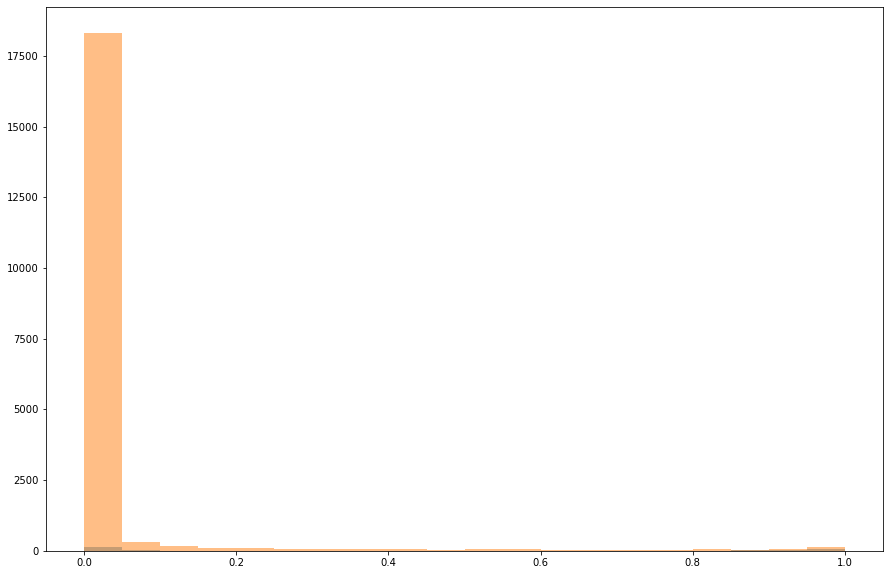

In [67]:
plt.hist(k, 20,alpha=0.5)
plt.hist(t, 20,alpha=0.5)
#plt.xticks([x * 0.05 for x in range(0, 20)])
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

F1-score Method of checking best threshold

In [68]:
thresholds = []
for thresh in np.arange(0.1, 0.99, 0.001):
    thresh = np.round(thresh, 3)
    res = f1_score(preds['Actuals'], (preds['Active'] > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh, "Best F1: ", thresholds[0][1])

F1 score at threshold 0.1 is 0.21653084982537837
F1 score at threshold 0.101 is 0.21650087770626097
F1 score at threshold 0.102 is 0.21650087770626097
F1 score at threshold 0.103 is 0.2162162162162162
F1 score at threshold 0.104 is 0.21710914454277283
F1 score at threshold 0.105 is 0.21775147928994085
F1 score at threshold 0.106 is 0.2180094786729858
F1 score at threshold 0.107 is 0.21839762611275967
F1 score at threshold 0.108 is 0.21904761904761905
F1 score at threshold 0.109 is 0.21957040572792363
F1 score at threshold 0.11 is 0.2199641362821279
F1 score at threshold 0.111 is 0.22035928143712574
F1 score at threshold 0.112 is 0.22021660649819494
F1 score at threshold 0.113 is 0.22061482820976494
F1 score at threshold 0.114 is 0.2210144927536232
F1 score at threshold 0.115 is 0.22141560798548096
F1 score at threshold 0.116 is 0.22235722964763063
F1 score at threshold 0.117 is 0.22262773722627738
F1 score at threshold 0.118 is 0.2222222222222222
F1 score at threshold 0.119 is 0.222629

F1 score at threshold 0.282 is 0.24860557768924302
F1 score at threshold 0.283 is 0.24860557768924302
F1 score at threshold 0.284 is 0.24860557768924302
F1 score at threshold 0.285 is 0.24920127795527156
F1 score at threshold 0.286 is 0.24780175859312548
F1 score at threshold 0.287 is 0.24679487179487178
F1 score at threshold 0.288 is 0.24719101123595505
F1 score at threshold 0.289 is 0.24778761061946902
F1 score at threshold 0.29 is 0.24778761061946902
F1 score at threshold 0.291 is 0.24637681159420288
F1 score at threshold 0.292 is 0.24677419354838714
F1 score at threshold 0.293 is 0.2469733656174334
F1 score at threshold 0.294 is 0.2457558609539208
F1 score at threshold 0.295 is 0.24595469255663432
F1 score at threshold 0.296 is 0.24595469255663432
F1 score at threshold 0.297 is 0.24635332252836306
F1 score at threshold 0.298 is 0.24635332252836306
F1 score at threshold 0.299 is 0.2465531224655312
F1 score at threshold 0.3 is 0.24715447154471545
F1 score at threshold 0.301 is 0.2477

F1 score at threshold 0.465 is 0.25700483091787435
F1 score at threshold 0.466 is 0.25700483091787435
F1 score at threshold 0.467 is 0.25700483091787435
F1 score at threshold 0.468 is 0.2572533849129594
F1 score at threshold 0.469 is 0.25825242718446606
F1 score at threshold 0.47 is 0.2585034013605442
F1 score at threshold 0.471 is 0.2587548638132296
F1 score at threshold 0.472 is 0.2590068159688413
F1 score at threshold 0.473 is 0.2590068159688413
F1 score at threshold 0.474 is 0.25925925925925924
F1 score at threshold 0.475 is 0.25951219512195123
F1 score at threshold 0.476 is 0.259765625
F1 score at threshold 0.477 is 0.260019550342131
F1 score at threshold 0.478 is 0.2602739726027397
F1 score at threshold 0.479 is 0.25882352941176473
F1 score at threshold 0.48 is 0.25882352941176473
F1 score at threshold 0.481 is 0.2590775269872424
F1 score at threshold 0.482 is 0.2578740157480315
F1 score at threshold 0.483 is 0.258128078817734
F1 score at threshold 0.484 is 0.258128078817734
F1 s

F1 score at threshold 0.651 is 0.27809965237543455
F1 score at threshold 0.652 is 0.27809965237543455
F1 score at threshold 0.653 is 0.2787456445993031
F1 score at threshold 0.654 is 0.27939464493597205
F1 score at threshold 0.655 is 0.27939464493597205
F1 score at threshold 0.656 is 0.2777129521586931
F1 score at threshold 0.657 is 0.2777129521586931
F1 score at threshold 0.658 is 0.2777129521586931
F1 score at threshold 0.659 is 0.2777129521586931
F1 score at threshold 0.66 is 0.2780373831775701
F1 score at threshold 0.661 is 0.2793427230046948
F1 score at threshold 0.662 is 0.2793427230046948
F1 score at threshold 0.663 is 0.2796709753231492
F1 score at threshold 0.664 is 0.28
F1 score at threshold 0.665 is 0.28032979976442873
F1 score at threshold 0.666 is 0.28032979976442873
F1 score at threshold 0.667 is 0.2783018867924528
F1 score at threshold 0.668 is 0.2783018867924528
F1 score at threshold 0.669 is 0.27863046044864226
F1 score at threshold 0.67 is 0.27863046044864226
F1 score

F1 score at threshold 0.837 is 0.2676470588235294
F1 score at threshold 0.838 is 0.268041237113402
F1 score at threshold 0.839 is 0.268041237113402
F1 score at threshold 0.84 is 0.26843657817109146
F1 score at threshold 0.841 is 0.2658788774002954
F1 score at threshold 0.842 is 0.2662721893491124
F1 score at threshold 0.843 is 0.26448736998514116
F1 score at threshold 0.844 is 0.26448736998514116
F1 score at threshold 0.845 is 0.26488095238095244
F1 score at threshold 0.846 is 0.2656716417910448
F1 score at threshold 0.847 is 0.2656716417910448
F1 score at threshold 0.848 is 0.2660687593423019
F1 score at threshold 0.849 is 0.2668665667166417
F1 score at threshold 0.85 is 0.2672672672672673
F1 score at threshold 0.851 is 0.26766917293233083
F1 score at threshold 0.852 is 0.2680722891566265
F1 score at threshold 0.853 is 0.26847662141779793
F1 score at threshold 0.854 is 0.2662632375189108
F1 score at threshold 0.855 is 0.2662632375189108
F1 score at threshold 0.856 is 0.267071320182094

<h4>Metrics</h4>

In [69]:
conditions = [(preds['Active']>=best_thresh),(preds['Active']<best_thresh)]
values = [1,0]
preds['Preds'] = np.select(conditions, values)
preds

molStripped        Active  \
0                          COc1ccc(CC(=O)Nc2cc(C)on2)cc1  2.525508e-04   
1                    COc1ccc(N2C(=O)CC(NC3CCCC3)C2=O)cc1  6.407433e-10   
2                     S=c1[nH]nc(-c2ccccc2Cl)n1Cc1ccccc1  1.358989e-07   
3      CCc1nnc(NS(=O)(=O)c2ccc(NC(=S)NC(=O)Cc3ccc(Cl)...  5.985464e-05   
4                                 O=C(Oc1ccccc1)N1CCCCC1  4.123213e-13   
...                                                  ...           ...   
20133  O=C(NC(NC(=S)Nc1c(Cl)cccc1Cl)C(Cl)(Cl)Cl)c1ccccc1  4.628641e-14   
20134                O=S(=O)(c1ccccc1)N1CCN(Cc2ccsc2)CC1  1.499168e-06   
20135              O=c1oc2ccccc2cc1-c1csc(NCCc2ccccc2)n1  1.780798e-03   
20136  CC(=O)c1c(N2CCN(C(=O)c3ccco3)CC2)nc(=S)n(-c2cc...  2.109779e-05   
20137         CC(=O)Oc1ccc2nc(-c3ccc(C)c(C)c3)oc(=O)c2c1  1.133960e-02   

       Actuals  Preds  
0            0      0  
1            0      0  
2            0      0  
3            0      0  
4            0      0  
...        ...    ...  
20133        0      0  
20134        0      0  
20135        0      0  
20136        0      0  
20137        1      0  

[20138 rows x 4 columns]

In [70]:
cf = confusion_matrix(preds['Actuals'], preds['Preds'])

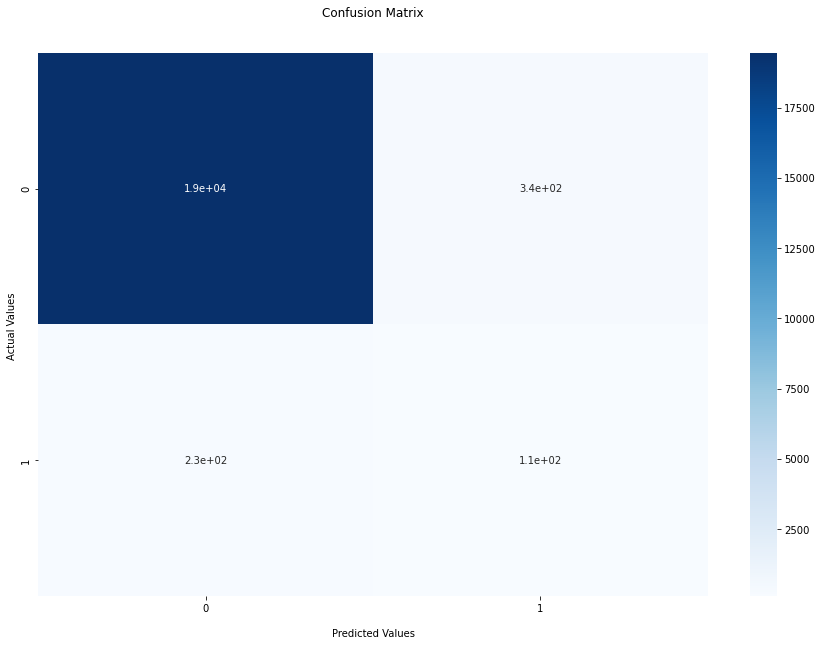

In [71]:
ax = sns.heatmap(cf, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [72]:
labels = ['Balanced Accuracy','F1 Score','Accuracy Score','Precision Score','Recall Score']
metrics = [balanced_accuracy_score(preds['Actuals'], preds['Preds']),f1_score(preds['Actuals'], preds['Preds']),
           accuracy_score(preds['Actuals'], preds['Preds']),precision_score(preds['Actuals'], preds['Preds']),
           recall_score(preds['Actuals'], preds['Preds'])]

In [73]:
metrics_t = pd.DataFrame()
metrics_t['Metrics'] = labels
metrics_t['Values'] = metrics
metrics_t

Metrics    Values
0  Balanced Accuracy  0.654674
1           F1 Score  0.281013
2     Accuracy Score  0.971795
3    Precision Score  0.246667
4       Recall Score  0.326471

<h3>MLSMR External Set</h3>

In [74]:
target = pd.read_csv("MLSMR_Deduped.csv")
target.head()

/tmp/ipykernel_446/1812009603.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  target = pd.read_csv("MLSMR_Deduped.csv")


MoleculeName                                             SMILES  \
0  SMR000462435  COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCC1=CC=CC...   
1  SMR000150125  CN(CC(=O)OCC(=O)NC1=CC=CC=C1)S(=O)(=O)C1=CC=C(...   
2  SMR000364316    CC1=NN(C2=NC(=NC(O)=C12)C(Cl)(Cl)Cl)C1=CC=CC=C1   
3  SMR000199530  COC1=CC=C(C=C1)C(=O)NN1C(=O)C2=CC=CC=C2N=C1SCC...   
4       7947988              CN1C=C(CNC(=O)C2=CC=CC(Cl)=C2)C(C)=N1   

                                            RDKitMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   
1  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   
2  <rdkit.Chem.rdchem.Mol object at 0x000002C9428...   
3  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   
4  <rdkit.Chem.rdchem.Mol object at 0x000002C9398...   

                                         molStripped strippedSalts  \
0  COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCc1ccccc1)OC           NaN   
1    CN(CC(=O)OCC(=O)Nc1ccccc1)S(=O)(=O)c1ccc(Cl)cc1           NaN   
2          Cc1nn(-c2ccccc2)c2nc(C(Cl)(Cl)Cl)nc(O)c12           NaN   
3  COc1ccc(C(=O)Nn2c(SCc3ccc([N+](=O)[O-])cc3)nc3...           NaN   
4                     Cc1nn(C)cc1CNC(=O)c1cccc(Cl)c1           NaN   

   MtbH37Rv-Inhibition  Active  
0              -117.65       0  
1              -108.21       0  
2               -92.31       0  
3               -89.27       0  
4               -84.72       0

In [75]:
train_ext = target[['molStripped']]
y_ext = target[['Active']]
train_ext.to_csv('exttrain.csv',index=False)

In [76]:
ext_parameters = ['--test_path','exttrain.csv',
                  '--preds_path','preds1.csv',
                  #'--features_generator','rdkit_2d',
                 #'--no_features_scaling',
                 #'--individual_ensemble_predictions',
                  '--checkpoint_dir','checkpoints']

In [77]:
pred1 = chemprop.args.PredictArgs().parse_args(ext_parameters)

In [78]:
y_o = chemprop.train.make_predictions(args=pred1)

Loading training args
Setting molecule featurization parameters to default.
Loading data


214506it [00:01, 210028.52it/s]
100%|██████████| 214506/214506 [00:02<00:00, 95666.09it/s] 


Validating SMILES
Test size = 214,506


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".



 12%|█▏        | 501/4291 [00:54<06:31,  9.68it/s]


 23%|██▎       | 1000/4291 [01:45<06:20,  8.65it/s]


 35%|███▌      | 1512/4291 [02:39<04:31, 10.22it/s]


 48%|████▊     | 2052/4291 [03:33<03:32, 10.56it/s]


 60%|██████    | 2580/4291 [04:27<02:42, 10.54it/s]


 73%|███████▎  | 3136/4291 [05:22<01:52, 10.26it/s]


 85%|████████▌ | 3663/4291 [06:16<01:13,  8.50it/s]


 96%|█████████▌| 4125/4291 [07:06<00:17,  9.38it/s]


100%|██████████| 1/1 [07:23<00:00, 443.69s/it]     


Saving predictions to preds1.csv
Elapsed time = 0:07:30


In [79]:
preds_ext = pd.read_csv('preds1.csv')
preds_ext['Actuals'] = y_ext
preds_ext

molStripped        Active  \
0       COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCc1ccccc1)OC  3.752320e-19   
1         CN(CC(=O)OCC(=O)Nc1ccccc1)S(=O)(=O)c1ccc(Cl)cc1  3.022950e-12   
2               Cc1nn(-c2ccccc2)c2nc(C(Cl)(Cl)Cl)nc(O)c12  7.863323e-09   
3       COc1ccc(C(=O)Nn2c(SCc3ccc([N+](=O)[O-])cc3)nc3...  1.038628e-06   
4                          Cc1nn(C)cc1CNC(=O)c1cccc(Cl)c1  7.381360e-09   
...                                                   ...           ...   
214501                        O=C1C(=O)c2ccccc2-c2ccccc21  6.456264e-01   
214502                CC(/N=N/c1nc2ccccc2s1)=N\Nc1ccccc1O  1.124091e-04   
214503  CN(C)c1ccc(/C=C/c2ccc3c4ccccc4ccc3[n+]2-c2cccc...  8.679283e-06   
214504         CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21  3.912369e-02   
214505           CSc1ccc(C(=O)C2CCCN(Cc3cnc(SC)nc3)C2)cc1  5.633870e-03   

        Actuals  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
214501        1  
214502        1  
214503        1  
214504        1  
214505        1  

[214506 rows x 3 columns]

In [80]:
conditions = [(preds_ext['Active']>=0.647),(preds_ext['Active']<0.647)]
values = [1,0]
preds_ext['Predicted'] = np.select(conditions, values)
preds_ext

molStripped        Active  \
0       COC(C[C@H]1O[C@H]1[C@@H](O)[C@@H](C)OCc1ccccc1)OC  3.752320e-19   
1         CN(CC(=O)OCC(=O)Nc1ccccc1)S(=O)(=O)c1ccc(Cl)cc1  3.022950e-12   
2               Cc1nn(-c2ccccc2)c2nc(C(Cl)(Cl)Cl)nc(O)c12  7.863323e-09   
3       COc1ccc(C(=O)Nn2c(SCc3ccc([N+](=O)[O-])cc3)nc3...  1.038628e-06   
4                          Cc1nn(C)cc1CNC(=O)c1cccc(Cl)c1  7.381360e-09   
...                                                   ...           ...   
214501                        O=C1C(=O)c2ccccc2-c2ccccc21  6.456264e-01   
214502                CC(/N=N/c1nc2ccccc2s1)=N\Nc1ccccc1O  1.124091e-04   
214503  CN(C)c1ccc(/C=C/c2ccc3c4ccccc4ccc3[n+]2-c2cccc...  8.679283e-06   
214504         CCN1/C(=C/c2ccc3ccccc3[n+]2CC)C=Cc2ccccc21  3.912369e-02   
214505           CSc1ccc(C(=O)C2CCCN(Cc3cnc(SC)nc3)C2)cc1  5.633870e-03   

        Actuals  Predicted  
0             0          0  
1             0          0  
2             0          0  
3             0          0  
4             0          0  
...         ...        ...  
214501        1          0  
214502        1          0  
214503        1          0  
214504        1          0  
214505        1          0  

[214506 rows x 4 columns]

In [81]:
cf_ext = confusion_matrix(preds_ext['Actuals'], preds_ext['Predicted'])

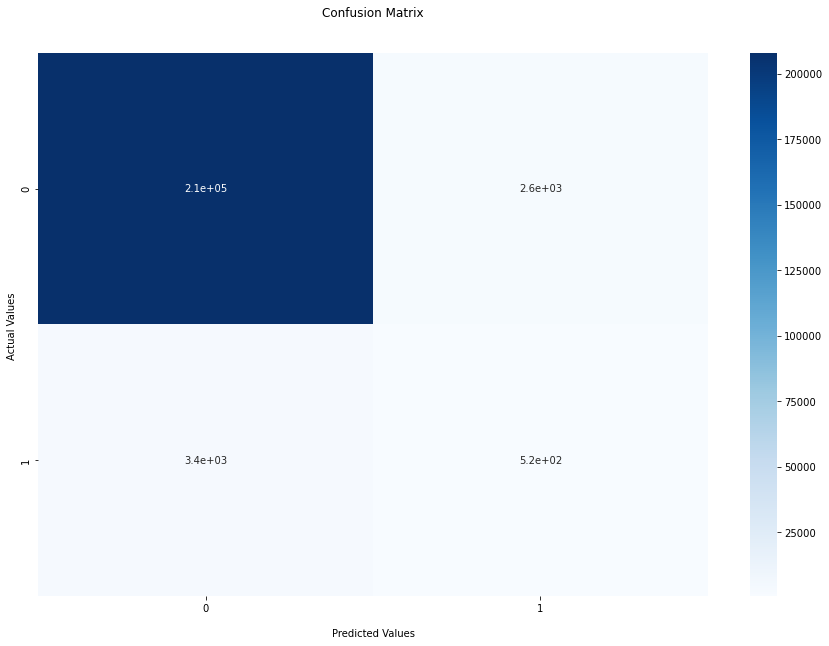

In [82]:
ax = sns.heatmap(cf_ext, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
plt.show()

In [83]:
labels = ['Balanced Accuracy','F1 Score','Accuracy Score','Precision Score','Recall Score']
metrics = [balanced_accuracy_score(preds_ext['Actuals'], preds_ext['Predicted']),f1_score(preds_ext['Actuals'], preds_ext['Predicted']),
           accuracy_score(preds_ext['Actuals'], preds_ext['Predicted']),precision_score(preds_ext['Actuals'], preds_ext['Predicted']),
           recall_score(preds_ext['Actuals'], preds_ext['Predicted'])]

In [84]:
metrics_et = pd.DataFrame()
metrics_et['Metrics'] = labels
metrics_et['Values'] = metrics
metrics_et

Metrics    Values
0  Balanced Accuracy  0.560264
1           F1 Score  0.147607
2     Accuracy Score  0.972271
3    Precision Score  0.166129
4       Recall Score  0.132800

<h3>Docking Predictions</h3>

In [85]:
docking = pd.read_csv("KasADockedTop1000_2Descriptors.csv")

In [86]:
docking.head()

MoleculeId                                             SMILES  \
0   Z57030687  O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...   
1   Z56823499  O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...   
2   Z53786665  Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...   
3  Z105382408  Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...   
4   Z56760621  O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...   

                                            RDKitMol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000001A7ABF...   
1  <rdkit.Chem.rdchem.Mol object at 0x000001A7ABF...   
2  <rdkit.Chem.rdchem.Mol object at 0x000001A7AF1...   
3  <rdkit.Chem.rdchem.Mol object at 0x000001A7AF1...   
4  <rdkit.Chem.rdchem.Mol object at 0x000001A7AF1...   

                                         molStripped  strippedSalts  Cluster  \
0  O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...            NaN        0   
1  O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...            NaN        0   
2  Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...            NaN        0   
3  Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...            NaN        0   
4  O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...            NaN        0   

        apol  arorings  ast_fraglike  ast_fraglike_ext  ...  vsa_acid  \
0  79.145790         4             0                 0  ...         0   
1  65.380241         2             0                 0  ...         0   
2  71.641861         4             0                 0  ...         0   
3  74.072617         3             0                 0  ...         0   
4  63.671066         4             0                 0  ...         0   

   vsa_base   vsa_don    vsa_hyd  vsa_other    vsa_pol     Weight  weinerPath  \
0         0  5.682576  343.89801  48.930611  30.614649  482.65198        4161   
1         0  9.421040  269.47348  46.198566  42.237457  417.53299        2677   
2         0  5.682576  318.73322  41.352348  44.181568  501.99399        3964   
3         0  5.682576  365.40448  24.140093  24.932074  492.59399        4073   
4         0  5.682576  278.38156  24.140093  30.614649  409.51300        2317   

   weinerPol  zagreb  
0         58     192  
1         50     164  
2         61     196  
3         58     196  
4         54     172  

[5 rows x 215 columns]

In [87]:
dock_smiles = docking[['molStripped']]

In [88]:
dock_smiles.to_csv('dock.csv',index=False)

In [91]:
dock_parameters = ['--test_path','dock.csv',
                  '--preds_path','preds_TAACF.csv',
                 #'--features_generator','rdkit_2d',
                 #'--no_features_scaling',
                 #'--individual_ensemble_predictions',
                  '--checkpoint_dir','checkpoints']

In [92]:
pred2 = chemprop.args.PredictArgs().parse_args(dock_parameters)

In [93]:
y_d = chemprop.train.make_predictions(args=pred2)

Loading training args
Setting molecule featurization parameters to default.
Loading data


956it [00:00, 325335.06it/s]
100%|██████████| 956/956 [00:00<00:00, 130922.21it/s]

Validating SMILES


Test size = 956


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".



100%|██████████| 1/1 [00:02<00:00,  2.33s/it]  

Saving predictions to preds_TAACF.csv
Elapsed time = 0:00:03


In [94]:
preds_dock = pd.read_csv('preds_TAACF.csv')
preds_dock

molStripped    Active
0    O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...  0.000109
1    O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...  0.000037
2    Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...  0.017110
3    Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...  0.020215
4    O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...  0.048968
..                                                 ...       ...
951  Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccc...  0.056355
952  Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(...  0.008888
953  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4s...  0.001421
954  Brc1ccc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=...  0.000074
955  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccccc4)CC(c4occc4)...  0.000198

[956 rows x 2 columns]

In [95]:
conditions = [(preds_dock['Active']>=best_thresh),(preds_dock['Active']<best_thresh)]
values = [1,0]
preds_dock['Predicted'] = np.select(conditions, values)
preds_dock

molStripped    Active  Predicted
0    O=C(Nc1c(Cc2ccccc2)cccc1)C1CCN(c2ncnc3sc4c(c23...  0.000109          0
1    O=C1C(=CNN2C(=O)c3c(sc4c3CCCC4)N=C2)CCCC1=Cc1c...  0.000037          0
2    Clc1ccc(-c2nc3c(c(C(=O)OCC4=Nc5sc6c(c5C(=O)N4)...  0.017110          0
3    Fc1ccc(C(N2CCN(CC3=Nc4sc5c(c4C(=O)N3)CCC5)CC2)...  0.020215          0
4    O=C1NC(c2c3c(nc(-c4ccccc4)c2)cccc3)=Nc2sc3c(c1...  0.048968          0
..                                                 ...       ...        ...
951  Clc1cc2nc(N3C(c4sccc4)CC(c4sccc4)=N3)nc(-c3ccc...  0.056355          0
952  Clc1cc2c(-c3ccccc3)nc(N3C(c4c(C)cccc4)CC(c4cc(...  0.008888          0
953  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccc(OCC)cc4)CC(c4s...  0.001421          0
954  Brc1ccc(C2N(c3nc(-c4ccccc4)c4c(n3)ccc(Cl)c4)N=...  0.000074          0
955  Clc1cc2c(-c3ccccc3)nc(N3C(c4ccccc4)CC(c4occc4)...  0.000198          0

[956 rows x 3 columns]

In [96]:
preds_dock['Predicted'].value_counts()

0    947
1      9
Name: Predicted, dtype: int64

In [97]:
preds_dock.to_csv('Dock_TAACF.csv')